# [1] 라이브러리 준비

In [ ]:
# 나눔 글꼴 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,457 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121654 files and dire

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

import seaborn as sns
import re

import random
import os

# 경고무시
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller





# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 나눔고딕 경로에 따라 변경
fontprop = fm.FontProperties(fname=font_path, size=12)

# 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## 데이터 준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# df = pd.read_csv('/content/drive/MyDrive/ASAC/최종프로젝트/finance_final_68.csv')
df = pd.read_csv('/content/drive/MyDrive/경제지표데이터/finance_final_68.csv')

In [ ]:
# 결측치처리 & up_down변수,Text변수 제외
df_notcat = df.drop(['Korea Text', 'US Text','up_down'], axis=1)
df_notcat['날짜'] = pd.to_datetime(df_notcat['날짜'])
# df_notcat = df_notcat.fillna(method = 'bfill').fillna(method = 'ffill')
# 경제위기, 미_경기침체데이터 타입 변환
df_notcat['경제위기']=df_notcat['경제위기'].astype(object)
df_notcat['미_경기침체데이터']=df_notcat['미_경기침체데이터'].astype(object)

df_notcat.set_index('날짜', inplace=True)
df_notcat['기준금리']

날짜
2003-01-01    4.25
2003-02-01    4.25
2003-03-01    4.25
2003-04-01    4.25
2003-05-01    4.00
              ... 
2023-05-01    3.50
2023-06-01    3.50
2023-07-01    3.50
2023-08-01    3.50
2023-09-01    3.50
Name: 기준금리, Length: 249, dtype: float64

##  MinMax 스케일링
- 기준금리와 동일한 단위인 %로 표현된 변수 & (경제위기, 미_경기침체-0/1로 구성)제외
- => 특정년도=100, 100을 기준으로 하는 변수, 금액, 인원수


In [ ]:
col_notper = [
        #100기준
        '경제심리지수', '소비자물가지수', '농산물및석유류제외지수', '식료품 및 에너지제외 지수', 'BSI_전산업', 'BSI_제조업', 'BSI_비제조업', '소비자심리지수(CCSI)', '현재경기판단',
        '현재생활형편', '뉴스심리지수', '원달러환율', '동행지수순환변동치', '선행지수순환변동치','달러인덱스'
         ,'선행종합지수(2020=100)','기계류내수출하지수(선박제외)(2020=100)','수출입물가비율(2015=100)', '코스피(1980.1.4=100)', '동행종합지수(2020=100)', '광공업생산지수(2020=100)'
         ,'서비스업생산지수(도소매업제외)(2020=100)', '소매판매액지수(2020=100)', '내수출하지수(2020=100)', '후행종합지수(2020=100)', '생산자제품재고지수(2020=100)'
        # 금액
         ,'건설수주액(실질)(십억원)', '건설기성액(실질)(십억원)','수입액(실질)(백만불)', '소비재수입액(실질)(백만불)', '국내총생산(GDP)(당해년 가격) (10억원\)', '1인당 GDP(당해년 가격) (만원)'
        # 인원수
        ,'비농림어업취업자수(천명)','취업자수(천명)'
       ,'미_cpi','미_corecpi', 'South Korea', 'United States of America'
       ]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_notcat[col_notper] = scaler.fit_transform(df_notcat[col_notper])

In [ ]:
# top20 = ['장단기금리차(%p)','경제심리지수','미국채_2','미국채_5','미국채_10','후행종합지수(2020=100)','달러인덱스','선행종합지수(2020=100)','식료품 및 에너지제외 지수',
#         '수입액(실질)(백만불)','소매판매액지수(2020=100)','농산물및석유류제외지수', '소비재수입액(실질)(백만불)', '동행지수순환변동치','코스피(1980.1.4=100)',
#           '수출입물가비율(2015=100)','내수출하지수(2020=100)','건설수주액(실질)(십억원)','미국채_20','1인당 GDP(당해년 가격) (만원)']

In [ ]:
# 상위 18개 중요변수 + 종속변수
top18 = ['미국채_2','미국채_5','미국채_10','후행종합지수(2020=100)','달러인덱스','선행종합지수(2020=100)','식료품 및 에너지제외 지수',
        '수입액(실질)(백만불)','소매판매액지수(2020=100)','농산물및석유류제외지수', '소비재수입액(실질)(백만불)', '동행지수순환변동치','코스피(1980.1.4=100)',
          '수출입물가비율(2015=100)','내수출하지수(2020=100)','건설수주액(실질)(십억원)','미국채_20','1인당 GDP(당해년 가격) (만원)' ]

# [2] VECM (벡터오차수정모형)


- 다변량 시계열 모델로 공적분을 고려하며 장기적인 균형관계를 이탈하는 부분을 단기적인 조정과정을 통해 점진적으로 수정하는 모형

         cf) 공적분: 각각으로는 비정상 시계열이지만, 두 시계열을 선형조합해서 안정적인 시계열을 얻을 수 있는 관계

- 여러 변수간 상호작용을 고려하며 각 변수가 자체적인 자기회귀 및 오류수정항을 가지고 있음
    - 자기회귀: 각 변수는 자체의 이전 값에 의존하여 모델링, 이전 기준금리 값이 현재 기준금리 값을 예측하는 데 사용
    - 오류수정: 변수간의 장기적인 균형을 고려하며 오차를 조절하는 역할
    - 다변량 상호작용: 여러 변수간 상호작용이 반영되어 각 변수와 다른 변수들과의 관계를 고려

=> 미래 기준금리 예측시 과거의 기준금리뿐만 아니라 다양한 거시경제 지표를 동시에 고려 가능

In [ ]:
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

In [ ]:
# 독립변수만 추출
data_independent = df_notcat[top18]
data_independent.columns

Index(['미국채_2', '미국채_5', '미국채_10', '후행종합지수(2020=100)', '달러인덱스',
       '선행종합지수(2020=100)', '식료품 및 에너지제외 지수', '수입액(실질)(백만불)',
       '소매판매액지수(2020=100)', '농산물및석유류제외지수', '소비재수입액(실질)(백만불)', '동행지수순환변동치',
       '코스피(1980.1.4=100)', '수출입물가비율(2015=100)', '내수출하지수(2020=100)',
       '건설수주액(실질)(십억원)', '미국채_20', '1인당 GDP(당해년 가격) (만원)'],
      dtype='object')

## 2-1) 차분

### 1차 차분

#### 독립변수(기준금리 제외)

In [ ]:
import matplotlib.pyplot as plt
for var in data_independent.columns:
    # 차분 전 그래프
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(df[var], label=f'{var} (원본)')
    plt.title(f'{var} - 차분 전')
    plt.legend()

    # 1차 차분
    df_diff = df[var].diff().dropna()

    # 차분 후 그래프
    plt.subplot(2, 1, 2)
    plt.plot(df_diff, label=f'{var} (1차 차분)')
    plt.title(f'{var} - 1차 차분 후')
    plt.legend()

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 차분 수행
df_diff = data_independent.diff().dropna()
df_diff

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원)
날짜,,,,,,,,,,,,,,,,,,
2003-02-01,-0.115439,-0.154486,-0.145940,0.005254,-0.007111,0.000000,0.005131,-0.002293,-0.023305,0.003058,-0.003952,-0.067797,-0.003690,0.010294,-0.024024,-0.007763,-0.151905,0.0
2003-03-01,-0.054085,-0.114085,-0.095489,0.003503,-0.006895,0.001721,0.018848,-0.002588,-0.012712,0.016977,-0.003236,-0.050847,-0.001506,0.011765,-0.018018,-0.011560,-0.053810,0.0
2003-04-01,0.048571,0.144762,0.151429,0.003503,-0.029951,-0.001721,0.005157,-0.001978,-0.036017,0.001541,-0.004541,-0.101695,-0.005648,0.008824,-0.027027,-0.003677,0.095714,0.0
2003-05-01,-0.207143,-0.412857,-0.389524,0.003503,-0.015514,0.000000,0.001702,-0.003166,0.010593,0.003106,-0.001803,0.000000,0.002748,0.013235,-0.012012,-0.018730,-0.390476,0.0
2003-06-01,-0.188095,-0.250000,-0.234762,0.003503,-0.005171,0.006885,0.001728,-0.000770,0.002119,0.003058,0.004208,0.000000,0.014119,0.005882,0.003003,0.096646,-0.180952,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,0.115818,0.054364,0.113636,0.005254,0.009415,0.006885,0.009686,0.022860,-0.014831,0.011559,-0.025389,0.000000,0.009300,0.000000,0.009009,0.002051,0.160636,0.0
2023-06-01,0.507706,0.358160,0.174459,0.003503,-0.003121,0.012048,0.001832,-0.007236,-0.008475,0.005057,0.022716,-0.033898,0.022779,0.022059,0.003003,0.108967,0.078268,0.0
2023-07-01,0.188976,0.191976,0.151405,-0.001751,-0.024254,0.010327,0.006806,-0.049820,-0.012712,-0.002649,-0.026348,-0.084746,0.008923,0.008824,0.006006,0.028143,0.107595,0.0


#### 종속변수(기준금리)

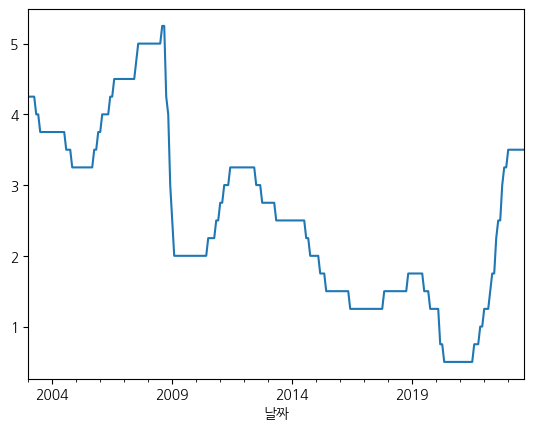

In [ ]:
# 기준금리
df_notcat['기준금리'].plot( )
plt.show()

In [ ]:
result = adfuller( df_notcat['기준금리'])
print( result[1] )
# 0.05보다 크므로 차분 필요

0.1707788098038578


In [ ]:
df_diff['기준금리'] = df_notcat['기준금리'].diff()
result2 = adfuller( df_diff['기준금리'])
print( result2[1] ) # 정상성 확인

1.0278684222831275e-06


### ADF검정
- 정상성 여부 확인
    - H0: 정상 시계열이 아니다
    - H1: 정상시계열이다
    - p-value < 0.05 => H0 기각 => 정상성 만족

In [ ]:
from statsmodels.tsa.stattools import adfuller

# data_independent에 있는 20개의 독립변수에 대해 ADF 검정 수행
for column in data_independent.columns:
    # 차분 후의 데이터
    diff_data = data_independent[column].diff().dropna()

    # ADF 검정
    result = adfuller(diff_data)

    # 결과 출력
    print(f'{column} - ADF Statistic:', result[0])
    print(f'{column} - p-value:', result[1])
    print(f'{column} - Critical Values:', result[4])

    # p-value를 통해 정상성 여부 확인
    if result[1] <= 0.05:
        print(f'{column} - 정상성')
    else:
        print(f'{column} - 비정상성')
    print('\n')

# 비정상성 : 식료품 및 에너지제외 지수, 농산물및석유류제외지수, 소비재수입액(실질)(백만불)

미국채_2 - ADF Statistic: -9.665256798884654
미국채_2 - p-value: 1.320471120129833e-16
미국채_2 - Critical Values: {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}
미국채_2 - 정상성


미국채_5 - ADF Statistic: -11.716843248394158
미국채_5 - p-value: 1.4444359527183965e-21
미국채_5 - Critical Values: {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}
미국채_5 - 정상성


미국채_10 - ADF Statistic: -10.853420427595529
미국채_10 - p-value: 1.5085534930217125e-19
미국채_10 - Critical Values: {'1%': -3.457215237265747, '5%': -2.873361841566324, '10%': -2.5730700760129555}
미국채_10 - 정상성


후행종합지수(2020=100) - ADF Statistic: -3.9497881311998566
후행종합지수(2020=100) - p-value: 0.001697502831671682
후행종합지수(2020=100) - Critical Values: {'1%': -3.4583663275730476, '5%': -2.8738660999177132, '10%': -2.5733390785693766}
후행종합지수(2020=100) - 정상성


달러인덱스 - ADF Statistic: -12.60996814271673
달러인덱스 - p-value: 1.6635839738202003e-23
달러인덱스 - Critical Values: {'1%': -3.457105309726321, '5%': -2

### 2차 차분

In [ ]:
nonstationary_vars = ['식료품 및 에너지제외 지수','농산물및석유류제외지수','소비재수입액(실질)(백만불)']

# 2차 차분을 위한 함수
def second_difference(df, columns):
    for column in columns:
        df[column] = df[column].diff().diff()

# 2차 차분 적용
second_difference(df_diff, nonstationary_vars)

# 2차 차분 후 결과 확인
df_diff.head()

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원),기준금리
날짜,,,,,,,,,,,,,,,,,,,
2003-02-01,-0.115439,-0.154486,-0.145940,0.005254,-0.007111,0.000000,NaN,-0.002293,-0.023305,NaN,NaN,-0.067797,-0.003690,0.010294,-0.024024,-0.007763,-0.151905,0.0,0.00
2003-03-01,-0.054085,-0.114085,-0.095489,0.003503,-0.006895,0.001721,NaN,-0.002588,-0.012712,NaN,NaN,-0.050847,-0.001506,0.011765,-0.018018,-0.011560,-0.053810,0.0,0.00
2003-04-01,0.048571,0.144762,0.151429,0.003503,-0.029951,-0.001721,-0.027408,-0.001978,-0.036017,-0.029355,-0.002021,-0.101695,-0.005648,0.008824,-0.027027,-0.003677,0.095714,0.0,0.00
2003-05-01,-0.207143,-0.412857,-0.389524,0.003503,-0.015514,0.000000,0.010235,-0.003166,0.010593,0.017001,0.004042,0.000000,0.002748,0.013235,-0.012012,-0.018730,-0.390476,0.0,-0.25
2003-06-01,-0.188095,-0.250000,-0.234762,0.003503,-0.005171,0.006885,0.003482,-0.000770,0.002119,-0.001613,0.003274,0.000000,0.014119,0.005882,0.003003,0.096646,-0.180952,0.0,0.00


In [ ]:
df_diff = df_diff.fillna(0)

In [ ]:
# '식료품 및 에너지제외 지수','농산물및석유류제외지수','소비재수입액(실질)(백만불)'
result = adfuller(df_diff['식료품 및 에너지제외 지수'])
# print( result[1] ) 8.882844675143946e-19
result2 = adfuller(df_diff['농산물및석유류제외지수'])
result3 = adfuller(df_diff['소비재수입액(실질)(백만불)'])
print(result[1], result2[1], result3[1])
# 2차 차분 후 모두 정상성 만족

8.882844675155644e-19 4.5542737106110085e-18 1.0383445062578679e-12


## 2-2) 차분 완료 데이터

In [ ]:
df_diff

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원),기준금리
날짜,,,,,,,,,,,,,,,,,,,
2003-02-01,-0.115439,-0.154486,-0.145940,0.005254,-0.007111,0.000000,0.000000,-0.002293,-0.023305,0.000000,0.000000,-0.067797,-0.003690,0.010294,-0.024024,-0.007763,-0.151905,0.0,0.00
2003-03-01,-0.054085,-0.114085,-0.095489,0.003503,-0.006895,0.001721,0.000000,-0.002588,-0.012712,0.000000,0.000000,-0.050847,-0.001506,0.011765,-0.018018,-0.011560,-0.053810,0.0,0.00
2003-04-01,0.048571,0.144762,0.151429,0.003503,-0.029951,-0.001721,-0.027408,-0.001978,-0.036017,-0.029355,-0.002021,-0.101695,-0.005648,0.008824,-0.027027,-0.003677,0.095714,0.0,0.00
2003-05-01,-0.207143,-0.412857,-0.389524,0.003503,-0.015514,0.000000,0.010235,-0.003166,0.010593,0.017001,0.004042,0.000000,0.002748,0.013235,-0.012012,-0.018730,-0.390476,0.0,-0.25
2003-06-01,-0.188095,-0.250000,-0.234762,0.003503,-0.005171,0.006885,0.003482,-0.000770,0.002119,-0.001613,0.003274,0.000000,0.014119,0.005882,0.003003,0.096646,-0.180952,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,0.115818,0.054364,0.113636,0.005254,0.009415,0.006885,-0.002880,0.022860,-0.014831,-0.003131,0.008902,0.000000,0.009300,0.000000,0.009009,0.002051,0.160636,0.0,0.00
2023-06-01,0.507706,0.358160,0.174459,0.003503,-0.003121,0.012048,-0.008377,-0.007236,-0.008475,-0.008428,0.061586,-0.033898,0.022779,0.022059,0.003003,0.108967,0.078268,0.0,0.00
2023-07-01,0.188976,0.191976,0.151405,-0.001751,-0.024254,0.010327,0.012827,-0.049820,-0.012712,-0.001204,-0.097169,-0.084746,0.008923,0.008824,0.006006,0.028143,0.107595,0.0,0.00


## 2-3) train & test기간 설정

In [ ]:
# 기간 설정
train_end_date = '2023-06-01'
# test기간: 3개월로 설정
test_start_date = '2023-07-01'

# train과 test로 데이터 분할
train = df_diff[:train_end_date]
test = df_diff[test_start_date:]

In [ ]:
train.shape, test.shape

((245, 21), (3, 21))

## 2-4) 공적분 검정
- 변수간 공적분 관계의 개수 파악
    - def_order=0: 결정론적 추세(고정된 추세)가 없음, 차분통해 정상성 확보시 고정추세 없다고 간주
    - k_ar_diff: 차분횟수, 여러 차수의 차분을 거친 변수가 있는 경우, 그 중 가장 큰 차수로 설정

### 최적 차수 구하기
- statsmodels.tsa.vector_ar.vecm.select_coint_rank 사용
    - method = "trace" or "maxeig"
        - trace: 공적분 과정에서 발생하는 고유값들을 사용하여 검정 통계량 계산
        - maxeig: 각 고유값 중에서 가장 큰 고유값만을 사용하여 검정 통계량 계산
    - coint_rank: 공적분 관계의 개수, 변수들 간의 장기적인 평형 관계의 차원
        - 공적분 관계의 개수가 n이라면 n개의 시점에서의 관계를 파악한다는 의미
        - 각 시점에는 여러 변수들 간의 관계가 있을 수 있음
        - 변수의 개수와 같거나 작음

In [ ]:
import statsmodels

In [ ]:
rank_test = statsmodels.tsa.vector_ar.vecm.select_coint_rank(train, det_order=0, k_ar_diff=2, method="trace",signif=0.05)
rank_test.rank

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/vector_ar/vecm.py:581: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  coint_result = coint_johansen(endog, det_order, k_ar_diff)


21

In [ ]:
rank_test.summary()
# r_1값으로 coint_rank 설정

r_0,r_1,test statistic,critical value
0,21,2681.,nan
1,21,2321.,nan
2,21,2018.,nan
3,21,1731.,nan
4,21,1519.,nan
5,21,1324.,nan
6,21,1147.,nan
7,21,1000.,nan
8,21,867.0,nan
9,21,746.0,335.0


## 2-5) 모델 훈련
- deterministic ='ci'
    - ci(Constant and Individual Trends): 공적분 관계에 대한 상수 및 각 시계열에 대한 독립적인 선형 추세 포함

In [ ]:
# train 데이터로 모델 훈련
model = VECM(train, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# test데이터
forecast_steps = len(test)
forecast_baseline_rate_diff = result.predict(steps=forecast_steps)
# 기준금리만 예측
forecast_baseline_rate_diff = forecast_baseline_rate_diff[:, [-1]]

In [ ]:
forecast_baseline_rate_diff

array([[0.05084472],
       [0.06733408],
       [0.12182918]])

In [ ]:
test['기준금리']

날짜
2023-07-01    0.0
2023-08-01    0.0
2023-09-01    0.0
Name: 기준금리, dtype: float64

In [ ]:
# 실제값과 예측값 비교 (둘다 차분전)
actual_values = test['기준금리']  # 기준금리  실제값
predicted_values = forecast_baseline_rate_diff # test데이터로 기준금리를 예측한 값

In [ ]:
# 예측 성능 평가
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual_values, predicted_values)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.007320471610480339


In [ ]:
df_notcat['기준금리'].iloc[246:]

날짜
2023-07-01    3.5
2023-08-01    3.5
2023-09-01    3.5
Name: 기준금리, dtype: float64

In [ ]:
# test 데이터에 대한 예측값 역차분
# forecast_baseline_rate_diff: test데이터로 기준금리에 대한 차분된 예측값
# 해당 테스트 데이터의 첫 번째 월에 해당하는 초기값을 사용
forecast_baseline_rate = forecast_baseline_rate_diff.cumsum() + df_notcat['기준금리'].iloc[246]

In [ ]:
forecast_baseline_rate

array([3.55084472, 3.61817881, 3.74000799])

## 2-6) 미래 기준금리 예측

In [ ]:
# top20 변수에서 기준금리 추가
top20_with_interest = top20 + ['기준금리']

### 3개월

In [ ]:
# 미래의 기준금리 예측
future_steps = 3  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, [-1]]
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 값이나 원하는 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum() + df_notcat['기준금리'].iloc[-1]

# 미래의 기준금리 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[3.55084472 3.61817881 3.74000799]


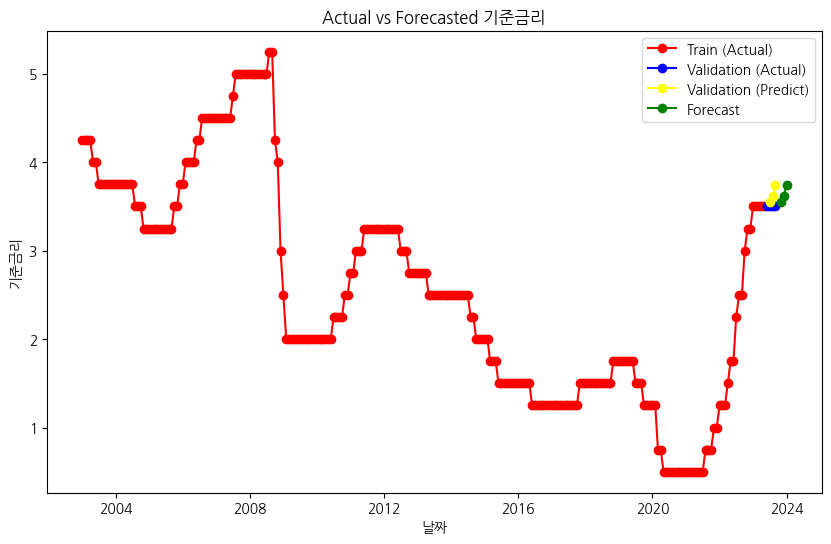

In [ ]:
# 예측 기간 날짜 설정
df_notcat.index = pd.to_datetime(df_notcat.index)
forecast_start_date = pd.to_datetime('2023-10-01')
forecast_dates = pd.date_range(start=forecast_start_date, periods=future_steps+1, freq='M', closed='right', tz='UTC')

# 그래프 그리기
plt.figure(figsize=(10, 6))
# train데이터
plt.plot(df_notcat[top20_with_interest].index[:len(train)], df_notcat['기준금리'][:len(train)], label='Train (Actual)', color='red', marker='o')
# Validation데이터
plt.plot(df_notcat[top20_with_interest].index[len(train):], df_notcat['기준금리'][len(train):], label='Validation (Actual)', color='blue', marker='o')
# Validation데이터 예측
plt.plot(df_notcat[top20_with_interest].index[246:],forecast_baseline_rate, label='Validation (Predict)', color='yellow', marker='o')
# 미래 예측
plt.plot(forecast_dates[:-1], future_forecast, label='Forecast', color='green', marker='o')

plt.title('Actual vs Forecasted 기준금리')
plt.xlabel('날짜')
plt.ylabel('기준금리')
plt.legend()
plt.show()

### 6개월

#### 기간 설정

In [ ]:
# 기간 설정
train_end_date = '2023-03-01'
# test기간: 6개월로 설정
test_start_date = '2023-04-01'

# train과 test로 데이터 분할
train = df_diff[:train_end_date]
test = df_diff[test_start_date:]

#### 모델 훈련

In [ ]:
# train 데이터로 모델 훈련
model = VECM(train, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = model.fit()

In [ ]:
# test데이터
forecast_steps = len(test)
forecast_baseline_rate_diff = result.predict(steps=forecast_steps)
# 기준금리만 예측
forecast_baseline_rate_diff = forecast_baseline_rate_diff[:, [-1]]
# 역차분
forecast_baseline_rate = forecast_baseline_rate_diff.cumsum() + df_notcat['기준금리'].iloc[243]

#### 기준금리 예측

In [ ]:
# 미래의 기준금리 예측
future_steps = 6  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, [-1]]
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 값이나 원하는 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum() + df_notcat['기준금리'].iloc[-1]

# 미래의 기준금리 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[3.37268744 3.37826211 3.33441546 3.24493685 3.2728008  3.25329834]


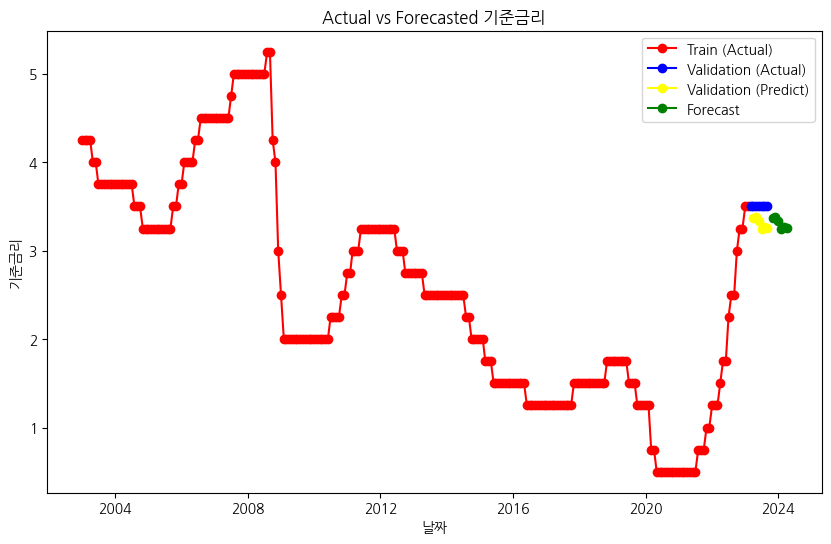

In [ ]:
# 예측 기간 날짜 설정
df_notcat.index = pd.to_datetime(df_notcat.index)
forecast_start_date = pd.to_datetime('2023-10-01')
forecast_dates = pd.date_range(start=forecast_start_date, periods=future_steps+1, freq='M', closed='right', tz='UTC')

# 그래프 그리기
plt.figure(figsize=(10, 6))
# train데이터
plt.plot(df_notcat[top20_with_interest].index[:len(train)], df_notcat['기준금리'][:len(train)], label='Train (Actual)', color='red', marker='o')
# Validation데이터
plt.plot(df_notcat[top20_with_interest].index[len(train):], df_notcat['기준금리'][len(train):], label='Validation (Actual)', color='blue', marker='o')
# Validation데이터 예측
plt.plot(df_notcat[top20_with_interest].index[243:],forecast_baseline_rate, label='Validation (Predict)', color='yellow', marker='o')
# 미래 예측
plt.plot(forecast_dates[:-1], future_forecast, label='Forecast', color='green', marker='o')

plt.title('Actual vs Forecasted 기준금리')
plt.xlabel('날짜')
plt.ylabel('기준금리')
plt.legend()
plt.show()

### 12개월

#### 기간 설정

In [ ]:
# 기간 설정
train_end_date = '2022-09-01'
# test기간: 12개월로 설정
test_start_date = '2022-10-01'

# train과 test로 데이터 분할
train = df_diff[:train_end_date]
test = df_diff[test_start_date:]

#### 모델 훈련

In [ ]:
# train 데이터로 모델 훈련
model = VECM(train, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = model.fit()

In [ ]:
# test데이터
forecast_steps = len(test)
forecast_baseline_rate_diff = result.predict(steps=forecast_steps)
# 기준금리만 예측
forecast_baseline_rate_diff = forecast_baseline_rate_diff[:, [-1]]
# 역차분
forecast_baseline_rate = forecast_baseline_rate_diff.cumsum() + df_notcat['기준금리'].iloc[237]

#### 기준금리 예측

In [ ]:
# 미래의 기준금리 예측
future_steps = 12  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, [-1]]
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 값이나 원하는 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum() + df_notcat['기준금리'].iloc[-1]

# 미래의 기준금리 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[3.61459015 3.6272663  3.62257701 3.55512459 3.51626506 3.44540837
 3.41629116 3.39344582 3.38065733 3.3623175  3.35716641 3.34226607]


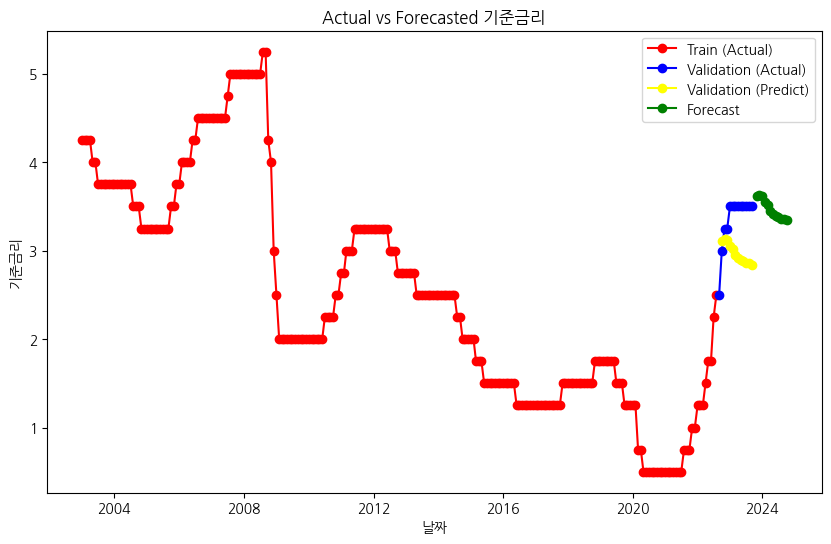

In [ ]:
# 예측 기간 날짜 설정
df_notcat.index = pd.to_datetime(df_notcat.index)
forecast_start_date = pd.to_datetime('2023-10-01')
forecast_dates = pd.date_range(start=forecast_start_date, periods=future_steps+1, freq='M', closed='right', tz='UTC')

# 그래프 그리기
plt.figure(figsize=(10, 6))
# train데이터
plt.plot(df_notcat[top20_with_interest].index[:len(train)], df_notcat['기준금리'][:len(train)], label='Train (Actual)', color='red', marker='o')
# Validation데이터
plt.plot(df_notcat[top20_with_interest].index[len(train):], df_notcat['기준금리'][len(train):], label='Validation (Actual)', color='blue', marker='o')
# Validation데이터 예측
plt.plot(df_notcat[top20_with_interest].index[237:],forecast_baseline_rate, label='Validation (Predict)', color='yellow', marker='o')
# 미래 예측
plt.plot(forecast_dates[:-1], future_forecast, label='Forecast', color='green', marker='o')

plt.title('Actual vs Forecasted 기준금리')
plt.xlabel('날짜')
plt.ylabel('기준금리')
plt.legend()
plt.show()

### 24개월

#### 기간 설정

In [ ]:
# 기간 설정
train_end_date = '2021-09-01'
# test기간: 24개월로 설정
test_start_date = '2021-10-01'

# train과 test로 데이터 분할
train = df_diff[:train_end_date]
test = df_diff[test_start_date:]

#### 모델 훈련

In [ ]:
# train 데이터로 모델 훈련
model = VECM(train, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = model.fit()

In [ ]:
# test데이터
forecast_steps = len(test)
forecast_baseline_rate_diff = result.predict(steps=forecast_steps)
# 기준금리만 예측
forecast_baseline_rate_diff = forecast_baseline_rate_diff[:, [-1]]
# 역차분
forecast_baseline_rate = forecast_baseline_rate_diff.cumsum() + df_notcat['기준금리'].iloc[225]

#### 기준금리 예측

In [ ]:
# 미래의 기준금리 예측
future_steps = 24  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, [-1]]
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 값이나 원하는 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum() + df_notcat['기준금리'].iloc[-1]

# 미래의 기준금리 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[3.5039261  3.46653613 3.30689297 3.17833482 3.04493385 2.93032557
 2.82209717 2.74724576 2.686543   2.62693262 2.59100024 2.54919895
 2.52226871 2.49994085 2.49091649 2.48274111 2.47989077 2.47350165
 2.46507622 2.45446877 2.44278753 2.42935555 2.41619109 2.40159081]


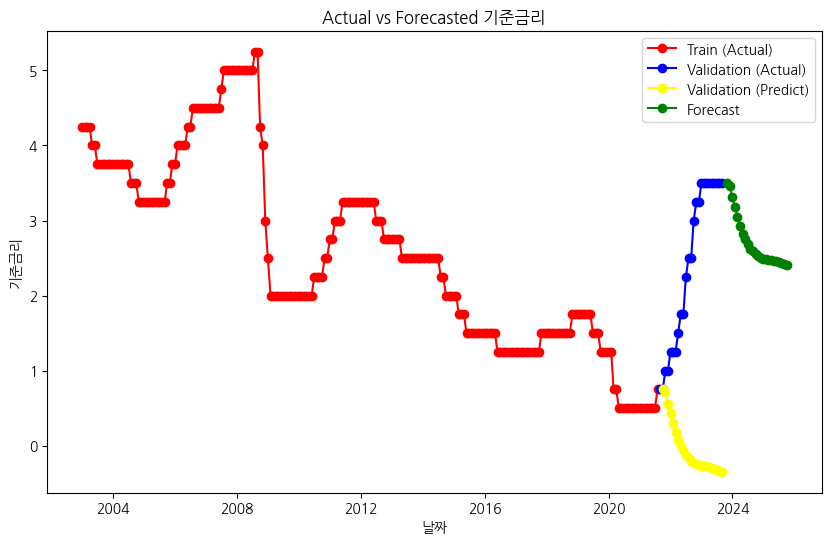

In [ ]:
# 예측 기간 날짜 설정
df_notcat.index = pd.to_datetime(df_notcat.index)
forecast_start_date = pd.to_datetime('2023-10-01')
forecast_dates = pd.date_range(start=forecast_start_date, periods=future_steps+1, freq='M', closed='right', tz='UTC')

# 그래프 그리기
plt.figure(figsize=(10, 6))
# train데이터
plt.plot(df_notcat[top20_with_interest].index[:len(train)], df_notcat['기준금리'][:len(train)], label='Train (Actual)', color='red', marker='o')
# Validation데이터
plt.plot(df_notcat[top20_with_interest].index[len(train):], df_notcat['기준금리'][len(train):], label='Validation (Actual)', color='blue', marker='o')
# Validation데이터 예측
plt.plot(df_notcat[top20_with_interest].index[225:],forecast_baseline_rate, label='Validation (Predict)', color='yellow', marker='o')
# 미래 예측
plt.plot(forecast_dates[:-1], future_forecast, label='Forecast', color='green', marker='o')

plt.title('Actual vs Forecasted 기준금리')
plt.xlabel('날짜')
plt.ylabel('기준금리')
plt.legend()
plt.show()

## 2-7) VECM 정리
- validation 기간 조정하며 모델 훈련해본 결과,
    - 단기간의 경우 기준금리 예측값이 오차범위내에 존재하나, 장기간의 경우 아쉬운 성능을 보임
    - 미래 기준금리 예측에 VECM 단독 사용 어렵다고 판단

## 2-7) 독립변수 예측

### 달러인덱스

In [ ]:
# 예측 기간 설정
train_end_date = '2023-06-01'
test_start_date = '2023-07-01'
# train과 test로 데이터 분할
train = df_diff[:train_end_date]
test = df_diff[test_start_date:]
# 공적분검정
cointegration_test = coint_johansen(train, det_order=0, k_ar_diff=2)
rank_test = statsmodels.tsa.vector_ar.vecm.select_coint_rank(train, det_order=0, k_ar_diff=2, method="trace",signif=0.05)
# train 데이터로 모델 훈련
model = VECM(train, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = model.fit()
# test데이터
forecast_steps = len(test)
forecast_baseline_rate_diff = result.predict(steps=forecast_steps)
# 달러인덱스만 예측
forecast_baseline_rate_diff = forecast_baseline_rate_diff[:,6]
forecast_baseline_rate = forecast_baseline_rate_diff.cumsum() + df_notcat['달러인덱스'].iloc[246]

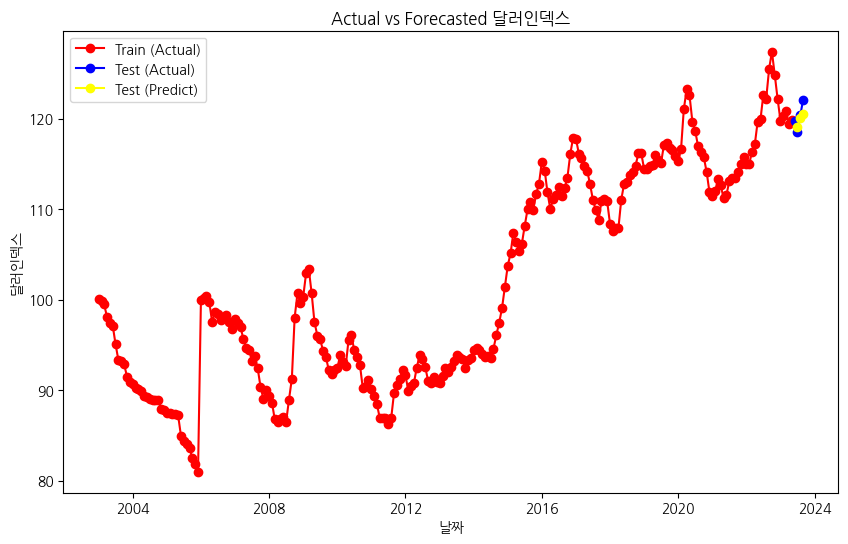

In [ ]:
## test 3개월
# 그래프 그리기
plt.figure(figsize=(10, 6))
# train데이터
plt.plot(df_notcat[top20_with_interest].index[:len(train)], df_notcat['달러인덱스'][:len(train)], label='Train (Actual)', color='red', marker='o')
# test데이터
plt.plot(df_notcat[top20_with_interest].index[len(train):], df_notcat['달러인덱스'][len(train):], label='Test (Actual)', color='blue', marker='o')
# test데이터 예측
plt.plot(df_notcat[top20_with_interest].index[246:],forecast_baseline_rate, label='Test (Predict)', color='yellow', marker='o')
plt.title('Actual vs Forecasted 달러인덱스')
plt.xlabel('날짜')
plt.ylabel('달러인덱스')
plt.legend()
plt.show()

### 미국채_10

In [ ]:
# 예측 기간 설정
train_end_date = '2023-06-01'
test_start_date = '2023-07-01'
# train과 test로 데이터 분할
train = df_diff[:train_end_date]
test = df_diff[test_start_date:]
# 공적분검정
cointegration_test = coint_johansen(train, det_order=0, k_ar_diff=2)
rank_test = statsmodels.tsa.vector_ar.vecm.select_coint_rank(train, det_order=0, k_ar_diff=2, method="trace",signif=0.05)
# train 데이터로 모델 훈련
model = VECM(train, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = model.fit()
# test데이터
forecast_steps = len(test)
forecast_baseline_rate_diff = result.predict(steps=forecast_steps)
# 미국채_10만 예측
forecast_baseline_rate_diff = forecast_baseline_rate_diff[:,4]
forecast_baseline_rate = forecast_baseline_rate_diff.cumsum() + df_notcat['미국채_10'].iloc[246]

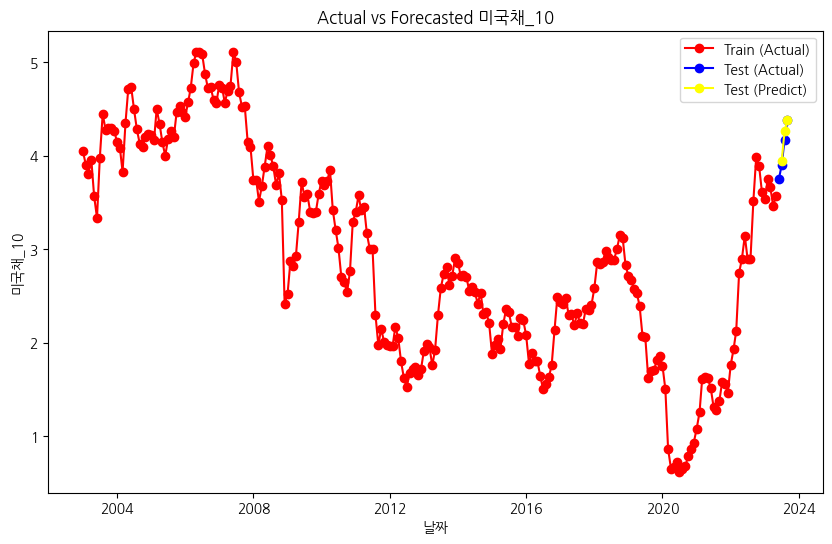

In [ ]:
### test 3개월
# 그래프 그리기
plt.figure(figsize=(10, 6))
# train데이터
plt.plot(df_notcat[top20_with_interest].index[:len(train)], df_notcat['미국채_10'][:len(train)], label='Train (Actual)', color='red', marker='o')
# test데이터
plt.plot(df_notcat[top20_with_interest].index[len(train):], df_notcat['미국채_10'][len(train):], label='Test (Actual)', color='blue', marker='o')
# test데이터 예측
plt.plot(df_notcat[top20_with_interest].index[246:],forecast_baseline_rate, label='Test (Predict)', color='yellow', marker='o')
plt.title('Actual vs Forecasted 미국채_10')
plt.xlabel('날짜')
plt.ylabel('미국채_10')
plt.legend()
plt.show()

## 2-8) 총정리
- validation 기간 조정하며 독립변수를 예측해본 결과, 우수한 성능 확인
- 이후 LSTM모델 훈련시 독립변수의 미래값을 예측하는데 VECM사용을 확정

# [3] VECM 독립변수 생성 & LSTM으로 기준금리 예측

## 3-0) 관련 데이터 설명


- all_data : 날짜 인덱스 독립변수 + 종속변수
    - (249, 21)
- df : 날짜행 + 독립 + 종속
    - (249, 22)
- imp : 날짜 인덱스, 20개 독립변수
    - (249,20)
- target : 날짜 인덱스, 1개 종속변수
    - (249,1)

In [ ]:
# top21 = ['장단기금리차(%p)','경제심리지수','미국채_2','미국채_5','미국채_10','후행종합지수(2020=100)','달러인덱스','선행종합지수(2020=100)','식료품 및 에너지제외 지수',
#         '수입액(실질)(백만불)','소매판매액지수(2020=100)','농산물및석유류제외지수', '소비재수입액(실질)(백만불)', '동행지수순환변동치','코스피(1980.1.4=100)',
#           '수출입물가비율(2015=100)','내수출하지수(2020=100)','건설수주액(실질)(십억원)','미국채_20','1인당 GDP(당해년 가격) (만원)','기준금리']

In [ ]:
# 상위 18개 중요변수 + 종속변수
top19 = ['미국채_2','미국채_5','미국채_10','후행종합지수(2020=100)','달러인덱스','선행종합지수(2020=100)','식료품 및 에너지제외 지수',
        '수입액(실질)(백만불)','소매판매액지수(2020=100)','농산물및석유류제외지수', '소비재수입액(실질)(백만불)', '동행지수순환변동치','코스피(1980.1.4=100)',
          '수출입물가비율(2015=100)','내수출하지수(2020=100)','건설수주액(실질)(십억원)','미국채_20','1인당 GDP(당해년 가격) (만원)','기준금리' ]

In [ ]:
all_data = df_notcat[top19]
all_data.index = pd.to_datetime(all_data.index)
df = all_data.reset_index()
imp = all_data.iloc[:,:-1]
target = all_data.iloc[:,-1]

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2003-01-01 to 2023-09-01
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   미국채_2                 249 non-null    float64
 1   미국채_5                 249 non-null    float64
 2   미국채_10                249 non-null    float64
 3   후행종합지수(2020=100)      249 non-null    float64
 4   달러인덱스                 249 non-null    float64
 5   선행종합지수(2020=100)      249 non-null    float64
 6   식료품 및 에너지제외 지수        249 non-null    float64
 7   수입액(실질)(백만불)          249 non-null    float64
 8   소매판매액지수(2020=100)     249 non-null    float64
 9   농산물및석유류제외지수           249 non-null    float64
 10  소비재수입액(실질)(백만불)       249 non-null    float64
 11  동행지수순환변동치             249 non-null    float64
 12  코스피(1980.1.4=100)     249 non-null    float64
 13  수출입물가비율(2015=100)     249 non-null    float64
 14  내수출하지수(2020=100)      249 non-null    float64
 15  건설수주

In [ ]:
df_diff

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원),기준금리
날짜,,,,,,,,,,,,,,,,,,,
2003-02-01,-0.115439,-0.154486,-0.145940,0.005254,-0.007111,0.000000,0.000000,-0.002293,-0.023305,0.000000,0.000000,-0.067797,-0.003690,0.010294,-0.024024,-0.007763,-0.151905,0.0,0.00
2003-03-01,-0.054085,-0.114085,-0.095489,0.003503,-0.006895,0.001721,0.000000,-0.002588,-0.012712,0.000000,0.000000,-0.050847,-0.001506,0.011765,-0.018018,-0.011560,-0.053810,0.0,0.00
2003-04-01,0.048571,0.144762,0.151429,0.003503,-0.029951,-0.001721,-0.027408,-0.001978,-0.036017,-0.029355,-0.002021,-0.101695,-0.005648,0.008824,-0.027027,-0.003677,0.095714,0.0,0.00
2003-05-01,-0.207143,-0.412857,-0.389524,0.003503,-0.015514,0.000000,0.010235,-0.003166,0.010593,0.017001,0.004042,0.000000,0.002748,0.013235,-0.012012,-0.018730,-0.390476,0.0,-0.25
2003-06-01,-0.188095,-0.250000,-0.234762,0.003503,-0.005171,0.006885,0.003482,-0.000770,0.002119,-0.001613,0.003274,0.000000,0.014119,0.005882,0.003003,0.096646,-0.180952,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,0.115818,0.054364,0.113636,0.005254,0.009415,0.006885,-0.002880,0.022860,-0.014831,-0.003131,0.008902,0.000000,0.009300,0.000000,0.009009,0.002051,0.160636,0.0,0.00
2023-06-01,0.507706,0.358160,0.174459,0.003503,-0.003121,0.012048,-0.008377,-0.007236,-0.008475,-0.008428,0.061586,-0.033898,0.022779,0.022059,0.003003,0.108967,0.078268,0.0,0.00
2023-07-01,0.188976,0.191976,0.151405,-0.001751,-0.024254,0.010327,0.012827,-0.049820,-0.012712,-0.001204,-0.097169,-0.084746,0.008923,0.008824,0.006006,0.028143,0.107595,0.0,0.00


- 맨 처음 time_step 3 으로 데이터 형태 만들고 모델 생성후 훈련 시켜야 원래 결과로 나올 것 같음


## 데이터 분할




In [ ]:
# 예측 기간 설정
train_end_date = '2023-06-01'
test_start_date = '2023-07-01'

# train과 test로 데이터 분할
train = df_diff[:train_end_date]
test = df_diff[test_start_date:]

## VECM 모델 돌리기

In [ ]:
# train 데이터로 모델 훈련
modelV = VECM(train, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = modelV.fit()

In [ ]:
# test데이터
forecast_steps = len(test)
forecast_baseline_rate_diff = result.predict(steps=forecast_steps)
# 독립변수 예측
forecast_baseline_rate_diff = forecast_baseline_rate_diff[:, :-1]

In [ ]:
forecast_baseline_rate_diff.shape

(3, 18)

In [ ]:
# 실제값과 예측값 비교 (둘다 차분 후)
actual_values = test.iloc[:,:-1].values
predicted_values = forecast_baseline_rate_diff # test데이터로 독립변수를 예측한 값

In [ ]:
# 예측 성능 평가
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual_values, predicted_values)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.004391841268154104


## VECM 예측결과

In [ ]:
forecast_baseline_rate_diff

array([[ 0.17981107,  0.14884981,  0.05292167,  0.00606416,  0.01220435,
         0.01345272,  0.00698044,  0.01033422, -0.00081483,  0.00679696,
        -0.02694109, -0.00354946,  0.02727673,  0.01911951,  0.00113158,
         0.14017465,  0.05422994, -0.01721233],
       [ 0.27183939,  0.29836291,  0.31035887,  0.00519885,  0.02780343,
         0.0100827 , -0.00174978,  0.02289843,  0.01039497, -0.00587408,
        -0.02339673,  0.03901975,  0.01937857,  0.01191741, -0.01058868,
         0.07116173,  0.2851102 ,  0.01146862],
       [ 0.07386271,  0.06252069,  0.10278096,  0.00512119,  0.01955624,
         0.00817161,  0.00778303,  0.0082632 ,  0.01727082,  0.01021225,
        -0.00596379,  0.02046884,  0.00644448,  0.01076774,  0.01201541,
        -0.03343133,  0.07746302,  0.01138534]])

In [ ]:
# test 데이터에 대한 예측값 역차분
# forecast_baseline_rate_diff: test데이터로 기준금리에 대한 차분된 예측값
# 해당 테스트 데이터의 첫 번째 월에 해당하는 초기값을 사용
forecast_baseline_rate = forecast_baseline_rate_diff.cumsum(axis=0) + np.array(imp.iloc[246,:]).reshape(1,-1)

In [ ]:
forecast_baseline_rate.shape

(3, 18)

In [ ]:
idx = pd.date_range(start='2023-07-01', periods=3, freq='MS')

In [ ]:
dd = pd.DataFrame(data=forecast_baseline_rate, columns=imp.columns, index=idx)

In [ ]:
dd

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원)
2023-07-01,5.008311,4.290350,3.952422,1.002562,0.822075,1.001405,0.999389,0.897951,0.944100,0.993311,0.878499,0.504925,0.778971,0.063237,0.793924,0.689936,4.203730,0.982788
2023-08-01,5.280150,4.588713,4.262781,1.007760,0.849878,1.011487,0.997639,0.920849,0.954495,0.987437,0.855102,0.543945,0.798350,0.075155,0.783336,0.761097,4.488840,0.994256
2023-09-01,5.354013,4.651233,4.365562,1.012882,0.869435,1.019659,1.005422,0.929112,0.971766,0.997650,0.849138,0.564414,0.804794,0.085922,0.795351,0.727666,4.566303,1.005642


## LSTM 형식으로 shape 변환

In [ ]:
train2 = all_data.iloc[:246,:]

In [ ]:
train2

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원),기준금리
날짜,,,,,,,,,,,,,,,,,,,
2003-01-01,1.743333,3.052381,4.048571,0.000000,0.412425,0.000000,0.000000,0.022220,0.072034,0.000000,0.019416,0.762712,0.010843,0.950000,0.111111,0.226746,5.021905,0.0,4.25
2003-02-01,1.627895,2.897895,3.902632,0.005254,0.405315,0.000000,0.005131,0.019927,0.048729,0.003058,0.015464,0.694915,0.007154,0.960294,0.087087,0.218983,4.870000,0.0,4.25
2003-03-01,1.573810,2.783810,3.807143,0.008757,0.398419,0.001721,0.023978,0.017339,0.036017,0.020036,0.012228,0.644068,0.005648,0.972059,0.069069,0.207423,4.816190,0.0,4.25
2003-04-01,1.622381,2.928571,3.958571,0.012259,0.368468,0.000000,0.029135,0.015361,0.000000,0.021577,0.007687,0.542373,0.000000,0.980882,0.042042,0.203746,4.911905,0.0,4.25
2003-05-01,1.415238,2.515714,3.569048,0.015762,0.352953,0.000000,0.030837,0.012195,0.010593,0.024683,0.005884,0.542373,0.002748,0.994118,0.030030,0.185016,4.521429,0.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,4.533684,3.942105,3.746842,0.980736,0.847166,0.956971,0.959163,0.921231,0.938559,0.958339,0.935894,0.508475,0.683434,0.014706,0.783784,0.740529,3.946316,1.0,3.50
2023-03-01,4.302609,3.823478,3.663043,0.984238,0.857733,0.958692,0.964922,0.924838,0.963983,0.962915,0.946369,0.593220,0.690512,0.011765,0.795796,0.691437,3.939130,1.0,3.50
2023-04-01,4.016000,3.537000,3.460000,0.989492,0.827830,0.958692,0.974084,0.921812,0.980932,0.972547,0.934461,0.627119,0.710693,0.013235,0.774775,0.410600,3.803000,1.0,3.50


In [ ]:
predict_x = pd.concat([imp.iloc[-5:-3,:],dd], axis=0)

In [ ]:
test = pd.concat([predict_x,target[-5:]], axis=1)

In [ ]:
test

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원),기준금리
2023-05-01,4.131818,3.591364,3.573636,0.994746,0.837245,0.965577,0.983770,0.944672,0.966102,0.984106,0.909072,0.627119,0.719992,0.013235,0.783784,0.412651,3.963636,1.000000,3.5
2023-06-01,4.639524,3.949524,3.748095,0.998249,0.834124,0.977625,0.985602,0.937437,0.957627,0.989163,0.931788,0.593220,0.742771,0.035294,0.786787,0.521618,4.041905,1.000000,3.5
2023-07-01,5.008311,4.290350,3.952422,1.002562,0.822075,1.001405,0.999389,0.897951,0.944100,0.993311,0.878499,0.504925,0.778971,0.063237,0.793924,0.689936,4.203730,0.982788,3.5
2023-08-01,5.280150,4.588713,4.262781,1.007760,0.849878,1.011487,0.997639,0.920849,0.954495,0.987437,0.855102,0.543945,0.798350,0.075155,0.783336,0.761097,4.488840,0.994256,3.5
2023-09-01,5.354013,4.651233,4.365562,1.012882,0.869435,1.019659,1.005422,0.929112,0.971766,0.997650,0.849138,0.564414,0.804794,0.085922,0.795351,0.727666,4.566303,1.005642,3.5


In [ ]:
train_size = 246

In [ ]:
# X와 y로 분리
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset.iloc[i:(i + time_steps), :-1]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_steps, -1])
    return np.array(dataX), np.array(dataY)

In [ ]:
# X_val 데이터 생성
def create_val(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps+1):
        a = dataset.iloc[i:(i + time_steps), :-1]
        dataX.append(a)

    return np.array(dataX)

In [ ]:
time_steps = 3  # 시간 단계 수 (조절 가능)
X_train, y_train = create_dataset(train2, time_steps)
X_val = create_val(test, time_steps)
y_val = np.array(all_data.iloc[-3:,-1])

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((243, 3, 18), (3, 3, 18), (243,), (3,))

## 모델 생성

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

In [ ]:
# LSTM 모델 생성
modelL = Sequential()
modelL.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
modelL.add(Dropout(0.3))

modelL.add(Dense(16))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(8))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(1))
modelL.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### 씨드 고정해야함
modelL.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/300
16/16 - 4s - loss: 12.9743 - val_loss: 17.4901 - 4s/epoch - 273ms/step
Epoch 2/300
16/16 - 0s - loss: 9.7038 - val_loss: 13.9808 - 96ms/epoch - 6ms/step
Epoch 3/300
16/16 - 0s - loss: 8.5321 - val_loss: 11.7890 - 92ms/epoch - 6ms/step
Epoch 4/300
16/16 - 0s - loss: 8.9422 - val_loss: 10.1745 - 89ms/epoch - 6ms/step
Epoch 5/300
16/16 - 0s - loss: 7.1737 - val_loss: 8.9626 - 86ms/epoch - 5ms/step
Epoch 6/300
16/16 - 0s - loss: 6.9799 - val_loss: 7.5216 - 82ms/epoch - 5ms/step
Epoch 7/300
16/16 - 0s - loss: 6.8399 - val_loss: 6.9380 - 83ms/epoch - 5ms/step
Epoch 8/300
16/16 - 0s - loss: 6.4382 - val_loss: 6.1666 - 86ms/epoch - 5ms/step
Epoch 9/300
16/16 - 0s - loss: 6.5007 - val_loss: 5.7665 - 81ms/epoch - 5ms/step
Epoch 10/300
16/16 - 0s - loss: 5.0127 - val_loss: 5.5281 - 94ms/epoch - 6ms/step
Epoch 11/300
16/16 - 0s - loss: 4.9690 - val_loss: 5.4488 - 97ms/epoch - 6ms/step
Epoch 12/300
16/16 - 0s - loss: 4.5680 - val_loss: 4.7652 - 98ms/epoch - 6ms/step
Epoch 13/300
16/16 -

In [ ]:
# 테스트 데이터로 예측
train_pred =  modelL.predict(X_train)
val_pred = modelL.predict(X_val)

1/1 [==============================] - 0s 22ms/step


In [ ]:
val_pred

array([[2.881877 ],
       [3.0393262],
       [3.1465964]], dtype=float32)

In [ ]:
# 실제값과 예측값 비교를 위한 데이터프레임 생성
results = pd.DataFrame({'Actual': all_data['기준금리'][train_size:], 'Predicted': val_pred.reshape(-1)})
results

,Actual,Predicted
날짜,,
2023-07-01,3.5,2.881877
2023-08-01,3.5,3.039326
2023-09-01,3.5,3.146596


## 3개월

### 3-1) VECM 모델훈련

In [ ]:
# train 데이터로 모델 훈련
modelV = VECM(df_diff, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = modelV.fit()

In [ ]:
# 미래의 독립변수 예측
future_steps = 3  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, :-1]

In [ ]:
future_forecast_diff.shape

(3, 18)

In [ ]:
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum(axis=0) + np.array(imp.iloc[-1,:]).reshape(1,-1)

# 미래의 독립변수 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[[5.04358431 4.51091463 4.41187606 1.00313957 0.90690366 1.00482947
  1.01592572 0.81478286 0.89657537 1.00499643 0.90889733 0.45042535
  0.73082424 0.04044208 0.80056679 0.27664742 4.66297071 0.9844899 ]
 [5.15561871 4.73399023 4.61238243 1.00428402 0.90189669 1.00967147
  1.00397017 0.81307856 0.89728565 0.99202362 0.8597815  0.46367999
  0.71322106 0.04180336 0.81853515 0.38098082 4.85688409 0.98377351]
 [5.14743029 4.77979332 4.68440432 1.00740865 0.89473617 1.01345349
  1.01263864 0.81457033 0.90965397 1.0092433  0.90924148 0.46573949
  0.7066891  0.044159   0.83193691 0.44056547 4.92435304 0.9834601 ]]


### 3-2) 독립변수 생성

In [ ]:
idx = pd.date_range(start='2023-10-01', periods=future_steps, freq='MS')
future_df3 = pd.DataFrame(data=future_forecast, columns=imp.columns, index=idx)

In [ ]:
future_df3

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원)
2023-10-01,5.043584,4.510915,4.411876,1.003140,0.906904,1.004829,1.015926,0.814783,0.896575,1.004996,0.908897,0.450425,0.730824,0.040442,0.800567,0.276647,4.662971,0.984490
2023-11-01,5.155619,4.733990,4.612382,1.004284,0.901897,1.009671,1.003970,0.813079,0.897286,0.992024,0.859782,0.463680,0.713221,0.041803,0.818535,0.380981,4.856884,0.983774
2023-12-01,5.147430,4.779793,4.684404,1.007409,0.894736,1.013453,1.012639,0.814570,0.909654,1.009243,0.909241,0.465739,0.706689,0.044159,0.831937,0.440565,4.924353,0.983460


### 3-3) 데이터 LSTM으로 형태변환

In [ ]:
# X와 y로 분리
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset.iloc[i:(i + time_steps), :-1]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_steps, -1])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
train_time = -3

# 검증데이터 학습
X_train, y_train = create_dataset(all_data.iloc[:train_time,:], time_steps)
X_val, y_val = create_dataset(all_data.iloc[train_time-1:,:], time_steps)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((245, 1, 18), (245,), (3, 1, 18), (3,))

### 3-4) LSTM 모델훈련

In [ ]:
# LSTM 모델 생성
modelL = Sequential()
modelL.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
modelL.add(Dropout(0.3))

modelL.add(Dense(16))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(8))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(1))
modelL.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

### 씨드 고정해야함
modelL.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/300
16/16 - 5s - loss: 8.9823 - val_loss: 12.8170 - 5s/epoch - 318ms/step
Epoch 2/300
16/16 - 0s - loss: 8.4414 - val_loss: 11.7201 - 120ms/epoch - 7ms/step
Epoch 3/300
16/16 - 0s - loss: 7.4965 - val_loss: 11.0343 - 136ms/epoch - 8ms/step
Epoch 4/300
16/16 - 0s - loss: 6.7028 - val_loss: 10.5437 - 130ms/epoch - 8ms/step
Epoch 5/300
16/16 - 0s - loss: 6.5622 - val_loss: 10.0026 - 115ms/epoch - 7ms/step
Epoch 6/300
16/16 - 0s - loss: 7.1238 - val_loss: 9.5948 - 108ms/epoch - 7ms/step
Epoch 7/300
16/16 - 0s - loss: 6.3751 - val_loss: 9.4976 - 107ms/epoch - 7ms/step
Epoch 8/300
16/16 - 0s - loss: 6.1436 - val_loss: 9.2401 - 100ms/epoch - 6ms/step
Epoch 9/300
16/16 - 0s - loss: 5.7695 - val_loss: 8.8999 - 101ms/epoch - 6ms/step
Epoch 10/300
16/16 - 0s - loss: 5.7626 - val_loss: 8.4408 - 109ms/epoch - 7ms/step
Epoch 11/300
16/16 - 0s - loss: 4.8162 - val_loss: 7.9042 - 103ms/epoch - 6ms/step
Epoch 12/300
16/16 - 0s - loss: 5.0035 - val_loss: 7.4200 - 103ms/epoch - 6ms/step
Epoch 13/

In [ ]:
val_pred = modelL.predict(X_val)

1/1 [==============================] - 0s 446ms/step


In [ ]:
future_date = future_steps
results_v3 = pd.DataFrame({'Val':val_pred.reshape(-1)}, index=all_data.index[-future_date:])
results_v3

,Val
날짜,
2023-07-01,3.230797
2023-08-01,3.246702
2023-09-01,3.326412


### 3-5) 기준금리 예측

In [ ]:
f_x_train, f_y_train = create_dataset(all_data, time_steps)
modelL.fit(f_x_train, f_y_train, epochs=500, batch_size=16, verbose=2, callbacks=[early_stopping])

Epoch 1/500


16/16 - 0s - loss: 0.7720 - 59ms/epoch - 4ms/step
Epoch 2/500


16/16 - 0s - loss: 0.8901 - 49ms/epoch - 3ms/step
Epoch 3/500


16/16 - 0s - loss: 0.6956 - 50ms/epoch - 3ms/step
Epoch 4/500


16/16 - 0s - loss: 0.7601 - 51ms/epoch - 3ms/step
Epoch 5/500


16/16 - 0s - loss: 0.9434 - 57ms/epoch - 4ms/step
Epoch 6/500


16/16 - 0s - loss: 0.8070 - 56ms/epoch - 4ms/step
Epoch 7/500


16/16 - 0s - loss: 0.7016 - 51ms/epoch - 3ms/step
Epoch 8/500


16/16 - 0s - loss: 0.7168 - 50ms/epoch - 3ms/step
Epoch 9/500


16/16 - 0s - loss: 0.6244 - 54ms/epoch - 3ms/step
Epoch 10/500


16/16 - 0s - loss: 0.8229 - 52ms/epoch - 3ms/step
Epoch 11/500


16/16 - 0s - loss: 0.7300 - 57ms/epoch - 4ms/step
Epoch 12/500


16/16 - 0s - loss: 0.7057 - 51ms/epoch - 3ms/step
Epoch 13/500


16/16 - 0s - loss: 0.6795 - 63ms/epoch - 4ms/step
Epoch 14/500


16/16 - 0s - loss: 0.8131 - 52ms/epoch - 3ms/step
Epoch 15/500


16/16 - 0s - loss: 0.7958 - 51ms/epoch - 3ms/step
Epoch 16/500


16/16 - 0s - loss: 0.7687 - 52ms/epoch - 3ms/step
Epoch 17/500


16/16 - 0s - loss: 0.7904 - 49ms/epoch - 3ms/step
Epoch 18/500


16/16 - 0s - loss: 0.6844 - 64ms/epoch - 4ms/step
Epoch 19/500


16/16 - 0s - loss: 0.6313 - 52ms/epoch - 3ms/step
Epoch 20/500


16/16 - 0s - loss: 0.6290 - 57ms/epoch - 4ms/step
Epoch 21/500


16/16 - 0s - loss: 0.7726 - 60ms/epoch - 4ms/step
Epoch 22/500


16/16 - 0s - loss: 0.8007 - 55ms/epoch - 3ms/step
Epoch 23/500


16/16 - 0s - loss: 0.6967 - 56ms/epoch - 3ms/step
Epoch 24/500


16/16 - 0s - loss: 0.6919 - 51ms/epoch - 3ms/step
Epoch 25/500


16/16 - 0s - loss: 0.5945 - 59ms/epoch - 4ms/step
Epoch 26/500


16/16 - 0s - loss: 0.6560 - 54ms/epoch - 3ms/step
Epoch 27/500


16/16 - 0s - loss: 0.6168 - 49ms/epoch - 3ms/step
Epoch 28/500


16/16 - 0s - loss: 0.7393 - 52ms/epoch - 3ms/step
Epoch 29/500


16/16 - 0s - loss: 0.6211 - 53ms/epoch - 3ms/step
Epoch 30/500


16/16 - 0s - loss: 0.7244 - 55ms/epoch - 3ms/step
Epoch 31/500


16/16 - 0s - loss: 0.7025 - 46ms/epoch - 3ms/step
Epoch 32/500


16/16 - 0s - loss: 0.6620 - 50ms/epoch - 3ms/step
Epoch 33/500


16/16 - 0s - loss: 0.6624 - 54ms/epoch - 3ms/step
Epoch 34/500


16/16 - 0s - loss: 0.7415 - 54ms/epoch - 3ms/step
Epoch 35/500


16/16 - 0s - loss: 0.5597 - 54ms/epoch - 3ms/step
Epoch 36/500


16/16 - 0s - loss: 0.6737 - 55ms/epoch - 3ms/step
Epoch 37/500


16/16 - 0s - loss: 0.6703 - 59ms/epoch - 4ms/step
Epoch 38/500


16/16 - 0s - loss: 0.6022 - 51ms/epoch - 3ms/step
Epoch 39/500


16/16 - 0s - loss: 0.6235 - 50ms/epoch - 3ms/step
Epoch 40/500


16/16 - 0s - loss: 0.5838 - 58ms/epoch - 4ms/step
Epoch 41/500


16/16 - 0s - loss: 0.6145 - 56ms/epoch - 4ms/step
Epoch 42/500


16/16 - 0s - loss: 0.7613 - 51ms/epoch - 3ms/step
Epoch 43/500


16/16 - 0s - loss: 0.7201 - 52ms/epoch - 3ms/step
Epoch 44/500


16/16 - 0s - loss: 0.6094 - 52ms/epoch - 3ms/step
Epoch 45/500


16/16 - 0s - loss: 0.6019 - 60ms/epoch - 4ms/step
Epoch 46/500


16/16 - 0s - loss: 0.5959 - 53ms/epoch - 3ms/step
Epoch 47/500


16/16 - 0s - loss: 0.7470 - 53ms/epoch - 3ms/step
Epoch 48/500


16/16 - 0s - loss: 0.6777 - 53ms/epoch - 3ms/step
Epoch 49/500


16/16 - 0s - loss: 0.6356 - 54ms/epoch - 3ms/step
Epoch 50/500


16/16 - 0s - loss: 0.5788 - 54ms/epoch - 3ms/step
Epoch 51/500


16/16 - 0s - loss: 0.5855 - 53ms/epoch - 3ms/step
Epoch 52/500


16/16 - 0s - loss: 0.6050 - 56ms/epoch - 3ms/step
Epoch 53/500


16/16 - 0s - loss: 0.5796 - 60ms/epoch - 4ms/step
Epoch 54/500


16/16 - 0s - loss: 0.4892 - 53ms/epoch - 3ms/step
Epoch 55/500


16/16 - 0s - loss: 0.5963 - 49ms/epoch - 3ms/step
Epoch 56/500


16/16 - 0s - loss: 0.5884 - 50ms/epoch - 3ms/step
Epoch 57/500


16/16 - 0s - loss: 0.5851 - 57ms/epoch - 4ms/step
Epoch 58/500


16/16 - 0s - loss: 0.5654 - 55ms/epoch - 3ms/step
Epoch 59/500


16/16 - 0s - loss: 0.6152 - 50ms/epoch - 3ms/step
Epoch 60/500


16/16 - 0s - loss: 0.6085 - 62ms/epoch - 4ms/step
Epoch 61/500


16/16 - 0s - loss: 0.5971 - 54ms/epoch - 3ms/step
Epoch 62/500


16/16 - 0s - loss: 0.5684 - 53ms/epoch - 3ms/step
Epoch 63/500


16/16 - 0s - loss: 0.5808 - 52ms/epoch - 3ms/step
Epoch 64/500


16/16 - 0s - loss: 0.5709 - 52ms/epoch - 3ms/step
Epoch 65/500


16/16 - 0s - loss: 0.5783 - 53ms/epoch - 3ms/step
Epoch 66/500


16/16 - 0s - loss: 0.5978 - 55ms/epoch - 3ms/step
Epoch 67/500


16/16 - 0s - loss: 0.5276 - 50ms/epoch - 3ms/step
Epoch 68/500


16/16 - 0s - loss: 0.6236 - 54ms/epoch - 3ms/step
Epoch 69/500


16/16 - 0s - loss: 0.6371 - 53ms/epoch - 3ms/step
Epoch 70/500


16/16 - 0s - loss: 0.5141 - 56ms/epoch - 3ms/step
Epoch 71/500


16/16 - 0s - loss: 0.6032 - 65ms/epoch - 4ms/step
Epoch 72/500


16/16 - 0s - loss: 0.5182 - 55ms/epoch - 3ms/step
Epoch 73/500


16/16 - 0s - loss: 0.5315 - 56ms/epoch - 4ms/step
Epoch 74/500


16/16 - 0s - loss: 0.5431 - 55ms/epoch - 3ms/step
Epoch 75/500


16/16 - 0s - loss: 0.5441 - 53ms/epoch - 3ms/step
Epoch 76/500


16/16 - 0s - loss: 0.5809 - 53ms/epoch - 3ms/step
Epoch 77/500


16/16 - 0s - loss: 0.5440 - 55ms/epoch - 3ms/step
Epoch 78/500


16/16 - 0s - loss: 0.4763 - 51ms/epoch - 3ms/step
Epoch 79/500


16/16 - 0s - loss: 0.4769 - 51ms/epoch - 3ms/step
Epoch 80/500


16/16 - 0s - loss: 0.5750 - 53ms/epoch - 3ms/step
Epoch 81/500


16/16 - 0s - loss: 0.5510 - 55ms/epoch - 3ms/step
Epoch 82/500


16/16 - 0s - loss: 0.4493 - 54ms/epoch - 3ms/step
Epoch 83/500


16/16 - 0s - loss: 0.5371 - 52ms/epoch - 3ms/step
Epoch 84/500


16/16 - 0s - loss: 0.5857 - 55ms/epoch - 3ms/step
Epoch 85/500


16/16 - 0s - loss: 0.5108 - 50ms/epoch - 3ms/step
Epoch 86/500


16/16 - 0s - loss: 0.5428 - 51ms/epoch - 3ms/step
Epoch 87/500


16/16 - 0s - loss: 0.5284 - 52ms/epoch - 3ms/step
Epoch 88/500


16/16 - 0s - loss: 0.4994 - 67ms/epoch - 4ms/step
Epoch 89/500


16/16 - 0s - loss: 0.5286 - 54ms/epoch - 3ms/step
Epoch 90/500


16/16 - 0s - loss: 0.5792 - 52ms/epoch - 3ms/step
Epoch 91/500


16/16 - 0s - loss: 0.5350 - 52ms/epoch - 3ms/step
Epoch 92/500


16/16 - 0s - loss: 0.4919 - 59ms/epoch - 4ms/step
Epoch 93/500


16/16 - 0s - loss: 0.5140 - 64ms/epoch - 4ms/step
Epoch 94/500


16/16 - 0s - loss: 0.5572 - 51ms/epoch - 3ms/step
Epoch 95/500


16/16 - 0s - loss: 0.5249 - 57ms/epoch - 4ms/step
Epoch 96/500


16/16 - 0s - loss: 0.4996 - 50ms/epoch - 3ms/step
Epoch 97/500


16/16 - 0s - loss: 0.5217 - 51ms/epoch - 3ms/step
Epoch 98/500


16/16 - 0s - loss: 0.5149 - 47ms/epoch - 3ms/step
Epoch 99/500


16/16 - 0s - loss: 0.5232 - 50ms/epoch - 3ms/step
Epoch 100/500


16/16 - 0s - loss: 0.5867 - 49ms/epoch - 3ms/step
Epoch 101/500


16/16 - 0s - loss: 0.4668 - 53ms/epoch - 3ms/step
Epoch 102/500


16/16 - 0s - loss: 0.5474 - 52ms/epoch - 3ms/step
Epoch 103/500


16/16 - 0s - loss: 0.4785 - 51ms/epoch - 3ms/step
Epoch 104/500


16/16 - 0s - loss: 0.5286 - 52ms/epoch - 3ms/step
Epoch 105/500


16/16 - 0s - loss: 0.5610 - 58ms/epoch - 4ms/step
Epoch 106/500


16/16 - 0s - loss: 0.6129 - 53ms/epoch - 3ms/step
Epoch 107/500


16/16 - 0s - loss: 0.5034 - 74ms/epoch - 5ms/step
Epoch 108/500


16/16 - 0s - loss: 0.5063 - 79ms/epoch - 5ms/step
Epoch 109/500


16/16 - 0s - loss: 0.4804 - 68ms/epoch - 4ms/step
Epoch 110/500


16/16 - 0s - loss: 0.5577 - 69ms/epoch - 4ms/step
Epoch 111/500


16/16 - 0s - loss: 0.4643 - 71ms/epoch - 4ms/step
Epoch 112/500


16/16 - 0s - loss: 0.5452 - 74ms/epoch - 5ms/step
Epoch 113/500


16/16 - 0s - loss: 0.4071 - 79ms/epoch - 5ms/step
Epoch 114/500


16/16 - 0s - loss: 0.4623 - 69ms/epoch - 4ms/step
Epoch 115/500


16/16 - 0s - loss: 0.6479 - 68ms/epoch - 4ms/step
Epoch 116/500


16/16 - 0s - loss: 0.6359 - 74ms/epoch - 5ms/step
Epoch 117/500


16/16 - 0s - loss: 0.6065 - 74ms/epoch - 5ms/step
Epoch 118/500


16/16 - 0s - loss: 0.4485 - 69ms/epoch - 4ms/step
Epoch 119/500


16/16 - 0s - loss: 0.5916 - 84ms/epoch - 5ms/step
Epoch 120/500


16/16 - 0s - loss: 0.4523 - 84ms/epoch - 5ms/step
Epoch 121/500


16/16 - 0s - loss: 0.4777 - 78ms/epoch - 5ms/step
Epoch 122/500


16/16 - 0s - loss: 0.4856 - 82ms/epoch - 5ms/step
Epoch 123/500


16/16 - 0s - loss: 0.5893 - 76ms/epoch - 5ms/step
Epoch 124/500


16/16 - 0s - loss: 0.5481 - 78ms/epoch - 5ms/step
Epoch 125/500


16/16 - 0s - loss: 0.4951 - 80ms/epoch - 5ms/step
Epoch 126/500


16/16 - 0s - loss: 0.6047 - 80ms/epoch - 5ms/step
Epoch 127/500


16/16 - 0s - loss: 0.5251 - 76ms/epoch - 5ms/step
Epoch 128/500


16/16 - 0s - loss: 0.5805 - 75ms/epoch - 5ms/step
Epoch 129/500


16/16 - 0s - loss: 0.4917 - 67ms/epoch - 4ms/step
Epoch 130/500


16/16 - 0s - loss: 0.5057 - 69ms/epoch - 4ms/step
Epoch 131/500


16/16 - 0s - loss: 0.5227 - 74ms/epoch - 5ms/step
Epoch 132/500


16/16 - 0s - loss: 0.5079 - 86ms/epoch - 5ms/step
Epoch 133/500


16/16 - 0s - loss: 0.5010 - 72ms/epoch - 5ms/step
Epoch 134/500


16/16 - 0s - loss: 0.5232 - 78ms/epoch - 5ms/step
Epoch 135/500


16/16 - 0s - loss: 0.5298 - 76ms/epoch - 5ms/step
Epoch 136/500


16/16 - 0s - loss: 0.4997 - 85ms/epoch - 5ms/step
Epoch 137/500


16/16 - 0s - loss: 0.4502 - 76ms/epoch - 5ms/step
Epoch 138/500


16/16 - 0s - loss: 0.5641 - 67ms/epoch - 4ms/step
Epoch 139/500


16/16 - 0s - loss: 0.6079 - 75ms/epoch - 5ms/step
Epoch 140/500


16/16 - 0s - loss: 0.5278 - 71ms/epoch - 4ms/step
Epoch 141/500


16/16 - 0s - loss: 0.4631 - 74ms/epoch - 5ms/step
Epoch 142/500


16/16 - 0s - loss: 0.4170 - 72ms/epoch - 4ms/step
Epoch 143/500


16/16 - 0s - loss: 0.5531 - 72ms/epoch - 5ms/step
Epoch 144/500


16/16 - 0s - loss: 0.4014 - 73ms/epoch - 5ms/step
Epoch 145/500


16/16 - 0s - loss: 0.4729 - 79ms/epoch - 5ms/step
Epoch 146/500


16/16 - 0s - loss: 0.4464 - 75ms/epoch - 5ms/step
Epoch 147/500


16/16 - 0s - loss: 0.4681 - 68ms/epoch - 4ms/step
Epoch 148/500


16/16 - 0s - loss: 0.4651 - 71ms/epoch - 4ms/step
Epoch 149/500


16/16 - 0s - loss: 0.3466 - 75ms/epoch - 5ms/step
Epoch 150/500


16/16 - 0s - loss: 0.4727 - 79ms/epoch - 5ms/step
Epoch 151/500


16/16 - 0s - loss: 0.5283 - 81ms/epoch - 5ms/step
Epoch 152/500


16/16 - 0s - loss: 0.4928 - 69ms/epoch - 4ms/step
Epoch 153/500


16/16 - 0s - loss: 0.4065 - 74ms/epoch - 5ms/step
Epoch 154/500


16/16 - 0s - loss: 0.4505 - 71ms/epoch - 4ms/step
Epoch 155/500


16/16 - 0s - loss: 0.4558 - 71ms/epoch - 4ms/step
Epoch 156/500


16/16 - 0s - loss: 0.5612 - 76ms/epoch - 5ms/step
Epoch 157/500


16/16 - 0s - loss: 0.3879 - 80ms/epoch - 5ms/step
Epoch 158/500


16/16 - 0s - loss: 0.4559 - 93ms/epoch - 6ms/step
Epoch 159/500


16/16 - 0s - loss: 0.5020 - 85ms/epoch - 5ms/step
Epoch 160/500


16/16 - 0s - loss: 0.5383 - 74ms/epoch - 5ms/step
Epoch 161/500


16/16 - 0s - loss: 0.4985 - 77ms/epoch - 5ms/step
Epoch 162/500


16/16 - 0s - loss: 0.4524 - 78ms/epoch - 5ms/step
Epoch 163/500


16/16 - 0s - loss: 0.4019 - 71ms/epoch - 4ms/step
Epoch 164/500


16/16 - 0s - loss: 0.4779 - 68ms/epoch - 4ms/step
Epoch 165/500


16/16 - 0s - loss: 0.3789 - 68ms/epoch - 4ms/step
Epoch 166/500


16/16 - 0s - loss: 0.4724 - 68ms/epoch - 4ms/step
Epoch 167/500


16/16 - 0s - loss: 0.4340 - 69ms/epoch - 4ms/step
Epoch 168/500


16/16 - 0s - loss: 0.4081 - 72ms/epoch - 4ms/step
Epoch 169/500


16/16 - 0s - loss: 0.4501 - 71ms/epoch - 4ms/step
Epoch 170/500


16/16 - 0s - loss: 0.4586 - 77ms/epoch - 5ms/step
Epoch 171/500


16/16 - 0s - loss: 0.4550 - 92ms/epoch - 6ms/step
Epoch 172/500


16/16 - 0s - loss: 0.3743 - 85ms/epoch - 5ms/step
Epoch 173/500


16/16 - 0s - loss: 0.5022 - 75ms/epoch - 5ms/step
Epoch 174/500


16/16 - 0s - loss: 0.4690 - 79ms/epoch - 5ms/step
Epoch 175/500


16/16 - 0s - loss: 0.4130 - 74ms/epoch - 5ms/step
Epoch 176/500


16/16 - 0s - loss: 0.4579 - 69ms/epoch - 4ms/step
Epoch 177/500


16/16 - 0s - loss: 0.5089 - 71ms/epoch - 4ms/step
Epoch 178/500


16/16 - 0s - loss: 0.3945 - 73ms/epoch - 5ms/step
Epoch 179/500


16/16 - 0s - loss: 0.3996 - 76ms/epoch - 5ms/step
Epoch 180/500


16/16 - 0s - loss: 0.4495 - 75ms/epoch - 5ms/step
Epoch 181/500


16/16 - 0s - loss: 0.4300 - 76ms/epoch - 5ms/step
Epoch 182/500


16/16 - 0s - loss: 0.4299 - 80ms/epoch - 5ms/step
Epoch 183/500


16/16 - 0s - loss: 0.4572 - 78ms/epoch - 5ms/step
Epoch 184/500


16/16 - 0s - loss: 0.4500 - 93ms/epoch - 6ms/step
Epoch 185/500


16/16 - 0s - loss: 0.3802 - 85ms/epoch - 5ms/step
Epoch 186/500


16/16 - 0s - loss: 0.4361 - 82ms/epoch - 5ms/step
Epoch 187/500


16/16 - 0s - loss: 0.5248 - 70ms/epoch - 4ms/step
Epoch 188/500


16/16 - 0s - loss: 0.4836 - 77ms/epoch - 5ms/step
Epoch 189/500


16/16 - 0s - loss: 0.4641 - 69ms/epoch - 4ms/step
Epoch 190/500


16/16 - 0s - loss: 0.4344 - 65ms/epoch - 4ms/step
Epoch 191/500


16/16 - 0s - loss: 0.4488 - 75ms/epoch - 5ms/step
Epoch 192/500


16/16 - 0s - loss: 0.4505 - 62ms/epoch - 4ms/step
Epoch 193/500


16/16 - 0s - loss: 0.4411 - 64ms/epoch - 4ms/step
Epoch 194/500


16/16 - 0s - loss: 0.4808 - 64ms/epoch - 4ms/step
Epoch 195/500


16/16 - 0s - loss: 0.4451 - 66ms/epoch - 4ms/step
Epoch 196/500


16/16 - 0s - loss: 0.4558 - 71ms/epoch - 4ms/step
Epoch 197/500


16/16 - 0s - loss: 0.5157 - 77ms/epoch - 5ms/step
Epoch 198/500


16/16 - 0s - loss: 0.3875 - 78ms/epoch - 5ms/step
Epoch 199/500


16/16 - 0s - loss: 0.4091 - 77ms/epoch - 5ms/step
Epoch 200/500


16/16 - 0s - loss: 0.4386 - 69ms/epoch - 4ms/step
Epoch 201/500


16/16 - 0s - loss: 0.4256 - 72ms/epoch - 4ms/step
Epoch 202/500


16/16 - 0s - loss: 0.4184 - 72ms/epoch - 5ms/step
Epoch 203/500


16/16 - 0s - loss: 0.3895 - 70ms/epoch - 4ms/step
Epoch 204/500


16/16 - 0s - loss: 0.3865 - 77ms/epoch - 5ms/step
Epoch 205/500


16/16 - 0s - loss: 0.3868 - 73ms/epoch - 5ms/step
Epoch 206/500


16/16 - 0s - loss: 0.3762 - 68ms/epoch - 4ms/step
Epoch 207/500


16/16 - 0s - loss: 0.4118 - 82ms/epoch - 5ms/step
Epoch 208/500


16/16 - 0s - loss: 0.5078 - 73ms/epoch - 5ms/step
Epoch 209/500


16/16 - 0s - loss: 0.4809 - 78ms/epoch - 5ms/step
Epoch 210/500


16/16 - 0s - loss: 0.3684 - 68ms/epoch - 4ms/step
Epoch 211/500


16/16 - 0s - loss: 0.4622 - 54ms/epoch - 3ms/step
Epoch 212/500


16/16 - 0s - loss: 0.4061 - 60ms/epoch - 4ms/step
Epoch 213/500


16/16 - 0s - loss: 0.4947 - 57ms/epoch - 4ms/step
Epoch 214/500


16/16 - 0s - loss: 0.4091 - 54ms/epoch - 3ms/step
Epoch 215/500


16/16 - 0s - loss: 0.4027 - 55ms/epoch - 3ms/step
Epoch 216/500


16/16 - 0s - loss: 0.5470 - 50ms/epoch - 3ms/step
Epoch 217/500


16/16 - 0s - loss: 0.3659 - 55ms/epoch - 3ms/step
Epoch 218/500


16/16 - 0s - loss: 0.3744 - 58ms/epoch - 4ms/step
Epoch 219/500


16/16 - 0s - loss: 0.4365 - 54ms/epoch - 3ms/step
Epoch 220/500


16/16 - 0s - loss: 0.5222 - 66ms/epoch - 4ms/step
Epoch 221/500


16/16 - 0s - loss: 0.4082 - 50ms/epoch - 3ms/step
Epoch 222/500


16/16 - 0s - loss: 0.4574 - 58ms/epoch - 4ms/step
Epoch 223/500


16/16 - 0s - loss: 0.4434 - 53ms/epoch - 3ms/step
Epoch 224/500


16/16 - 0s - loss: 0.4705 - 61ms/epoch - 4ms/step
Epoch 225/500


16/16 - 0s - loss: 0.4723 - 60ms/epoch - 4ms/step
Epoch 226/500


16/16 - 0s - loss: 0.4605 - 64ms/epoch - 4ms/step
Epoch 227/500


16/16 - 0s - loss: 0.4110 - 60ms/epoch - 4ms/step
Epoch 228/500


16/16 - 0s - loss: 0.5233 - 72ms/epoch - 4ms/step
Epoch 229/500


16/16 - 0s - loss: 0.4251 - 63ms/epoch - 4ms/step
Epoch 230/500


16/16 - 0s - loss: 0.4321 - 60ms/epoch - 4ms/step
Epoch 231/500


16/16 - 0s - loss: 0.3745 - 59ms/epoch - 4ms/step
Epoch 232/500


16/16 - 0s - loss: 0.5500 - 51ms/epoch - 3ms/step
Epoch 233/500


16/16 - 0s - loss: 0.4243 - 56ms/epoch - 3ms/step
Epoch 234/500


16/16 - 0s - loss: 0.4267 - 61ms/epoch - 4ms/step
Epoch 235/500


16/16 - 0s - loss: 0.4427 - 56ms/epoch - 4ms/step
Epoch 236/500


16/16 - 0s - loss: 0.4585 - 63ms/epoch - 4ms/step
Epoch 237/500


16/16 - 0s - loss: 0.3684 - 58ms/epoch - 4ms/step
Epoch 238/500


16/16 - 0s - loss: 0.4419 - 52ms/epoch - 3ms/step
Epoch 239/500


16/16 - 0s - loss: 0.4453 - 59ms/epoch - 4ms/step
Epoch 240/500


16/16 - 0s - loss: 0.4104 - 55ms/epoch - 3ms/step
Epoch 241/500


16/16 - 0s - loss: 0.3525 - 55ms/epoch - 3ms/step
Epoch 242/500


16/16 - 0s - loss: 0.4452 - 63ms/epoch - 4ms/step
Epoch 243/500


16/16 - 0s - loss: 0.3896 - 59ms/epoch - 4ms/step
Epoch 244/500


16/16 - 0s - loss: 0.3529 - 67ms/epoch - 4ms/step
Epoch 245/500


16/16 - 0s - loss: 0.4004 - 57ms/epoch - 4ms/step
Epoch 246/500


16/16 - 0s - loss: 0.3690 - 52ms/epoch - 3ms/step
Epoch 247/500


16/16 - 0s - loss: 0.3373 - 54ms/epoch - 3ms/step
Epoch 248/500


16/16 - 0s - loss: 0.4317 - 57ms/epoch - 4ms/step
Epoch 249/500


16/16 - 0s - loss: 0.5298 - 61ms/epoch - 4ms/step
Epoch 250/500


16/16 - 0s - loss: 0.4526 - 55ms/epoch - 3ms/step
Epoch 251/500


16/16 - 0s - loss: 0.4492 - 54ms/epoch - 3ms/step
Epoch 252/500


16/16 - 0s - loss: 0.4924 - 52ms/epoch - 3ms/step
Epoch 253/500


16/16 - 0s - loss: 0.4383 - 60ms/epoch - 4ms/step
Epoch 254/500


16/16 - 0s - loss: 0.5136 - 59ms/epoch - 4ms/step
Epoch 255/500


16/16 - 0s - loss: 0.2996 - 57ms/epoch - 4ms/step
Epoch 256/500


16/16 - 0s - loss: 0.4062 - 55ms/epoch - 3ms/step
Epoch 257/500


16/16 - 0s - loss: 0.4220 - 54ms/epoch - 3ms/step
Epoch 258/500


16/16 - 0s - loss: 0.3865 - 59ms/epoch - 4ms/step
Epoch 259/500


16/16 - 0s - loss: 0.3260 - 64ms/epoch - 4ms/step
Epoch 260/500


16/16 - 0s - loss: 0.3929 - 83ms/epoch - 5ms/step
Epoch 261/500


16/16 - 0s - loss: 0.3934 - 66ms/epoch - 4ms/step
Epoch 262/500


16/16 - 0s - loss: 0.3213 - 61ms/epoch - 4ms/step
Epoch 263/500


16/16 - 0s - loss: 0.3697 - 59ms/epoch - 4ms/step
Epoch 264/500


16/16 - 0s - loss: 0.3907 - 55ms/epoch - 3ms/step
Epoch 265/500


16/16 - 0s - loss: 0.3674 - 52ms/epoch - 3ms/step
Epoch 266/500


16/16 - 0s - loss: 0.3355 - 50ms/epoch - 3ms/step
Epoch 267/500


16/16 - 0s - loss: 0.4221 - 52ms/epoch - 3ms/step
Epoch 268/500


16/16 - 0s - loss: 0.4432 - 55ms/epoch - 3ms/step
Epoch 269/500


16/16 - 0s - loss: 0.4146 - 57ms/epoch - 4ms/step
Epoch 270/500


16/16 - 0s - loss: 0.3523 - 54ms/epoch - 3ms/step
Epoch 271/500


16/16 - 0s - loss: 0.3075 - 55ms/epoch - 3ms/step
Epoch 272/500


16/16 - 0s - loss: 0.3530 - 63ms/epoch - 4ms/step
Epoch 273/500


16/16 - 0s - loss: 0.3580 - 54ms/epoch - 3ms/step
Epoch 274/500


16/16 - 0s - loss: 0.3697 - 60ms/epoch - 4ms/step
Epoch 275/500


16/16 - 0s - loss: 0.3942 - 55ms/epoch - 3ms/step
Epoch 276/500


16/16 - 0s - loss: 0.5220 - 57ms/epoch - 4ms/step
Epoch 277/500


16/16 - 0s - loss: 0.4383 - 63ms/epoch - 4ms/step
Epoch 278/500


16/16 - 0s - loss: 0.3448 - 54ms/epoch - 3ms/step
Epoch 279/500


16/16 - 0s - loss: 0.3762 - 62ms/epoch - 4ms/step
Epoch 280/500


16/16 - 0s - loss: 0.3684 - 51ms/epoch - 3ms/step
Epoch 281/500


16/16 - 0s - loss: 0.3041 - 53ms/epoch - 3ms/step
Epoch 282/500


16/16 - 0s - loss: 0.4554 - 55ms/epoch - 3ms/step
Epoch 283/500


16/16 - 0s - loss: 0.3593 - 56ms/epoch - 3ms/step
Epoch 284/500


16/16 - 0s - loss: 0.4494 - 58ms/epoch - 4ms/step
Epoch 285/500


16/16 - 0s - loss: 0.4225 - 54ms/epoch - 3ms/step
Epoch 286/500


16/16 - 0s - loss: 0.4484 - 50ms/epoch - 3ms/step
Epoch 287/500


16/16 - 0s - loss: 0.3215 - 55ms/epoch - 3ms/step
Epoch 288/500


16/16 - 0s - loss: 0.3732 - 53ms/epoch - 3ms/step
Epoch 289/500


16/16 - 0s - loss: 0.4620 - 56ms/epoch - 4ms/step
Epoch 290/500


16/16 - 0s - loss: 0.3910 - 57ms/epoch - 4ms/step
Epoch 291/500


16/16 - 0s - loss: 0.3723 - 60ms/epoch - 4ms/step
Epoch 292/500


16/16 - 0s - loss: 0.3869 - 54ms/epoch - 3ms/step
Epoch 293/500


16/16 - 0s - loss: 0.4052 - 53ms/epoch - 3ms/step
Epoch 294/500


16/16 - 0s - loss: 0.3546 - 57ms/epoch - 4ms/step
Epoch 295/500


16/16 - 0s - loss: 0.3444 - 59ms/epoch - 4ms/step
Epoch 296/500


16/16 - 0s - loss: 0.3766 - 53ms/epoch - 3ms/step
Epoch 297/500


16/16 - 0s - loss: 0.3908 - 57ms/epoch - 4ms/step
Epoch 298/500


16/16 - 0s - loss: 0.4628 - 56ms/epoch - 3ms/step
Epoch 299/500


16/16 - 0s - loss: 0.4690 - 58ms/epoch - 4ms/step
Epoch 300/500


16/16 - 0s - loss: 0.3504 - 53ms/epoch - 3ms/step
Epoch 301/500


16/16 - 0s - loss: 0.3397 - 54ms/epoch - 3ms/step
Epoch 302/500


16/16 - 0s - loss: 0.4214 - 61ms/epoch - 4ms/step
Epoch 303/500


16/16 - 0s - loss: 0.3623 - 59ms/epoch - 4ms/step
Epoch 304/500


16/16 - 0s - loss: 0.3707 - 59ms/epoch - 4ms/step
Epoch 305/500


16/16 - 0s - loss: 0.3188 - 53ms/epoch - 3ms/step
Epoch 306/500


16/16 - 0s - loss: 0.3384 - 56ms/epoch - 3ms/step
Epoch 307/500


16/16 - 0s - loss: 0.3643 - 67ms/epoch - 4ms/step
Epoch 308/500


16/16 - 0s - loss: 0.3493 - 61ms/epoch - 4ms/step
Epoch 309/500


16/16 - 0s - loss: 0.3130 - 52ms/epoch - 3ms/step
Epoch 310/500


16/16 - 0s - loss: 0.2759 - 57ms/epoch - 4ms/step
Epoch 311/500


16/16 - 0s - loss: 0.3922 - 64ms/epoch - 4ms/step
Epoch 312/500


16/16 - 0s - loss: 0.2427 - 62ms/epoch - 4ms/step
Epoch 313/500


16/16 - 0s - loss: 0.3906 - 51ms/epoch - 3ms/step
Epoch 314/500


16/16 - 0s - loss: 0.4084 - 57ms/epoch - 4ms/step
Epoch 315/500


16/16 - 0s - loss: 0.4111 - 58ms/epoch - 4ms/step
Epoch 316/500


16/16 - 0s - loss: 0.4249 - 57ms/epoch - 4ms/step
Epoch 317/500


16/16 - 0s - loss: 0.2670 - 58ms/epoch - 4ms/step
Epoch 318/500


16/16 - 0s - loss: 0.3223 - 60ms/epoch - 4ms/step
Epoch 319/500


16/16 - 0s - loss: 0.3284 - 56ms/epoch - 4ms/step
Epoch 320/500


16/16 - 0s - loss: 0.3414 - 56ms/epoch - 4ms/step
Epoch 321/500


16/16 - 0s - loss: 0.3354 - 62ms/epoch - 4ms/step
Epoch 322/500


16/16 - 0s - loss: 0.2915 - 63ms/epoch - 4ms/step
Epoch 323/500


16/16 - 0s - loss: 0.3520 - 58ms/epoch - 4ms/step
Epoch 324/500


16/16 - 0s - loss: 0.3990 - 61ms/epoch - 4ms/step
Epoch 325/500


16/16 - 0s - loss: 0.3370 - 57ms/epoch - 4ms/step
Epoch 326/500


16/16 - 0s - loss: 0.3774 - 70ms/epoch - 4ms/step
Epoch 327/500


16/16 - 0s - loss: 0.3384 - 59ms/epoch - 4ms/step
Epoch 328/500


16/16 - 0s - loss: 0.4144 - 63ms/epoch - 4ms/step
Epoch 329/500


16/16 - 0s - loss: 0.3411 - 63ms/epoch - 4ms/step
Epoch 330/500


16/16 - 0s - loss: 0.4371 - 63ms/epoch - 4ms/step
Epoch 331/500


16/16 - 0s - loss: 0.2760 - 55ms/epoch - 3ms/step
Epoch 332/500


16/16 - 0s - loss: 0.3385 - 59ms/epoch - 4ms/step
Epoch 333/500


16/16 - 0s - loss: 0.3257 - 58ms/epoch - 4ms/step
Epoch 334/500


16/16 - 0s - loss: 0.3484 - 62ms/epoch - 4ms/step
Epoch 335/500


16/16 - 0s - loss: 0.4472 - 58ms/epoch - 4ms/step
Epoch 336/500


16/16 - 0s - loss: 0.2810 - 63ms/epoch - 4ms/step
Epoch 337/500


16/16 - 0s - loss: 0.3070 - 55ms/epoch - 3ms/step
Epoch 338/500


16/16 - 0s - loss: 0.3738 - 69ms/epoch - 4ms/step
Epoch 339/500


16/16 - 0s - loss: 0.3489 - 55ms/epoch - 3ms/step
Epoch 340/500


16/16 - 0s - loss: 0.3967 - 54ms/epoch - 3ms/step
Epoch 341/500


16/16 - 0s - loss: 0.3294 - 60ms/epoch - 4ms/step
Epoch 342/500


16/16 - 0s - loss: 0.3321 - 62ms/epoch - 4ms/step
Epoch 343/500


16/16 - 0s - loss: 0.3209 - 58ms/epoch - 4ms/step
Epoch 344/500


16/16 - 0s - loss: 0.3843 - 59ms/epoch - 4ms/step
Epoch 345/500


16/16 - 0s - loss: 0.4048 - 54ms/epoch - 3ms/step
Epoch 346/500


16/16 - 0s - loss: 0.3629 - 54ms/epoch - 3ms/step
Epoch 347/500


16/16 - 0s - loss: 0.3664 - 54ms/epoch - 3ms/step
Epoch 348/500


16/16 - 0s - loss: 0.4029 - 56ms/epoch - 3ms/step
Epoch 349/500


16/16 - 0s - loss: 0.3904 - 81ms/epoch - 5ms/step
Epoch 350/500


16/16 - 0s - loss: 0.3474 - 58ms/epoch - 4ms/step
Epoch 351/500


16/16 - 0s - loss: 0.2652 - 61ms/epoch - 4ms/step
Epoch 352/500


16/16 - 0s - loss: 0.3333 - 54ms/epoch - 3ms/step
Epoch 353/500


16/16 - 0s - loss: 0.3376 - 69ms/epoch - 4ms/step
Epoch 354/500


16/16 - 0s - loss: 0.3717 - 62ms/epoch - 4ms/step
Epoch 355/500


16/16 - 0s - loss: 0.3783 - 56ms/epoch - 3ms/step
Epoch 356/500


16/16 - 0s - loss: 0.2840 - 66ms/epoch - 4ms/step
Epoch 357/500


16/16 - 0s - loss: 0.3694 - 71ms/epoch - 4ms/step
Epoch 358/500


16/16 - 0s - loss: 0.3481 - 56ms/epoch - 3ms/step
Epoch 359/500


16/16 - 0s - loss: 0.3693 - 65ms/epoch - 4ms/step
Epoch 360/500


16/16 - 0s - loss: 0.3274 - 58ms/epoch - 4ms/step
Epoch 361/500


16/16 - 0s - loss: 0.3372 - 61ms/epoch - 4ms/step
Epoch 362/500


16/16 - 0s - loss: 0.3617 - 55ms/epoch - 3ms/step
Epoch 363/500


16/16 - 0s - loss: 0.3878 - 54ms/epoch - 3ms/step
Epoch 364/500


16/16 - 0s - loss: 0.2999 - 56ms/epoch - 4ms/step
Epoch 365/500


16/16 - 0s - loss: 0.3677 - 58ms/epoch - 4ms/step
Epoch 366/500


16/16 - 0s - loss: 0.3502 - 56ms/epoch - 3ms/step
Epoch 367/500


16/16 - 0s - loss: 0.3481 - 75ms/epoch - 5ms/step
Epoch 368/500


16/16 - 0s - loss: 0.3530 - 88ms/epoch - 6ms/step
Epoch 369/500


16/16 - 0s - loss: 0.2992 - 76ms/epoch - 5ms/step
Epoch 370/500


16/16 - 0s - loss: 0.3637 - 75ms/epoch - 5ms/step
Epoch 371/500


16/16 - 0s - loss: 0.3104 - 68ms/epoch - 4ms/step
Epoch 372/500


16/16 - 0s - loss: 0.3412 - 78ms/epoch - 5ms/step
Epoch 373/500


16/16 - 0s - loss: 0.3698 - 82ms/epoch - 5ms/step
Epoch 374/500


16/16 - 0s - loss: 0.3588 - 80ms/epoch - 5ms/step
Epoch 375/500


16/16 - 0s - loss: 0.3260 - 73ms/epoch - 5ms/step
Epoch 376/500


16/16 - 0s - loss: 0.4012 - 87ms/epoch - 5ms/step
Epoch 377/500


16/16 - 0s - loss: 0.2886 - 76ms/epoch - 5ms/step
Epoch 378/500


16/16 - 0s - loss: 0.3875 - 82ms/epoch - 5ms/step
Epoch 379/500


16/16 - 0s - loss: 0.3371 - 77ms/epoch - 5ms/step
Epoch 380/500


16/16 - 0s - loss: 0.2293 - 92ms/epoch - 6ms/step
Epoch 381/500


16/16 - 0s - loss: 0.3358 - 81ms/epoch - 5ms/step
Epoch 382/500


16/16 - 0s - loss: 0.3677 - 70ms/epoch - 4ms/step
Epoch 383/500


16/16 - 0s - loss: 0.3342 - 68ms/epoch - 4ms/step
Epoch 384/500


16/16 - 0s - loss: 0.3796 - 84ms/epoch - 5ms/step
Epoch 385/500


16/16 - 0s - loss: 0.4247 - 90ms/epoch - 6ms/step
Epoch 386/500


16/16 - 0s - loss: 0.4219 - 74ms/epoch - 5ms/step
Epoch 387/500


16/16 - 0s - loss: 0.3059 - 73ms/epoch - 5ms/step
Epoch 388/500


16/16 - 0s - loss: 0.2764 - 80ms/epoch - 5ms/step
Epoch 389/500


16/16 - 0s - loss: 0.4645 - 85ms/epoch - 5ms/step
Epoch 390/500


16/16 - 0s - loss: 0.2990 - 77ms/epoch - 5ms/step
Epoch 391/500


16/16 - 0s - loss: 0.3521 - 73ms/epoch - 5ms/step
Epoch 392/500


16/16 - 0s - loss: 0.3373 - 73ms/epoch - 5ms/step
Epoch 393/500


16/16 - 0s - loss: 0.3315 - 76ms/epoch - 5ms/step
Epoch 394/500


16/16 - 0s - loss: 0.4019 - 77ms/epoch - 5ms/step
Epoch 395/500


16/16 - 0s - loss: 0.3186 - 67ms/epoch - 4ms/step
Epoch 396/500


16/16 - 0s - loss: 0.3684 - 68ms/epoch - 4ms/step
Epoch 397/500


16/16 - 0s - loss: 0.3146 - 68ms/epoch - 4ms/step
Epoch 398/500


16/16 - 0s - loss: 0.3154 - 79ms/epoch - 5ms/step
Epoch 399/500


16/16 - 0s - loss: 0.4457 - 75ms/epoch - 5ms/step
Epoch 400/500


16/16 - 0s - loss: 0.3087 - 67ms/epoch - 4ms/step
Epoch 401/500


16/16 - 0s - loss: 0.2906 - 70ms/epoch - 4ms/step
Epoch 402/500


16/16 - 0s - loss: 0.3505 - 75ms/epoch - 5ms/step
Epoch 403/500


16/16 - 0s - loss: 0.3149 - 79ms/epoch - 5ms/step
Epoch 404/500


16/16 - 0s - loss: 0.3612 - 82ms/epoch - 5ms/step
Epoch 405/500


16/16 - 0s - loss: 0.3153 - 82ms/epoch - 5ms/step
Epoch 406/500


16/16 - 0s - loss: 0.2575 - 83ms/epoch - 5ms/step
Epoch 407/500


16/16 - 0s - loss: 0.3346 - 75ms/epoch - 5ms/step
Epoch 408/500


16/16 - 0s - loss: 0.3287 - 74ms/epoch - 5ms/step
Epoch 409/500


16/16 - 0s - loss: 0.3051 - 78ms/epoch - 5ms/step
Epoch 410/500


16/16 - 0s - loss: 0.4044 - 74ms/epoch - 5ms/step
Epoch 411/500


16/16 - 0s - loss: 0.3709 - 64ms/epoch - 4ms/step
Epoch 412/500


16/16 - 0s - loss: 0.3152 - 80ms/epoch - 5ms/step
Epoch 413/500


16/16 - 0s - loss: 0.3573 - 76ms/epoch - 5ms/step
Epoch 414/500


16/16 - 0s - loss: 0.2719 - 72ms/epoch - 4ms/step
Epoch 415/500


16/16 - 0s - loss: 0.2608 - 72ms/epoch - 4ms/step
Epoch 416/500


16/16 - 0s - loss: 0.3369 - 77ms/epoch - 5ms/step
Epoch 417/500


16/16 - 0s - loss: 0.3757 - 85ms/epoch - 5ms/step
Epoch 418/500


16/16 - 0s - loss: 0.2979 - 78ms/epoch - 5ms/step
Epoch 419/500


16/16 - 0s - loss: 0.3907 - 81ms/epoch - 5ms/step
Epoch 420/500


16/16 - 0s - loss: 0.4065 - 90ms/epoch - 6ms/step
Epoch 421/500


16/16 - 0s - loss: 0.3019 - 76ms/epoch - 5ms/step
Epoch 422/500


16/16 - 0s - loss: 0.3545 - 72ms/epoch - 4ms/step
Epoch 423/500


16/16 - 0s - loss: 0.2999 - 72ms/epoch - 4ms/step
Epoch 424/500


16/16 - 0s - loss: 0.2939 - 71ms/epoch - 4ms/step
Epoch 425/500


16/16 - 0s - loss: 0.3452 - 83ms/epoch - 5ms/step
Epoch 426/500


16/16 - 0s - loss: 0.3260 - 71ms/epoch - 4ms/step
Epoch 427/500


16/16 - 0s - loss: 0.3271 - 81ms/epoch - 5ms/step
Epoch 428/500


16/16 - 0s - loss: 0.2897 - 73ms/epoch - 5ms/step
Epoch 429/500


16/16 - 0s - loss: 0.3725 - 80ms/epoch - 5ms/step
Epoch 430/500


16/16 - 0s - loss: 0.3994 - 81ms/epoch - 5ms/step
Epoch 431/500


16/16 - 0s - loss: 0.2889 - 72ms/epoch - 4ms/step
Epoch 432/500


16/16 - 0s - loss: 0.4490 - 73ms/epoch - 5ms/step
Epoch 433/500


16/16 - 0s - loss: 0.3221 - 71ms/epoch - 4ms/step
Epoch 434/500


16/16 - 0s - loss: 0.3815 - 79ms/epoch - 5ms/step
Epoch 435/500


16/16 - 0s - loss: 0.3067 - 74ms/epoch - 5ms/step
Epoch 436/500


16/16 - 0s - loss: 0.2937 - 73ms/epoch - 5ms/step
Epoch 437/500


16/16 - 0s - loss: 0.3116 - 69ms/epoch - 4ms/step
Epoch 438/500


16/16 - 0s - loss: 0.3421 - 81ms/epoch - 5ms/step
Epoch 439/500


16/16 - 0s - loss: 0.3588 - 78ms/epoch - 5ms/step
Epoch 440/500


16/16 - 0s - loss: 0.3232 - 73ms/epoch - 5ms/step
Epoch 441/500


16/16 - 0s - loss: 0.4285 - 96ms/epoch - 6ms/step
Epoch 442/500


16/16 - 0s - loss: 0.2723 - 88ms/epoch - 5ms/step
Epoch 443/500


16/16 - 0s - loss: 0.3202 - 88ms/epoch - 6ms/step
Epoch 444/500


16/16 - 0s - loss: 0.3249 - 76ms/epoch - 5ms/step
Epoch 445/500


16/16 - 0s - loss: 0.2922 - 74ms/epoch - 5ms/step
Epoch 446/500


16/16 - 0s - loss: 0.2970 - 71ms/epoch - 4ms/step
Epoch 447/500


16/16 - 0s - loss: 0.3110 - 68ms/epoch - 4ms/step
Epoch 448/500


16/16 - 0s - loss: 0.2853 - 65ms/epoch - 4ms/step
Epoch 449/500


16/16 - 0s - loss: 0.3673 - 65ms/epoch - 4ms/step
Epoch 450/500


16/16 - 0s - loss: 0.3348 - 66ms/epoch - 4ms/step
Epoch 451/500


16/16 - 0s - loss: 0.3442 - 83ms/epoch - 5ms/step
Epoch 452/500


16/16 - 0s - loss: 0.3868 - 83ms/epoch - 5ms/step
Epoch 453/500


16/16 - 0s - loss: 0.3198 - 87ms/epoch - 5ms/step
Epoch 454/500


16/16 - 0s - loss: 0.3759 - 81ms/epoch - 5ms/step
Epoch 455/500


16/16 - 0s - loss: 0.2453 - 70ms/epoch - 4ms/step
Epoch 456/500


16/16 - 0s - loss: 0.3588 - 82ms/epoch - 5ms/step
Epoch 457/500


16/16 - 0s - loss: 0.3525 - 73ms/epoch - 5ms/step
Epoch 458/500


16/16 - 0s - loss: 0.4938 - 69ms/epoch - 4ms/step
Epoch 459/500


16/16 - 0s - loss: 0.3427 - 68ms/epoch - 4ms/step
Epoch 460/500


16/16 - 0s - loss: 0.3518 - 73ms/epoch - 5ms/step
Epoch 461/500


16/16 - 0s - loss: 0.4275 - 79ms/epoch - 5ms/step
Epoch 462/500


16/16 - 0s - loss: 0.3128 - 69ms/epoch - 4ms/step
Epoch 463/500


16/16 - 0s - loss: 0.2838 - 68ms/epoch - 4ms/step
Epoch 464/500


16/16 - 0s - loss: 0.3088 - 72ms/epoch - 4ms/step
Epoch 465/500


16/16 - 0s - loss: 0.2847 - 77ms/epoch - 5ms/step
Epoch 466/500


16/16 - 0s - loss: 0.3506 - 69ms/epoch - 4ms/step
Epoch 467/500


16/16 - 0s - loss: 0.3246 - 72ms/epoch - 4ms/step
Epoch 468/500


16/16 - 0s - loss: 0.3172 - 69ms/epoch - 4ms/step
Epoch 469/500


16/16 - 0s - loss: 0.3385 - 70ms/epoch - 4ms/step
Epoch 470/500


16/16 - 0s - loss: 0.2595 - 72ms/epoch - 4ms/step
Epoch 471/500


16/16 - 0s - loss: 0.2725 - 68ms/epoch - 4ms/step
Epoch 472/500


16/16 - 0s - loss: 0.3081 - 70ms/epoch - 4ms/step
Epoch 473/500


16/16 - 0s - loss: 0.3395 - 69ms/epoch - 4ms/step
Epoch 474/500


16/16 - 0s - loss: 0.3257 - 76ms/epoch - 5ms/step
Epoch 475/500


16/16 - 0s - loss: 0.3790 - 68ms/epoch - 4ms/step
Epoch 476/500


16/16 - 0s - loss: 0.3587 - 67ms/epoch - 4ms/step
Epoch 477/500


16/16 - 0s - loss: 0.2682 - 70ms/epoch - 4ms/step
Epoch 478/500


16/16 - 0s - loss: 0.2817 - 77ms/epoch - 5ms/step
Epoch 479/500


16/16 - 0s - loss: 0.3660 - 76ms/epoch - 5ms/step
Epoch 480/500


16/16 - 0s - loss: 0.3783 - 69ms/epoch - 4ms/step
Epoch 481/500


16/16 - 0s - loss: 0.2817 - 71ms/epoch - 4ms/step
Epoch 482/500


16/16 - 0s - loss: 0.4292 - 75ms/epoch - 5ms/step
Epoch 483/500


16/16 - 0s - loss: 0.2756 - 72ms/epoch - 4ms/step
Epoch 484/500


16/16 - 0s - loss: 0.3763 - 71ms/epoch - 4ms/step
Epoch 485/500


16/16 - 0s - loss: 0.3291 - 69ms/epoch - 4ms/step
Epoch 486/500


16/16 - 0s - loss: 0.3195 - 68ms/epoch - 4ms/step
Epoch 487/500


16/16 - 0s - loss: 0.2988 - 70ms/epoch - 4ms/step
Epoch 488/500


16/16 - 0s - loss: 0.2728 - 69ms/epoch - 4ms/step
Epoch 489/500


16/16 - 0s - loss: 0.3231 - 69ms/epoch - 4ms/step
Epoch 490/500


16/16 - 0s - loss: 0.2793 - 66ms/epoch - 4ms/step
Epoch 491/500


16/16 - 0s - loss: 0.3676 - 73ms/epoch - 5ms/step
Epoch 492/500


16/16 - 0s - loss: 0.2892 - 68ms/epoch - 4ms/step
Epoch 493/500


16/16 - 0s - loss: 0.3184 - 76ms/epoch - 5ms/step
Epoch 494/500


16/16 - 0s - loss: 0.3305 - 80ms/epoch - 5ms/step
Epoch 495/500


16/16 - 0s - loss: 0.3417 - 84ms/epoch - 5ms/step
Epoch 496/500


16/16 - 0s - loss: 0.2452 - 92ms/epoch - 6ms/step
Epoch 497/500


16/16 - 0s - loss: 0.3649 - 79ms/epoch - 5ms/step
Epoch 498/500


16/16 - 0s - loss: 0.3261 - 81ms/epoch - 5ms/step
Epoch 499/500


16/16 - 0s - loss: 0.3703 - 77ms/epoch - 5ms/step
Epoch 500/500


16/16 - 0s - loss: 0.2722 - 83ms/epoch - 5ms/step


In [ ]:
# X 데이터 생성
def create_test(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps+1):
        a = dataset.iloc[i:(i + time_steps), :]
        dataX.append(a)

    return np.array(dataX)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
X_test = create_test(future_df3, time_steps)

test_pred = modelL.predict(X_test)

1/1 [==============================] - 0s 20ms/step


In [ ]:
future_date = future_steps
# 실제값과 예측값 비교를 위한 데이터프레임 생성
results3 = pd.DataFrame({'Predicted': test_pred.reshape(-1)}, index=future_df3.index[:future_date])
results3

,Predicted
2023-10-01,3.534209
2023-11-01,3.457581
2023-12-01,3.506380


In [ ]:
# results_v3.index = pd.to_datetime(results_v3.index)
# results3.index = pd.to_datetime(results3.index)

In [ ]:
# results3.info()

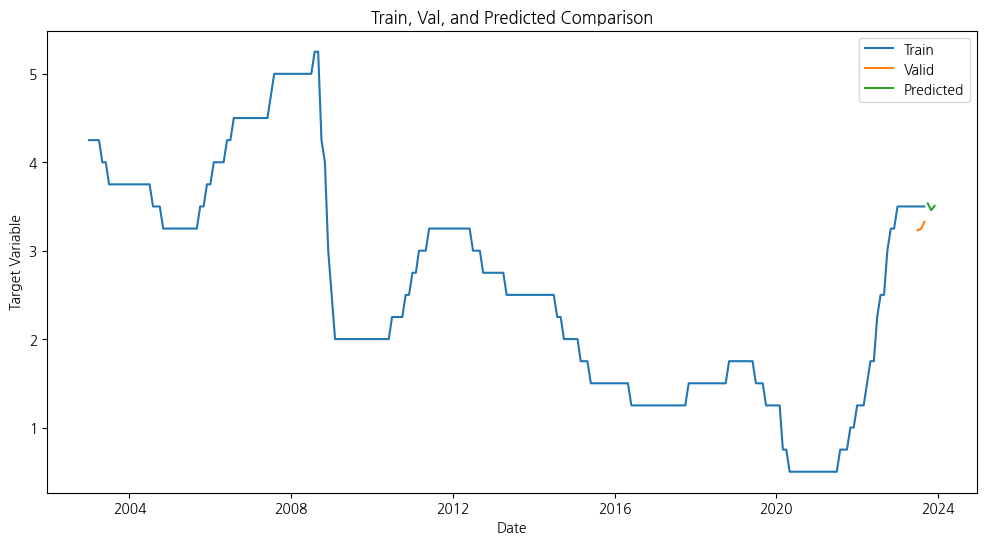

In [ ]:
# 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data['기준금리'], label='Train')
plt.plot(results_v3.index, results_v3['Val'], label='Valid')
plt.plot(results3.index, results3['Predicted'], label='Predicted')
plt.title('Train, Val, and Predicted Comparison')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

## 6개월

### 3-1) VECM 모델 훈련

In [ ]:
# train 데이터로 모델 훈련
modelV = VECM(df_diff, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = modelV.fit()

In [ ]:
# 미래의 독립변수 예측
future_steps = 6  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, :-1]

In [ ]:
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum(axis=0) + np.array(imp.iloc[-1,:]).reshape(1,-1)

# 미래의 독립변수 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[[5.04358431 4.51091463 4.41187606 1.00313957 0.90690366 1.00482947
  1.01592572 0.81478286 0.89657537 1.00499643 0.90889733 0.45042535
  0.73082424 0.04044208 0.80056679 0.27664742 4.66297071 0.9844899 ]
 [5.15561871 4.73399023 4.61238243 1.00428402 0.90189669 1.00967147
  1.00397017 0.81307856 0.89728565 0.99202362 0.8597815  0.46367999
  0.71322106 0.04180336 0.81853515 0.38098082 4.85688409 0.98377351]
 [5.14743029 4.77979332 4.68440432 1.00740865 0.89473617 1.01345349
  1.01263864 0.81457033 0.90965397 1.0092433  0.90924148 0.46573949
  0.7066891  0.044159   0.83193691 0.44056547 4.92435304 0.9834601 ]
 [5.05473244 4.69713948 4.6510202  1.0109704  0.91215666 1.01732551
  1.00895286 0.82626226 0.92201308 1.00195593 0.86820989 0.50046885
  0.706951   0.04042745 0.84861025 0.49155225 4.92613696 1.00630836]
 [5.13121043 4.78045227 4.73365492 1.01562472 0.92906467 1.02089265
  1.00898808 0.83295487 0.92458643 1.00098049 0.89875114 0.47631572
  0.71175

### 3-2) 독립변수 생성

In [ ]:
idx = pd.date_range(start='2023-10-01', periods=future_steps, freq='MS')
future_df6 = pd.DataFrame(data=future_forecast, columns=imp.columns, index=idx)

In [ ]:
future_df6

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원)
2023-10-01,5.043584,4.510915,4.411876,1.003140,0.906904,1.004829,1.015926,0.814783,0.896575,1.004996,0.908897,0.450425,0.730824,0.040442,0.800567,0.276647,4.662971,0.984490
2023-11-01,5.155619,4.733990,4.612382,1.004284,0.901897,1.009671,1.003970,0.813079,0.897286,0.992024,0.859782,0.463680,0.713221,0.041803,0.818535,0.380981,4.856884,0.983774
2023-12-01,5.147430,4.779793,4.684404,1.007409,0.894736,1.013453,1.012639,0.814570,0.909654,1.009243,0.909241,0.465739,0.706689,0.044159,0.831937,0.440565,4.924353,0.983460
2024-01-01,5.054732,4.697139,4.651020,1.010970,0.912157,1.017326,1.008953,0.826262,0.922013,1.001956,0.868210,0.500469,0.706951,0.040427,0.848610,0.491552,4.926137,1.006308
2024-02-01,5.131210,4.780452,4.733655,1.015625,0.929065,1.020893,1.008988,0.832955,0.924586,1.000980,0.898751,0.476316,0.711759,0.036172,0.840146,0.478164,5.004605,1.002871
2024-03-01,5.149210,4.782960,4.709681,1.019362,0.933244,1.025035,1.007728,0.835363,0.925886,0.999690,0.871369,0.486888,0.712730,0.034549,0.847702,0.439876,4.980541,1.013573


### 3-3) 데이터 LSTM으로 형태변환

In [ ]:
# X와 y로 분리
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset.iloc[i:(i + time_steps), :-1]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_steps, -1])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
train_time = -6
X_train, y_train = create_dataset(all_data.iloc[:train_time,:], time_steps)
X_val, y_val = create_dataset(all_data.iloc[train_time-1:,:], time_steps)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((242, 1, 18), (242,), (6, 1, 18), (6,))

### 3-4) LSTM모델 훈련

In [ ]:
# LSTM 모델 생성
modelL = Sequential()
modelL.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
modelL.add(Dropout(0.3))

modelL.add(Dense(16))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(8))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(1))
modelL.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

### 씨드 고정해야함
modelL.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/300
16/16 - 4s - loss: 9.0335 - val_loss: 13.9053 - 4s/epoch - 256ms/step
Epoch 2/300
16/16 - 0s - loss: 8.5254 - val_loss: 12.9129 - 119ms/epoch - 7ms/step
Epoch 3/300
16/16 - 0s - loss: 7.6829 - val_loss: 11.9376 - 112ms/epoch - 7ms/step
Epoch 4/300
16/16 - 0s - loss: 7.6445 - val_loss: 11.2596 - 116ms/epoch - 7ms/step
Epoch 5/300
16/16 - 0s - loss: 6.7990 - val_loss: 10.8309 - 109ms/epoch - 7ms/step
Epoch 6/300
16/16 - 0s - loss: 6.3846 - val_loss: 10.4540 - 127ms/epoch - 8ms/step
Epoch 7/300
16/16 - 0s - loss: 5.8382 - val_loss: 9.8056 - 102ms/epoch - 6ms/step
Epoch 8/300
16/16 - 0s - loss: 6.2550 - val_loss: 9.0710 - 103ms/epoch - 6ms/step
Epoch 9/300
16/16 - 0s - loss: 5.5340 - val_loss: 8.1289 - 103ms/epoch - 6ms/step
Epoch 10/300
16/16 - 0s - loss: 5.0681 - val_loss: 7.6552 - 105ms/epoch - 7ms/step
Epoch 11/300
16/16 - 0s - loss: 4.9266 - val_loss: 7.3107 - 109ms/epoch - 7ms/step
Epoch 12/300
16/16 - 0s - loss: 5.1628 - val_loss: 6.9794 - 116ms/epoch - 7ms/step
Epoch 13

In [ ]:
val_pred = modelL.predict(X_val)

1/1 [==============================] - 0s 475ms/step


In [ ]:
future_date = future_steps
results_v6 = pd.DataFrame({'Val':val_pred.reshape(-1)}, index=all_data.index[-future_date:])
results_v6

,Val
날짜,
2023-04-01,2.937757
2023-05-01,2.952069
2023-06-01,3.053234
2023-07-01,3.195577
2023-08-01,3.189868
2023-09-01,3.304645


### 3-5) 기준금리 예측

In [ ]:
f_x_train, f_y_train = create_dataset(all_data, time_steps)
modelL.fit(f_x_train, f_y_train, epochs=500, batch_size=16, verbose=2, callbacks=[early_stopping])

Epoch 1/500


16/16 - 0s - loss: 0.7889 - 54ms/epoch - 3ms/step
Epoch 2/500


16/16 - 0s - loss: 0.7985 - 50ms/epoch - 3ms/step
Epoch 3/500


16/16 - 0s - loss: 0.7806 - 49ms/epoch - 3ms/step
Epoch 4/500


16/16 - 0s - loss: 0.8663 - 52ms/epoch - 3ms/step
Epoch 5/500


16/16 - 0s - loss: 0.7197 - 50ms/epoch - 3ms/step
Epoch 6/500


16/16 - 0s - loss: 0.6881 - 50ms/epoch - 3ms/step
Epoch 7/500


16/16 - 0s - loss: 0.7568 - 53ms/epoch - 3ms/step
Epoch 8/500


16/16 - 0s - loss: 0.8305 - 53ms/epoch - 3ms/step
Epoch 9/500


16/16 - 0s - loss: 0.8470 - 56ms/epoch - 3ms/step
Epoch 10/500


16/16 - 0s - loss: 0.8151 - 62ms/epoch - 4ms/step
Epoch 11/500


16/16 - 0s - loss: 0.7161 - 55ms/epoch - 3ms/step
Epoch 12/500


16/16 - 0s - loss: 0.6613 - 52ms/epoch - 3ms/step
Epoch 13/500


16/16 - 0s - loss: 0.6725 - 51ms/epoch - 3ms/step
Epoch 14/500


16/16 - 0s - loss: 0.8658 - 58ms/epoch - 4ms/step
Epoch 15/500


16/16 - 0s - loss: 0.8258 - 52ms/epoch - 3ms/step
Epoch 16/500


16/16 - 0s - loss: 0.8014 - 59ms/epoch - 4ms/step
Epoch 17/500


16/16 - 0s - loss: 0.6845 - 56ms/epoch - 4ms/step
Epoch 18/500


16/16 - 0s - loss: 0.6287 - 53ms/epoch - 3ms/step
Epoch 19/500


16/16 - 0s - loss: 0.7227 - 51ms/epoch - 3ms/step
Epoch 20/500


16/16 - 0s - loss: 0.7024 - 50ms/epoch - 3ms/step
Epoch 21/500


16/16 - 0s - loss: 0.5723 - 49ms/epoch - 3ms/step
Epoch 22/500


16/16 - 0s - loss: 0.6306 - 49ms/epoch - 3ms/step
Epoch 23/500


16/16 - 0s - loss: 0.5999 - 55ms/epoch - 3ms/step
Epoch 24/500


16/16 - 0s - loss: 0.6764 - 53ms/epoch - 3ms/step
Epoch 25/500


16/16 - 0s - loss: 0.6369 - 51ms/epoch - 3ms/step
Epoch 26/500


16/16 - 0s - loss: 0.6071 - 57ms/epoch - 4ms/step
Epoch 27/500


16/16 - 0s - loss: 0.6604 - 57ms/epoch - 4ms/step
Epoch 28/500


16/16 - 0s - loss: 0.6236 - 50ms/epoch - 3ms/step
Epoch 29/500


16/16 - 0s - loss: 0.7161 - 65ms/epoch - 4ms/step
Epoch 30/500


16/16 - 0s - loss: 0.7307 - 53ms/epoch - 3ms/step
Epoch 31/500


16/16 - 0s - loss: 0.7579 - 52ms/epoch - 3ms/step
Epoch 32/500


16/16 - 0s - loss: 0.6050 - 54ms/epoch - 3ms/step
Epoch 33/500


16/16 - 0s - loss: 0.8111 - 53ms/epoch - 3ms/step
Epoch 34/500


16/16 - 0s - loss: 0.7854 - 51ms/epoch - 3ms/step
Epoch 35/500


16/16 - 0s - loss: 0.6960 - 52ms/epoch - 3ms/step
Epoch 36/500


16/16 - 0s - loss: 0.6528 - 51ms/epoch - 3ms/step
Epoch 37/500


16/16 - 0s - loss: 0.6416 - 48ms/epoch - 3ms/step
Epoch 38/500


16/16 - 0s - loss: 0.7629 - 47ms/epoch - 3ms/step
Epoch 39/500


16/16 - 0s - loss: 0.5467 - 50ms/epoch - 3ms/step
Epoch 40/500


16/16 - 0s - loss: 0.6413 - 47ms/epoch - 3ms/step
Epoch 41/500


16/16 - 0s - loss: 0.5933 - 48ms/epoch - 3ms/step
Epoch 42/500


16/16 - 0s - loss: 0.6812 - 66ms/epoch - 4ms/step
Epoch 43/500


16/16 - 0s - loss: 0.5544 - 64ms/epoch - 4ms/step
Epoch 44/500


16/16 - 0s - loss: 0.6954 - 74ms/epoch - 5ms/step
Epoch 45/500


16/16 - 0s - loss: 0.5724 - 68ms/epoch - 4ms/step
Epoch 46/500


16/16 - 0s - loss: 0.6495 - 72ms/epoch - 4ms/step
Epoch 47/500


16/16 - 0s - loss: 0.6200 - 71ms/epoch - 4ms/step
Epoch 48/500


16/16 - 0s - loss: 0.7037 - 66ms/epoch - 4ms/step
Epoch 49/500


16/16 - 0s - loss: 0.6355 - 78ms/epoch - 5ms/step
Epoch 50/500


16/16 - 0s - loss: 0.6416 - 73ms/epoch - 5ms/step
Epoch 51/500


16/16 - 0s - loss: 0.7120 - 83ms/epoch - 5ms/step
Epoch 52/500


16/16 - 0s - loss: 0.6140 - 73ms/epoch - 5ms/step
Epoch 53/500


16/16 - 0s - loss: 0.7461 - 75ms/epoch - 5ms/step
Epoch 54/500


16/16 - 0s - loss: 0.6468 - 67ms/epoch - 4ms/step
Epoch 55/500


16/16 - 0s - loss: 0.6904 - 65ms/epoch - 4ms/step
Epoch 56/500


16/16 - 0s - loss: 0.5727 - 71ms/epoch - 4ms/step
Epoch 57/500


16/16 - 0s - loss: 0.5888 - 70ms/epoch - 4ms/step
Epoch 58/500


16/16 - 0s - loss: 0.6739 - 70ms/epoch - 4ms/step
Epoch 59/500


16/16 - 0s - loss: 0.5697 - 75ms/epoch - 5ms/step
Epoch 60/500


16/16 - 0s - loss: 0.5911 - 69ms/epoch - 4ms/step
Epoch 61/500


16/16 - 0s - loss: 0.6132 - 72ms/epoch - 5ms/step
Epoch 62/500


16/16 - 0s - loss: 0.7209 - 72ms/epoch - 5ms/step
Epoch 63/500


16/16 - 0s - loss: 0.5855 - 70ms/epoch - 4ms/step
Epoch 64/500


16/16 - 0s - loss: 0.6322 - 69ms/epoch - 4ms/step
Epoch 65/500


16/16 - 0s - loss: 0.7432 - 67ms/epoch - 4ms/step
Epoch 66/500


16/16 - 0s - loss: 0.6761 - 69ms/epoch - 4ms/step
Epoch 67/500


16/16 - 0s - loss: 0.5530 - 70ms/epoch - 4ms/step
Epoch 68/500


16/16 - 0s - loss: 0.7070 - 68ms/epoch - 4ms/step
Epoch 69/500


16/16 - 0s - loss: 0.6716 - 70ms/epoch - 4ms/step
Epoch 70/500


16/16 - 0s - loss: 0.6341 - 73ms/epoch - 5ms/step
Epoch 71/500


16/16 - 0s - loss: 0.6578 - 70ms/epoch - 4ms/step
Epoch 72/500


16/16 - 0s - loss: 0.5530 - 68ms/epoch - 4ms/step
Epoch 73/500


16/16 - 0s - loss: 0.6006 - 79ms/epoch - 5ms/step
Epoch 74/500


16/16 - 0s - loss: 0.6563 - 80ms/epoch - 5ms/step
Epoch 75/500


16/16 - 0s - loss: 0.6894 - 83ms/epoch - 5ms/step
Epoch 76/500


16/16 - 0s - loss: 0.6584 - 71ms/epoch - 4ms/step
Epoch 77/500


16/16 - 0s - loss: 0.5953 - 75ms/epoch - 5ms/step
Epoch 78/500


16/16 - 0s - loss: 0.5904 - 78ms/epoch - 5ms/step
Epoch 79/500


16/16 - 0s - loss: 0.5649 - 70ms/epoch - 4ms/step
Epoch 80/500


16/16 - 0s - loss: 0.5813 - 69ms/epoch - 4ms/step
Epoch 81/500


16/16 - 0s - loss: 0.6220 - 69ms/epoch - 4ms/step
Epoch 82/500


16/16 - 0s - loss: 0.4568 - 70ms/epoch - 4ms/step
Epoch 83/500


16/16 - 0s - loss: 0.6049 - 72ms/epoch - 4ms/step
Epoch 84/500


16/16 - 0s - loss: 0.5208 - 73ms/epoch - 5ms/step
Epoch 85/500


16/16 - 0s - loss: 0.6407 - 74ms/epoch - 5ms/step
Epoch 86/500


16/16 - 0s - loss: 0.5118 - 76ms/epoch - 5ms/step
Epoch 87/500


16/16 - 0s - loss: 0.6153 - 74ms/epoch - 5ms/step
Epoch 88/500


16/16 - 0s - loss: 0.5660 - 74ms/epoch - 5ms/step
Epoch 89/500


16/16 - 0s - loss: 0.6515 - 73ms/epoch - 5ms/step
Epoch 90/500


16/16 - 0s - loss: 0.5631 - 71ms/epoch - 4ms/step
Epoch 91/500


16/16 - 0s - loss: 0.5675 - 70ms/epoch - 4ms/step
Epoch 92/500


16/16 - 0s - loss: 0.4886 - 74ms/epoch - 5ms/step
Epoch 93/500


16/16 - 0s - loss: 0.6105 - 67ms/epoch - 4ms/step
Epoch 94/500


16/16 - 0s - loss: 0.4825 - 74ms/epoch - 5ms/step
Epoch 95/500


16/16 - 0s - loss: 0.5535 - 71ms/epoch - 4ms/step
Epoch 96/500


16/16 - 0s - loss: 0.5427 - 70ms/epoch - 4ms/step
Epoch 97/500


16/16 - 0s - loss: 0.5708 - 82ms/epoch - 5ms/step
Epoch 98/500


16/16 - 0s - loss: 0.5941 - 77ms/epoch - 5ms/step
Epoch 99/500


16/16 - 0s - loss: 0.5998 - 78ms/epoch - 5ms/step
Epoch 100/500


16/16 - 0s - loss: 0.4190 - 79ms/epoch - 5ms/step
Epoch 101/500


16/16 - 0s - loss: 0.5038 - 70ms/epoch - 4ms/step
Epoch 102/500


16/16 - 0s - loss: 0.5152 - 76ms/epoch - 5ms/step
Epoch 103/500


16/16 - 0s - loss: 0.7038 - 79ms/epoch - 5ms/step
Epoch 104/500


16/16 - 0s - loss: 0.5283 - 71ms/epoch - 4ms/step
Epoch 105/500


16/16 - 0s - loss: 0.6592 - 71ms/epoch - 4ms/step
Epoch 106/500


16/16 - 0s - loss: 0.5163 - 74ms/epoch - 5ms/step
Epoch 107/500


16/16 - 0s - loss: 0.5471 - 84ms/epoch - 5ms/step
Epoch 108/500


16/16 - 0s - loss: 0.5865 - 87ms/epoch - 5ms/step
Epoch 109/500


16/16 - 0s - loss: 0.6029 - 75ms/epoch - 5ms/step
Epoch 110/500


16/16 - 0s - loss: 0.5117 - 81ms/epoch - 5ms/step
Epoch 111/500


16/16 - 0s - loss: 0.5875 - 70ms/epoch - 4ms/step
Epoch 112/500


16/16 - 0s - loss: 0.5567 - 73ms/epoch - 5ms/step
Epoch 113/500


16/16 - 0s - loss: 0.4089 - 87ms/epoch - 5ms/step
Epoch 114/500


16/16 - 0s - loss: 0.5266 - 87ms/epoch - 5ms/step
Epoch 115/500


16/16 - 0s - loss: 0.5057 - 92ms/epoch - 6ms/step
Epoch 116/500


16/16 - 0s - loss: 0.5523 - 82ms/epoch - 5ms/step
Epoch 117/500


16/16 - 0s - loss: 0.5137 - 73ms/epoch - 5ms/step
Epoch 118/500


16/16 - 0s - loss: 0.5823 - 74ms/epoch - 5ms/step
Epoch 119/500


16/16 - 0s - loss: 0.4732 - 70ms/epoch - 4ms/step
Epoch 120/500


16/16 - 0s - loss: 0.4641 - 84ms/epoch - 5ms/step
Epoch 121/500


16/16 - 0s - loss: 0.5121 - 71ms/epoch - 4ms/step
Epoch 122/500


16/16 - 0s - loss: 0.5196 - 70ms/epoch - 4ms/step
Epoch 123/500


16/16 - 0s - loss: 0.4574 - 85ms/epoch - 5ms/step
Epoch 124/500


16/16 - 0s - loss: 0.4535 - 81ms/epoch - 5ms/step
Epoch 125/500


16/16 - 0s - loss: 0.5353 - 80ms/epoch - 5ms/step
Epoch 126/500


16/16 - 0s - loss: 0.5354 - 79ms/epoch - 5ms/step
Epoch 127/500


16/16 - 0s - loss: 0.5708 - 65ms/epoch - 4ms/step
Epoch 128/500


16/16 - 0s - loss: 0.5975 - 65ms/epoch - 4ms/step
Epoch 129/500


16/16 - 0s - loss: 0.5162 - 66ms/epoch - 4ms/step
Epoch 130/500


16/16 - 0s - loss: 0.5406 - 65ms/epoch - 4ms/step
Epoch 131/500


16/16 - 0s - loss: 0.5336 - 68ms/epoch - 4ms/step
Epoch 132/500


16/16 - 0s - loss: 0.4529 - 67ms/epoch - 4ms/step
Epoch 133/500


16/16 - 0s - loss: 0.4728 - 67ms/epoch - 4ms/step
Epoch 134/500


16/16 - 0s - loss: 0.4805 - 74ms/epoch - 5ms/step
Epoch 135/500


16/16 - 0s - loss: 0.5063 - 76ms/epoch - 5ms/step
Epoch 136/500


16/16 - 0s - loss: 0.4049 - 73ms/epoch - 5ms/step
Epoch 137/500


16/16 - 0s - loss: 0.5812 - 67ms/epoch - 4ms/step
Epoch 138/500


16/16 - 0s - loss: 0.4045 - 87ms/epoch - 5ms/step
Epoch 139/500


16/16 - 0s - loss: 0.6059 - 82ms/epoch - 5ms/step
Epoch 140/500


16/16 - 0s - loss: 0.4971 - 89ms/epoch - 6ms/step
Epoch 141/500


16/16 - 0s - loss: 0.6543 - 73ms/epoch - 5ms/step
Epoch 142/500


16/16 - 0s - loss: 0.5524 - 70ms/epoch - 4ms/step
Epoch 143/500


16/16 - 0s - loss: 0.4880 - 67ms/epoch - 4ms/step
Epoch 144/500


16/16 - 0s - loss: 0.4988 - 79ms/epoch - 5ms/step
Epoch 145/500


16/16 - 0s - loss: 0.5152 - 62ms/epoch - 4ms/step
Epoch 146/500


16/16 - 0s - loss: 0.4272 - 53ms/epoch - 3ms/step
Epoch 147/500


16/16 - 0s - loss: 0.4707 - 58ms/epoch - 4ms/step
Epoch 148/500


16/16 - 0s - loss: 0.4601 - 54ms/epoch - 3ms/step
Epoch 149/500


16/16 - 0s - loss: 0.5344 - 53ms/epoch - 3ms/step
Epoch 150/500


16/16 - 0s - loss: 0.4135 - 50ms/epoch - 3ms/step
Epoch 151/500


16/16 - 0s - loss: 0.5409 - 63ms/epoch - 4ms/step
Epoch 152/500


16/16 - 0s - loss: 0.4474 - 57ms/epoch - 4ms/step
Epoch 153/500


16/16 - 0s - loss: 0.4208 - 51ms/epoch - 3ms/step
Epoch 154/500


16/16 - 0s - loss: 0.4481 - 55ms/epoch - 3ms/step
Epoch 155/500


16/16 - 0s - loss: 0.5648 - 58ms/epoch - 4ms/step
Epoch 156/500


16/16 - 0s - loss: 0.4967 - 59ms/epoch - 4ms/step
Epoch 157/500


16/16 - 0s - loss: 0.5173 - 51ms/epoch - 3ms/step
Epoch 158/500


16/16 - 0s - loss: 0.5119 - 53ms/epoch - 3ms/step
Epoch 159/500


16/16 - 0s - loss: 0.4865 - 52ms/epoch - 3ms/step
Epoch 160/500


16/16 - 0s - loss: 0.4882 - 51ms/epoch - 3ms/step
Epoch 161/500


16/16 - 0s - loss: 0.4862 - 52ms/epoch - 3ms/step
Epoch 162/500


16/16 - 0s - loss: 0.4528 - 51ms/epoch - 3ms/step
Epoch 163/500


16/16 - 0s - loss: 0.4710 - 61ms/epoch - 4ms/step
Epoch 164/500


16/16 - 0s - loss: 0.4863 - 55ms/epoch - 3ms/step
Epoch 165/500


16/16 - 0s - loss: 0.4586 - 52ms/epoch - 3ms/step
Epoch 166/500


16/16 - 0s - loss: 0.4301 - 60ms/epoch - 4ms/step
Epoch 167/500


16/16 - 0s - loss: 0.3638 - 61ms/epoch - 4ms/step
Epoch 168/500


16/16 - 0s - loss: 0.6419 - 54ms/epoch - 3ms/step
Epoch 169/500


16/16 - 0s - loss: 0.5421 - 56ms/epoch - 3ms/step
Epoch 170/500


16/16 - 0s - loss: 0.4870 - 54ms/epoch - 3ms/step
Epoch 171/500


16/16 - 0s - loss: 0.4990 - 53ms/epoch - 3ms/step
Epoch 172/500


16/16 - 0s - loss: 0.4364 - 62ms/epoch - 4ms/step
Epoch 173/500


16/16 - 0s - loss: 0.5078 - 54ms/epoch - 3ms/step
Epoch 174/500


16/16 - 0s - loss: 0.4305 - 47ms/epoch - 3ms/step
Epoch 175/500


16/16 - 0s - loss: 0.5264 - 57ms/epoch - 4ms/step
Epoch 176/500


16/16 - 0s - loss: 0.4618 - 54ms/epoch - 3ms/step
Epoch 177/500


16/16 - 0s - loss: 0.4620 - 52ms/epoch - 3ms/step
Epoch 178/500


16/16 - 0s - loss: 0.5442 - 49ms/epoch - 3ms/step
Epoch 179/500


16/16 - 0s - loss: 0.4958 - 55ms/epoch - 3ms/step
Epoch 180/500


16/16 - 0s - loss: 0.3687 - 59ms/epoch - 4ms/step
Epoch 181/500


16/16 - 0s - loss: 0.5262 - 57ms/epoch - 4ms/step
Epoch 182/500


16/16 - 0s - loss: 0.4276 - 58ms/epoch - 4ms/step
Epoch 183/500


16/16 - 0s - loss: 0.4065 - 54ms/epoch - 3ms/step
Epoch 184/500


16/16 - 0s - loss: 0.5090 - 54ms/epoch - 3ms/step
Epoch 185/500


16/16 - 0s - loss: 0.4658 - 61ms/epoch - 4ms/step
Epoch 186/500


16/16 - 0s - loss: 0.5154 - 63ms/epoch - 4ms/step
Epoch 187/500


16/16 - 0s - loss: 0.4951 - 57ms/epoch - 4ms/step
Epoch 188/500


16/16 - 0s - loss: 0.4938 - 58ms/epoch - 4ms/step
Epoch 189/500


16/16 - 0s - loss: 0.5124 - 61ms/epoch - 4ms/step
Epoch 190/500


16/16 - 0s - loss: 0.5148 - 51ms/epoch - 3ms/step
Epoch 191/500


16/16 - 0s - loss: 0.4820 - 58ms/epoch - 4ms/step
Epoch 192/500


16/16 - 0s - loss: 0.4079 - 53ms/epoch - 3ms/step
Epoch 193/500


16/16 - 0s - loss: 0.4757 - 53ms/epoch - 3ms/step
Epoch 194/500


16/16 - 0s - loss: 0.4454 - 51ms/epoch - 3ms/step
Epoch 195/500


16/16 - 0s - loss: 0.3557 - 51ms/epoch - 3ms/step
Epoch 196/500


16/16 - 0s - loss: 0.4942 - 63ms/epoch - 4ms/step
Epoch 197/500


16/16 - 0s - loss: 0.5272 - 58ms/epoch - 4ms/step
Epoch 198/500


16/16 - 0s - loss: 0.4730 - 52ms/epoch - 3ms/step
Epoch 199/500


16/16 - 0s - loss: 0.4448 - 54ms/epoch - 3ms/step
Epoch 200/500


16/16 - 0s - loss: 0.5263 - 54ms/epoch - 3ms/step
Epoch 201/500


16/16 - 0s - loss: 0.4768 - 53ms/epoch - 3ms/step
Epoch 202/500


16/16 - 0s - loss: 0.3998 - 54ms/epoch - 3ms/step
Epoch 203/500


16/16 - 0s - loss: 0.4460 - 55ms/epoch - 3ms/step
Epoch 204/500


16/16 - 0s - loss: 0.3756 - 58ms/epoch - 4ms/step
Epoch 205/500


16/16 - 0s - loss: 0.4648 - 53ms/epoch - 3ms/step
Epoch 206/500


16/16 - 0s - loss: 0.4755 - 57ms/epoch - 4ms/step
Epoch 207/500


16/16 - 0s - loss: 0.4513 - 51ms/epoch - 3ms/step
Epoch 208/500


16/16 - 0s - loss: 0.4466 - 56ms/epoch - 3ms/step
Epoch 209/500


16/16 - 0s - loss: 0.5401 - 57ms/epoch - 4ms/step
Epoch 210/500


16/16 - 0s - loss: 0.4272 - 54ms/epoch - 3ms/step
Epoch 211/500


16/16 - 0s - loss: 0.4621 - 55ms/epoch - 3ms/step
Epoch 212/500


16/16 - 0s - loss: 0.5192 - 55ms/epoch - 3ms/step
Epoch 213/500


16/16 - 0s - loss: 0.4571 - 51ms/epoch - 3ms/step
Epoch 214/500


16/16 - 0s - loss: 0.5158 - 57ms/epoch - 4ms/step
Epoch 215/500


16/16 - 0s - loss: 0.4442 - 58ms/epoch - 4ms/step
Epoch 216/500


16/16 - 0s - loss: 0.4149 - 58ms/epoch - 4ms/step
Epoch 217/500


16/16 - 0s - loss: 0.4772 - 59ms/epoch - 4ms/step
Epoch 218/500


16/16 - 0s - loss: 0.4697 - 58ms/epoch - 4ms/step
Epoch 219/500


16/16 - 0s - loss: 0.5557 - 62ms/epoch - 4ms/step
Epoch 220/500


16/16 - 0s - loss: 0.3580 - 59ms/epoch - 4ms/step
Epoch 221/500


16/16 - 0s - loss: 0.5010 - 60ms/epoch - 4ms/step
Epoch 222/500


16/16 - 0s - loss: 0.4298 - 64ms/epoch - 4ms/step
Epoch 223/500


16/16 - 0s - loss: 0.4790 - 54ms/epoch - 3ms/step
Epoch 224/500


16/16 - 0s - loss: 0.4296 - 55ms/epoch - 3ms/step
Epoch 225/500


16/16 - 0s - loss: 0.3901 - 53ms/epoch - 3ms/step
Epoch 226/500


16/16 - 0s - loss: 0.4369 - 54ms/epoch - 3ms/step
Epoch 227/500


16/16 - 0s - loss: 0.4351 - 57ms/epoch - 4ms/step
Epoch 228/500


16/16 - 0s - loss: 0.4461 - 58ms/epoch - 4ms/step
Epoch 229/500


16/16 - 0s - loss: 0.3819 - 61ms/epoch - 4ms/step
Epoch 230/500


16/16 - 0s - loss: 0.4288 - 61ms/epoch - 4ms/step
Epoch 231/500


16/16 - 0s - loss: 0.5351 - 58ms/epoch - 4ms/step
Epoch 232/500


16/16 - 0s - loss: 0.3849 - 61ms/epoch - 4ms/step
Epoch 233/500


16/16 - 0s - loss: 0.3865 - 59ms/epoch - 4ms/step
Epoch 234/500


16/16 - 0s - loss: 0.4719 - 54ms/epoch - 3ms/step
Epoch 235/500


16/16 - 0s - loss: 0.4225 - 59ms/epoch - 4ms/step
Epoch 236/500


16/16 - 0s - loss: 0.4973 - 57ms/epoch - 4ms/step
Epoch 237/500


16/16 - 0s - loss: 0.3981 - 55ms/epoch - 3ms/step
Epoch 238/500


16/16 - 0s - loss: 0.4903 - 59ms/epoch - 4ms/step
Epoch 239/500


16/16 - 0s - loss: 0.5485 - 57ms/epoch - 4ms/step
Epoch 240/500


16/16 - 0s - loss: 0.4534 - 53ms/epoch - 3ms/step
Epoch 241/500


16/16 - 0s - loss: 0.4812 - 55ms/epoch - 3ms/step
Epoch 242/500


16/16 - 0s - loss: 0.4310 - 59ms/epoch - 4ms/step
Epoch 243/500


16/16 - 0s - loss: 0.3831 - 56ms/epoch - 3ms/step
Epoch 244/500


16/16 - 0s - loss: 0.4217 - 60ms/epoch - 4ms/step
Epoch 245/500


16/16 - 0s - loss: 0.4228 - 64ms/epoch - 4ms/step
Epoch 246/500


16/16 - 0s - loss: 0.3645 - 61ms/epoch - 4ms/step
Epoch 247/500


16/16 - 0s - loss: 0.4215 - 59ms/epoch - 4ms/step
Epoch 248/500


16/16 - 0s - loss: 0.4527 - 63ms/epoch - 4ms/step
Epoch 249/500


16/16 - 0s - loss: 0.4433 - 60ms/epoch - 4ms/step
Epoch 250/500


16/16 - 0s - loss: 0.4362 - 60ms/epoch - 4ms/step
Epoch 251/500


16/16 - 0s - loss: 0.4133 - 62ms/epoch - 4ms/step
Epoch 252/500


16/16 - 0s - loss: 0.4948 - 58ms/epoch - 4ms/step
Epoch 253/500


16/16 - 0s - loss: 0.4766 - 57ms/epoch - 4ms/step
Epoch 254/500


16/16 - 0s - loss: 0.4125 - 56ms/epoch - 4ms/step
Epoch 255/500


16/16 - 0s - loss: 0.4599 - 63ms/epoch - 4ms/step
Epoch 256/500


16/16 - 0s - loss: 0.4608 - 55ms/epoch - 3ms/step
Epoch 257/500


16/16 - 0s - loss: 0.3632 - 53ms/epoch - 3ms/step
Epoch 258/500


16/16 - 0s - loss: 0.5264 - 65ms/epoch - 4ms/step
Epoch 259/500


16/16 - 0s - loss: 0.4681 - 57ms/epoch - 4ms/step
Epoch 260/500


16/16 - 0s - loss: 0.4880 - 58ms/epoch - 4ms/step
Epoch 261/500


16/16 - 0s - loss: 0.4129 - 54ms/epoch - 3ms/step
Epoch 262/500


16/16 - 0s - loss: 0.4322 - 60ms/epoch - 4ms/step
Epoch 263/500


16/16 - 0s - loss: 0.4526 - 59ms/epoch - 4ms/step
Epoch 264/500


16/16 - 0s - loss: 0.4329 - 55ms/epoch - 3ms/step
Epoch 265/500


16/16 - 0s - loss: 0.4443 - 60ms/epoch - 4ms/step
Epoch 266/500


16/16 - 0s - loss: 0.4408 - 55ms/epoch - 3ms/step
Epoch 267/500


16/16 - 0s - loss: 0.3202 - 64ms/epoch - 4ms/step
Epoch 268/500


16/16 - 0s - loss: 0.5286 - 60ms/epoch - 4ms/step
Epoch 269/500


16/16 - 0s - loss: 0.3678 - 57ms/epoch - 4ms/step
Epoch 270/500


16/16 - 0s - loss: 0.3981 - 52ms/epoch - 3ms/step
Epoch 271/500


16/16 - 0s - loss: 0.3748 - 71ms/epoch - 4ms/step
Epoch 272/500


16/16 - 0s - loss: 0.3994 - 62ms/epoch - 4ms/step
Epoch 273/500


16/16 - 0s - loss: 0.3853 - 67ms/epoch - 4ms/step
Epoch 274/500


16/16 - 0s - loss: 0.4085 - 60ms/epoch - 4ms/step
Epoch 275/500


16/16 - 0s - loss: 0.3822 - 56ms/epoch - 4ms/step
Epoch 276/500


16/16 - 0s - loss: 0.3986 - 56ms/epoch - 4ms/step
Epoch 277/500


16/16 - 0s - loss: 0.4955 - 64ms/epoch - 4ms/step
Epoch 278/500


16/16 - 0s - loss: 0.4016 - 56ms/epoch - 4ms/step
Epoch 279/500


16/16 - 0s - loss: 0.4363 - 58ms/epoch - 4ms/step
Epoch 280/500


16/16 - 0s - loss: 0.4033 - 58ms/epoch - 4ms/step
Epoch 281/500


16/16 - 0s - loss: 0.4419 - 55ms/epoch - 3ms/step
Epoch 282/500


16/16 - 0s - loss: 0.5298 - 60ms/epoch - 4ms/step
Epoch 283/500


16/16 - 0s - loss: 0.4338 - 56ms/epoch - 4ms/step
Epoch 284/500


16/16 - 0s - loss: 0.3836 - 63ms/epoch - 4ms/step
Epoch 285/500


16/16 - 0s - loss: 0.4448 - 60ms/epoch - 4ms/step
Epoch 286/500


16/16 - 0s - loss: 0.4134 - 60ms/epoch - 4ms/step
Epoch 287/500


16/16 - 0s - loss: 0.3408 - 71ms/epoch - 4ms/step
Epoch 288/500


16/16 - 0s - loss: 0.4324 - 55ms/epoch - 3ms/step
Epoch 289/500


16/16 - 0s - loss: 0.4323 - 64ms/epoch - 4ms/step
Epoch 290/500


16/16 - 0s - loss: 0.3901 - 69ms/epoch - 4ms/step
Epoch 291/500


16/16 - 0s - loss: 0.3759 - 54ms/epoch - 3ms/step
Epoch 292/500


16/16 - 0s - loss: 0.4192 - 56ms/epoch - 4ms/step
Epoch 293/500


16/16 - 0s - loss: 0.3619 - 55ms/epoch - 3ms/step
Epoch 294/500


16/16 - 0s - loss: 0.3241 - 57ms/epoch - 4ms/step
Epoch 295/500


16/16 - 0s - loss: 0.5126 - 59ms/epoch - 4ms/step
Epoch 296/500


16/16 - 0s - loss: 0.3761 - 58ms/epoch - 4ms/step
Epoch 297/500


16/16 - 0s - loss: 0.3990 - 59ms/epoch - 4ms/step
Epoch 298/500


16/16 - 0s - loss: 0.3576 - 61ms/epoch - 4ms/step
Epoch 299/500


16/16 - 0s - loss: 0.3588 - 58ms/epoch - 4ms/step
Epoch 300/500


16/16 - 0s - loss: 0.3591 - 63ms/epoch - 4ms/step
Epoch 301/500


16/16 - 0s - loss: 0.4392 - 58ms/epoch - 4ms/step
Epoch 302/500


16/16 - 0s - loss: 0.3796 - 63ms/epoch - 4ms/step
Epoch 303/500


16/16 - 0s - loss: 0.4661 - 58ms/epoch - 4ms/step
Epoch 304/500


16/16 - 0s - loss: 0.3631 - 74ms/epoch - 5ms/step
Epoch 305/500


16/16 - 0s - loss: 0.3701 - 87ms/epoch - 5ms/step
Epoch 306/500


16/16 - 0s - loss: 0.3823 - 89ms/epoch - 6ms/step
Epoch 307/500


16/16 - 0s - loss: 0.3418 - 75ms/epoch - 5ms/step
Epoch 308/500


16/16 - 0s - loss: 0.4017 - 81ms/epoch - 5ms/step
Epoch 309/500


16/16 - 0s - loss: 0.4552 - 75ms/epoch - 5ms/step
Epoch 310/500


16/16 - 0s - loss: 0.4343 - 66ms/epoch - 4ms/step
Epoch 311/500


16/16 - 0s - loss: 0.4442 - 72ms/epoch - 4ms/step
Epoch 312/500


16/16 - 0s - loss: 0.3026 - 74ms/epoch - 5ms/step
Epoch 313/500


16/16 - 0s - loss: 0.4121 - 74ms/epoch - 5ms/step
Epoch 314/500


16/16 - 0s - loss: 0.4089 - 73ms/epoch - 5ms/step
Epoch 315/500


16/16 - 0s - loss: 0.3758 - 71ms/epoch - 4ms/step
Epoch 316/500


16/16 - 0s - loss: 0.3573 - 79ms/epoch - 5ms/step
Epoch 317/500


16/16 - 0s - loss: 0.4889 - 71ms/epoch - 4ms/step
Epoch 318/500


16/16 - 0s - loss: 0.4380 - 71ms/epoch - 4ms/step
Epoch 319/500


16/16 - 0s - loss: 0.3703 - 70ms/epoch - 4ms/step
Epoch 320/500


16/16 - 0s - loss: 0.3232 - 77ms/epoch - 5ms/step
Epoch 321/500


16/16 - 0s - loss: 0.3576 - 71ms/epoch - 4ms/step
Epoch 322/500


16/16 - 0s - loss: 0.3375 - 73ms/epoch - 5ms/step
Epoch 323/500


16/16 - 0s - loss: 0.4028 - 93ms/epoch - 6ms/step
Epoch 324/500


16/16 - 0s - loss: 0.3974 - 80ms/epoch - 5ms/step
Epoch 325/500


16/16 - 0s - loss: 0.4086 - 73ms/epoch - 5ms/step
Epoch 326/500


16/16 - 0s - loss: 0.3992 - 70ms/epoch - 4ms/step
Epoch 327/500


16/16 - 0s - loss: 0.4697 - 67ms/epoch - 4ms/step
Epoch 328/500


16/16 - 0s - loss: 0.3300 - 66ms/epoch - 4ms/step
Epoch 329/500


16/16 - 0s - loss: 0.3809 - 75ms/epoch - 5ms/step
Epoch 330/500


16/16 - 0s - loss: 0.3197 - 74ms/epoch - 5ms/step
Epoch 331/500


16/16 - 0s - loss: 0.3421 - 66ms/epoch - 4ms/step
Epoch 332/500


16/16 - 0s - loss: 0.4601 - 77ms/epoch - 5ms/step
Epoch 333/500


16/16 - 0s - loss: 0.3764 - 75ms/epoch - 5ms/step
Epoch 334/500


16/16 - 0s - loss: 0.4400 - 79ms/epoch - 5ms/step
Epoch 335/500


16/16 - 0s - loss: 0.4016 - 87ms/epoch - 5ms/step
Epoch 336/500


16/16 - 0s - loss: 0.4132 - 75ms/epoch - 5ms/step
Epoch 337/500


16/16 - 0s - loss: 0.3893 - 76ms/epoch - 5ms/step
Epoch 338/500


16/16 - 0s - loss: 0.4299 - 73ms/epoch - 5ms/step
Epoch 339/500


16/16 - 0s - loss: 0.3215 - 70ms/epoch - 4ms/step
Epoch 340/500


16/16 - 0s - loss: 0.3828 - 70ms/epoch - 4ms/step
Epoch 341/500


16/16 - 0s - loss: 0.3516 - 73ms/epoch - 5ms/step
Epoch 342/500


16/16 - 0s - loss: 0.4182 - 73ms/epoch - 5ms/step
Epoch 343/500


16/16 - 0s - loss: 0.4217 - 92ms/epoch - 6ms/step
Epoch 344/500


16/16 - 0s - loss: 0.4085 - 79ms/epoch - 5ms/step
Epoch 345/500


16/16 - 0s - loss: 0.4087 - 71ms/epoch - 4ms/step
Epoch 346/500


16/16 - 0s - loss: 0.3541 - 78ms/epoch - 5ms/step
Epoch 347/500


16/16 - 0s - loss: 0.3228 - 76ms/epoch - 5ms/step
Epoch 348/500


16/16 - 0s - loss: 0.3649 - 83ms/epoch - 5ms/step
Epoch 349/500


16/16 - 0s - loss: 0.3686 - 76ms/epoch - 5ms/step
Epoch 350/500


16/16 - 0s - loss: 0.3368 - 81ms/epoch - 5ms/step
Epoch 351/500


16/16 - 0s - loss: 0.3651 - 77ms/epoch - 5ms/step
Epoch 352/500


16/16 - 0s - loss: 0.4062 - 73ms/epoch - 5ms/step
Epoch 353/500


16/16 - 0s - loss: 0.3512 - 78ms/epoch - 5ms/step
Epoch 354/500


16/16 - 0s - loss: 0.3912 - 75ms/epoch - 5ms/step
Epoch 355/500


16/16 - 0s - loss: 0.4064 - 66ms/epoch - 4ms/step
Epoch 356/500


16/16 - 0s - loss: 0.3596 - 86ms/epoch - 5ms/step
Epoch 357/500


16/16 - 0s - loss: 0.4089 - 71ms/epoch - 4ms/step
Epoch 358/500


16/16 - 0s - loss: 0.4563 - 82ms/epoch - 5ms/step
Epoch 359/500


16/16 - 0s - loss: 0.3797 - 81ms/epoch - 5ms/step
Epoch 360/500


16/16 - 0s - loss: 0.3531 - 94ms/epoch - 6ms/step
Epoch 361/500


16/16 - 0s - loss: 0.3542 - 77ms/epoch - 5ms/step
Epoch 362/500


16/16 - 0s - loss: 0.4586 - 92ms/epoch - 6ms/step
Epoch 363/500


16/16 - 0s - loss: 0.3271 - 76ms/epoch - 5ms/step
Epoch 364/500


16/16 - 0s - loss: 0.3970 - 78ms/epoch - 5ms/step
Epoch 365/500


16/16 - 0s - loss: 0.2978 - 69ms/epoch - 4ms/step
Epoch 366/500


16/16 - 0s - loss: 0.3965 - 68ms/epoch - 4ms/step
Epoch 367/500


16/16 - 0s - loss: 0.3675 - 68ms/epoch - 4ms/step
Epoch 368/500


16/16 - 0s - loss: 0.3633 - 66ms/epoch - 4ms/step
Epoch 369/500


16/16 - 0s - loss: 0.3513 - 76ms/epoch - 5ms/step
Epoch 370/500


16/16 - 0s - loss: 0.4232 - 82ms/epoch - 5ms/step
Epoch 371/500


16/16 - 0s - loss: 0.3513 - 70ms/epoch - 4ms/step
Epoch 372/500


16/16 - 0s - loss: 0.4386 - 70ms/epoch - 4ms/step
Epoch 373/500


16/16 - 0s - loss: 0.4189 - 83ms/epoch - 5ms/step
Epoch 374/500


16/16 - 0s - loss: 0.3788 - 73ms/epoch - 5ms/step
Epoch 375/500


16/16 - 0s - loss: 0.4073 - 68ms/epoch - 4ms/step
Epoch 376/500


16/16 - 0s - loss: 0.3637 - 69ms/epoch - 4ms/step
Epoch 377/500


16/16 - 0s - loss: 0.3185 - 72ms/epoch - 5ms/step
Epoch 378/500


16/16 - 0s - loss: 0.3627 - 83ms/epoch - 5ms/step
Epoch 379/500


16/16 - 0s - loss: 0.3996 - 67ms/epoch - 4ms/step
Epoch 380/500


16/16 - 0s - loss: 0.3447 - 71ms/epoch - 4ms/step
Epoch 381/500


16/16 - 0s - loss: 0.3622 - 78ms/epoch - 5ms/step
Epoch 382/500


16/16 - 0s - loss: 0.3456 - 79ms/epoch - 5ms/step
Epoch 383/500


16/16 - 0s - loss: 0.3076 - 87ms/epoch - 5ms/step
Epoch 384/500


16/16 - 0s - loss: 0.3873 - 70ms/epoch - 4ms/step
Epoch 385/500


16/16 - 0s - loss: 0.2686 - 77ms/epoch - 5ms/step
Epoch 386/500


16/16 - 0s - loss: 0.3045 - 68ms/epoch - 4ms/step
Epoch 387/500


16/16 - 0s - loss: 0.3301 - 75ms/epoch - 5ms/step
Epoch 388/500


16/16 - 0s - loss: 0.3746 - 85ms/epoch - 5ms/step
Epoch 389/500


16/16 - 0s - loss: 0.3590 - 81ms/epoch - 5ms/step
Epoch 390/500


16/16 - 0s - loss: 0.3376 - 83ms/epoch - 5ms/step
Epoch 391/500


16/16 - 0s - loss: 0.3460 - 80ms/epoch - 5ms/step
Epoch 392/500


16/16 - 0s - loss: 0.3753 - 69ms/epoch - 4ms/step
Epoch 393/500


16/16 - 0s - loss: 0.3859 - 80ms/epoch - 5ms/step
Epoch 394/500


16/16 - 0s - loss: 0.3731 - 70ms/epoch - 4ms/step
Epoch 395/500


16/16 - 0s - loss: 0.3409 - 83ms/epoch - 5ms/step
Epoch 396/500


16/16 - 0s - loss: 0.3467 - 88ms/epoch - 6ms/step
Epoch 397/500


16/16 - 0s - loss: 0.3443 - 85ms/epoch - 5ms/step
Epoch 398/500


16/16 - 0s - loss: 0.3273 - 84ms/epoch - 5ms/step
Epoch 399/500


16/16 - 0s - loss: 0.3888 - 77ms/epoch - 5ms/step
Epoch 400/500


16/16 - 0s - loss: 0.2852 - 81ms/epoch - 5ms/step
Epoch 401/500


16/16 - 0s - loss: 0.3298 - 73ms/epoch - 5ms/step
Epoch 402/500


16/16 - 0s - loss: 0.3291 - 70ms/epoch - 4ms/step
Epoch 403/500


16/16 - 0s - loss: 0.3409 - 77ms/epoch - 5ms/step
Epoch 404/500


16/16 - 0s - loss: 0.3365 - 69ms/epoch - 4ms/step
Epoch 405/500


16/16 - 0s - loss: 0.3266 - 67ms/epoch - 4ms/step
Epoch 406/500


16/16 - 0s - loss: 0.2894 - 68ms/epoch - 4ms/step
Epoch 407/500


16/16 - 0s - loss: 0.4146 - 77ms/epoch - 5ms/step
Epoch 408/500


16/16 - 0s - loss: 0.4099 - 78ms/epoch - 5ms/step
Epoch 409/500


16/16 - 0s - loss: 0.3710 - 83ms/epoch - 5ms/step
Epoch 410/500


16/16 - 0s - loss: 0.3319 - 81ms/epoch - 5ms/step
Epoch 411/500


16/16 - 0s - loss: 0.3150 - 71ms/epoch - 4ms/step
Epoch 412/500


16/16 - 0s - loss: 0.3754 - 89ms/epoch - 6ms/step
Epoch 413/500


16/16 - 0s - loss: 0.4077 - 70ms/epoch - 4ms/step
Epoch 414/500


16/16 - 0s - loss: 0.3086 - 72ms/epoch - 5ms/step
Epoch 415/500


16/16 - 0s - loss: 0.2570 - 68ms/epoch - 4ms/step
Epoch 416/500


16/16 - 0s - loss: 0.3604 - 67ms/epoch - 4ms/step
Epoch 417/500


16/16 - 0s - loss: 0.3260 - 67ms/epoch - 4ms/step
Epoch 418/500


16/16 - 0s - loss: 0.4493 - 75ms/epoch - 5ms/step
Epoch 419/500


16/16 - 0s - loss: 0.4061 - 85ms/epoch - 5ms/step
Epoch 420/500


16/16 - 0s - loss: 0.2952 - 85ms/epoch - 5ms/step
Epoch 421/500


16/16 - 0s - loss: 0.3972 - 80ms/epoch - 5ms/step
Epoch 422/500


16/16 - 0s - loss: 0.3459 - 91ms/epoch - 6ms/step
Epoch 423/500


16/16 - 0s - loss: 0.3300 - 92ms/epoch - 6ms/step
Epoch 424/500


16/16 - 0s - loss: 0.3778 - 79ms/epoch - 5ms/step
Epoch 425/500


16/16 - 0s - loss: 0.3085 - 66ms/epoch - 4ms/step
Epoch 426/500


16/16 - 0s - loss: 0.4106 - 70ms/epoch - 4ms/step
Epoch 427/500


16/16 - 0s - loss: 0.3582 - 73ms/epoch - 5ms/step
Epoch 428/500


16/16 - 0s - loss: 0.3974 - 71ms/epoch - 4ms/step
Epoch 429/500


16/16 - 0s - loss: 0.3842 - 122ms/epoch - 8ms/step
Epoch 430/500


16/16 - 0s - loss: 0.4143 - 259ms/epoch - 16ms/step
Epoch 431/500


16/16 - 0s - loss: 0.2897 - 257ms/epoch - 16ms/step
Epoch 432/500


16/16 - 0s - loss: 0.4028 - 161ms/epoch - 10ms/step
Epoch 433/500


16/16 - 0s - loss: 0.3479 - 175ms/epoch - 11ms/step
Epoch 434/500


16/16 - 0s - loss: 0.3248 - 143ms/epoch - 9ms/step
Epoch 435/500


16/16 - 0s - loss: 0.3804 - 135ms/epoch - 8ms/step
Epoch 436/500


16/16 - 0s - loss: 0.3429 - 69ms/epoch - 4ms/step
Epoch 437/500


16/16 - 0s - loss: 0.3626 - 63ms/epoch - 4ms/step
Epoch 438/500


16/16 - 0s - loss: 0.3494 - 72ms/epoch - 5ms/step
Epoch 439/500


16/16 - 0s - loss: 0.3900 - 76ms/epoch - 5ms/step
Epoch 440/500


16/16 - 0s - loss: 0.3180 - 62ms/epoch - 4ms/step
Epoch 441/500


16/16 - 0s - loss: 0.4533 - 58ms/epoch - 4ms/step
Epoch 442/500


16/16 - 0s - loss: 0.2794 - 61ms/epoch - 4ms/step
Epoch 443/500


16/16 - 0s - loss: 0.3142 - 59ms/epoch - 4ms/step
Epoch 444/500


16/16 - 0s - loss: 0.2730 - 61ms/epoch - 4ms/step
Epoch 445/500


16/16 - 0s - loss: 0.3222 - 57ms/epoch - 4ms/step
Epoch 446/500


16/16 - 0s - loss: 0.3196 - 62ms/epoch - 4ms/step
Epoch 447/500


16/16 - 0s - loss: 0.3382 - 61ms/epoch - 4ms/step
Epoch 448/500


16/16 - 0s - loss: 0.3442 - 56ms/epoch - 4ms/step
Epoch 449/500


16/16 - 0s - loss: 0.2842 - 61ms/epoch - 4ms/step
Epoch 450/500


16/16 - 0s - loss: 0.3103 - 56ms/epoch - 4ms/step
Epoch 451/500


16/16 - 0s - loss: 0.3187 - 57ms/epoch - 4ms/step
Epoch 452/500


16/16 - 0s - loss: 0.3463 - 64ms/epoch - 4ms/step
Epoch 453/500


16/16 - 0s - loss: 0.3901 - 60ms/epoch - 4ms/step
Epoch 454/500


16/16 - 0s - loss: 0.3447 - 67ms/epoch - 4ms/step
Epoch 455/500


16/16 - 0s - loss: 0.3121 - 68ms/epoch - 4ms/step
Epoch 456/500


16/16 - 0s - loss: 0.2693 - 67ms/epoch - 4ms/step
Epoch 457/500


16/16 - 0s - loss: 0.3957 - 64ms/epoch - 4ms/step
Epoch 458/500


16/16 - 0s - loss: 0.3337 - 66ms/epoch - 4ms/step
Epoch 459/500


16/16 - 0s - loss: 0.3629 - 60ms/epoch - 4ms/step
Epoch 460/500


16/16 - 0s - loss: 0.3060 - 57ms/epoch - 4ms/step
Epoch 461/500


16/16 - 0s - loss: 0.4042 - 60ms/epoch - 4ms/step
Epoch 462/500


16/16 - 0s - loss: 0.3539 - 77ms/epoch - 5ms/step
Epoch 463/500


16/16 - 0s - loss: 0.3896 - 56ms/epoch - 4ms/step
Epoch 464/500


16/16 - 0s - loss: 0.4146 - 61ms/epoch - 4ms/step
Epoch 465/500


16/16 - 0s - loss: 0.3742 - 55ms/epoch - 3ms/step
Epoch 466/500


16/16 - 0s - loss: 0.3175 - 62ms/epoch - 4ms/step
Epoch 467/500


16/16 - 0s - loss: 0.3721 - 60ms/epoch - 4ms/step
Epoch 468/500


16/16 - 0s - loss: 0.3769 - 58ms/epoch - 4ms/step
Epoch 469/500


16/16 - 0s - loss: 0.3480 - 56ms/epoch - 4ms/step
Epoch 470/500


16/16 - 0s - loss: 0.3600 - 66ms/epoch - 4ms/step
Epoch 471/500


16/16 - 0s - loss: 0.3227 - 60ms/epoch - 4ms/step
Epoch 472/500


16/16 - 0s - loss: 0.3738 - 62ms/epoch - 4ms/step
Epoch 473/500


16/16 - 0s - loss: 0.2467 - 65ms/epoch - 4ms/step
Epoch 474/500


16/16 - 0s - loss: 0.3471 - 57ms/epoch - 4ms/step
Epoch 475/500


16/16 - 0s - loss: 0.3097 - 64ms/epoch - 4ms/step
Epoch 476/500


16/16 - 0s - loss: 0.2777 - 56ms/epoch - 3ms/step
Epoch 477/500


16/16 - 0s - loss: 0.3176 - 59ms/epoch - 4ms/step
Epoch 478/500


16/16 - 0s - loss: 0.3022 - 56ms/epoch - 4ms/step
Epoch 479/500


16/16 - 0s - loss: 0.3952 - 54ms/epoch - 3ms/step
Epoch 480/500


16/16 - 0s - loss: 0.3558 - 61ms/epoch - 4ms/step
Epoch 481/500


16/16 - 0s - loss: 0.3206 - 56ms/epoch - 4ms/step
Epoch 482/500


16/16 - 0s - loss: 0.2765 - 61ms/epoch - 4ms/step
Epoch 483/500


16/16 - 0s - loss: 0.3466 - 62ms/epoch - 4ms/step
Epoch 484/500


16/16 - 0s - loss: 0.3825 - 62ms/epoch - 4ms/step
Epoch 485/500


16/16 - 0s - loss: 0.3093 - 63ms/epoch - 4ms/step
Epoch 486/500


16/16 - 0s - loss: 0.3411 - 66ms/epoch - 4ms/step
Epoch 487/500


16/16 - 0s - loss: 0.3540 - 59ms/epoch - 4ms/step
Epoch 488/500


16/16 - 0s - loss: 0.3014 - 63ms/epoch - 4ms/step
Epoch 489/500


16/16 - 0s - loss: 0.3136 - 63ms/epoch - 4ms/step
Epoch 490/500


16/16 - 0s - loss: 0.3757 - 58ms/epoch - 4ms/step
Epoch 491/500


16/16 - 0s - loss: 0.2728 - 63ms/epoch - 4ms/step
Epoch 492/500


16/16 - 0s - loss: 0.4150 - 55ms/epoch - 3ms/step
Epoch 493/500


16/16 - 0s - loss: 0.3877 - 61ms/epoch - 4ms/step
Epoch 494/500


16/16 - 0s - loss: 0.4099 - 66ms/epoch - 4ms/step
Epoch 495/500


16/16 - 0s - loss: 0.3691 - 62ms/epoch - 4ms/step
Epoch 496/500


16/16 - 0s - loss: 0.3925 - 57ms/epoch - 4ms/step
Epoch 497/500


16/16 - 0s - loss: 0.3638 - 59ms/epoch - 4ms/step
Epoch 498/500


16/16 - 0s - loss: 0.2917 - 60ms/epoch - 4ms/step
Epoch 499/500


16/16 - 0s - loss: 0.3721 - 64ms/epoch - 4ms/step
Epoch 500/500


16/16 - 0s - loss: 0.3199 - 57ms/epoch - 4ms/step


In [ ]:
# X 데이터 생성
def create_test(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps+1):
        a = dataset.iloc[i:(i + time_steps), :]
        dataX.append(a)

    return np.array(dataX)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
X_test = create_test(future_df6, time_steps)

test_pred = modelL.predict(X_test)

1/1 [==============================] - 0s 21ms/step


In [ ]:
future_date = future_steps
# 실제값과 예측값 비교를 위한 데이터프레임 생성
results6 = pd.DataFrame({'Predicted': test_pred.reshape(-1)}, index=future_df6.index[:future_date])
results6

,Predicted
2023-10-01,3.440488
2023-11-01,3.356622
2023-12-01,3.397085
2024-01-01,3.275386
2024-02-01,3.355893
2024-03-01,3.310730


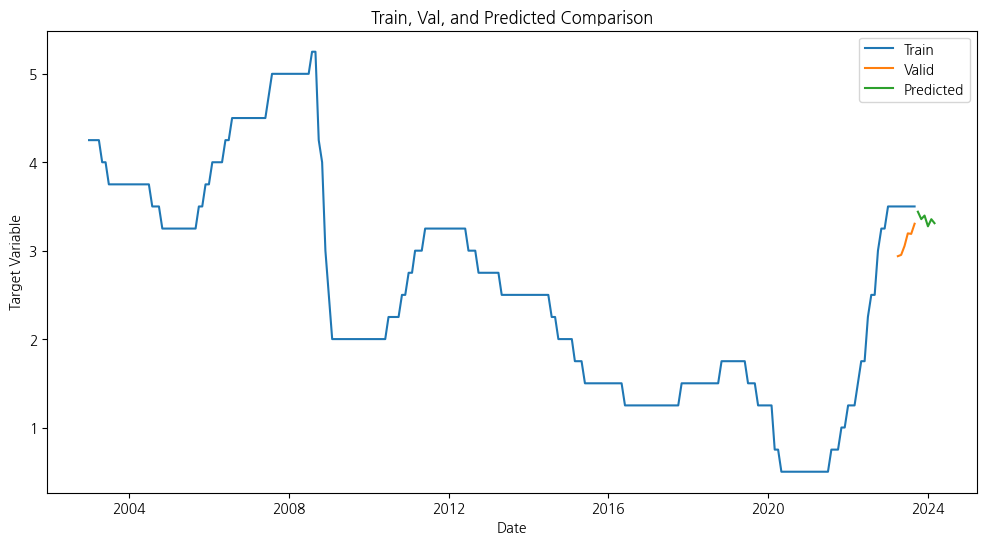

In [ ]:
# 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data['기준금리'], label='Train')
plt.plot(results_v6.index, results_v6['Val'], label='Valid')
plt.plot(results6.index, results6['Predicted'], label='Predicted')
plt.title('Train, Val, and Predicted Comparison')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

## 12개월

### 3-1) VECM 모델훈련

In [ ]:
# train 데이터로 모델 훈련
modelV = VECM(df_diff, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = modelV.fit()

In [ ]:
# 미래의 독립변수 예측
future_steps = 12  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, :-1]

In [ ]:
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum(axis=0) + np.array(imp.iloc[-1,:]).reshape(1,-1)

# 미래의 독립변수 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[[5.04358431 4.51091463 4.41187606 1.00313957 0.90690366 1.00482947
  1.01592572 0.81478286 0.89657537 1.00499643 0.90889733 0.45042535
  0.73082424 0.04044208 0.80056679 0.27664742 4.66297071 0.9844899 ]
 [5.15561871 4.73399023 4.61238243 1.00428402 0.90189669 1.00967147
  1.00397017 0.81307856 0.89728565 0.99202362 0.8597815  0.46367999
  0.71322106 0.04180336 0.81853515 0.38098082 4.85688409 0.98377351]
 [5.14743029 4.77979332 4.68440432 1.00740865 0.89473617 1.01345349
  1.01263864 0.81457033 0.90965397 1.0092433  0.90924148 0.46573949
  0.7066891  0.044159   0.83193691 0.44056547 4.92435304 0.9834601 ]
 [5.05473244 4.69713948 4.6510202  1.0109704  0.91215666 1.01732551
  1.00895286 0.82626226 0.92201308 1.00195593 0.86820989 0.50046885
  0.706951   0.04042745 0.84861025 0.49155225 4.92613696 1.00630836]
 [5.13121043 4.78045227 4.73365492 1.01562472 0.92906467 1.02089265
  1.00898808 0.83295487 0.92458643 1.00098049 0.89875114 0.47631572
  0.71175

### 3-2) 독립변수 생성

In [ ]:
idx = pd.date_range(start='2023-10-01', periods=future_steps, freq='MS')
future_df12 = pd.DataFrame(data=future_forecast, columns=imp.columns, index=idx)

In [ ]:
future_df12

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원)
2023-10-01,5.043584,4.510915,4.411876,1.003140,0.906904,1.004829,1.015926,0.814783,0.896575,1.004996,0.908897,0.450425,0.730824,0.040442,0.800567,0.276647,4.662971,0.984490
2023-11-01,5.155619,4.733990,4.612382,1.004284,0.901897,1.009671,1.003970,0.813079,0.897286,0.992024,0.859782,0.463680,0.713221,0.041803,0.818535,0.380981,4.856884,0.983774
2023-12-01,5.147430,4.779793,4.684404,1.007409,0.894736,1.013453,1.012639,0.814570,0.909654,1.009243,0.909241,0.465739,0.706689,0.044159,0.831937,0.440565,4.924353,0.983460
2024-01-01,5.054732,4.697139,4.651020,1.010970,0.912157,1.017326,1.008953,0.826262,0.922013,1.001956,0.868210,0.500469,0.706951,0.040427,0.848610,0.491552,4.926137,1.006308
2024-02-01,5.131210,4.780452,4.733655,1.015625,0.929065,1.020893,1.008988,0.832955,0.924586,1.000980,0.898751,0.476316,0.711759,0.036172,0.840146,0.478164,5.004605,1.002871
2024-03-01,5.149210,4.782960,4.709681,1.019362,0.933244,1.025035,1.007728,0.835363,0.925886,0.999690,0.871369,0.486888,0.712730,0.034549,0.847702,0.439876,4.980541,1.013573
2024-04-01,5.183697,4.786049,4.709218,1.023760,0.927194,1.029002,1.010300,0.839525,0.925005,1.004724,0.890951,0.465350,0.717392,0.035469,0.838530,0.403999,4.978455,1.015614
2024-05-01,5.216138,4.810425,4.728708,1.027482,0.931860,1.033694,1.008095,0.841304,0.927909,1.000774,0.878963,0.475385,0.719942,0.033370,0.842315,0.406501,4.998015,1.023179
2024-06-01,5.291250,4.877446,4.778151,1.031400,0.934335,1.038771,1.008900,0.842356,0.930143,1.001609,0.888395,0.458940,0.724350,0.031891,0.840051,0.433516,5.033341,1.023624
2024-07-01,5.324352,4.906862,4.796966,1.034875,0.936216,1.043593,1.008043,0.843258,0.935584,1.000540,0.878828,0.467484,0.727149,0.029136,0.847924,0.447911,5.045182,1.028119


### 3-3) 데이터 LSTM으로 형태변환

In [ ]:
# X와 y로 분리
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset.iloc[i:(i + time_steps), :-1]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_steps, -1])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
train_time = -12
X_train, y_train = create_dataset(all_data.iloc[:train_time,:], time_steps)
X_val, y_val = create_dataset(all_data.iloc[train_time-1:,:], time_steps)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((236, 1, 18), (236,), (12, 1, 18), (12,))

### 3-4) LSTM모델 훈련

In [ ]:
# LSTM 모델 생성
modelL = Sequential()
modelL.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
modelL.add(Dropout(0.3))

modelL.add(Dense(16))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(8))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(1))
modelL.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

### 씨드 고정해야함
modelL.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/300
15/15 - 4s - loss: 11.4280 - val_loss: 10.8715 - 4s/epoch - 289ms/step
Epoch 2/300
15/15 - 0s - loss: 8.5907 - val_loss: 10.4713 - 111ms/epoch - 7ms/step
Epoch 3/300
15/15 - 0s - loss: 8.1139 - val_loss: 10.3830 - 111ms/epoch - 7ms/step
Epoch 4/300
15/15 - 0s - loss: 7.8666 - val_loss: 10.0646 - 116ms/epoch - 8ms/step
Epoch 5/300
15/15 - 0s - loss: 7.2068 - val_loss: 10.0013 - 112ms/epoch - 7ms/step
Epoch 6/300
15/15 - 0s - loss: 6.4804 - val_loss: 9.6893 - 118ms/epoch - 8ms/step
Epoch 7/300
15/15 - 0s - loss: 6.0306 - val_loss: 9.3163 - 120ms/epoch - 8ms/step
Epoch 8/300
15/15 - 0s - loss: 5.8193 - val_loss: 8.9860 - 131ms/epoch - 9ms/step
Epoch 9/300
15/15 - 0s - loss: 5.5986 - val_loss: 8.7056 - 106ms/epoch - 7ms/step
Epoch 10/300
15/15 - 0s - loss: 5.5663 - val_loss: 8.3907 - 98ms/epoch - 7ms/step
Epoch 11/300
15/15 - 0s - loss: 4.9570 - val_loss: 7.9973 - 106ms/epoch - 7ms/step
Epoch 12/300
15/15 - 0s - loss: 4.8744 - val_loss: 7.8219 - 105ms/epoch - 7ms/step
Epoch 13/

In [ ]:
val_pred = modelL.predict(X_val)

1/1 [==============================] - 0s 460ms/step


In [ ]:
future_date = future_steps
results_v12 = pd.DataFrame({'Val':val_pred.reshape(-1)}, index=all_data.index[-future_date:])
results_v12

,Val
날짜,
2022-10-01,2.095105
2022-11-01,2.356834
2022-12-01,2.306112
2023-01-01,2.094422
2023-02-01,1.847419
2023-03-01,2.045838
2023-04-01,2.075322
2023-05-01,2.087740
2023-06-01,2.128848


### 3-5) 기준금리 예측

In [ ]:
f_x_train, f_y_train = create_dataset(all_data, time_steps)
modelL.fit(f_x_train, f_y_train, epochs=500, batch_size=16, verbose=2, callbacks=[early_stopping])

Epoch 1/500


16/16 - 0s - loss: 0.8820 - 50ms/epoch - 3ms/step
Epoch 2/500


16/16 - 0s - loss: 0.7643 - 49ms/epoch - 3ms/step
Epoch 3/500


16/16 - 0s - loss: 0.9322 - 49ms/epoch - 3ms/step
Epoch 4/500


16/16 - 0s - loss: 0.6892 - 51ms/epoch - 3ms/step
Epoch 5/500


16/16 - 0s - loss: 0.9943 - 50ms/epoch - 3ms/step
Epoch 6/500


16/16 - 0s - loss: 0.7492 - 52ms/epoch - 3ms/step
Epoch 7/500


16/16 - 0s - loss: 0.8906 - 51ms/epoch - 3ms/step
Epoch 8/500


16/16 - 0s - loss: 0.7982 - 61ms/epoch - 4ms/step
Epoch 9/500


16/16 - 0s - loss: 0.7638 - 53ms/epoch - 3ms/step
Epoch 10/500


16/16 - 0s - loss: 0.7695 - 51ms/epoch - 3ms/step
Epoch 11/500


16/16 - 0s - loss: 0.7577 - 48ms/epoch - 3ms/step
Epoch 12/500


16/16 - 0s - loss: 0.9088 - 54ms/epoch - 3ms/step
Epoch 13/500


16/16 - 0s - loss: 0.7185 - 54ms/epoch - 3ms/step
Epoch 14/500


16/16 - 0s - loss: 0.8575 - 51ms/epoch - 3ms/step
Epoch 15/500


16/16 - 0s - loss: 0.7882 - 50ms/epoch - 3ms/step
Epoch 16/500


16/16 - 0s - loss: 0.8281 - 52ms/epoch - 3ms/step
Epoch 17/500


16/16 - 0s - loss: 0.8225 - 51ms/epoch - 3ms/step
Epoch 18/500


16/16 - 0s - loss: 0.6037 - 51ms/epoch - 3ms/step
Epoch 19/500


16/16 - 0s - loss: 0.7245 - 50ms/epoch - 3ms/step
Epoch 20/500


16/16 - 0s - loss: 0.7869 - 50ms/epoch - 3ms/step
Epoch 21/500


16/16 - 0s - loss: 0.8044 - 53ms/epoch - 3ms/step
Epoch 22/500


16/16 - 0s - loss: 0.8176 - 51ms/epoch - 3ms/step
Epoch 23/500


16/16 - 0s - loss: 0.6634 - 53ms/epoch - 3ms/step
Epoch 24/500


16/16 - 0s - loss: 0.6993 - 55ms/epoch - 3ms/step
Epoch 25/500


16/16 - 0s - loss: 0.7875 - 54ms/epoch - 3ms/step
Epoch 26/500


16/16 - 0s - loss: 0.6638 - 59ms/epoch - 4ms/step
Epoch 27/500


16/16 - 0s - loss: 0.6539 - 63ms/epoch - 4ms/step
Epoch 28/500


16/16 - 0s - loss: 0.7066 - 57ms/epoch - 4ms/step
Epoch 29/500


16/16 - 0s - loss: 0.6318 - 54ms/epoch - 3ms/step
Epoch 30/500


16/16 - 0s - loss: 0.6741 - 50ms/epoch - 3ms/step
Epoch 31/500


16/16 - 0s - loss: 0.6328 - 51ms/epoch - 3ms/step
Epoch 32/500


16/16 - 0s - loss: 0.5930 - 48ms/epoch - 3ms/step
Epoch 33/500


16/16 - 0s - loss: 0.6513 - 51ms/epoch - 3ms/step
Epoch 34/500


16/16 - 0s - loss: 0.7146 - 56ms/epoch - 3ms/step
Epoch 35/500


16/16 - 0s - loss: 0.6287 - 53ms/epoch - 3ms/step
Epoch 36/500


16/16 - 0s - loss: 0.6961 - 49ms/epoch - 3ms/step
Epoch 37/500


16/16 - 0s - loss: 0.7517 - 49ms/epoch - 3ms/step
Epoch 38/500


16/16 - 0s - loss: 0.6611 - 48ms/epoch - 3ms/step
Epoch 39/500


16/16 - 0s - loss: 0.6178 - 53ms/epoch - 3ms/step
Epoch 40/500


16/16 - 0s - loss: 0.7454 - 54ms/epoch - 3ms/step
Epoch 41/500


16/16 - 0s - loss: 0.6189 - 51ms/epoch - 3ms/step
Epoch 42/500


16/16 - 0s - loss: 0.7113 - 53ms/epoch - 3ms/step
Epoch 43/500


16/16 - 0s - loss: 0.5520 - 54ms/epoch - 3ms/step
Epoch 44/500


16/16 - 0s - loss: 0.6148 - 57ms/epoch - 4ms/step
Epoch 45/500


16/16 - 0s - loss: 0.6501 - 56ms/epoch - 3ms/step
Epoch 46/500


16/16 - 0s - loss: 0.7085 - 51ms/epoch - 3ms/step
Epoch 47/500


16/16 - 0s - loss: 0.5803 - 56ms/epoch - 4ms/step
Epoch 48/500


16/16 - 0s - loss: 0.6659 - 49ms/epoch - 3ms/step
Epoch 49/500


16/16 - 0s - loss: 0.6214 - 51ms/epoch - 3ms/step
Epoch 50/500


16/16 - 0s - loss: 0.5991 - 57ms/epoch - 4ms/step
Epoch 51/500


16/16 - 0s - loss: 0.6033 - 49ms/epoch - 3ms/step
Epoch 52/500


16/16 - 0s - loss: 0.5902 - 53ms/epoch - 3ms/step
Epoch 53/500


16/16 - 0s - loss: 0.6025 - 51ms/epoch - 3ms/step
Epoch 54/500


16/16 - 0s - loss: 0.4924 - 51ms/epoch - 3ms/step
Epoch 55/500


16/16 - 0s - loss: 0.6365 - 51ms/epoch - 3ms/step
Epoch 56/500


16/16 - 0s - loss: 0.5570 - 53ms/epoch - 3ms/step
Epoch 57/500


16/16 - 0s - loss: 0.5595 - 50ms/epoch - 3ms/step
Epoch 58/500


16/16 - 0s - loss: 0.5968 - 60ms/epoch - 4ms/step
Epoch 59/500


16/16 - 0s - loss: 0.5289 - 54ms/epoch - 3ms/step
Epoch 60/500


16/16 - 0s - loss: 0.5668 - 58ms/epoch - 4ms/step
Epoch 61/500


16/16 - 0s - loss: 0.5082 - 62ms/epoch - 4ms/step
Epoch 62/500


16/16 - 0s - loss: 0.6223 - 54ms/epoch - 3ms/step
Epoch 63/500


16/16 - 0s - loss: 0.6300 - 52ms/epoch - 3ms/step
Epoch 64/500


16/16 - 0s - loss: 0.6797 - 58ms/epoch - 4ms/step
Epoch 65/500


16/16 - 0s - loss: 0.4861 - 56ms/epoch - 3ms/step
Epoch 66/500


16/16 - 0s - loss: 0.5179 - 53ms/epoch - 3ms/step
Epoch 67/500


16/16 - 0s - loss: 0.7127 - 54ms/epoch - 3ms/step
Epoch 68/500


16/16 - 0s - loss: 0.4833 - 51ms/epoch - 3ms/step
Epoch 69/500


16/16 - 0s - loss: 0.6943 - 52ms/epoch - 3ms/step
Epoch 70/500


16/16 - 0s - loss: 0.5373 - 52ms/epoch - 3ms/step
Epoch 71/500


16/16 - 0s - loss: 0.6265 - 51ms/epoch - 3ms/step
Epoch 72/500


16/16 - 0s - loss: 0.5334 - 58ms/epoch - 4ms/step
Epoch 73/500


16/16 - 0s - loss: 0.5516 - 52ms/epoch - 3ms/step
Epoch 74/500


16/16 - 0s - loss: 0.5146 - 53ms/epoch - 3ms/step
Epoch 75/500


16/16 - 0s - loss: 0.5869 - 52ms/epoch - 3ms/step
Epoch 76/500


16/16 - 0s - loss: 0.4477 - 55ms/epoch - 3ms/step
Epoch 77/500


16/16 - 0s - loss: 0.4999 - 52ms/epoch - 3ms/step
Epoch 78/500


16/16 - 0s - loss: 0.5160 - 54ms/epoch - 3ms/step
Epoch 79/500


16/16 - 0s - loss: 0.5777 - 66ms/epoch - 4ms/step
Epoch 80/500


16/16 - 0s - loss: 0.5069 - 59ms/epoch - 4ms/step
Epoch 81/500


16/16 - 0s - loss: 0.5878 - 55ms/epoch - 3ms/step
Epoch 82/500


16/16 - 0s - loss: 0.5670 - 51ms/epoch - 3ms/step
Epoch 83/500


16/16 - 0s - loss: 0.5804 - 55ms/epoch - 3ms/step
Epoch 84/500


16/16 - 0s - loss: 0.5563 - 57ms/epoch - 4ms/step
Epoch 85/500


16/16 - 0s - loss: 0.5776 - 59ms/epoch - 4ms/step
Epoch 86/500


16/16 - 0s - loss: 0.4173 - 57ms/epoch - 4ms/step
Epoch 87/500


16/16 - 0s - loss: 0.5216 - 53ms/epoch - 3ms/step
Epoch 88/500


16/16 - 0s - loss: 0.4773 - 65ms/epoch - 4ms/step
Epoch 89/500


16/16 - 0s - loss: 0.6452 - 61ms/epoch - 4ms/step
Epoch 90/500


16/16 - 0s - loss: 0.4874 - 53ms/epoch - 3ms/step
Epoch 91/500


16/16 - 0s - loss: 0.4984 - 51ms/epoch - 3ms/step
Epoch 92/500


16/16 - 0s - loss: 0.4288 - 54ms/epoch - 3ms/step
Epoch 93/500


16/16 - 0s - loss: 0.4111 - 53ms/epoch - 3ms/step
Epoch 94/500


16/16 - 0s - loss: 0.5453 - 52ms/epoch - 3ms/step
Epoch 95/500


16/16 - 0s - loss: 0.5240 - 52ms/epoch - 3ms/step
Epoch 96/500


16/16 - 0s - loss: 0.5199 - 83ms/epoch - 5ms/step
Epoch 97/500


16/16 - 0s - loss: 0.5566 - 76ms/epoch - 5ms/step
Epoch 98/500


16/16 - 0s - loss: 0.6115 - 72ms/epoch - 5ms/step
Epoch 99/500


16/16 - 0s - loss: 0.4984 - 68ms/epoch - 4ms/step
Epoch 100/500


16/16 - 0s - loss: 0.6847 - 68ms/epoch - 4ms/step
Epoch 101/500


16/16 - 0s - loss: 0.4812 - 64ms/epoch - 4ms/step
Epoch 102/500


16/16 - 0s - loss: 0.5532 - 69ms/epoch - 4ms/step
Epoch 103/500


16/16 - 0s - loss: 0.5158 - 65ms/epoch - 4ms/step
Epoch 104/500


16/16 - 0s - loss: 0.5400 - 66ms/epoch - 4ms/step
Epoch 105/500


16/16 - 0s - loss: 0.5228 - 68ms/epoch - 4ms/step
Epoch 106/500


16/16 - 0s - loss: 0.4263 - 74ms/epoch - 5ms/step
Epoch 107/500


16/16 - 0s - loss: 0.4891 - 72ms/epoch - 5ms/step
Epoch 108/500


16/16 - 0s - loss: 0.5268 - 72ms/epoch - 5ms/step
Epoch 109/500


16/16 - 0s - loss: 0.5581 - 71ms/epoch - 4ms/step
Epoch 110/500


16/16 - 0s - loss: 0.5348 - 78ms/epoch - 5ms/step
Epoch 111/500


16/16 - 0s - loss: 0.5110 - 75ms/epoch - 5ms/step
Epoch 112/500


16/16 - 0s - loss: 0.5001 - 78ms/epoch - 5ms/step
Epoch 113/500


16/16 - 0s - loss: 0.5217 - 73ms/epoch - 5ms/step
Epoch 114/500


16/16 - 0s - loss: 0.5228 - 77ms/epoch - 5ms/step
Epoch 115/500


16/16 - 0s - loss: 0.5408 - 73ms/epoch - 5ms/step
Epoch 116/500


16/16 - 0s - loss: 0.4696 - 75ms/epoch - 5ms/step
Epoch 117/500


16/16 - 0s - loss: 0.5569 - 74ms/epoch - 5ms/step
Epoch 118/500


16/16 - 0s - loss: 0.4795 - 71ms/epoch - 4ms/step
Epoch 119/500


16/16 - 0s - loss: 0.4637 - 74ms/epoch - 5ms/step
Epoch 120/500


16/16 - 0s - loss: 0.5113 - 80ms/epoch - 5ms/step
Epoch 121/500


16/16 - 0s - loss: 0.5216 - 75ms/epoch - 5ms/step
Epoch 122/500


16/16 - 0s - loss: 0.4688 - 68ms/epoch - 4ms/step
Epoch 123/500


16/16 - 0s - loss: 0.4782 - 72ms/epoch - 4ms/step
Epoch 124/500


16/16 - 0s - loss: 0.5541 - 72ms/epoch - 5ms/step
Epoch 125/500


16/16 - 0s - loss: 0.4810 - 66ms/epoch - 4ms/step
Epoch 126/500


16/16 - 0s - loss: 0.4263 - 66ms/epoch - 4ms/step
Epoch 127/500


16/16 - 0s - loss: 0.4382 - 71ms/epoch - 4ms/step
Epoch 128/500


16/16 - 0s - loss: 0.4361 - 68ms/epoch - 4ms/step
Epoch 129/500


16/16 - 0s - loss: 0.4555 - 68ms/epoch - 4ms/step
Epoch 130/500


16/16 - 0s - loss: 0.4615 - 68ms/epoch - 4ms/step
Epoch 131/500


16/16 - 0s - loss: 0.5260 - 69ms/epoch - 4ms/step
Epoch 132/500


16/16 - 0s - loss: 0.4077 - 75ms/epoch - 5ms/step
Epoch 133/500


16/16 - 0s - loss: 0.4209 - 73ms/epoch - 5ms/step
Epoch 134/500


16/16 - 0s - loss: 0.5090 - 81ms/epoch - 5ms/step
Epoch 135/500


16/16 - 0s - loss: 0.4201 - 81ms/epoch - 5ms/step
Epoch 136/500


16/16 - 0s - loss: 0.4440 - 74ms/epoch - 5ms/step
Epoch 137/500


16/16 - 0s - loss: 0.4763 - 83ms/epoch - 5ms/step
Epoch 138/500


16/16 - 0s - loss: 0.3670 - 83ms/epoch - 5ms/step
Epoch 139/500


16/16 - 0s - loss: 0.4576 - 67ms/epoch - 4ms/step
Epoch 140/500


16/16 - 0s - loss: 0.4692 - 71ms/epoch - 4ms/step
Epoch 141/500


16/16 - 0s - loss: 0.5506 - 68ms/epoch - 4ms/step
Epoch 142/500


16/16 - 0s - loss: 0.4328 - 70ms/epoch - 4ms/step
Epoch 143/500


16/16 - 0s - loss: 0.5153 - 68ms/epoch - 4ms/step
Epoch 144/500


16/16 - 0s - loss: 0.4344 - 69ms/epoch - 4ms/step
Epoch 145/500


16/16 - 0s - loss: 0.4487 - 76ms/epoch - 5ms/step
Epoch 146/500


16/16 - 0s - loss: 0.4221 - 69ms/epoch - 4ms/step
Epoch 147/500


16/16 - 0s - loss: 0.4850 - 71ms/epoch - 4ms/step
Epoch 148/500


16/16 - 0s - loss: 0.4387 - 81ms/epoch - 5ms/step
Epoch 149/500


16/16 - 0s - loss: 0.4847 - 67ms/epoch - 4ms/step
Epoch 150/500


16/16 - 0s - loss: 0.5318 - 69ms/epoch - 4ms/step
Epoch 151/500


16/16 - 0s - loss: 0.4554 - 76ms/epoch - 5ms/step
Epoch 152/500


16/16 - 0s - loss: 0.4111 - 80ms/epoch - 5ms/step
Epoch 153/500


16/16 - 0s - loss: 0.4146 - 71ms/epoch - 4ms/step
Epoch 154/500


16/16 - 0s - loss: 0.5014 - 69ms/epoch - 4ms/step
Epoch 155/500


16/16 - 0s - loss: 0.4521 - 71ms/epoch - 4ms/step
Epoch 156/500


16/16 - 0s - loss: 0.5953 - 66ms/epoch - 4ms/step
Epoch 157/500


16/16 - 0s - loss: 0.5570 - 70ms/epoch - 4ms/step
Epoch 158/500


16/16 - 0s - loss: 0.3981 - 76ms/epoch - 5ms/step
Epoch 159/500


16/16 - 0s - loss: 0.4811 - 79ms/epoch - 5ms/step
Epoch 160/500


16/16 - 0s - loss: 0.4702 - 77ms/epoch - 5ms/step
Epoch 161/500


16/16 - 0s - loss: 0.5139 - 71ms/epoch - 4ms/step
Epoch 162/500


16/16 - 0s - loss: 0.4621 - 68ms/epoch - 4ms/step
Epoch 163/500


16/16 - 0s - loss: 0.4494 - 73ms/epoch - 5ms/step
Epoch 164/500


16/16 - 0s - loss: 0.4333 - 70ms/epoch - 4ms/step
Epoch 165/500


16/16 - 0s - loss: 0.4887 - 77ms/epoch - 5ms/step
Epoch 166/500


16/16 - 0s - loss: 0.5204 - 74ms/epoch - 5ms/step
Epoch 167/500


16/16 - 0s - loss: 0.4301 - 87ms/epoch - 5ms/step
Epoch 168/500


16/16 - 0s - loss: 0.4241 - 66ms/epoch - 4ms/step
Epoch 169/500


16/16 - 0s - loss: 0.3570 - 75ms/epoch - 5ms/step
Epoch 170/500


16/16 - 0s - loss: 0.3964 - 72ms/epoch - 5ms/step
Epoch 171/500


16/16 - 0s - loss: 0.4504 - 77ms/epoch - 5ms/step
Epoch 172/500


16/16 - 0s - loss: 0.4485 - 72ms/epoch - 5ms/step
Epoch 173/500


16/16 - 0s - loss: 0.4042 - 71ms/epoch - 4ms/step
Epoch 174/500


16/16 - 0s - loss: 0.3963 - 72ms/epoch - 4ms/step
Epoch 175/500


16/16 - 0s - loss: 0.4120 - 74ms/epoch - 5ms/step
Epoch 176/500


16/16 - 0s - loss: 0.4301 - 78ms/epoch - 5ms/step
Epoch 177/500


16/16 - 0s - loss: 0.5208 - 79ms/epoch - 5ms/step
Epoch 178/500


16/16 - 0s - loss: 0.5013 - 79ms/epoch - 5ms/step
Epoch 179/500


16/16 - 0s - loss: 0.4671 - 81ms/epoch - 5ms/step
Epoch 180/500


16/16 - 0s - loss: 0.5584 - 74ms/epoch - 5ms/step
Epoch 181/500


16/16 - 0s - loss: 0.4259 - 71ms/epoch - 4ms/step
Epoch 182/500


16/16 - 0s - loss: 0.4630 - 79ms/epoch - 5ms/step
Epoch 183/500


16/16 - 0s - loss: 0.4301 - 71ms/epoch - 4ms/step
Epoch 184/500


16/16 - 0s - loss: 0.4543 - 69ms/epoch - 4ms/step
Epoch 185/500


16/16 - 0s - loss: 0.4728 - 74ms/epoch - 5ms/step
Epoch 186/500


16/16 - 0s - loss: 0.4309 - 75ms/epoch - 5ms/step
Epoch 187/500


16/16 - 0s - loss: 0.4315 - 80ms/epoch - 5ms/step
Epoch 188/500


16/16 - 0s - loss: 0.4144 - 69ms/epoch - 4ms/step
Epoch 189/500


16/16 - 0s - loss: 0.4283 - 69ms/epoch - 4ms/step
Epoch 190/500


16/16 - 0s - loss: 0.4758 - 71ms/epoch - 4ms/step
Epoch 191/500


16/16 - 0s - loss: 0.5440 - 70ms/epoch - 4ms/step
Epoch 192/500


16/16 - 0s - loss: 0.4472 - 76ms/epoch - 5ms/step
Epoch 193/500


16/16 - 0s - loss: 0.4130 - 84ms/epoch - 5ms/step
Epoch 194/500


16/16 - 0s - loss: 0.3947 - 73ms/epoch - 5ms/step
Epoch 195/500


16/16 - 0s - loss: 0.4715 - 68ms/epoch - 4ms/step
Epoch 196/500


16/16 - 0s - loss: 0.4463 - 81ms/epoch - 5ms/step
Epoch 197/500


16/16 - 0s - loss: 0.4365 - 79ms/epoch - 5ms/step
Epoch 198/500


16/16 - 0s - loss: 0.4408 - 80ms/epoch - 5ms/step
Epoch 199/500


16/16 - 0s - loss: 0.4907 - 82ms/epoch - 5ms/step
Epoch 200/500


16/16 - 0s - loss: 0.5052 - 74ms/epoch - 5ms/step
Epoch 201/500


16/16 - 0s - loss: 0.3615 - 70ms/epoch - 4ms/step
Epoch 202/500


16/16 - 0s - loss: 0.3669 - 71ms/epoch - 4ms/step
Epoch 203/500


16/16 - 0s - loss: 0.4567 - 75ms/epoch - 5ms/step
Epoch 204/500


16/16 - 0s - loss: 0.4586 - 60ms/epoch - 4ms/step
Epoch 205/500


16/16 - 0s - loss: 0.4503 - 57ms/epoch - 4ms/step
Epoch 206/500


16/16 - 0s - loss: 0.4065 - 66ms/epoch - 4ms/step
Epoch 207/500


16/16 - 0s - loss: 0.4340 - 54ms/epoch - 3ms/step
Epoch 208/500


16/16 - 0s - loss: 0.4806 - 54ms/epoch - 3ms/step
Epoch 209/500


16/16 - 0s - loss: 0.4300 - 51ms/epoch - 3ms/step
Epoch 210/500


16/16 - 0s - loss: 0.4958 - 58ms/epoch - 4ms/step
Epoch 211/500


16/16 - 0s - loss: 0.3440 - 50ms/epoch - 3ms/step
Epoch 212/500


16/16 - 0s - loss: 0.4007 - 60ms/epoch - 4ms/step
Epoch 213/500


16/16 - 0s - loss: 0.3071 - 55ms/epoch - 3ms/step
Epoch 214/500


16/16 - 0s - loss: 0.4849 - 61ms/epoch - 4ms/step
Epoch 215/500


16/16 - 0s - loss: 0.4330 - 61ms/epoch - 4ms/step
Epoch 216/500


16/16 - 0s - loss: 0.4737 - 57ms/epoch - 4ms/step
Epoch 217/500


16/16 - 0s - loss: 0.4167 - 58ms/epoch - 4ms/step
Epoch 218/500


16/16 - 0s - loss: 0.5001 - 64ms/epoch - 4ms/step
Epoch 219/500


16/16 - 0s - loss: 0.4278 - 51ms/epoch - 3ms/step
Epoch 220/500


16/16 - 0s - loss: 0.3480 - 54ms/epoch - 3ms/step
Epoch 221/500


16/16 - 0s - loss: 0.3864 - 55ms/epoch - 3ms/step
Epoch 222/500


16/16 - 0s - loss: 0.4031 - 68ms/epoch - 4ms/step
Epoch 223/500


16/16 - 0s - loss: 0.4311 - 63ms/epoch - 4ms/step
Epoch 224/500


16/16 - 0s - loss: 0.3966 - 66ms/epoch - 4ms/step
Epoch 225/500


16/16 - 0s - loss: 0.4200 - 60ms/epoch - 4ms/step
Epoch 226/500


16/16 - 0s - loss: 0.4501 - 61ms/epoch - 4ms/step
Epoch 227/500


16/16 - 0s - loss: 0.4915 - 66ms/epoch - 4ms/step
Epoch 228/500


16/16 - 0s - loss: 0.4524 - 63ms/epoch - 4ms/step
Epoch 229/500


16/16 - 0s - loss: 0.3785 - 61ms/epoch - 4ms/step
Epoch 230/500


16/16 - 0s - loss: 0.4522 - 58ms/epoch - 4ms/step
Epoch 231/500


16/16 - 0s - loss: 0.4217 - 56ms/epoch - 4ms/step
Epoch 232/500


16/16 - 0s - loss: 0.4465 - 61ms/epoch - 4ms/step
Epoch 233/500


16/16 - 0s - loss: 0.3701 - 55ms/epoch - 3ms/step
Epoch 234/500


16/16 - 0s - loss: 0.3829 - 52ms/epoch - 3ms/step
Epoch 235/500


16/16 - 0s - loss: 0.4807 - 53ms/epoch - 3ms/step
Epoch 236/500


16/16 - 0s - loss: 0.4432 - 57ms/epoch - 4ms/step
Epoch 237/500


16/16 - 0s - loss: 0.3594 - 51ms/epoch - 3ms/step
Epoch 238/500


16/16 - 0s - loss: 0.4204 - 65ms/epoch - 4ms/step
Epoch 239/500


16/16 - 0s - loss: 0.3958 - 53ms/epoch - 3ms/step
Epoch 240/500


16/16 - 0s - loss: 0.3971 - 55ms/epoch - 3ms/step
Epoch 241/500


16/16 - 0s - loss: 0.3717 - 54ms/epoch - 3ms/step
Epoch 242/500


16/16 - 0s - loss: 0.5428 - 55ms/epoch - 3ms/step
Epoch 243/500


16/16 - 0s - loss: 0.4295 - 57ms/epoch - 4ms/step
Epoch 244/500


16/16 - 0s - loss: 0.5100 - 58ms/epoch - 4ms/step
Epoch 245/500


16/16 - 0s - loss: 0.3430 - 53ms/epoch - 3ms/step
Epoch 246/500


16/16 - 0s - loss: 0.4241 - 59ms/epoch - 4ms/step
Epoch 247/500


16/16 - 0s - loss: 0.4797 - 56ms/epoch - 4ms/step
Epoch 248/500


16/16 - 0s - loss: 0.3596 - 61ms/epoch - 4ms/step
Epoch 249/500


16/16 - 0s - loss: 0.4209 - 65ms/epoch - 4ms/step
Epoch 250/500


16/16 - 0s - loss: 0.4196 - 53ms/epoch - 3ms/step
Epoch 251/500


16/16 - 0s - loss: 0.4801 - 53ms/epoch - 3ms/step
Epoch 252/500


16/16 - 0s - loss: 0.4054 - 61ms/epoch - 4ms/step
Epoch 253/500


16/16 - 0s - loss: 0.4668 - 61ms/epoch - 4ms/step
Epoch 254/500


16/16 - 0s - loss: 0.3712 - 61ms/epoch - 4ms/step
Epoch 255/500


16/16 - 0s - loss: 0.3607 - 60ms/epoch - 4ms/step
Epoch 256/500


16/16 - 0s - loss: 0.3699 - 56ms/epoch - 3ms/step
Epoch 257/500


16/16 - 0s - loss: 0.4103 - 60ms/epoch - 4ms/step
Epoch 258/500


16/16 - 0s - loss: 0.3723 - 58ms/epoch - 4ms/step
Epoch 259/500


16/16 - 0s - loss: 0.3856 - 58ms/epoch - 4ms/step
Epoch 260/500


16/16 - 0s - loss: 0.3477 - 55ms/epoch - 3ms/step
Epoch 261/500


16/16 - 0s - loss: 0.3481 - 53ms/epoch - 3ms/step
Epoch 262/500


16/16 - 0s - loss: 0.3618 - 51ms/epoch - 3ms/step
Epoch 263/500


16/16 - 0s - loss: 0.4742 - 61ms/epoch - 4ms/step
Epoch 264/500


16/16 - 0s - loss: 0.3354 - 60ms/epoch - 4ms/step
Epoch 265/500


16/16 - 0s - loss: 0.4048 - 57ms/epoch - 4ms/step
Epoch 266/500


16/16 - 0s - loss: 0.4195 - 52ms/epoch - 3ms/step
Epoch 267/500


16/16 - 0s - loss: 0.4585 - 55ms/epoch - 3ms/step
Epoch 268/500


16/16 - 0s - loss: 0.3706 - 55ms/epoch - 3ms/step
Epoch 269/500


16/16 - 0s - loss: 0.3736 - 58ms/epoch - 4ms/step
Epoch 270/500


16/16 - 0s - loss: 0.4310 - 51ms/epoch - 3ms/step
Epoch 271/500


16/16 - 0s - loss: 0.4699 - 59ms/epoch - 4ms/step
Epoch 272/500


16/16 - 0s - loss: 0.3839 - 57ms/epoch - 4ms/step
Epoch 273/500


16/16 - 0s - loss: 0.3852 - 55ms/epoch - 3ms/step
Epoch 274/500


16/16 - 0s - loss: 0.3832 - 51ms/epoch - 3ms/step
Epoch 275/500


16/16 - 0s - loss: 0.4630 - 53ms/epoch - 3ms/step
Epoch 276/500


16/16 - 0s - loss: 0.4044 - 56ms/epoch - 4ms/step
Epoch 277/500


16/16 - 0s - loss: 0.2604 - 58ms/epoch - 4ms/step
Epoch 278/500


16/16 - 0s - loss: 0.4865 - 57ms/epoch - 4ms/step
Epoch 279/500


16/16 - 0s - loss: 0.4042 - 53ms/epoch - 3ms/step
Epoch 280/500


16/16 - 0s - loss: 0.2939 - 54ms/epoch - 3ms/step
Epoch 281/500


16/16 - 0s - loss: 0.4717 - 52ms/epoch - 3ms/step
Epoch 282/500


16/16 - 0s - loss: 0.3472 - 50ms/epoch - 3ms/step
Epoch 283/500


16/16 - 0s - loss: 0.3755 - 55ms/epoch - 3ms/step
Epoch 284/500


16/16 - 0s - loss: 0.4399 - 53ms/epoch - 3ms/step
Epoch 285/500


16/16 - 0s - loss: 0.4090 - 53ms/epoch - 3ms/step
Epoch 286/500


16/16 - 0s - loss: 0.3886 - 55ms/epoch - 3ms/step
Epoch 287/500


16/16 - 0s - loss: 0.4811 - 57ms/epoch - 4ms/step
Epoch 288/500


16/16 - 0s - loss: 0.4500 - 63ms/epoch - 4ms/step
Epoch 289/500


16/16 - 0s - loss: 0.4151 - 61ms/epoch - 4ms/step
Epoch 290/500


16/16 - 0s - loss: 0.3970 - 50ms/epoch - 3ms/step
Epoch 291/500


16/16 - 0s - loss: 0.3819 - 55ms/epoch - 3ms/step
Epoch 292/500


16/16 - 0s - loss: 0.5089 - 57ms/epoch - 4ms/step
Epoch 293/500


16/16 - 0s - loss: 0.4497 - 61ms/epoch - 4ms/step
Epoch 294/500


16/16 - 0s - loss: 0.2897 - 54ms/epoch - 3ms/step
Epoch 295/500


16/16 - 0s - loss: 0.3974 - 63ms/epoch - 4ms/step
Epoch 296/500


16/16 - 0s - loss: 0.4055 - 54ms/epoch - 3ms/step
Epoch 297/500


16/16 - 0s - loss: 0.3242 - 55ms/epoch - 3ms/step
Epoch 298/500


16/16 - 0s - loss: 0.4293 - 68ms/epoch - 4ms/step
Epoch 299/500


16/16 - 0s - loss: 0.3460 - 58ms/epoch - 4ms/step
Epoch 300/500


16/16 - 0s - loss: 0.3458 - 58ms/epoch - 4ms/step
Epoch 301/500


16/16 - 0s - loss: 0.4712 - 58ms/epoch - 4ms/step
Epoch 302/500


16/16 - 0s - loss: 0.3130 - 57ms/epoch - 4ms/step
Epoch 303/500


16/16 - 0s - loss: 0.3908 - 64ms/epoch - 4ms/step
Epoch 304/500


16/16 - 0s - loss: 0.3453 - 60ms/epoch - 4ms/step
Epoch 305/500


16/16 - 0s - loss: 0.3192 - 56ms/epoch - 3ms/step
Epoch 306/500


16/16 - 0s - loss: 0.3930 - 56ms/epoch - 4ms/step
Epoch 307/500


16/16 - 0s - loss: 0.3732 - 59ms/epoch - 4ms/step
Epoch 308/500


16/16 - 0s - loss: 0.3552 - 60ms/epoch - 4ms/step
Epoch 309/500


16/16 - 0s - loss: 0.4226 - 57ms/epoch - 4ms/step
Epoch 310/500


16/16 - 0s - loss: 0.3461 - 59ms/epoch - 4ms/step
Epoch 311/500


16/16 - 0s - loss: 0.3964 - 62ms/epoch - 4ms/step
Epoch 312/500


16/16 - 0s - loss: 0.3508 - 56ms/epoch - 3ms/step
Epoch 313/500


16/16 - 0s - loss: 0.3866 - 65ms/epoch - 4ms/step
Epoch 314/500


16/16 - 0s - loss: 0.4389 - 55ms/epoch - 3ms/step
Epoch 315/500


16/16 - 0s - loss: 0.4224 - 53ms/epoch - 3ms/step
Epoch 316/500


16/16 - 0s - loss: 0.3431 - 60ms/epoch - 4ms/step
Epoch 317/500


16/16 - 0s - loss: 0.3506 - 55ms/epoch - 3ms/step
Epoch 318/500


16/16 - 0s - loss: 0.3564 - 52ms/epoch - 3ms/step
Epoch 319/500


16/16 - 0s - loss: 0.4092 - 60ms/epoch - 4ms/step
Epoch 320/500


16/16 - 0s - loss: 0.3451 - 57ms/epoch - 4ms/step
Epoch 321/500


16/16 - 0s - loss: 0.4642 - 69ms/epoch - 4ms/step
Epoch 322/500


16/16 - 0s - loss: 0.3486 - 56ms/epoch - 3ms/step
Epoch 323/500


16/16 - 0s - loss: 0.3543 - 60ms/epoch - 4ms/step
Epoch 324/500


16/16 - 0s - loss: 0.3883 - 60ms/epoch - 4ms/step
Epoch 325/500


16/16 - 0s - loss: 0.3947 - 56ms/epoch - 4ms/step
Epoch 326/500


16/16 - 0s - loss: 0.4846 - 52ms/epoch - 3ms/step
Epoch 327/500


16/16 - 0s - loss: 0.3956 - 54ms/epoch - 3ms/step
Epoch 328/500


16/16 - 0s - loss: 0.4251 - 59ms/epoch - 4ms/step
Epoch 329/500


16/16 - 0s - loss: 0.3604 - 57ms/epoch - 4ms/step
Epoch 330/500


16/16 - 0s - loss: 0.3485 - 55ms/epoch - 3ms/step
Epoch 331/500


16/16 - 0s - loss: 0.3850 - 63ms/epoch - 4ms/step
Epoch 332/500


16/16 - 0s - loss: 0.3991 - 53ms/epoch - 3ms/step
Epoch 333/500


16/16 - 0s - loss: 0.3061 - 60ms/epoch - 4ms/step
Epoch 334/500


16/16 - 0s - loss: 0.3537 - 53ms/epoch - 3ms/step
Epoch 335/500


16/16 - 0s - loss: 0.3024 - 55ms/epoch - 3ms/step
Epoch 336/500


16/16 - 0s - loss: 0.3557 - 55ms/epoch - 3ms/step
Epoch 337/500


16/16 - 0s - loss: 0.4240 - 61ms/epoch - 4ms/step
Epoch 338/500


16/16 - 0s - loss: 0.3600 - 60ms/epoch - 4ms/step
Epoch 339/500


16/16 - 0s - loss: 0.2890 - 56ms/epoch - 3ms/step
Epoch 340/500


16/16 - 0s - loss: 0.3276 - 63ms/epoch - 4ms/step
Epoch 341/500


16/16 - 0s - loss: 0.3660 - 55ms/epoch - 3ms/step
Epoch 342/500


16/16 - 0s - loss: 0.2913 - 59ms/epoch - 4ms/step
Epoch 343/500


16/16 - 0s - loss: 0.4799 - 58ms/epoch - 4ms/step
Epoch 344/500


16/16 - 0s - loss: 0.3423 - 61ms/epoch - 4ms/step
Epoch 345/500


16/16 - 0s - loss: 0.3246 - 56ms/epoch - 4ms/step
Epoch 346/500


16/16 - 0s - loss: 0.3377 - 55ms/epoch - 3ms/step
Epoch 347/500


16/16 - 0s - loss: 0.3627 - 56ms/epoch - 3ms/step
Epoch 348/500


16/16 - 0s - loss: 0.4009 - 60ms/epoch - 4ms/step
Epoch 349/500


16/16 - 0s - loss: 0.3697 - 54ms/epoch - 3ms/step
Epoch 350/500


16/16 - 0s - loss: 0.3191 - 54ms/epoch - 3ms/step
Epoch 351/500


16/16 - 0s - loss: 0.3200 - 57ms/epoch - 4ms/step
Epoch 352/500


16/16 - 0s - loss: 0.2965 - 52ms/epoch - 3ms/step
Epoch 353/500


16/16 - 0s - loss: 0.3524 - 60ms/epoch - 4ms/step
Epoch 354/500


16/16 - 0s - loss: 0.3995 - 60ms/epoch - 4ms/step
Epoch 355/500


16/16 - 0s - loss: 0.3793 - 55ms/epoch - 3ms/step
Epoch 356/500


16/16 - 0s - loss: 0.3122 - 61ms/epoch - 4ms/step
Epoch 357/500


16/16 - 0s - loss: 0.3466 - 64ms/epoch - 4ms/step
Epoch 358/500


16/16 - 0s - loss: 0.3085 - 64ms/epoch - 4ms/step
Epoch 359/500


16/16 - 0s - loss: 0.3496 - 56ms/epoch - 4ms/step
Epoch 360/500


16/16 - 0s - loss: 0.3386 - 62ms/epoch - 4ms/step
Epoch 361/500


16/16 - 0s - loss: 0.3369 - 56ms/epoch - 4ms/step
Epoch 362/500


16/16 - 0s - loss: 0.3183 - 54ms/epoch - 3ms/step
Epoch 363/500


16/16 - 0s - loss: 0.3313 - 53ms/epoch - 3ms/step
Epoch 364/500


16/16 - 0s - loss: 0.4150 - 74ms/epoch - 5ms/step
Epoch 365/500


16/16 - 0s - loss: 0.3713 - 67ms/epoch - 4ms/step
Epoch 366/500


16/16 - 0s - loss: 0.3885 - 83ms/epoch - 5ms/step
Epoch 367/500


16/16 - 0s - loss: 0.3716 - 70ms/epoch - 4ms/step
Epoch 368/500


16/16 - 0s - loss: 0.3597 - 83ms/epoch - 5ms/step
Epoch 369/500


16/16 - 0s - loss: 0.3634 - 86ms/epoch - 5ms/step
Epoch 370/500


16/16 - 0s - loss: 0.3996 - 64ms/epoch - 4ms/step
Epoch 371/500


16/16 - 0s - loss: 0.3891 - 68ms/epoch - 4ms/step
Epoch 372/500


16/16 - 0s - loss: 0.3157 - 86ms/epoch - 5ms/step
Epoch 373/500


16/16 - 0s - loss: 0.4085 - 76ms/epoch - 5ms/step
Epoch 374/500


16/16 - 0s - loss: 0.3724 - 90ms/epoch - 6ms/step
Epoch 375/500


16/16 - 0s - loss: 0.2998 - 81ms/epoch - 5ms/step
Epoch 376/500


16/16 - 0s - loss: 0.3680 - 74ms/epoch - 5ms/step
Epoch 377/500


16/16 - 0s - loss: 0.3637 - 75ms/epoch - 5ms/step
Epoch 378/500


16/16 - 0s - loss: 0.3892 - 74ms/epoch - 5ms/step
Epoch 379/500


16/16 - 0s - loss: 0.3263 - 82ms/epoch - 5ms/step
Epoch 380/500


16/16 - 0s - loss: 0.3363 - 74ms/epoch - 5ms/step
Epoch 381/500


16/16 - 0s - loss: 0.3249 - 73ms/epoch - 5ms/step
Epoch 382/500


16/16 - 0s - loss: 0.3849 - 85ms/epoch - 5ms/step
Epoch 383/500


16/16 - 0s - loss: 0.3342 - 89ms/epoch - 6ms/step
Epoch 384/500


16/16 - 0s - loss: 0.3296 - 77ms/epoch - 5ms/step
Epoch 385/500


16/16 - 0s - loss: 0.3729 - 72ms/epoch - 4ms/step
Epoch 386/500


16/16 - 0s - loss: 0.3567 - 73ms/epoch - 5ms/step
Epoch 387/500


16/16 - 0s - loss: 0.3401 - 70ms/epoch - 4ms/step
Epoch 388/500


16/16 - 0s - loss: 0.4121 - 71ms/epoch - 4ms/step
Epoch 389/500


16/16 - 0s - loss: 0.3511 - 80ms/epoch - 5ms/step
Epoch 390/500


16/16 - 0s - loss: 0.2705 - 87ms/epoch - 5ms/step
Epoch 391/500


16/16 - 0s - loss: 0.3678 - 77ms/epoch - 5ms/step
Epoch 392/500


16/16 - 0s - loss: 0.3636 - 74ms/epoch - 5ms/step
Epoch 393/500


16/16 - 0s - loss: 0.3615 - 88ms/epoch - 6ms/step
Epoch 394/500


16/16 - 0s - loss: 0.3800 - 75ms/epoch - 5ms/step
Epoch 395/500


16/16 - 0s - loss: 0.3273 - 80ms/epoch - 5ms/step
Epoch 396/500


16/16 - 0s - loss: 0.3244 - 75ms/epoch - 5ms/step
Epoch 397/500


16/16 - 0s - loss: 0.3777 - 76ms/epoch - 5ms/step
Epoch 398/500


16/16 - 0s - loss: 0.4091 - 79ms/epoch - 5ms/step
Epoch 399/500


16/16 - 0s - loss: 0.2575 - 84ms/epoch - 5ms/step
Epoch 400/500


16/16 - 0s - loss: 0.4551 - 80ms/epoch - 5ms/step
Epoch 401/500


16/16 - 0s - loss: 0.3043 - 80ms/epoch - 5ms/step
Epoch 402/500


16/16 - 0s - loss: 0.3450 - 79ms/epoch - 5ms/step
Epoch 403/500


16/16 - 0s - loss: 0.3941 - 76ms/epoch - 5ms/step
Epoch 404/500


16/16 - 0s - loss: 0.3398 - 76ms/epoch - 5ms/step
Epoch 405/500


16/16 - 0s - loss: 0.3011 - 76ms/epoch - 5ms/step
Epoch 406/500


16/16 - 0s - loss: 0.2921 - 72ms/epoch - 5ms/step
Epoch 407/500


16/16 - 0s - loss: 0.4090 - 73ms/epoch - 5ms/step
Epoch 408/500


16/16 - 0s - loss: 0.3669 - 82ms/epoch - 5ms/step
Epoch 409/500


16/16 - 0s - loss: 0.3833 - 98ms/epoch - 6ms/step
Epoch 410/500


16/16 - 0s - loss: 0.3641 - 78ms/epoch - 5ms/step
Epoch 411/500


16/16 - 0s - loss: 0.2644 - 73ms/epoch - 5ms/step
Epoch 412/500


16/16 - 0s - loss: 0.3468 - 83ms/epoch - 5ms/step
Epoch 413/500


16/16 - 0s - loss: 0.3900 - 69ms/epoch - 4ms/step
Epoch 414/500


16/16 - 0s - loss: 0.3613 - 71ms/epoch - 4ms/step
Epoch 415/500


16/16 - 0s - loss: 0.2982 - 68ms/epoch - 4ms/step
Epoch 416/500


16/16 - 0s - loss: 0.3194 - 82ms/epoch - 5ms/step
Epoch 417/500


16/16 - 0s - loss: 0.2949 - 74ms/epoch - 5ms/step
Epoch 418/500


16/16 - 0s - loss: 0.3326 - 68ms/epoch - 4ms/step
Epoch 419/500


16/16 - 0s - loss: 0.3372 - 72ms/epoch - 4ms/step
Epoch 420/500


16/16 - 0s - loss: 0.4160 - 77ms/epoch - 5ms/step
Epoch 421/500


16/16 - 0s - loss: 0.3874 - 85ms/epoch - 5ms/step
Epoch 422/500


16/16 - 0s - loss: 0.3039 - 78ms/epoch - 5ms/step
Epoch 423/500


16/16 - 0s - loss: 0.3623 - 75ms/epoch - 5ms/step
Epoch 424/500


16/16 - 0s - loss: 0.4004 - 73ms/epoch - 5ms/step
Epoch 425/500


16/16 - 0s - loss: 0.3165 - 70ms/epoch - 4ms/step
Epoch 426/500


16/16 - 0s - loss: 0.3687 - 70ms/epoch - 4ms/step
Epoch 427/500


16/16 - 0s - loss: 0.2564 - 73ms/epoch - 5ms/step
Epoch 428/500


16/16 - 0s - loss: 0.3769 - 73ms/epoch - 5ms/step
Epoch 429/500


16/16 - 0s - loss: 0.3961 - 72ms/epoch - 4ms/step
Epoch 430/500


16/16 - 0s - loss: 0.3136 - 72ms/epoch - 5ms/step
Epoch 431/500


16/16 - 0s - loss: 0.3156 - 79ms/epoch - 5ms/step
Epoch 432/500


16/16 - 0s - loss: 0.3556 - 78ms/epoch - 5ms/step
Epoch 433/500


16/16 - 0s - loss: 0.3645 - 75ms/epoch - 5ms/step
Epoch 434/500


16/16 - 0s - loss: 0.3163 - 79ms/epoch - 5ms/step
Epoch 435/500


16/16 - 0s - loss: 0.3270 - 95ms/epoch - 6ms/step
Epoch 436/500


16/16 - 0s - loss: 0.3053 - 86ms/epoch - 5ms/step
Epoch 437/500


16/16 - 0s - loss: 0.3703 - 72ms/epoch - 5ms/step
Epoch 438/500


16/16 - 0s - loss: 0.3341 - 73ms/epoch - 5ms/step
Epoch 439/500


16/16 - 0s - loss: 0.3457 - 66ms/epoch - 4ms/step
Epoch 440/500


16/16 - 0s - loss: 0.3208 - 65ms/epoch - 4ms/step
Epoch 441/500


16/16 - 0s - loss: 0.3494 - 67ms/epoch - 4ms/step
Epoch 442/500


16/16 - 0s - loss: 0.3387 - 74ms/epoch - 5ms/step
Epoch 443/500


16/16 - 0s - loss: 0.3623 - 69ms/epoch - 4ms/step
Epoch 444/500


16/16 - 0s - loss: 0.2750 - 67ms/epoch - 4ms/step
Epoch 445/500


16/16 - 0s - loss: 0.3969 - 70ms/epoch - 4ms/step
Epoch 446/500


16/16 - 0s - loss: 0.2994 - 69ms/epoch - 4ms/step
Epoch 447/500


16/16 - 0s - loss: 0.3151 - 72ms/epoch - 5ms/step
Epoch 448/500


16/16 - 0s - loss: 0.3546 - 77ms/epoch - 5ms/step
Epoch 449/500


16/16 - 0s - loss: 0.4513 - 86ms/epoch - 5ms/step
Epoch 450/500


16/16 - 0s - loss: 0.3954 - 76ms/epoch - 5ms/step
Epoch 451/500


16/16 - 0s - loss: 0.3582 - 75ms/epoch - 5ms/step
Epoch 452/500


16/16 - 0s - loss: 0.2756 - 66ms/epoch - 4ms/step
Epoch 453/500


16/16 - 0s - loss: 0.3166 - 90ms/epoch - 6ms/step
Epoch 454/500


16/16 - 0s - loss: 0.2752 - 62ms/epoch - 4ms/step
Epoch 455/500


16/16 - 0s - loss: 0.2845 - 62ms/epoch - 4ms/step
Epoch 456/500


16/16 - 0s - loss: 0.3570 - 69ms/epoch - 4ms/step
Epoch 457/500


16/16 - 0s - loss: 0.3170 - 68ms/epoch - 4ms/step
Epoch 458/500


16/16 - 0s - loss: 0.3315 - 67ms/epoch - 4ms/step
Epoch 459/500


16/16 - 0s - loss: 0.3040 - 68ms/epoch - 4ms/step
Epoch 460/500


16/16 - 0s - loss: 0.2848 - 69ms/epoch - 4ms/step
Epoch 461/500


16/16 - 0s - loss: 0.2445 - 65ms/epoch - 4ms/step
Epoch 462/500


16/16 - 0s - loss: 0.3470 - 66ms/epoch - 4ms/step
Epoch 463/500


16/16 - 0s - loss: 0.3130 - 70ms/epoch - 4ms/step
Epoch 464/500


16/16 - 0s - loss: 0.2789 - 68ms/epoch - 4ms/step
Epoch 465/500


16/16 - 0s - loss: 0.3114 - 65ms/epoch - 4ms/step
Epoch 466/500


16/16 - 0s - loss: 0.3805 - 65ms/epoch - 4ms/step
Epoch 467/500


16/16 - 0s - loss: 0.3572 - 78ms/epoch - 5ms/step
Epoch 468/500


16/16 - 0s - loss: 0.3241 - 70ms/epoch - 4ms/step
Epoch 469/500


16/16 - 0s - loss: 0.4813 - 67ms/epoch - 4ms/step
Epoch 470/500


16/16 - 0s - loss: 0.2643 - 69ms/epoch - 4ms/step
Epoch 471/500


16/16 - 0s - loss: 0.3408 - 69ms/epoch - 4ms/step
Epoch 472/500


16/16 - 0s - loss: 0.2988 - 70ms/epoch - 4ms/step
Epoch 473/500


16/16 - 0s - loss: 0.3215 - 73ms/epoch - 5ms/step
Epoch 474/500


16/16 - 0s - loss: 0.3846 - 71ms/epoch - 4ms/step
Epoch 475/500


16/16 - 0s - loss: 0.2939 - 71ms/epoch - 4ms/step
Epoch 476/500


16/16 - 0s - loss: 0.2758 - 74ms/epoch - 5ms/step
Epoch 477/500


16/16 - 0s - loss: 0.3470 - 74ms/epoch - 5ms/step
Epoch 478/500


16/16 - 0s - loss: 0.3682 - 74ms/epoch - 5ms/step
Epoch 479/500


16/16 - 0s - loss: 0.4191 - 67ms/epoch - 4ms/step
Epoch 480/500


16/16 - 0s - loss: 0.2529 - 65ms/epoch - 4ms/step
Epoch 481/500


16/16 - 0s - loss: 0.3278 - 66ms/epoch - 4ms/step
Epoch 482/500


16/16 - 0s - loss: 0.3077 - 65ms/epoch - 4ms/step
Epoch 483/500


16/16 - 0s - loss: 0.4131 - 78ms/epoch - 5ms/step
Epoch 484/500


16/16 - 0s - loss: 0.3169 - 74ms/epoch - 5ms/step
Epoch 485/500


16/16 - 0s - loss: 0.3450 - 69ms/epoch - 4ms/step
Epoch 486/500


16/16 - 0s - loss: 0.3896 - 70ms/epoch - 4ms/step
Epoch 487/500


16/16 - 0s - loss: 0.3715 - 76ms/epoch - 5ms/step
Epoch 488/500


16/16 - 0s - loss: 0.3073 - 69ms/epoch - 4ms/step
Epoch 489/500


16/16 - 0s - loss: 0.3567 - 74ms/epoch - 5ms/step
Epoch 490/500


16/16 - 0s - loss: 0.3097 - 65ms/epoch - 4ms/step
Epoch 491/500


16/16 - 0s - loss: 0.3061 - 72ms/epoch - 4ms/step
Epoch 492/500


16/16 - 0s - loss: 0.2952 - 63ms/epoch - 4ms/step
Epoch 493/500


16/16 - 0s - loss: 0.3825 - 67ms/epoch - 4ms/step
Epoch 494/500


16/16 - 0s - loss: 0.4032 - 76ms/epoch - 5ms/step
Epoch 495/500


16/16 - 0s - loss: 0.3004 - 78ms/epoch - 5ms/step
Epoch 496/500


16/16 - 0s - loss: 0.3479 - 80ms/epoch - 5ms/step
Epoch 497/500


16/16 - 0s - loss: 0.2651 - 77ms/epoch - 5ms/step
Epoch 498/500


16/16 - 0s - loss: 0.2956 - 86ms/epoch - 5ms/step
Epoch 499/500


16/16 - 0s - loss: 0.3827 - 85ms/epoch - 5ms/step
Epoch 500/500


16/16 - 0s - loss: 0.3170 - 71ms/epoch - 4ms/step


In [ ]:
# X 데이터 생성
def create_test(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps+1):
        a = dataset.iloc[i:(i + time_steps), :]
        dataX.append(a)

    return np.array(dataX)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
X_test = create_test(future_df12, time_steps)

test_pred = modelL.predict(X_test)

1/1 [==============================] - 0s 22ms/step


In [ ]:
future_date = future_steps
# 실제값과 예측값 비교를 위한 데이터프레임 생성
results12 = pd.DataFrame({'Predicted': test_pred.reshape(-1)}, index=future_df12.index[:future_date])
results12

,Predicted
2023-10-01,3.061080
2023-11-01,2.971613
2023-12-01,2.982466
2024-01-01,2.877939
2024-02-01,2.950721
2024-03-01,2.920817
2024-04-01,2.970076
2024-05-01,2.968134
2024-06-01,2.980299
2024-07-01,2.967219


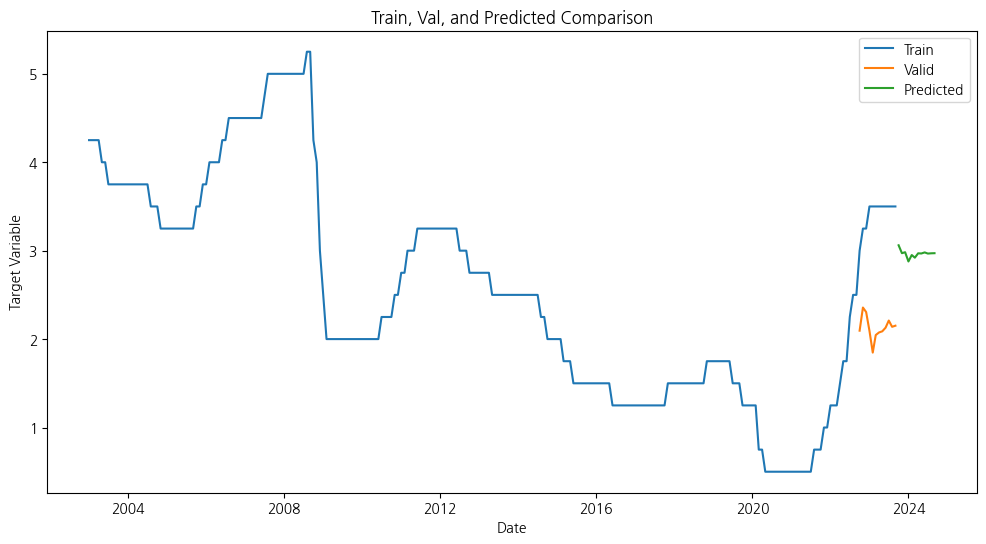

In [ ]:
# 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data['기준금리'], label='Train')
plt.plot(results_v12.index, results_v12['Val'], label='Valid')
plt.plot(results12.index, results12['Predicted'], label='Predicted')
plt.title('Train, Val, and Predicted Comparison')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

## 18개월

### 3-1) VECM 모델훈련

In [ ]:
# train 데이터로 모델 훈련
modelV = VECM(df_diff, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = modelV.fit()

In [ ]:
# 미래의 독립변수 예측
future_steps = 18  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, :-1]

In [ ]:
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum(axis=0) + np.array(imp.iloc[-1,:]).reshape(1,-1)

# 미래의 독립변수 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[[5.04358431e+00 4.51091463e+00 4.41187606e+00 1.00313957e+00
  9.06903658e-01 1.00482947e+00 1.01592572e+00 8.14782855e-01
  8.96575369e-01 1.00499643e+00 9.08897333e-01 4.50425347e-01
  7.30824236e-01 4.04420808e-02 8.00566789e-01 2.76647421e-01
  4.66297071e+00 9.84489903e-01]
 [5.15561871e+00 4.73399023e+00 4.61238243e+00 1.00428402e+00
  9.01896687e-01 1.00967147e+00 1.00397017e+00 8.13078560e-01
  8.97285648e-01 9.92023618e-01 8.59781503e-01 4.63679989e-01
  7.13221056e-01 4.18033563e-02 8.18535145e-01 3.80980815e-01
  4.85688409e+00 9.83773515e-01]
 [5.14743029e+00 4.77979332e+00 4.68440432e+00 1.00740865e+00
  8.94736167e-01 1.01345349e+00 1.01263864e+00 8.14570329e-01
  9.09653967e-01 1.00924330e+00 9.09241484e-01 4.65739487e-01
  7.06689105e-01 4.41589954e-02 8.31936913e-01 4.40565474e-01
  4.92435304e+00 9.83460097e-01]
 [5.05473244e+00 4.69713948e+00 4.65102020e+00 1.01097040e+00
  9.12156656e-01 1.01732551e+00 1.00895286e+00 8.26262259e-0

### 3-2) 독립변수 생성

In [ ]:
idx = pd.date_range(start='2023-10-01', periods=future_steps, freq='MS')
future_df18 = pd.DataFrame(data=future_forecast, columns=imp.columns, index=idx)

In [ ]:
future_df18

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원)
2023-10-01,5.043584,4.510915,4.411876,1.003140,0.906904,1.004829,1.015926,0.814783,0.896575,1.004996,0.908897,0.450425,0.730824,0.040442,0.800567,0.276647,4.662971,0.984490
2023-11-01,5.155619,4.733990,4.612382,1.004284,0.901897,1.009671,1.003970,0.813079,0.897286,0.992024,0.859782,0.463680,0.713221,0.041803,0.818535,0.380981,4.856884,0.983774
2023-12-01,5.147430,4.779793,4.684404,1.007409,0.894736,1.013453,1.012639,0.814570,0.909654,1.009243,0.909241,0.465739,0.706689,0.044159,0.831937,0.440565,4.924353,0.983460
2024-01-01,5.054732,4.697139,4.651020,1.010970,0.912157,1.017326,1.008953,0.826262,0.922013,1.001956,0.868210,0.500469,0.706951,0.040427,0.848610,0.491552,4.926137,1.006308
2024-02-01,5.131210,4.780452,4.733655,1.015625,0.929065,1.020893,1.008988,0.832955,0.924586,1.000980,0.898751,0.476316,0.711759,0.036172,0.840146,0.478164,5.004605,1.002871
2024-03-01,5.149210,4.782960,4.709681,1.019362,0.933244,1.025035,1.007728,0.835363,0.925886,0.999690,0.871369,0.486888,0.712730,0.034549,0.847702,0.439876,4.980541,1.013573
2024-04-01,5.183697,4.786049,4.709218,1.023760,0.927194,1.029002,1.010300,0.839525,0.925005,1.004724,0.890951,0.465350,0.717392,0.035469,0.838530,0.403999,4.978455,1.015614
2024-05-01,5.216138,4.810425,4.728708,1.027482,0.931860,1.033694,1.008095,0.841304,0.927909,1.000774,0.878963,0.475385,0.719942,0.033370,0.842315,0.406501,4.998015,1.023179
2024-06-01,5.291250,4.877446,4.778151,1.031400,0.934335,1.038771,1.008900,0.842356,0.930143,1.001609,0.888395,0.458940,0.724350,0.031891,0.840051,0.433516,5.033341,1.023624
2024-07-01,5.324352,4.906862,4.796966,1.034875,0.936216,1.043593,1.008043,0.843258,0.935584,1.000540,0.878828,0.467484,0.727149,0.029136,0.847924,0.447911,5.045182,1.028119


### 3-3) 데이터 LSTM으로 형태변환

In [ ]:
# X와 y로 분리
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset.iloc[i:(i + time_steps), :-1]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_steps, -1])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
train_time = -18
X_train, y_train = create_dataset(all_data.iloc[:train_time,:], time_steps)
X_val, y_val = create_dataset(all_data.iloc[train_time-1:,:], time_steps)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((230, 1, 18), (230,), (18, 1, 18), (18,))

### 3-4) LSTM모델 훈련

In [ ]:
# LSTM 모델 생성
modelL = Sequential()
modelL.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
modelL.add(Dropout(0.3))

modelL.add(Dense(16))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(8))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(1))
modelL.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

### 씨드 고정해야함
modelL.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/300
15/15 - 4s - loss: 10.4438 - val_loss: 10.6200 - 4s/epoch - 271ms/step
Epoch 2/300
15/15 - 0s - loss: 8.4338 - val_loss: 10.1350 - 112ms/epoch - 7ms/step
Epoch 3/300
15/15 - 0s - loss: 7.7266 - val_loss: 10.0611 - 111ms/epoch - 7ms/step
Epoch 4/300
15/15 - 0s - loss: 7.2828 - val_loss: 10.0085 - 100ms/epoch - 7ms/step
Epoch 5/300
15/15 - 0s - loss: 7.0886 - val_loss: 9.6366 - 98ms/epoch - 7ms/step
Epoch 6/300
15/15 - 0s - loss: 6.3958 - val_loss: 9.3355 - 98ms/epoch - 7ms/step
Epoch 7/300
15/15 - 0s - loss: 6.3334 - val_loss: 8.9642 - 125ms/epoch - 8ms/step
Epoch 8/300
15/15 - 0s - loss: 6.1777 - val_loss: 8.5485 - 118ms/epoch - 8ms/step
Epoch 9/300
15/15 - 0s - loss: 5.6657 - val_loss: 8.1940 - 103ms/epoch - 7ms/step
Epoch 10/300
15/15 - 0s - loss: 5.8394 - val_loss: 7.9613 - 115ms/epoch - 8ms/step
Epoch 11/300
15/15 - 0s - loss: 5.0588 - val_loss: 7.7400 - 122ms/epoch - 8ms/step
Epoch 12/300
15/15 - 0s - loss: 5.3295 - val_loss: 7.6051 - 121ms/epoch - 8ms/step
Epoch 13/30

In [ ]:
val_pred = modelL.predict(X_val)

1/1 [==============================] - 0s 452ms/step


In [ ]:
future_date = future_steps
results_v18 = pd.DataFrame({'Val':val_pred.reshape(-1)}, index=all_data.index[-future_date:])
results_v18

,Val
날짜,
2022-04-01,1.601578
2022-05-01,1.769212
2022-06-01,1.772482
2022-07-01,1.875550
2022-08-01,1.844775
2022-09-01,1.969516
2022-10-01,2.163730
2022-11-01,2.425172
2022-12-01,2.387624


### 3-5) 기준금리 예측

In [ ]:
f_x_train, f_y_train = create_dataset(all_data, time_steps)
modelL.fit(f_x_train, f_y_train, epochs=500, batch_size=16, verbose=2, callbacks=[early_stopping])

Epoch 1/500


16/16 - 0s - loss: 0.8635 - 58ms/epoch - 4ms/step
Epoch 2/500


16/16 - 0s - loss: 0.8863 - 51ms/epoch - 3ms/step
Epoch 3/500


16/16 - 0s - loss: 0.8224 - 54ms/epoch - 3ms/step
Epoch 4/500


16/16 - 0s - loss: 0.9382 - 50ms/epoch - 3ms/step
Epoch 5/500


16/16 - 0s - loss: 0.8892 - 52ms/epoch - 3ms/step
Epoch 6/500


16/16 - 0s - loss: 0.7836 - 53ms/epoch - 3ms/step
Epoch 7/500


16/16 - 0s - loss: 0.9374 - 59ms/epoch - 4ms/step
Epoch 8/500


16/16 - 0s - loss: 0.8780 - 54ms/epoch - 3ms/step
Epoch 9/500


16/16 - 0s - loss: 0.7097 - 57ms/epoch - 4ms/step
Epoch 10/500


16/16 - 0s - loss: 0.7706 - 60ms/epoch - 4ms/step
Epoch 11/500


16/16 - 0s - loss: 0.7859 - 52ms/epoch - 3ms/step
Epoch 12/500


16/16 - 0s - loss: 0.7608 - 58ms/epoch - 4ms/step
Epoch 13/500


16/16 - 0s - loss: 0.7651 - 55ms/epoch - 3ms/step
Epoch 14/500


16/16 - 0s - loss: 0.6950 - 50ms/epoch - 3ms/step
Epoch 15/500


16/16 - 0s - loss: 0.7246 - 52ms/epoch - 3ms/step
Epoch 16/500


16/16 - 0s - loss: 0.7232 - 56ms/epoch - 3ms/step
Epoch 17/500


16/16 - 0s - loss: 0.8063 - 51ms/epoch - 3ms/step
Epoch 18/500


16/16 - 0s - loss: 0.7500 - 52ms/epoch - 3ms/step
Epoch 19/500


16/16 - 0s - loss: 0.8714 - 51ms/epoch - 3ms/step
Epoch 20/500


16/16 - 0s - loss: 0.9119 - 58ms/epoch - 4ms/step
Epoch 21/500


16/16 - 0s - loss: 0.7183 - 51ms/epoch - 3ms/step
Epoch 22/500


16/16 - 0s - loss: 0.7577 - 59ms/epoch - 4ms/step
Epoch 23/500


16/16 - 0s - loss: 0.6943 - 59ms/epoch - 4ms/step
Epoch 24/500


16/16 - 0s - loss: 0.7304 - 48ms/epoch - 3ms/step
Epoch 25/500


16/16 - 0s - loss: 0.7333 - 52ms/epoch - 3ms/step
Epoch 26/500


16/16 - 0s - loss: 0.6847 - 64ms/epoch - 4ms/step
Epoch 27/500


16/16 - 0s - loss: 0.7744 - 61ms/epoch - 4ms/step
Epoch 28/500


16/16 - 0s - loss: 0.6582 - 60ms/epoch - 4ms/step
Epoch 29/500


16/16 - 0s - loss: 0.7449 - 54ms/epoch - 3ms/step
Epoch 30/500


16/16 - 0s - loss: 0.6348 - 50ms/epoch - 3ms/step
Epoch 31/500


16/16 - 0s - loss: 0.6973 - 55ms/epoch - 3ms/step
Epoch 32/500


16/16 - 0s - loss: 0.7054 - 51ms/epoch - 3ms/step
Epoch 33/500


16/16 - 0s - loss: 0.7097 - 50ms/epoch - 3ms/step
Epoch 34/500


16/16 - 0s - loss: 0.7402 - 55ms/epoch - 3ms/step
Epoch 35/500


16/16 - 0s - loss: 0.7758 - 53ms/epoch - 3ms/step
Epoch 36/500


16/16 - 0s - loss: 0.6767 - 60ms/epoch - 4ms/step
Epoch 37/500


16/16 - 0s - loss: 0.8440 - 56ms/epoch - 4ms/step
Epoch 38/500


16/16 - 0s - loss: 0.7081 - 54ms/epoch - 3ms/step
Epoch 39/500


16/16 - 0s - loss: 0.6556 - 52ms/epoch - 3ms/step
Epoch 40/500


16/16 - 0s - loss: 0.6059 - 50ms/epoch - 3ms/step
Epoch 41/500


16/16 - 0s - loss: 0.6619 - 53ms/epoch - 3ms/step
Epoch 42/500


16/16 - 0s - loss: 0.6499 - 54ms/epoch - 3ms/step
Epoch 43/500


16/16 - 0s - loss: 0.6984 - 58ms/epoch - 4ms/step
Epoch 44/500


16/16 - 0s - loss: 0.6589 - 56ms/epoch - 3ms/step
Epoch 45/500


16/16 - 0s - loss: 0.8694 - 48ms/epoch - 3ms/step
Epoch 46/500


16/16 - 0s - loss: 0.6642 - 52ms/epoch - 3ms/step
Epoch 47/500


16/16 - 0s - loss: 0.5069 - 55ms/epoch - 3ms/step
Epoch 48/500


16/16 - 0s - loss: 0.6527 - 52ms/epoch - 3ms/step
Epoch 49/500


16/16 - 0s - loss: 0.6449 - 50ms/epoch - 3ms/step
Epoch 50/500


16/16 - 0s - loss: 0.5965 - 49ms/epoch - 3ms/step
Epoch 51/500


16/16 - 0s - loss: 0.6841 - 51ms/epoch - 3ms/step
Epoch 52/500


16/16 - 0s - loss: 0.6468 - 52ms/epoch - 3ms/step
Epoch 53/500


16/16 - 0s - loss: 0.6794 - 51ms/epoch - 3ms/step
Epoch 54/500


16/16 - 0s - loss: 0.6657 - 49ms/epoch - 3ms/step
Epoch 55/500


16/16 - 0s - loss: 0.6687 - 54ms/epoch - 3ms/step
Epoch 56/500


16/16 - 0s - loss: 0.6146 - 53ms/epoch - 3ms/step
Epoch 57/500


16/16 - 0s - loss: 0.5544 - 54ms/epoch - 3ms/step
Epoch 58/500


16/16 - 0s - loss: 0.7581 - 58ms/epoch - 4ms/step
Epoch 59/500


16/16 - 0s - loss: 0.6304 - 52ms/epoch - 3ms/step
Epoch 60/500


16/16 - 0s - loss: 0.5441 - 49ms/epoch - 3ms/step
Epoch 61/500


16/16 - 0s - loss: 0.5602 - 69ms/epoch - 4ms/step
Epoch 62/500


16/16 - 0s - loss: 0.6812 - 57ms/epoch - 4ms/step
Epoch 63/500


16/16 - 0s - loss: 0.5182 - 58ms/epoch - 4ms/step
Epoch 64/500


16/16 - 0s - loss: 0.5984 - 54ms/epoch - 3ms/step
Epoch 65/500


16/16 - 0s - loss: 0.6309 - 51ms/epoch - 3ms/step
Epoch 66/500


16/16 - 0s - loss: 0.7140 - 62ms/epoch - 4ms/step
Epoch 67/500


16/16 - 0s - loss: 0.6372 - 54ms/epoch - 3ms/step
Epoch 68/500


16/16 - 0s - loss: 0.6101 - 55ms/epoch - 3ms/step
Epoch 69/500


16/16 - 0s - loss: 0.5198 - 53ms/epoch - 3ms/step
Epoch 70/500


16/16 - 0s - loss: 0.6796 - 51ms/epoch - 3ms/step
Epoch 71/500


16/16 - 0s - loss: 0.5547 - 51ms/epoch - 3ms/step
Epoch 72/500


16/16 - 0s - loss: 0.6055 - 53ms/epoch - 3ms/step
Epoch 73/500


16/16 - 0s - loss: 0.5957 - 54ms/epoch - 3ms/step
Epoch 74/500


16/16 - 0s - loss: 0.5783 - 52ms/epoch - 3ms/step
Epoch 75/500


16/16 - 0s - loss: 0.6747 - 52ms/epoch - 3ms/step
Epoch 76/500


16/16 - 0s - loss: 0.6518 - 69ms/epoch - 4ms/step
Epoch 77/500


16/16 - 0s - loss: 0.5778 - 76ms/epoch - 5ms/step
Epoch 78/500


16/16 - 0s - loss: 0.7475 - 82ms/epoch - 5ms/step
Epoch 79/500


16/16 - 0s - loss: 0.4704 - 80ms/epoch - 5ms/step
Epoch 80/500


16/16 - 0s - loss: 0.6990 - 66ms/epoch - 4ms/step
Epoch 81/500


16/16 - 0s - loss: 0.7114 - 68ms/epoch - 4ms/step
Epoch 82/500


16/16 - 0s - loss: 0.6430 - 78ms/epoch - 5ms/step
Epoch 83/500


16/16 - 0s - loss: 0.7174 - 79ms/epoch - 5ms/step
Epoch 84/500


16/16 - 0s - loss: 0.6656 - 80ms/epoch - 5ms/step
Epoch 85/500


16/16 - 0s - loss: 0.6086 - 68ms/epoch - 4ms/step
Epoch 86/500


16/16 - 0s - loss: 0.5869 - 72ms/epoch - 5ms/step
Epoch 87/500


16/16 - 0s - loss: 0.4807 - 68ms/epoch - 4ms/step
Epoch 88/500


16/16 - 0s - loss: 0.6382 - 67ms/epoch - 4ms/step
Epoch 89/500


16/16 - 0s - loss: 0.5438 - 71ms/epoch - 4ms/step
Epoch 90/500


16/16 - 0s - loss: 0.5819 - 69ms/epoch - 4ms/step
Epoch 91/500


16/16 - 0s - loss: 0.4893 - 83ms/epoch - 5ms/step
Epoch 92/500


16/16 - 0s - loss: 0.6444 - 69ms/epoch - 4ms/step
Epoch 93/500


16/16 - 0s - loss: 0.5690 - 67ms/epoch - 4ms/step
Epoch 94/500


16/16 - 0s - loss: 0.5916 - 69ms/epoch - 4ms/step
Epoch 95/500


16/16 - 0s - loss: 0.6601 - 69ms/epoch - 4ms/step
Epoch 96/500


16/16 - 0s - loss: 0.4726 - 69ms/epoch - 4ms/step
Epoch 97/500


16/16 - 0s - loss: 0.4629 - 71ms/epoch - 4ms/step
Epoch 98/500


16/16 - 0s - loss: 0.5252 - 72ms/epoch - 5ms/step
Epoch 99/500


16/16 - 0s - loss: 0.5822 - 66ms/epoch - 4ms/step
Epoch 100/500


16/16 - 0s - loss: 0.5922 - 70ms/epoch - 4ms/step
Epoch 101/500


16/16 - 0s - loss: 0.5114 - 66ms/epoch - 4ms/step
Epoch 102/500


16/16 - 0s - loss: 0.5952 - 66ms/epoch - 4ms/step
Epoch 103/500


16/16 - 0s - loss: 0.6021 - 70ms/epoch - 4ms/step
Epoch 104/500


16/16 - 0s - loss: 0.5495 - 71ms/epoch - 4ms/step
Epoch 105/500


16/16 - 0s - loss: 0.5263 - 75ms/epoch - 5ms/step
Epoch 106/500


16/16 - 0s - loss: 0.6261 - 78ms/epoch - 5ms/step
Epoch 107/500


16/16 - 0s - loss: 0.5762 - 80ms/epoch - 5ms/step
Epoch 108/500


16/16 - 0s - loss: 0.5586 - 72ms/epoch - 4ms/step
Epoch 109/500


16/16 - 0s - loss: 0.5753 - 72ms/epoch - 5ms/step
Epoch 110/500


16/16 - 0s - loss: 0.5491 - 68ms/epoch - 4ms/step
Epoch 111/500


16/16 - 0s - loss: 0.4940 - 72ms/epoch - 5ms/step
Epoch 112/500


16/16 - 0s - loss: 0.5605 - 71ms/epoch - 4ms/step
Epoch 113/500


16/16 - 0s - loss: 0.5286 - 74ms/epoch - 5ms/step
Epoch 114/500


16/16 - 0s - loss: 0.5613 - 79ms/epoch - 5ms/step
Epoch 115/500


16/16 - 0s - loss: 0.5438 - 72ms/epoch - 5ms/step
Epoch 116/500


16/16 - 0s - loss: 0.4765 - 77ms/epoch - 5ms/step
Epoch 117/500


16/16 - 0s - loss: 0.5295 - 81ms/epoch - 5ms/step
Epoch 118/500


16/16 - 0s - loss: 0.4328 - 77ms/epoch - 5ms/step
Epoch 119/500


16/16 - 0s - loss: 0.5229 - 80ms/epoch - 5ms/step
Epoch 120/500


16/16 - 0s - loss: 0.4250 - 75ms/epoch - 5ms/step
Epoch 121/500


16/16 - 0s - loss: 0.3901 - 77ms/epoch - 5ms/step
Epoch 122/500


16/16 - 0s - loss: 0.4191 - 68ms/epoch - 4ms/step
Epoch 123/500


16/16 - 0s - loss: 0.4597 - 70ms/epoch - 4ms/step
Epoch 124/500


16/16 - 0s - loss: 0.5823 - 75ms/epoch - 5ms/step
Epoch 125/500


16/16 - 0s - loss: 0.5070 - 65ms/epoch - 4ms/step
Epoch 126/500


16/16 - 0s - loss: 0.5806 - 72ms/epoch - 4ms/step
Epoch 127/500


16/16 - 0s - loss: 0.5773 - 69ms/epoch - 4ms/step
Epoch 128/500


16/16 - 0s - loss: 0.6312 - 77ms/epoch - 5ms/step
Epoch 129/500


16/16 - 0s - loss: 0.5458 - 67ms/epoch - 4ms/step
Epoch 130/500


16/16 - 0s - loss: 0.5265 - 68ms/epoch - 4ms/step
Epoch 131/500


16/16 - 0s - loss: 0.5785 - 69ms/epoch - 4ms/step
Epoch 132/500


16/16 - 0s - loss: 0.4606 - 77ms/epoch - 5ms/step
Epoch 133/500


16/16 - 0s - loss: 0.5710 - 76ms/epoch - 5ms/step
Epoch 134/500


16/16 - 0s - loss: 0.4896 - 67ms/epoch - 4ms/step
Epoch 135/500


16/16 - 0s - loss: 0.4520 - 71ms/epoch - 4ms/step
Epoch 136/500


16/16 - 0s - loss: 0.5339 - 79ms/epoch - 5ms/step
Epoch 137/500


16/16 - 0s - loss: 0.5407 - 73ms/epoch - 5ms/step
Epoch 138/500


16/16 - 0s - loss: 0.5528 - 72ms/epoch - 5ms/step
Epoch 139/500


16/16 - 0s - loss: 0.4543 - 76ms/epoch - 5ms/step
Epoch 140/500


16/16 - 0s - loss: 0.4676 - 73ms/epoch - 5ms/step
Epoch 141/500


16/16 - 0s - loss: 0.4780 - 78ms/epoch - 5ms/step
Epoch 142/500


16/16 - 0s - loss: 0.4913 - 70ms/epoch - 4ms/step
Epoch 143/500


16/16 - 0s - loss: 0.4926 - 77ms/epoch - 5ms/step
Epoch 144/500


16/16 - 0s - loss: 0.5005 - 85ms/epoch - 5ms/step
Epoch 145/500


16/16 - 0s - loss: 0.5329 - 77ms/epoch - 5ms/step
Epoch 146/500


16/16 - 0s - loss: 0.4561 - 74ms/epoch - 5ms/step
Epoch 147/500


16/16 - 0s - loss: 0.5539 - 89ms/epoch - 6ms/step
Epoch 148/500


16/16 - 0s - loss: 0.4462 - 80ms/epoch - 5ms/step
Epoch 149/500


16/16 - 0s - loss: 0.4342 - 69ms/epoch - 4ms/step
Epoch 150/500


16/16 - 0s - loss: 0.5568 - 68ms/epoch - 4ms/step
Epoch 151/500


16/16 - 0s - loss: 0.4803 - 71ms/epoch - 4ms/step
Epoch 152/500


16/16 - 0s - loss: 0.6491 - 77ms/epoch - 5ms/step
Epoch 153/500


16/16 - 0s - loss: 0.5114 - 71ms/epoch - 4ms/step
Epoch 154/500


16/16 - 0s - loss: 0.4205 - 75ms/epoch - 5ms/step
Epoch 155/500


16/16 - 0s - loss: 0.4196 - 67ms/epoch - 4ms/step
Epoch 156/500


16/16 - 0s - loss: 0.4154 - 69ms/epoch - 4ms/step
Epoch 157/500


16/16 - 0s - loss: 0.4653 - 72ms/epoch - 5ms/step
Epoch 158/500


16/16 - 0s - loss: 0.4114 - 71ms/epoch - 4ms/step
Epoch 159/500


16/16 - 0s - loss: 0.5311 - 72ms/epoch - 5ms/step
Epoch 160/500


16/16 - 0s - loss: 0.6005 - 70ms/epoch - 4ms/step
Epoch 161/500


16/16 - 0s - loss: 0.5034 - 83ms/epoch - 5ms/step
Epoch 162/500


16/16 - 0s - loss: 0.4777 - 69ms/epoch - 4ms/step
Epoch 163/500


16/16 - 0s - loss: 0.4402 - 68ms/epoch - 4ms/step
Epoch 164/500


16/16 - 0s - loss: 0.4633 - 65ms/epoch - 4ms/step
Epoch 165/500


16/16 - 0s - loss: 0.5953 - 68ms/epoch - 4ms/step
Epoch 166/500


16/16 - 0s - loss: 0.4972 - 67ms/epoch - 4ms/step
Epoch 167/500


16/16 - 0s - loss: 0.4567 - 67ms/epoch - 4ms/step
Epoch 168/500


16/16 - 0s - loss: 0.4822 - 68ms/epoch - 4ms/step
Epoch 169/500


16/16 - 0s - loss: 0.4552 - 69ms/epoch - 4ms/step
Epoch 170/500


16/16 - 0s - loss: 0.4622 - 78ms/epoch - 5ms/step
Epoch 171/500


16/16 - 0s - loss: 0.4698 - 76ms/epoch - 5ms/step
Epoch 172/500


16/16 - 0s - loss: 0.4547 - 76ms/epoch - 5ms/step
Epoch 173/500


16/16 - 0s - loss: 0.4500 - 76ms/epoch - 5ms/step
Epoch 174/500


16/16 - 0s - loss: 0.5411 - 78ms/epoch - 5ms/step
Epoch 175/500


16/16 - 0s - loss: 0.4900 - 86ms/epoch - 5ms/step
Epoch 176/500


16/16 - 0s - loss: 0.4230 - 87ms/epoch - 5ms/step
Epoch 177/500


16/16 - 0s - loss: 0.4877 - 78ms/epoch - 5ms/step
Epoch 178/500


16/16 - 0s - loss: 0.5129 - 77ms/epoch - 5ms/step
Epoch 179/500


16/16 - 0s - loss: 0.4793 - 75ms/epoch - 5ms/step
Epoch 180/500


16/16 - 0s - loss: 0.4859 - 72ms/epoch - 4ms/step
Epoch 181/500


16/16 - 0s - loss: 0.4615 - 75ms/epoch - 5ms/step
Epoch 182/500


16/16 - 0s - loss: 0.4319 - 72ms/epoch - 5ms/step
Epoch 183/500


16/16 - 0s - loss: 0.4208 - 75ms/epoch - 5ms/step
Epoch 184/500


16/16 - 0s - loss: 0.4544 - 64ms/epoch - 4ms/step
Epoch 185/500


16/16 - 0s - loss: 0.5128 - 50ms/epoch - 3ms/step
Epoch 186/500


16/16 - 0s - loss: 0.4261 - 51ms/epoch - 3ms/step
Epoch 187/500


16/16 - 0s - loss: 0.3976 - 51ms/epoch - 3ms/step
Epoch 188/500


16/16 - 0s - loss: 0.3747 - 54ms/epoch - 3ms/step
Epoch 189/500


16/16 - 0s - loss: 0.4002 - 61ms/epoch - 4ms/step
Epoch 190/500


16/16 - 0s - loss: 0.5394 - 52ms/epoch - 3ms/step
Epoch 191/500


16/16 - 0s - loss: 0.4886 - 55ms/epoch - 3ms/step
Epoch 192/500


16/16 - 0s - loss: 0.4905 - 54ms/epoch - 3ms/step
Epoch 193/500


16/16 - 0s - loss: 0.5173 - 57ms/epoch - 4ms/step
Epoch 194/500


16/16 - 0s - loss: 0.4710 - 55ms/epoch - 3ms/step
Epoch 195/500


16/16 - 0s - loss: 0.4776 - 57ms/epoch - 4ms/step
Epoch 196/500


16/16 - 0s - loss: 0.5427 - 61ms/epoch - 4ms/step
Epoch 197/500


16/16 - 0s - loss: 0.4060 - 58ms/epoch - 4ms/step
Epoch 198/500


16/16 - 0s - loss: 0.4778 - 54ms/epoch - 3ms/step
Epoch 199/500


16/16 - 0s - loss: 0.4631 - 55ms/epoch - 3ms/step
Epoch 200/500


16/16 - 0s - loss: 0.4130 - 57ms/epoch - 4ms/step
Epoch 201/500


16/16 - 0s - loss: 0.3889 - 56ms/epoch - 4ms/step
Epoch 202/500


16/16 - 0s - loss: 0.4818 - 53ms/epoch - 3ms/step
Epoch 203/500


16/16 - 0s - loss: 0.4718 - 58ms/epoch - 4ms/step
Epoch 204/500


16/16 - 0s - loss: 0.3484 - 59ms/epoch - 4ms/step
Epoch 205/500


16/16 - 0s - loss: 0.4242 - 56ms/epoch - 3ms/step
Epoch 206/500


16/16 - 0s - loss: 0.3554 - 60ms/epoch - 4ms/step
Epoch 207/500


16/16 - 0s - loss: 0.4350 - 55ms/epoch - 3ms/step
Epoch 208/500


16/16 - 0s - loss: 0.4855 - 52ms/epoch - 3ms/step
Epoch 209/500


16/16 - 0s - loss: 0.3817 - 55ms/epoch - 3ms/step
Epoch 210/500


16/16 - 0s - loss: 0.5878 - 61ms/epoch - 4ms/step
Epoch 211/500


16/16 - 0s - loss: 0.4231 - 53ms/epoch - 3ms/step
Epoch 212/500


16/16 - 0s - loss: 0.4123 - 60ms/epoch - 4ms/step
Epoch 213/500


16/16 - 0s - loss: 0.4326 - 49ms/epoch - 3ms/step
Epoch 214/500


16/16 - 0s - loss: 0.4295 - 53ms/epoch - 3ms/step
Epoch 215/500


16/16 - 0s - loss: 0.4743 - 51ms/epoch - 3ms/step
Epoch 216/500


16/16 - 0s - loss: 0.3907 - 55ms/epoch - 3ms/step
Epoch 217/500


16/16 - 0s - loss: 0.4223 - 51ms/epoch - 3ms/step
Epoch 218/500


16/16 - 0s - loss: 0.3363 - 60ms/epoch - 4ms/step
Epoch 219/500


16/16 - 0s - loss: 0.3926 - 53ms/epoch - 3ms/step
Epoch 220/500


16/16 - 0s - loss: 0.3446 - 60ms/epoch - 4ms/step
Epoch 221/500


16/16 - 0s - loss: 0.3480 - 57ms/epoch - 4ms/step
Epoch 222/500


16/16 - 0s - loss: 0.3998 - 61ms/epoch - 4ms/step
Epoch 223/500


16/16 - 0s - loss: 0.3522 - 67ms/epoch - 4ms/step
Epoch 224/500


16/16 - 0s - loss: 0.4006 - 53ms/epoch - 3ms/step
Epoch 225/500


16/16 - 0s - loss: 0.4072 - 56ms/epoch - 3ms/step
Epoch 226/500


16/16 - 0s - loss: 0.3396 - 58ms/epoch - 4ms/step
Epoch 227/500


16/16 - 0s - loss: 0.4053 - 59ms/epoch - 4ms/step
Epoch 228/500


16/16 - 0s - loss: 0.3886 - 58ms/epoch - 4ms/step
Epoch 229/500


16/16 - 0s - loss: 0.4046 - 59ms/epoch - 4ms/step
Epoch 230/500


16/16 - 0s - loss: 0.3863 - 56ms/epoch - 4ms/step
Epoch 231/500


16/16 - 0s - loss: 0.3910 - 58ms/epoch - 4ms/step
Epoch 232/500


16/16 - 0s - loss: 0.3577 - 53ms/epoch - 3ms/step
Epoch 233/500


16/16 - 0s - loss: 0.4176 - 57ms/epoch - 4ms/step
Epoch 234/500


16/16 - 0s - loss: 0.4645 - 55ms/epoch - 3ms/step
Epoch 235/500


16/16 - 0s - loss: 0.4585 - 75ms/epoch - 5ms/step
Epoch 236/500


16/16 - 0s - loss: 0.4777 - 64ms/epoch - 4ms/step
Epoch 237/500


16/16 - 0s - loss: 0.4571 - 60ms/epoch - 4ms/step
Epoch 238/500


16/16 - 0s - loss: 0.4429 - 58ms/epoch - 4ms/step
Epoch 239/500


16/16 - 0s - loss: 0.3913 - 64ms/epoch - 4ms/step
Epoch 240/500


16/16 - 0s - loss: 0.4533 - 54ms/epoch - 3ms/step
Epoch 241/500


16/16 - 0s - loss: 0.4350 - 56ms/epoch - 3ms/step
Epoch 242/500


16/16 - 0s - loss: 0.4364 - 57ms/epoch - 4ms/step
Epoch 243/500


16/16 - 0s - loss: 0.4037 - 55ms/epoch - 3ms/step
Epoch 244/500


16/16 - 0s - loss: 0.4197 - 53ms/epoch - 3ms/step
Epoch 245/500


16/16 - 0s - loss: 0.4002 - 54ms/epoch - 3ms/step
Epoch 246/500


16/16 - 0s - loss: 0.4770 - 56ms/epoch - 4ms/step
Epoch 247/500


16/16 - 0s - loss: 0.4369 - 53ms/epoch - 3ms/step
Epoch 248/500


16/16 - 0s - loss: 0.3908 - 52ms/epoch - 3ms/step
Epoch 249/500


16/16 - 0s - loss: 0.3778 - 52ms/epoch - 3ms/step
Epoch 250/500


16/16 - 0s - loss: 0.4033 - 50ms/epoch - 3ms/step
Epoch 251/500


16/16 - 0s - loss: 0.3463 - 55ms/epoch - 3ms/step
Epoch 252/500


16/16 - 0s - loss: 0.4015 - 50ms/epoch - 3ms/step
Epoch 253/500


16/16 - 0s - loss: 0.4047 - 56ms/epoch - 3ms/step
Epoch 254/500


16/16 - 0s - loss: 0.4657 - 56ms/epoch - 4ms/step
Epoch 255/500


16/16 - 0s - loss: 0.3847 - 55ms/epoch - 3ms/step
Epoch 256/500


16/16 - 0s - loss: 0.3938 - 62ms/epoch - 4ms/step
Epoch 257/500


16/16 - 0s - loss: 0.3912 - 60ms/epoch - 4ms/step
Epoch 258/500


16/16 - 0s - loss: 0.3942 - 56ms/epoch - 4ms/step
Epoch 259/500


16/16 - 0s - loss: 0.4239 - 54ms/epoch - 3ms/step
Epoch 260/500


16/16 - 0s - loss: 0.3261 - 59ms/epoch - 4ms/step
Epoch 261/500


16/16 - 0s - loss: 0.4472 - 62ms/epoch - 4ms/step
Epoch 262/500


16/16 - 0s - loss: 0.4692 - 58ms/epoch - 4ms/step
Epoch 263/500


16/16 - 0s - loss: 0.3525 - 53ms/epoch - 3ms/step
Epoch 264/500


16/16 - 0s - loss: 0.4261 - 55ms/epoch - 3ms/step
Epoch 265/500


16/16 - 0s - loss: 0.4712 - 55ms/epoch - 3ms/step
Epoch 266/500


16/16 - 0s - loss: 0.4045 - 60ms/epoch - 4ms/step
Epoch 267/500


16/16 - 0s - loss: 0.4069 - 56ms/epoch - 4ms/step
Epoch 268/500


16/16 - 0s - loss: 0.4306 - 53ms/epoch - 3ms/step
Epoch 269/500


16/16 - 0s - loss: 0.3787 - 57ms/epoch - 4ms/step
Epoch 270/500


16/16 - 0s - loss: 0.5063 - 57ms/epoch - 4ms/step
Epoch 271/500


16/16 - 0s - loss: 0.3055 - 55ms/epoch - 3ms/step
Epoch 272/500


16/16 - 0s - loss: 0.4518 - 62ms/epoch - 4ms/step
Epoch 273/500


16/16 - 0s - loss: 0.3919 - 67ms/epoch - 4ms/step
Epoch 274/500


16/16 - 0s - loss: 0.4166 - 54ms/epoch - 3ms/step
Epoch 275/500


16/16 - 0s - loss: 0.4569 - 57ms/epoch - 4ms/step
Epoch 276/500


16/16 - 0s - loss: 0.3792 - 63ms/epoch - 4ms/step
Epoch 277/500


16/16 - 0s - loss: 0.3926 - 57ms/epoch - 4ms/step
Epoch 278/500


16/16 - 0s - loss: 0.4028 - 59ms/epoch - 4ms/step
Epoch 279/500


16/16 - 0s - loss: 0.4831 - 63ms/epoch - 4ms/step
Epoch 280/500


16/16 - 0s - loss: 0.3662 - 57ms/epoch - 4ms/step
Epoch 281/500


16/16 - 0s - loss: 0.3169 - 60ms/epoch - 4ms/step
Epoch 282/500


16/16 - 0s - loss: 0.3797 - 60ms/epoch - 4ms/step
Epoch 283/500


16/16 - 0s - loss: 0.4044 - 54ms/epoch - 3ms/step
Epoch 284/500


16/16 - 0s - loss: 0.3390 - 58ms/epoch - 4ms/step
Epoch 285/500


16/16 - 0s - loss: 0.4293 - 52ms/epoch - 3ms/step
Epoch 286/500


16/16 - 0s - loss: 0.3696 - 60ms/epoch - 4ms/step
Epoch 287/500


16/16 - 0s - loss: 0.3677 - 57ms/epoch - 4ms/step
Epoch 288/500


16/16 - 0s - loss: 0.3374 - 51ms/epoch - 3ms/step
Epoch 289/500


16/16 - 0s - loss: 0.3889 - 63ms/epoch - 4ms/step
Epoch 290/500


16/16 - 0s - loss: 0.4064 - 55ms/epoch - 3ms/step
Epoch 291/500


16/16 - 0s - loss: 0.4111 - 58ms/epoch - 4ms/step
Epoch 292/500


16/16 - 0s - loss: 0.3591 - 57ms/epoch - 4ms/step
Epoch 293/500


16/16 - 0s - loss: 0.4281 - 54ms/epoch - 3ms/step
Epoch 294/500


16/16 - 0s - loss: 0.3584 - 56ms/epoch - 4ms/step
Epoch 295/500


16/16 - 0s - loss: 0.4241 - 62ms/epoch - 4ms/step
Epoch 296/500


16/16 - 0s - loss: 0.4092 - 53ms/epoch - 3ms/step
Epoch 297/500


16/16 - 0s - loss: 0.3865 - 60ms/epoch - 4ms/step
Epoch 298/500


16/16 - 0s - loss: 0.4394 - 62ms/epoch - 4ms/step
Epoch 299/500


16/16 - 0s - loss: 0.3516 - 53ms/epoch - 3ms/step
Epoch 300/500


16/16 - 0s - loss: 0.3779 - 60ms/epoch - 4ms/step
Epoch 301/500


16/16 - 0s - loss: 0.4401 - 60ms/epoch - 4ms/step
Epoch 302/500


16/16 - 0s - loss: 0.4159 - 58ms/epoch - 4ms/step
Epoch 303/500


16/16 - 0s - loss: 0.3375 - 59ms/epoch - 4ms/step
Epoch 304/500


16/16 - 0s - loss: 0.4771 - 58ms/epoch - 4ms/step
Epoch 305/500


16/16 - 0s - loss: 0.3479 - 57ms/epoch - 4ms/step
Epoch 306/500


16/16 - 0s - loss: 0.3603 - 62ms/epoch - 4ms/step
Epoch 307/500


16/16 - 0s - loss: 0.3890 - 63ms/epoch - 4ms/step
Epoch 308/500


16/16 - 0s - loss: 0.3727 - 62ms/epoch - 4ms/step
Epoch 309/500


16/16 - 0s - loss: 0.3859 - 67ms/epoch - 4ms/step
Epoch 310/500


16/16 - 0s - loss: 0.3782 - 58ms/epoch - 4ms/step
Epoch 311/500


16/16 - 0s - loss: 0.3695 - 65ms/epoch - 4ms/step
Epoch 312/500


16/16 - 0s - loss: 0.4239 - 64ms/epoch - 4ms/step
Epoch 313/500


16/16 - 0s - loss: 0.4037 - 56ms/epoch - 4ms/step
Epoch 314/500


16/16 - 0s - loss: 0.3462 - 60ms/epoch - 4ms/step
Epoch 315/500


16/16 - 0s - loss: 0.3347 - 63ms/epoch - 4ms/step
Epoch 316/500


16/16 - 0s - loss: 0.3054 - 53ms/epoch - 3ms/step
Epoch 317/500


16/16 - 0s - loss: 0.3296 - 57ms/epoch - 4ms/step
Epoch 318/500


16/16 - 0s - loss: 0.3627 - 59ms/epoch - 4ms/step
Epoch 319/500


16/16 - 0s - loss: 0.5298 - 62ms/epoch - 4ms/step
Epoch 320/500


16/16 - 0s - loss: 0.4022 - 68ms/epoch - 4ms/step
Epoch 321/500


16/16 - 0s - loss: 0.4150 - 62ms/epoch - 4ms/step
Epoch 322/500


16/16 - 0s - loss: 0.3667 - 77ms/epoch - 5ms/step
Epoch 323/500


16/16 - 0s - loss: 0.5378 - 63ms/epoch - 4ms/step
Epoch 324/500


16/16 - 0s - loss: 0.3630 - 61ms/epoch - 4ms/step
Epoch 325/500


16/16 - 0s - loss: 0.3324 - 61ms/epoch - 4ms/step
Epoch 326/500


16/16 - 0s - loss: 0.3637 - 60ms/epoch - 4ms/step
Epoch 327/500


16/16 - 0s - loss: 0.3098 - 59ms/epoch - 4ms/step
Epoch 328/500


16/16 - 0s - loss: 0.3824 - 59ms/epoch - 4ms/step
Epoch 329/500


16/16 - 0s - loss: 0.4827 - 56ms/epoch - 3ms/step
Epoch 330/500


16/16 - 0s - loss: 0.3925 - 56ms/epoch - 3ms/step
Epoch 331/500


16/16 - 0s - loss: 0.4751 - 56ms/epoch - 4ms/step
Epoch 332/500


16/16 - 0s - loss: 0.3809 - 56ms/epoch - 3ms/step
Epoch 333/500


16/16 - 0s - loss: 0.3236 - 57ms/epoch - 4ms/step
Epoch 334/500


16/16 - 0s - loss: 0.3389 - 64ms/epoch - 4ms/step
Epoch 335/500


16/16 - 0s - loss: 0.4158 - 62ms/epoch - 4ms/step
Epoch 336/500


16/16 - 0s - loss: 0.4160 - 62ms/epoch - 4ms/step
Epoch 337/500


16/16 - 0s - loss: 0.3782 - 60ms/epoch - 4ms/step
Epoch 338/500


16/16 - 0s - loss: 0.4779 - 64ms/epoch - 4ms/step
Epoch 339/500


16/16 - 0s - loss: 0.3481 - 58ms/epoch - 4ms/step
Epoch 340/500


16/16 - 0s - loss: 0.3983 - 60ms/epoch - 4ms/step
Epoch 341/500


16/16 - 0s - loss: 0.3753 - 56ms/epoch - 4ms/step
Epoch 342/500


16/16 - 0s - loss: 0.3967 - 59ms/epoch - 4ms/step
Epoch 343/500


16/16 - 0s - loss: 0.3156 - 55ms/epoch - 3ms/step
Epoch 344/500


16/16 - 0s - loss: 0.3516 - 64ms/epoch - 4ms/step
Epoch 345/500


16/16 - 0s - loss: 0.3849 - 86ms/epoch - 5ms/step
Epoch 346/500


16/16 - 0s - loss: 0.3855 - 75ms/epoch - 5ms/step
Epoch 347/500


16/16 - 0s - loss: 0.3715 - 72ms/epoch - 4ms/step
Epoch 348/500


16/16 - 0s - loss: 0.3668 - 73ms/epoch - 5ms/step
Epoch 349/500


16/16 - 0s - loss: 0.3075 - 70ms/epoch - 4ms/step
Epoch 350/500


16/16 - 0s - loss: 0.3020 - 72ms/epoch - 5ms/step
Epoch 351/500


16/16 - 0s - loss: 0.3885 - 79ms/epoch - 5ms/step
Epoch 352/500


16/16 - 0s - loss: 0.3400 - 82ms/epoch - 5ms/step
Epoch 353/500


16/16 - 0s - loss: 0.3539 - 78ms/epoch - 5ms/step
Epoch 354/500


16/16 - 0s - loss: 0.3761 - 71ms/epoch - 4ms/step
Epoch 355/500


16/16 - 0s - loss: 0.3029 - 86ms/epoch - 5ms/step
Epoch 356/500


16/16 - 0s - loss: 0.4096 - 67ms/epoch - 4ms/step
Epoch 357/500


16/16 - 0s - loss: 0.3299 - 69ms/epoch - 4ms/step
Epoch 358/500


16/16 - 0s - loss: 0.3897 - 80ms/epoch - 5ms/step
Epoch 359/500


16/16 - 0s - loss: 0.4143 - 82ms/epoch - 5ms/step
Epoch 360/500


16/16 - 0s - loss: 0.4484 - 87ms/epoch - 5ms/step
Epoch 361/500


16/16 - 0s - loss: 0.4154 - 88ms/epoch - 6ms/step
Epoch 362/500


16/16 - 0s - loss: 0.3186 - 96ms/epoch - 6ms/step
Epoch 363/500


16/16 - 0s - loss: 0.3752 - 88ms/epoch - 6ms/step
Epoch 364/500


16/16 - 0s - loss: 0.3910 - 77ms/epoch - 5ms/step
Epoch 365/500


16/16 - 0s - loss: 0.3439 - 92ms/epoch - 6ms/step
Epoch 366/500


16/16 - 0s - loss: 0.3663 - 70ms/epoch - 4ms/step
Epoch 367/500


16/16 - 0s - loss: 0.4603 - 77ms/epoch - 5ms/step
Epoch 368/500


16/16 - 0s - loss: 0.3754 - 84ms/epoch - 5ms/step
Epoch 369/500


16/16 - 0s - loss: 0.3645 - 72ms/epoch - 5ms/step
Epoch 370/500


16/16 - 0s - loss: 0.3228 - 77ms/epoch - 5ms/step
Epoch 371/500


16/16 - 0s - loss: 0.3213 - 70ms/epoch - 4ms/step
Epoch 372/500


16/16 - 0s - loss: 0.3786 - 71ms/epoch - 4ms/step
Epoch 373/500


16/16 - 0s - loss: 0.2546 - 70ms/epoch - 4ms/step
Epoch 374/500


16/16 - 0s - loss: 0.3338 - 72ms/epoch - 5ms/step
Epoch 375/500


16/16 - 0s - loss: 0.3240 - 69ms/epoch - 4ms/step
Epoch 376/500


16/16 - 0s - loss: 0.4157 - 69ms/epoch - 4ms/step
Epoch 377/500


16/16 - 0s - loss: 0.4387 - 72ms/epoch - 4ms/step
Epoch 378/500


16/16 - 0s - loss: 0.2763 - 75ms/epoch - 5ms/step
Epoch 379/500


16/16 - 0s - loss: 0.2922 - 95ms/epoch - 6ms/step
Epoch 380/500


16/16 - 0s - loss: 0.4300 - 86ms/epoch - 5ms/step
Epoch 381/500


16/16 - 0s - loss: 0.4561 - 77ms/epoch - 5ms/step
Epoch 382/500


16/16 - 0s - loss: 0.3739 - 76ms/epoch - 5ms/step
Epoch 383/500


16/16 - 0s - loss: 0.3994 - 81ms/epoch - 5ms/step
Epoch 384/500


16/16 - 0s - loss: 0.3300 - 71ms/epoch - 4ms/step
Epoch 385/500


16/16 - 0s - loss: 0.3787 - 81ms/epoch - 5ms/step
Epoch 386/500


16/16 - 0s - loss: 0.3295 - 85ms/epoch - 5ms/step
Epoch 387/500


16/16 - 0s - loss: 0.3596 - 74ms/epoch - 5ms/step
Epoch 388/500


16/16 - 0s - loss: 0.3293 - 85ms/epoch - 5ms/step
Epoch 389/500


16/16 - 0s - loss: 0.3613 - 80ms/epoch - 5ms/step
Epoch 390/500


16/16 - 0s - loss: 0.3367 - 77ms/epoch - 5ms/step
Epoch 391/500


16/16 - 0s - loss: 0.2921 - 90ms/epoch - 6ms/step
Epoch 392/500


16/16 - 0s - loss: 0.3191 - 82ms/epoch - 5ms/step
Epoch 393/500


16/16 - 0s - loss: 0.3616 - 78ms/epoch - 5ms/step
Epoch 394/500


16/16 - 0s - loss: 0.3772 - 73ms/epoch - 5ms/step
Epoch 395/500


16/16 - 0s - loss: 0.3437 - 77ms/epoch - 5ms/step
Epoch 396/500


16/16 - 0s - loss: 0.3853 - 77ms/epoch - 5ms/step
Epoch 397/500


16/16 - 0s - loss: 0.3609 - 70ms/epoch - 4ms/step
Epoch 398/500


16/16 - 0s - loss: 0.3895 - 83ms/epoch - 5ms/step
Epoch 399/500


16/16 - 0s - loss: 0.3870 - 76ms/epoch - 5ms/step
Epoch 400/500


16/16 - 0s - loss: 0.3143 - 69ms/epoch - 4ms/step
Epoch 401/500


16/16 - 0s - loss: 0.3952 - 80ms/epoch - 5ms/step
Epoch 402/500


16/16 - 0s - loss: 0.3353 - 80ms/epoch - 5ms/step
Epoch 403/500


16/16 - 0s - loss: 0.3752 - 84ms/epoch - 5ms/step
Epoch 404/500


16/16 - 0s - loss: 0.2894 - 75ms/epoch - 5ms/step
Epoch 405/500


16/16 - 0s - loss: 0.3791 - 81ms/epoch - 5ms/step
Epoch 406/500


16/16 - 0s - loss: 0.3545 - 74ms/epoch - 5ms/step
Epoch 407/500


16/16 - 0s - loss: 0.3601 - 75ms/epoch - 5ms/step
Epoch 408/500


16/16 - 0s - loss: 0.3361 - 71ms/epoch - 4ms/step
Epoch 409/500


16/16 - 0s - loss: 0.4224 - 77ms/epoch - 5ms/step
Epoch 410/500


16/16 - 0s - loss: 0.3235 - 76ms/epoch - 5ms/step
Epoch 411/500


16/16 - 0s - loss: 0.3079 - 81ms/epoch - 5ms/step
Epoch 412/500


16/16 - 0s - loss: 0.3916 - 73ms/epoch - 5ms/step
Epoch 413/500


16/16 - 0s - loss: 0.3741 - 75ms/epoch - 5ms/step
Epoch 414/500


16/16 - 0s - loss: 0.3501 - 84ms/epoch - 5ms/step
Epoch 415/500


16/16 - 0s - loss: 0.3079 - 72ms/epoch - 4ms/step
Epoch 416/500


16/16 - 0s - loss: 0.4431 - 72ms/epoch - 4ms/step
Epoch 417/500


16/16 - 0s - loss: 0.3949 - 77ms/epoch - 5ms/step
Epoch 418/500


16/16 - 0s - loss: 0.3767 - 80ms/epoch - 5ms/step
Epoch 419/500


16/16 - 0s - loss: 0.3116 - 70ms/epoch - 4ms/step
Epoch 420/500


16/16 - 0s - loss: 0.3734 - 70ms/epoch - 4ms/step
Epoch 421/500


16/16 - 0s - loss: 0.2844 - 81ms/epoch - 5ms/step
Epoch 422/500


16/16 - 0s - loss: 0.4496 - 73ms/epoch - 5ms/step
Epoch 423/500


16/16 - 0s - loss: 0.3242 - 71ms/epoch - 4ms/step
Epoch 424/500


16/16 - 0s - loss: 0.3444 - 67ms/epoch - 4ms/step
Epoch 425/500


16/16 - 0s - loss: 0.3613 - 83ms/epoch - 5ms/step
Epoch 426/500


16/16 - 0s - loss: 0.3614 - 70ms/epoch - 4ms/step
Epoch 427/500


16/16 - 0s - loss: 0.3803 - 74ms/epoch - 5ms/step
Epoch 428/500


16/16 - 0s - loss: 0.3113 - 76ms/epoch - 5ms/step
Epoch 429/500


16/16 - 0s - loss: 0.3298 - 80ms/epoch - 5ms/step
Epoch 430/500


16/16 - 0s - loss: 0.2715 - 75ms/epoch - 5ms/step
Epoch 431/500


16/16 - 0s - loss: 0.3263 - 79ms/epoch - 5ms/step
Epoch 432/500


16/16 - 0s - loss: 0.3031 - 90ms/epoch - 6ms/step
Epoch 433/500


16/16 - 0s - loss: 0.3885 - 78ms/epoch - 5ms/step
Epoch 434/500


16/16 - 0s - loss: 0.3450 - 81ms/epoch - 5ms/step
Epoch 435/500


16/16 - 0s - loss: 0.3388 - 72ms/epoch - 5ms/step
Epoch 436/500


16/16 - 0s - loss: 0.3784 - 82ms/epoch - 5ms/step
Epoch 437/500


16/16 - 0s - loss: 0.3029 - 71ms/epoch - 4ms/step
Epoch 438/500


16/16 - 0s - loss: 0.3013 - 79ms/epoch - 5ms/step
Epoch 439/500


16/16 - 0s - loss: 0.2887 - 73ms/epoch - 5ms/step
Epoch 440/500


16/16 - 0s - loss: 0.2939 - 83ms/epoch - 5ms/step
Epoch 441/500


16/16 - 0s - loss: 0.4044 - 76ms/epoch - 5ms/step
Epoch 442/500


16/16 - 0s - loss: 0.3319 - 78ms/epoch - 5ms/step
Epoch 443/500


16/16 - 0s - loss: 0.2921 - 73ms/epoch - 5ms/step
Epoch 444/500


16/16 - 0s - loss: 0.3348 - 93ms/epoch - 6ms/step
Epoch 445/500


16/16 - 0s - loss: 0.2260 - 89ms/epoch - 6ms/step
Epoch 446/500


16/16 - 0s - loss: 0.3597 - 78ms/epoch - 5ms/step
Epoch 447/500


16/16 - 0s - loss: 0.3283 - 85ms/epoch - 5ms/step
Epoch 448/500


16/16 - 0s - loss: 0.3698 - 71ms/epoch - 4ms/step
Epoch 449/500


16/16 - 0s - loss: 0.3057 - 82ms/epoch - 5ms/step
Epoch 450/500


16/16 - 0s - loss: 0.3762 - 74ms/epoch - 5ms/step
Epoch 451/500


16/16 - 0s - loss: 0.3739 - 87ms/epoch - 5ms/step
Epoch 452/500


16/16 - 0s - loss: 0.3641 - 72ms/epoch - 5ms/step
Epoch 453/500


16/16 - 0s - loss: 0.2643 - 85ms/epoch - 5ms/step
Epoch 454/500


16/16 - 0s - loss: 0.3044 - 70ms/epoch - 4ms/step
Epoch 455/500


16/16 - 0s - loss: 0.2724 - 67ms/epoch - 4ms/step
Epoch 456/500


16/16 - 0s - loss: 0.3817 - 72ms/epoch - 5ms/step
Epoch 457/500


16/16 - 0s - loss: 0.3053 - 71ms/epoch - 4ms/step
Epoch 458/500


16/16 - 0s - loss: 0.3581 - 102ms/epoch - 6ms/step
Epoch 459/500


16/16 - 0s - loss: 0.2782 - 76ms/epoch - 5ms/step
Epoch 460/500


16/16 - 0s - loss: 0.2415 - 98ms/epoch - 6ms/step
Epoch 461/500


16/16 - 0s - loss: 0.3284 - 74ms/epoch - 5ms/step
Epoch 462/500


16/16 - 0s - loss: 0.4317 - 71ms/epoch - 4ms/step
Epoch 463/500


16/16 - 0s - loss: 0.3417 - 81ms/epoch - 5ms/step
Epoch 464/500


16/16 - 0s - loss: 0.3538 - 77ms/epoch - 5ms/step
Epoch 465/500


16/16 - 0s - loss: 0.3173 - 77ms/epoch - 5ms/step
Epoch 466/500


16/16 - 0s - loss: 0.3154 - 82ms/epoch - 5ms/step
Epoch 467/500


16/16 - 0s - loss: 0.3106 - 84ms/epoch - 5ms/step
Epoch 468/500


16/16 - 0s - loss: 0.2856 - 76ms/epoch - 5ms/step
Epoch 469/500


16/16 - 0s - loss: 0.2925 - 88ms/epoch - 5ms/step
Epoch 470/500


16/16 - 0s - loss: 0.3303 - 80ms/epoch - 5ms/step
Epoch 471/500


16/16 - 0s - loss: 0.3295 - 83ms/epoch - 5ms/step
Epoch 472/500


16/16 - 0s - loss: 0.3433 - 78ms/epoch - 5ms/step
Epoch 473/500


16/16 - 0s - loss: 0.3516 - 72ms/epoch - 4ms/step
Epoch 474/500


16/16 - 0s - loss: 0.3093 - 66ms/epoch - 4ms/step
Epoch 475/500


16/16 - 0s - loss: 0.3577 - 66ms/epoch - 4ms/step
Epoch 476/500


16/16 - 0s - loss: 0.3420 - 59ms/epoch - 4ms/step
Epoch 477/500


16/16 - 0s - loss: 0.3450 - 64ms/epoch - 4ms/step
Epoch 478/500


16/16 - 0s - loss: 0.2942 - 68ms/epoch - 4ms/step
Epoch 479/500


16/16 - 0s - loss: 0.3177 - 57ms/epoch - 4ms/step
Epoch 480/500


16/16 - 0s - loss: 0.2850 - 61ms/epoch - 4ms/step
Epoch 481/500


16/16 - 0s - loss: 0.3301 - 56ms/epoch - 4ms/step
Epoch 482/500


16/16 - 0s - loss: 0.2933 - 55ms/epoch - 3ms/step
Epoch 483/500


16/16 - 0s - loss: 0.3094 - 61ms/epoch - 4ms/step
Epoch 484/500


16/16 - 0s - loss: 0.3982 - 55ms/epoch - 3ms/step
Epoch 485/500


16/16 - 0s - loss: 0.3721 - 69ms/epoch - 4ms/step
Epoch 486/500


16/16 - 0s - loss: 0.2907 - 70ms/epoch - 4ms/step
Epoch 487/500


16/16 - 0s - loss: 0.3454 - 64ms/epoch - 4ms/step
Epoch 488/500


16/16 - 0s - loss: 0.3146 - 63ms/epoch - 4ms/step
Epoch 489/500


16/16 - 0s - loss: 0.2758 - 58ms/epoch - 4ms/step
Epoch 490/500


16/16 - 0s - loss: 0.3686 - 61ms/epoch - 4ms/step
Epoch 491/500


16/16 - 0s - loss: 0.3318 - 59ms/epoch - 4ms/step
Epoch 492/500


16/16 - 0s - loss: 0.3267 - 72ms/epoch - 4ms/step
Epoch 493/500


16/16 - 0s - loss: 0.3545 - 71ms/epoch - 4ms/step
Epoch 494/500


16/16 - 0s - loss: 0.3324 - 59ms/epoch - 4ms/step
Epoch 495/500


16/16 - 0s - loss: 0.3615 - 60ms/epoch - 4ms/step
Epoch 496/500


16/16 - 0s - loss: 0.3960 - 67ms/epoch - 4ms/step
Epoch 497/500


16/16 - 0s - loss: 0.3637 - 63ms/epoch - 4ms/step
Epoch 498/500


16/16 - 0s - loss: 0.3060 - 62ms/epoch - 4ms/step
Epoch 499/500


16/16 - 0s - loss: 0.2994 - 68ms/epoch - 4ms/step
Epoch 500/500


16/16 - 0s - loss: 0.3602 - 60ms/epoch - 4ms/step


In [ ]:
# X 데이터 생성
def create_test(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps+1):
        a = dataset.iloc[i:(i + time_steps), :]
        dataX.append(a)

    return np.array(dataX)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
X_test = create_test(future_df18, time_steps)

test_pred = modelL.predict(X_test)

1/1 [==============================] - 0s 20ms/step


In [ ]:
future_date = future_steps
# 실제값과 예측값 비교를 위한 데이터프레임 생성
results18 = pd.DataFrame({'Predicted': test_pred.reshape(-1)}, index=future_df18.index[:future_date])
results18

,Predicted
2023-10-01,3.279956
2023-11-01,3.172054
2023-12-01,3.197117
2024-01-01,3.058905
2024-02-01,3.164629
2024-03-01,3.118737
2024-04-01,3.183603
2024-05-01,3.176381
2024-06-01,3.203686
2024-07-01,3.185937


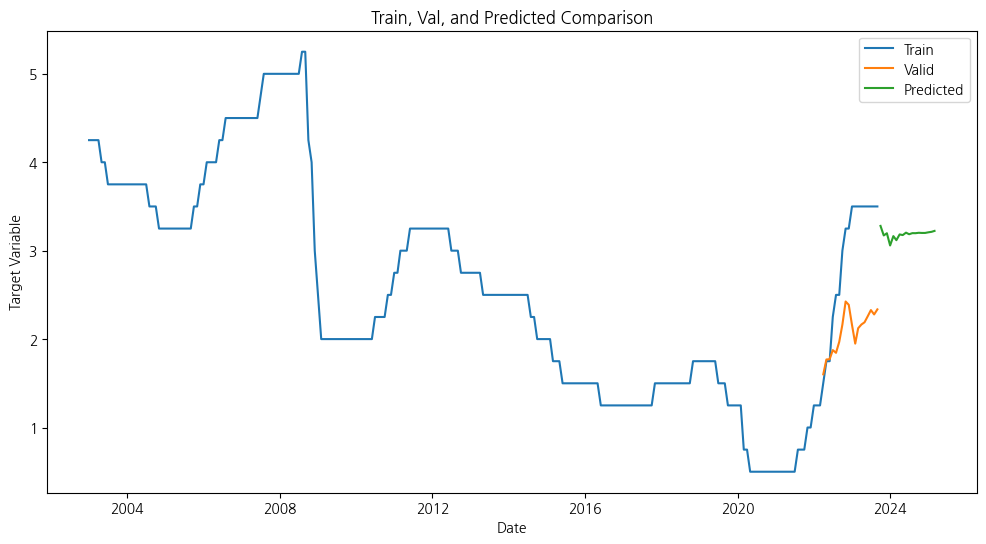

In [ ]:
# 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data['기준금리'], label='Train')
plt.plot(results_v18.index, results_v18['Val'], label='Valid')
plt.plot(results18.index, results18['Predicted'], label='Predicted')
plt.title('Train, Val, and Predicted Comparison')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

## 24개월

### 3-1) VECM 모델 훈련

In [ ]:
# train 데이터로 모델 훈련
modelV = VECM(df_diff, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = modelV.fit()

In [ ]:
# 미래의 독립변수 예측
future_steps = 24  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, :-1]

In [ ]:
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum(axis=0) + np.array(imp.iloc[-1,:]).reshape(1,-1)

# 미래의 독립변수 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[[ 5.04358431e+00  4.51091463e+00  4.41187606e+00  1.00313957e+00
   9.06903658e-01  1.00482947e+00  1.01592572e+00  8.14782855e-01
   8.96575369e-01  1.00499643e+00  9.08897333e-01  4.50425347e-01
   7.30824236e-01  4.04420808e-02  8.00566789e-01  2.76647421e-01
   4.66297071e+00  9.84489903e-01]
 [ 5.15561871e+00  4.73399023e+00  4.61238243e+00  1.00428402e+00
   9.01896687e-01  1.00967147e+00  1.00397017e+00  8.13078560e-01
   8.97285648e-01  9.92023618e-01  8.59781503e-01  4.63679989e-01
   7.13221056e-01  4.18033563e-02  8.18535145e-01  3.80980815e-01
   4.85688409e+00  9.83773515e-01]
 [ 5.14743029e+00  4.77979332e+00  4.68440432e+00  1.00740865e+00
   8.94736167e-01  1.01345349e+00  1.01263864e+00  8.14570329e-01
   9.09653967e-01  1.00924330e+00  9.09241484e-01  4.65739487e-01
   7.06689105e-01  4.41589954e-02  8.31936913e-01  4.40565474e-01
   4.92435304e+00  9.83460097e-01]
 [ 5.05473244e+00  4.69713948e+00  4.65102020e+00  1.01097040e+00
  

### 3-2) 독립변수 생성

In [ ]:
idx = pd.date_range(start='2023-10-01', periods=future_steps, freq='MS')
future_df24 = pd.DataFrame(data=future_forecast, columns=imp.columns, index=idx)

In [ ]:
future_df24

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원)
2023-10-01,5.043584,4.510915,4.411876,1.003140,0.906904,1.004829,1.015926,0.814783,0.896575,1.004996,0.908897,0.450425,0.730824,0.040442,0.800567,0.276647,4.662971,0.984490
2023-11-01,5.155619,4.733990,4.612382,1.004284,0.901897,1.009671,1.003970,0.813079,0.897286,0.992024,0.859782,0.463680,0.713221,0.041803,0.818535,0.380981,4.856884,0.983774
2023-12-01,5.147430,4.779793,4.684404,1.007409,0.894736,1.013453,1.012639,0.814570,0.909654,1.009243,0.909241,0.465739,0.706689,0.044159,0.831937,0.440565,4.924353,0.983460
2024-01-01,5.054732,4.697139,4.651020,1.010970,0.912157,1.017326,1.008953,0.826262,0.922013,1.001956,0.868210,0.500469,0.706951,0.040427,0.848610,0.491552,4.926137,1.006308
2024-02-01,5.131210,4.780452,4.733655,1.015625,0.929065,1.020893,1.008988,0.832955,0.924586,1.000980,0.898751,0.476316,0.711759,0.036172,0.840146,0.478164,5.004605,1.002871
2024-03-01,5.149210,4.782960,4.709681,1.019362,0.933244,1.025035,1.007728,0.835363,0.925886,0.999690,0.871369,0.486888,0.712730,0.034549,0.847702,0.439876,4.980541,1.013573
2024-04-01,5.183697,4.786049,4.709218,1.023760,0.927194,1.029002,1.010300,0.839525,0.925005,1.004724,0.890951,0.465350,0.717392,0.035469,0.838530,0.403999,4.978455,1.015614
2024-05-01,5.216138,4.810425,4.728708,1.027482,0.931860,1.033694,1.008095,0.841304,0.927909,1.000774,0.878963,0.475385,0.719942,0.033370,0.842315,0.406501,4.998015,1.023179
2024-06-01,5.291250,4.877446,4.778151,1.031400,0.934335,1.038771,1.008900,0.842356,0.930143,1.001609,0.888395,0.458940,0.724350,0.031891,0.840051,0.433516,5.033341,1.023624
2024-07-01,5.324352,4.906862,4.796966,1.034875,0.936216,1.043593,1.008043,0.843258,0.935584,1.000540,0.878828,0.467484,0.727149,0.029136,0.847924,0.447911,5.045182,1.028119


### 3-3) 데이터 LSTM으로 형태변환

In [ ]:
# X와 y로 분리
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset.iloc[i:(i + time_steps), :-1]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_steps, -1])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
train_time = -24
X_train, y_train = create_dataset(all_data.iloc[:train_time,:], time_steps)
X_val, y_val = create_dataset(all_data.iloc[train_time-1:,:], time_steps)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((224, 1, 18), (224,), (24, 1, 18), (24,))

### 3-4) LSTM모델 훈련

In [ ]:
# LSTM 모델 생성
modelL = Sequential()
modelL.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
modelL.add(Dropout(0.3))

modelL.add(Dense(16))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(8))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(1))
modelL.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

### 씨드 고정해야함
modelL.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/300
14/14 - 8s - loss: 9.7913 - val_loss: 7.4197 - 8s/epoch - 572ms/step
Epoch 2/300
14/14 - 0s - loss: 8.2727 - val_loss: 6.7322 - 247ms/epoch - 18ms/step
Epoch 3/300
14/14 - 0s - loss: 7.6624 - val_loss: 6.3650 - 201ms/epoch - 14ms/step
Epoch 4/300
14/14 - 0s - loss: 7.3214 - val_loss: 6.2825 - 368ms/epoch - 26ms/step
Epoch 5/300
14/14 - 0s - loss: 7.0654 - val_loss: 6.1463 - 199ms/epoch - 14ms/step
Epoch 6/300
14/14 - 0s - loss: 7.0805 - val_loss: 5.7792 - 116ms/epoch - 8ms/step
Epoch 7/300
14/14 - 0s - loss: 6.0723 - val_loss: 5.7692 - 129ms/epoch - 9ms/step
Epoch 8/300
14/14 - 0s - loss: 5.6107 - val_loss: 5.7228 - 139ms/epoch - 10ms/step
Epoch 9/300
14/14 - 0s - loss: 5.7838 - val_loss: 5.5845 - 115ms/epoch - 8ms/step
Epoch 10/300
14/14 - 0s - loss: 5.6224 - val_loss: 5.5434 - 125ms/epoch - 9ms/step
Epoch 11/300
14/14 - 0s - loss: 5.3178 - val_loss: 5.5117 - 103ms/epoch - 7ms/step
Epoch 12/300
14/14 - 0s - loss: 5.6019 - val_loss: 5.3940 - 104ms/epoch - 7ms/step
Epoch 13/

In [ ]:
val_pred = modelL.predict(X_val)

1/1 [==============================] - 1s 654ms/step


In [ ]:
future_date = future_steps
results_v24 = pd.DataFrame({'Val':val_pred.reshape(-1)}, index=all_data.index[-future_date:])
results_v24

,Val
날짜,
2021-10-01,0.607106
2021-11-01,0.651848
2021-12-01,0.706897
2022-01-01,0.843117
2022-02-01,0.953813
2022-03-01,1.096983
2022-04-01,1.144238
2022-05-01,1.337338
2022-06-01,1.293044


### 3-5) 기준금리 예측

In [ ]:
f_x_train, f_y_train = create_dataset(all_data, time_steps)
modelL.fit(f_x_train, f_y_train, epochs=500, batch_size=16, verbose=2, callbacks=[early_stopping])

Epoch 1/500


16/16 - 3s - loss: 1.0761 - 3s/epoch - 178ms/step
Epoch 2/500


16/16 - 0s - loss: 1.0165 - 69ms/epoch - 4ms/step
Epoch 3/500


16/16 - 0s - loss: 0.8879 - 81ms/epoch - 5ms/step
Epoch 4/500


16/16 - 0s - loss: 0.9606 - 86ms/epoch - 5ms/step
Epoch 5/500


16/16 - 0s - loss: 0.7547 - 70ms/epoch - 4ms/step
Epoch 6/500


16/16 - 0s - loss: 0.8338 - 75ms/epoch - 5ms/step
Epoch 7/500


16/16 - 0s - loss: 0.8716 - 69ms/epoch - 4ms/step
Epoch 8/500


16/16 - 0s - loss: 0.7429 - 77ms/epoch - 5ms/step
Epoch 9/500


16/16 - 0s - loss: 0.9325 - 71ms/epoch - 4ms/step
Epoch 10/500


16/16 - 0s - loss: 0.9021 - 70ms/epoch - 4ms/step
Epoch 11/500


16/16 - 0s - loss: 0.7145 - 76ms/epoch - 5ms/step
Epoch 12/500


16/16 - 0s - loss: 0.9188 - 78ms/epoch - 5ms/step
Epoch 13/500


16/16 - 0s - loss: 0.9406 - 72ms/epoch - 4ms/step
Epoch 14/500


16/16 - 0s - loss: 0.8011 - 73ms/epoch - 5ms/step
Epoch 15/500


16/16 - 0s - loss: 0.8854 - 74ms/epoch - 5ms/step
Epoch 16/500


16/16 - 0s - loss: 0.7405 - 76ms/epoch - 5ms/step
Epoch 17/500


16/16 - 0s - loss: 0.7342 - 88ms/epoch - 5ms/step
Epoch 18/500


16/16 - 0s - loss: 0.7873 - 79ms/epoch - 5ms/step
Epoch 19/500


16/16 - 0s - loss: 0.9634 - 79ms/epoch - 5ms/step
Epoch 20/500


16/16 - 0s - loss: 0.6956 - 71ms/epoch - 4ms/step
Epoch 21/500


16/16 - 0s - loss: 0.7498 - 69ms/epoch - 4ms/step
Epoch 22/500


16/16 - 0s - loss: 0.8567 - 71ms/epoch - 4ms/step
Epoch 23/500


16/16 - 0s - loss: 0.7551 - 73ms/epoch - 5ms/step
Epoch 24/500


16/16 - 0s - loss: 0.7283 - 69ms/epoch - 4ms/step
Epoch 25/500


16/16 - 0s - loss: 0.7147 - 71ms/epoch - 4ms/step
Epoch 26/500


16/16 - 0s - loss: 0.5971 - 68ms/epoch - 4ms/step
Epoch 27/500


16/16 - 0s - loss: 0.8082 - 73ms/epoch - 5ms/step
Epoch 28/500


16/16 - 0s - loss: 0.7800 - 76ms/epoch - 5ms/step
Epoch 29/500


16/16 - 0s - loss: 0.9008 - 78ms/epoch - 5ms/step
Epoch 30/500


16/16 - 0s - loss: 0.5916 - 81ms/epoch - 5ms/step
Epoch 31/500


16/16 - 0s - loss: 0.7808 - 74ms/epoch - 5ms/step
Epoch 32/500


16/16 - 0s - loss: 0.6506 - 73ms/epoch - 5ms/step
Epoch 33/500


16/16 - 0s - loss: 0.7263 - 68ms/epoch - 4ms/step
Epoch 34/500


16/16 - 0s - loss: 0.7470 - 71ms/epoch - 4ms/step
Epoch 35/500


16/16 - 0s - loss: 0.6539 - 77ms/epoch - 5ms/step
Epoch 36/500


16/16 - 0s - loss: 0.7908 - 74ms/epoch - 5ms/step
Epoch 37/500


16/16 - 0s - loss: 0.8369 - 72ms/epoch - 5ms/step
Epoch 38/500


16/16 - 0s - loss: 0.6965 - 72ms/epoch - 4ms/step
Epoch 39/500


16/16 - 0s - loss: 0.6146 - 68ms/epoch - 4ms/step
Epoch 40/500


16/16 - 0s - loss: 0.8060 - 71ms/epoch - 4ms/step
Epoch 41/500


16/16 - 0s - loss: 0.7244 - 71ms/epoch - 4ms/step
Epoch 42/500


16/16 - 0s - loss: 0.6655 - 74ms/epoch - 5ms/step
Epoch 43/500


16/16 - 0s - loss: 0.7802 - 50ms/epoch - 3ms/step
Epoch 44/500


16/16 - 0s - loss: 0.7354 - 49ms/epoch - 3ms/step
Epoch 45/500


16/16 - 0s - loss: 0.5738 - 60ms/epoch - 4ms/step
Epoch 46/500


16/16 - 0s - loss: 0.6064 - 52ms/epoch - 3ms/step
Epoch 47/500


16/16 - 0s - loss: 0.6780 - 49ms/epoch - 3ms/step
Epoch 48/500


16/16 - 0s - loss: 0.5659 - 52ms/epoch - 3ms/step
Epoch 49/500


16/16 - 0s - loss: 0.6256 - 52ms/epoch - 3ms/step
Epoch 50/500


16/16 - 0s - loss: 0.6413 - 51ms/epoch - 3ms/step
Epoch 51/500


16/16 - 0s - loss: 0.6356 - 50ms/epoch - 3ms/step
Epoch 52/500


16/16 - 0s - loss: 0.7421 - 51ms/epoch - 3ms/step
Epoch 53/500


16/16 - 0s - loss: 0.6180 - 51ms/epoch - 3ms/step
Epoch 54/500


16/16 - 0s - loss: 0.7125 - 51ms/epoch - 3ms/step
Epoch 55/500


16/16 - 0s - loss: 0.6660 - 55ms/epoch - 3ms/step
Epoch 56/500


16/16 - 0s - loss: 0.7230 - 47ms/epoch - 3ms/step
Epoch 57/500


16/16 - 0s - loss: 0.6469 - 52ms/epoch - 3ms/step
Epoch 58/500


16/16 - 0s - loss: 0.6575 - 51ms/epoch - 3ms/step
Epoch 59/500


16/16 - 0s - loss: 0.5455 - 51ms/epoch - 3ms/step
Epoch 60/500


16/16 - 0s - loss: 0.7244 - 48ms/epoch - 3ms/step
Epoch 61/500


16/16 - 0s - loss: 0.6205 - 52ms/epoch - 3ms/step
Epoch 62/500


16/16 - 0s - loss: 0.6001 - 55ms/epoch - 3ms/step
Epoch 63/500


16/16 - 0s - loss: 0.5626 - 66ms/epoch - 4ms/step
Epoch 64/500


16/16 - 0s - loss: 0.6955 - 50ms/epoch - 3ms/step
Epoch 65/500


16/16 - 0s - loss: 0.5814 - 53ms/epoch - 3ms/step
Epoch 66/500


16/16 - 0s - loss: 0.5481 - 54ms/epoch - 3ms/step
Epoch 67/500


16/16 - 0s - loss: 0.4256 - 52ms/epoch - 3ms/step
Epoch 68/500


16/16 - 0s - loss: 0.5243 - 53ms/epoch - 3ms/step
Epoch 69/500


16/16 - 0s - loss: 0.6443 - 57ms/epoch - 4ms/step
Epoch 70/500


16/16 - 0s - loss: 0.6842 - 53ms/epoch - 3ms/step
Epoch 71/500


16/16 - 0s - loss: 0.4947 - 53ms/epoch - 3ms/step
Epoch 72/500


16/16 - 0s - loss: 0.5369 - 56ms/epoch - 3ms/step
Epoch 73/500


16/16 - 0s - loss: 0.4756 - 56ms/epoch - 4ms/step
Epoch 74/500


16/16 - 0s - loss: 0.5482 - 56ms/epoch - 4ms/step
Epoch 75/500


16/16 - 0s - loss: 0.6432 - 58ms/epoch - 4ms/step
Epoch 76/500


16/16 - 0s - loss: 0.5797 - 55ms/epoch - 3ms/step
Epoch 77/500


16/16 - 0s - loss: 0.5406 - 55ms/epoch - 3ms/step
Epoch 78/500


16/16 - 0s - loss: 0.5180 - 55ms/epoch - 3ms/step
Epoch 79/500


16/16 - 0s - loss: 0.4703 - 55ms/epoch - 3ms/step
Epoch 80/500


16/16 - 0s - loss: 0.4723 - 58ms/epoch - 4ms/step
Epoch 81/500


16/16 - 0s - loss: 0.5547 - 51ms/epoch - 3ms/step
Epoch 82/500


16/16 - 0s - loss: 0.4544 - 59ms/epoch - 4ms/step
Epoch 83/500


16/16 - 0s - loss: 0.5248 - 53ms/epoch - 3ms/step
Epoch 84/500


16/16 - 0s - loss: 0.5684 - 50ms/epoch - 3ms/step
Epoch 85/500


16/16 - 0s - loss: 0.5851 - 53ms/epoch - 3ms/step
Epoch 86/500


16/16 - 0s - loss: 0.5315 - 54ms/epoch - 3ms/step
Epoch 87/500


16/16 - 0s - loss: 0.5575 - 54ms/epoch - 3ms/step
Epoch 88/500


16/16 - 0s - loss: 0.4870 - 58ms/epoch - 4ms/step
Epoch 89/500


16/16 - 0s - loss: 0.5148 - 50ms/epoch - 3ms/step
Epoch 90/500


16/16 - 0s - loss: 0.5646 - 52ms/epoch - 3ms/step
Epoch 91/500


16/16 - 0s - loss: 0.5584 - 52ms/epoch - 3ms/step
Epoch 92/500


16/16 - 0s - loss: 0.5458 - 50ms/epoch - 3ms/step
Epoch 93/500


16/16 - 0s - loss: 0.5373 - 57ms/epoch - 4ms/step
Epoch 94/500


16/16 - 0s - loss: 0.5892 - 59ms/epoch - 4ms/step
Epoch 95/500


16/16 - 0s - loss: 0.4764 - 55ms/epoch - 3ms/step
Epoch 96/500


16/16 - 0s - loss: 0.4992 - 55ms/epoch - 3ms/step
Epoch 97/500


16/16 - 0s - loss: 0.5659 - 62ms/epoch - 4ms/step
Epoch 98/500


16/16 - 0s - loss: 0.4670 - 58ms/epoch - 4ms/step
Epoch 99/500


16/16 - 0s - loss: 0.4966 - 59ms/epoch - 4ms/step
Epoch 100/500


16/16 - 0s - loss: 0.4464 - 55ms/epoch - 3ms/step
Epoch 101/500


16/16 - 0s - loss: 0.6035 - 53ms/epoch - 3ms/step
Epoch 102/500


16/16 - 0s - loss: 0.6996 - 54ms/epoch - 3ms/step
Epoch 103/500


16/16 - 0s - loss: 0.5180 - 54ms/epoch - 3ms/step
Epoch 104/500


16/16 - 0s - loss: 0.4857 - 61ms/epoch - 4ms/step
Epoch 105/500


16/16 - 0s - loss: 0.4800 - 55ms/epoch - 3ms/step
Epoch 106/500


16/16 - 0s - loss: 0.4957 - 56ms/epoch - 4ms/step
Epoch 107/500


16/16 - 0s - loss: 0.5577 - 56ms/epoch - 3ms/step
Epoch 108/500


16/16 - 0s - loss: 0.5604 - 54ms/epoch - 3ms/step
Epoch 109/500


16/16 - 0s - loss: 0.5051 - 51ms/epoch - 3ms/step
Epoch 110/500


16/16 - 0s - loss: 0.5471 - 57ms/epoch - 4ms/step
Epoch 111/500


16/16 - 0s - loss: 0.5717 - 55ms/epoch - 3ms/step
Epoch 112/500


16/16 - 0s - loss: 0.4841 - 62ms/epoch - 4ms/step
Epoch 113/500


16/16 - 0s - loss: 0.4488 - 55ms/epoch - 3ms/step
Epoch 114/500


16/16 - 0s - loss: 0.5360 - 56ms/epoch - 4ms/step
Epoch 115/500


16/16 - 0s - loss: 0.4582 - 61ms/epoch - 4ms/step
Epoch 116/500


16/16 - 0s - loss: 0.4946 - 51ms/epoch - 3ms/step
Epoch 117/500


16/16 - 0s - loss: 0.5620 - 57ms/epoch - 4ms/step
Epoch 118/500


16/16 - 0s - loss: 0.4286 - 52ms/epoch - 3ms/step
Epoch 119/500


16/16 - 0s - loss: 0.4983 - 50ms/epoch - 3ms/step
Epoch 120/500


16/16 - 0s - loss: 0.5187 - 50ms/epoch - 3ms/step
Epoch 121/500


16/16 - 0s - loss: 0.4951 - 58ms/epoch - 4ms/step
Epoch 122/500


16/16 - 0s - loss: 0.4723 - 53ms/epoch - 3ms/step
Epoch 123/500


16/16 - 0s - loss: 0.4781 - 51ms/epoch - 3ms/step
Epoch 124/500


16/16 - 0s - loss: 0.5694 - 53ms/epoch - 3ms/step
Epoch 125/500


16/16 - 0s - loss: 0.4774 - 50ms/epoch - 3ms/step
Epoch 126/500


16/16 - 0s - loss: 0.5542 - 49ms/epoch - 3ms/step
Epoch 127/500


16/16 - 0s - loss: 0.5029 - 53ms/epoch - 3ms/step
Epoch 128/500


16/16 - 0s - loss: 0.4635 - 50ms/epoch - 3ms/step
Epoch 129/500


16/16 - 0s - loss: 0.4729 - 55ms/epoch - 3ms/step
Epoch 130/500


16/16 - 0s - loss: 0.4765 - 54ms/epoch - 3ms/step
Epoch 131/500


16/16 - 0s - loss: 0.4782 - 56ms/epoch - 3ms/step
Epoch 132/500


16/16 - 0s - loss: 0.4763 - 63ms/epoch - 4ms/step
Epoch 133/500


16/16 - 0s - loss: 0.5624 - 56ms/epoch - 3ms/step
Epoch 134/500


16/16 - 0s - loss: 0.5281 - 55ms/epoch - 3ms/step
Epoch 135/500


16/16 - 0s - loss: 0.4650 - 50ms/epoch - 3ms/step
Epoch 136/500


16/16 - 0s - loss: 0.5501 - 56ms/epoch - 3ms/step
Epoch 137/500


16/16 - 0s - loss: 0.4313 - 54ms/epoch - 3ms/step
Epoch 138/500


16/16 - 0s - loss: 0.5921 - 53ms/epoch - 3ms/step
Epoch 139/500


16/16 - 0s - loss: 0.4642 - 54ms/epoch - 3ms/step
Epoch 140/500


16/16 - 0s - loss: 0.4735 - 52ms/epoch - 3ms/step
Epoch 141/500


16/16 - 0s - loss: 0.5198 - 58ms/epoch - 4ms/step
Epoch 142/500


16/16 - 0s - loss: 0.4676 - 56ms/epoch - 3ms/step
Epoch 143/500


16/16 - 0s - loss: 0.4389 - 56ms/epoch - 4ms/step
Epoch 144/500


16/16 - 0s - loss: 0.5526 - 59ms/epoch - 4ms/step
Epoch 145/500


16/16 - 0s - loss: 0.4489 - 58ms/epoch - 4ms/step
Epoch 146/500


16/16 - 0s - loss: 0.4429 - 61ms/epoch - 4ms/step
Epoch 147/500


16/16 - 0s - loss: 0.4098 - 51ms/epoch - 3ms/step
Epoch 148/500


16/16 - 0s - loss: 0.5161 - 52ms/epoch - 3ms/step
Epoch 149/500


16/16 - 0s - loss: 0.4932 - 64ms/epoch - 4ms/step
Epoch 150/500


16/16 - 0s - loss: 0.5098 - 59ms/epoch - 4ms/step
Epoch 151/500


16/16 - 0s - loss: 0.4797 - 55ms/epoch - 3ms/step
Epoch 152/500


16/16 - 0s - loss: 0.5323 - 55ms/epoch - 3ms/step
Epoch 153/500


16/16 - 0s - loss: 0.4152 - 59ms/epoch - 4ms/step
Epoch 154/500


16/16 - 0s - loss: 0.4724 - 64ms/epoch - 4ms/step
Epoch 155/500


16/16 - 0s - loss: 0.4512 - 63ms/epoch - 4ms/step
Epoch 156/500


16/16 - 0s - loss: 0.5069 - 65ms/epoch - 4ms/step
Epoch 157/500


16/16 - 0s - loss: 0.4697 - 54ms/epoch - 3ms/step
Epoch 158/500


16/16 - 0s - loss: 0.4351 - 56ms/epoch - 4ms/step
Epoch 159/500


16/16 - 0s - loss: 0.5463 - 57ms/epoch - 4ms/step
Epoch 160/500


16/16 - 0s - loss: 0.5021 - 54ms/epoch - 3ms/step
Epoch 161/500


16/16 - 0s - loss: 0.5014 - 52ms/epoch - 3ms/step
Epoch 162/500


16/16 - 0s - loss: 0.4281 - 57ms/epoch - 4ms/step
Epoch 163/500


16/16 - 0s - loss: 0.4796 - 57ms/epoch - 4ms/step
Epoch 164/500


16/16 - 0s - loss: 0.4717 - 57ms/epoch - 4ms/step
Epoch 165/500


16/16 - 0s - loss: 0.4533 - 57ms/epoch - 4ms/step
Epoch 166/500


16/16 - 0s - loss: 0.4225 - 59ms/epoch - 4ms/step
Epoch 167/500


16/16 - 0s - loss: 0.3612 - 53ms/epoch - 3ms/step
Epoch 168/500


16/16 - 0s - loss: 0.4731 - 55ms/epoch - 3ms/step
Epoch 169/500


16/16 - 0s - loss: 0.3734 - 54ms/epoch - 3ms/step
Epoch 170/500


16/16 - 0s - loss: 0.4184 - 52ms/epoch - 3ms/step
Epoch 171/500


16/16 - 0s - loss: 0.5034 - 52ms/epoch - 3ms/step
Epoch 172/500


16/16 - 0s - loss: 0.4649 - 56ms/epoch - 3ms/step
Epoch 173/500


16/16 - 0s - loss: 0.5429 - 58ms/epoch - 4ms/step
Epoch 174/500


16/16 - 0s - loss: 0.4320 - 58ms/epoch - 4ms/step
Epoch 175/500


16/16 - 0s - loss: 0.5288 - 56ms/epoch - 3ms/step
Epoch 176/500


16/16 - 0s - loss: 0.4783 - 53ms/epoch - 3ms/step
Epoch 177/500


16/16 - 0s - loss: 0.4107 - 54ms/epoch - 3ms/step
Epoch 178/500


16/16 - 0s - loss: 0.4283 - 56ms/epoch - 3ms/step
Epoch 179/500


16/16 - 0s - loss: 0.5001 - 57ms/epoch - 4ms/step
Epoch 180/500


16/16 - 0s - loss: 0.4854 - 56ms/epoch - 3ms/step
Epoch 181/500


16/16 - 0s - loss: 0.5124 - 53ms/epoch - 3ms/step
Epoch 182/500


16/16 - 0s - loss: 0.4489 - 52ms/epoch - 3ms/step
Epoch 183/500


16/16 - 0s - loss: 0.4271 - 64ms/epoch - 4ms/step
Epoch 184/500


16/16 - 0s - loss: 0.4402 - 49ms/epoch - 3ms/step
Epoch 185/500


16/16 - 0s - loss: 0.4553 - 55ms/epoch - 3ms/step
Epoch 186/500


16/16 - 0s - loss: 0.4399 - 54ms/epoch - 3ms/step
Epoch 187/500


16/16 - 0s - loss: 0.4321 - 52ms/epoch - 3ms/step
Epoch 188/500


16/16 - 0s - loss: 0.4840 - 52ms/epoch - 3ms/step
Epoch 189/500


16/16 - 0s - loss: 0.4734 - 54ms/epoch - 3ms/step
Epoch 190/500


16/16 - 0s - loss: 0.5729 - 54ms/epoch - 3ms/step
Epoch 191/500


16/16 - 0s - loss: 0.4621 - 57ms/epoch - 4ms/step
Epoch 192/500


16/16 - 0s - loss: 0.3775 - 52ms/epoch - 3ms/step
Epoch 193/500


16/16 - 0s - loss: 0.5115 - 55ms/epoch - 3ms/step
Epoch 194/500


16/16 - 0s - loss: 0.4371 - 58ms/epoch - 4ms/step
Epoch 195/500


16/16 - 0s - loss: 0.4304 - 54ms/epoch - 3ms/step
Epoch 196/500


16/16 - 0s - loss: 0.4620 - 50ms/epoch - 3ms/step
Epoch 197/500


16/16 - 0s - loss: 0.4677 - 54ms/epoch - 3ms/step
Epoch 198/500


16/16 - 0s - loss: 0.3681 - 59ms/epoch - 4ms/step
Epoch 199/500


16/16 - 0s - loss: 0.3792 - 54ms/epoch - 3ms/step
Epoch 200/500


16/16 - 0s - loss: 0.3848 - 65ms/epoch - 4ms/step
Epoch 201/500


16/16 - 0s - loss: 0.4613 - 63ms/epoch - 4ms/step
Epoch 202/500


16/16 - 0s - loss: 0.5141 - 54ms/epoch - 3ms/step
Epoch 203/500


16/16 - 0s - loss: 0.4580 - 53ms/epoch - 3ms/step
Epoch 204/500


16/16 - 0s - loss: 0.4330 - 58ms/epoch - 4ms/step
Epoch 205/500


16/16 - 0s - loss: 0.4084 - 53ms/epoch - 3ms/step
Epoch 206/500


16/16 - 0s - loss: 0.4462 - 59ms/epoch - 4ms/step
Epoch 207/500


16/16 - 0s - loss: 0.4037 - 55ms/epoch - 3ms/step
Epoch 208/500


16/16 - 0s - loss: 0.4105 - 54ms/epoch - 3ms/step
Epoch 209/500


16/16 - 0s - loss: 0.4543 - 61ms/epoch - 4ms/step
Epoch 210/500


16/16 - 0s - loss: 0.4233 - 80ms/epoch - 5ms/step
Epoch 211/500


16/16 - 0s - loss: 0.4276 - 77ms/epoch - 5ms/step
Epoch 212/500


16/16 - 0s - loss: 0.4287 - 73ms/epoch - 5ms/step
Epoch 213/500


16/16 - 0s - loss: 0.3634 - 67ms/epoch - 4ms/step
Epoch 214/500


16/16 - 0s - loss: 0.4425 - 66ms/epoch - 4ms/step
Epoch 215/500


16/16 - 0s - loss: 0.4550 - 77ms/epoch - 5ms/step
Epoch 216/500


16/16 - 0s - loss: 0.4193 - 72ms/epoch - 4ms/step
Epoch 217/500


16/16 - 0s - loss: 0.4108 - 72ms/epoch - 5ms/step
Epoch 218/500


16/16 - 0s - loss: 0.4278 - 73ms/epoch - 5ms/step
Epoch 219/500


16/16 - 0s - loss: 0.5071 - 72ms/epoch - 5ms/step
Epoch 220/500


16/16 - 0s - loss: 0.4778 - 68ms/epoch - 4ms/step
Epoch 221/500


16/16 - 0s - loss: 0.4959 - 68ms/epoch - 4ms/step
Epoch 222/500


16/16 - 0s - loss: 0.4418 - 70ms/epoch - 4ms/step
Epoch 223/500


16/16 - 0s - loss: 0.4370 - 69ms/epoch - 4ms/step
Epoch 224/500


16/16 - 0s - loss: 0.4305 - 78ms/epoch - 5ms/step
Epoch 225/500


16/16 - 0s - loss: 0.4109 - 71ms/epoch - 4ms/step
Epoch 226/500


16/16 - 0s - loss: 0.5289 - 70ms/epoch - 4ms/step
Epoch 227/500


16/16 - 0s - loss: 0.3912 - 70ms/epoch - 4ms/step
Epoch 228/500


16/16 - 0s - loss: 0.3886 - 71ms/epoch - 4ms/step
Epoch 229/500


16/16 - 0s - loss: 0.4113 - 72ms/epoch - 4ms/step
Epoch 230/500


16/16 - 0s - loss: 0.5310 - 72ms/epoch - 4ms/step
Epoch 231/500


16/16 - 0s - loss: 0.5032 - 67ms/epoch - 4ms/step
Epoch 232/500


16/16 - 0s - loss: 0.5025 - 67ms/epoch - 4ms/step
Epoch 233/500


16/16 - 0s - loss: 0.4632 - 67ms/epoch - 4ms/step
Epoch 234/500


16/16 - 0s - loss: 0.4703 - 68ms/epoch - 4ms/step
Epoch 235/500


16/16 - 0s - loss: 0.5322 - 67ms/epoch - 4ms/step
Epoch 236/500


16/16 - 0s - loss: 0.3841 - 72ms/epoch - 4ms/step
Epoch 237/500


16/16 - 0s - loss: 0.5087 - 80ms/epoch - 5ms/step
Epoch 238/500


16/16 - 0s - loss: 0.4531 - 65ms/epoch - 4ms/step
Epoch 239/500


16/16 - 0s - loss: 0.3558 - 64ms/epoch - 4ms/step
Epoch 240/500


16/16 - 0s - loss: 0.4138 - 64ms/epoch - 4ms/step
Epoch 241/500


16/16 - 0s - loss: 0.4390 - 66ms/epoch - 4ms/step
Epoch 242/500


16/16 - 0s - loss: 0.4155 - 66ms/epoch - 4ms/step
Epoch 243/500


16/16 - 0s - loss: 0.5090 - 67ms/epoch - 4ms/step
Epoch 244/500


16/16 - 0s - loss: 0.4620 - 68ms/epoch - 4ms/step
Epoch 245/500


16/16 - 0s - loss: 0.3953 - 70ms/epoch - 4ms/step
Epoch 246/500


16/16 - 0s - loss: 0.4201 - 73ms/epoch - 5ms/step
Epoch 247/500


16/16 - 0s - loss: 0.3812 - 68ms/epoch - 4ms/step
Epoch 248/500


16/16 - 0s - loss: 0.3428 - 74ms/epoch - 5ms/step
Epoch 249/500


16/16 - 0s - loss: 0.4316 - 74ms/epoch - 5ms/step
Epoch 250/500


16/16 - 0s - loss: 0.5328 - 71ms/epoch - 4ms/step
Epoch 251/500


16/16 - 0s - loss: 0.4295 - 72ms/epoch - 4ms/step
Epoch 252/500


16/16 - 0s - loss: 0.3794 - 92ms/epoch - 6ms/step
Epoch 253/500


16/16 - 0s - loss: 0.4903 - 76ms/epoch - 5ms/step
Epoch 254/500


16/16 - 0s - loss: 0.4549 - 74ms/epoch - 5ms/step
Epoch 255/500


16/16 - 0s - loss: 0.3183 - 74ms/epoch - 5ms/step
Epoch 256/500


16/16 - 0s - loss: 0.3480 - 74ms/epoch - 5ms/step
Epoch 257/500


16/16 - 0s - loss: 0.3275 - 74ms/epoch - 5ms/step
Epoch 258/500


16/16 - 0s - loss: 0.4393 - 74ms/epoch - 5ms/step
Epoch 259/500


16/16 - 0s - loss: 0.4588 - 73ms/epoch - 5ms/step
Epoch 260/500


16/16 - 0s - loss: 0.3366 - 71ms/epoch - 4ms/step
Epoch 261/500


16/16 - 0s - loss: 0.3808 - 71ms/epoch - 4ms/step
Epoch 262/500


16/16 - 0s - loss: 0.3754 - 75ms/epoch - 5ms/step
Epoch 263/500


16/16 - 0s - loss: 0.3909 - 73ms/epoch - 5ms/step
Epoch 264/500


16/16 - 0s - loss: 0.3959 - 69ms/epoch - 4ms/step
Epoch 265/500


16/16 - 0s - loss: 0.3945 - 81ms/epoch - 5ms/step
Epoch 266/500


16/16 - 0s - loss: 0.4723 - 75ms/epoch - 5ms/step
Epoch 267/500


16/16 - 0s - loss: 0.3515 - 78ms/epoch - 5ms/step
Epoch 268/500


16/16 - 0s - loss: 0.4267 - 76ms/epoch - 5ms/step
Epoch 269/500


16/16 - 0s - loss: 0.4692 - 75ms/epoch - 5ms/step
Epoch 270/500


16/16 - 0s - loss: 0.4178 - 79ms/epoch - 5ms/step
Epoch 271/500


16/16 - 0s - loss: 0.4197 - 87ms/epoch - 5ms/step
Epoch 272/500


16/16 - 0s - loss: 0.4675 - 74ms/epoch - 5ms/step
Epoch 273/500


16/16 - 0s - loss: 0.3989 - 70ms/epoch - 4ms/step
Epoch 274/500


16/16 - 0s - loss: 0.4264 - 68ms/epoch - 4ms/step
Epoch 275/500


16/16 - 0s - loss: 0.3545 - 68ms/epoch - 4ms/step
Epoch 276/500


16/16 - 0s - loss: 0.3731 - 76ms/epoch - 5ms/step
Epoch 277/500


16/16 - 0s - loss: 0.3420 - 71ms/epoch - 4ms/step
Epoch 278/500


16/16 - 0s - loss: 0.4222 - 68ms/epoch - 4ms/step
Epoch 279/500


16/16 - 0s - loss: 0.4151 - 67ms/epoch - 4ms/step
Epoch 280/500


16/16 - 0s - loss: 0.3570 - 71ms/epoch - 4ms/step
Epoch 281/500


16/16 - 0s - loss: 0.3507 - 68ms/epoch - 4ms/step
Epoch 282/500


16/16 - 0s - loss: 0.3874 - 68ms/epoch - 4ms/step
Epoch 283/500


16/16 - 0s - loss: 0.3626 - 79ms/epoch - 5ms/step
Epoch 284/500


16/16 - 0s - loss: 0.4794 - 76ms/epoch - 5ms/step
Epoch 285/500


16/16 - 0s - loss: 0.4284 - 70ms/epoch - 4ms/step
Epoch 286/500


16/16 - 0s - loss: 0.4171 - 74ms/epoch - 5ms/step
Epoch 287/500


16/16 - 0s - loss: 0.3721 - 69ms/epoch - 4ms/step
Epoch 288/500


16/16 - 0s - loss: 0.3913 - 75ms/epoch - 5ms/step
Epoch 289/500


16/16 - 0s - loss: 0.3607 - 73ms/epoch - 5ms/step
Epoch 290/500


16/16 - 0s - loss: 0.2838 - 68ms/epoch - 4ms/step
Epoch 291/500


16/16 - 0s - loss: 0.3775 - 74ms/epoch - 5ms/step
Epoch 292/500


16/16 - 0s - loss: 0.3187 - 70ms/epoch - 4ms/step
Epoch 293/500


16/16 - 0s - loss: 0.4160 - 84ms/epoch - 5ms/step
Epoch 294/500


16/16 - 0s - loss: 0.4024 - 79ms/epoch - 5ms/step
Epoch 295/500


16/16 - 0s - loss: 0.3830 - 78ms/epoch - 5ms/step
Epoch 296/500


16/16 - 0s - loss: 0.3980 - 79ms/epoch - 5ms/step
Epoch 297/500


16/16 - 0s - loss: 0.3199 - 68ms/epoch - 4ms/step
Epoch 298/500


16/16 - 0s - loss: 0.3003 - 77ms/epoch - 5ms/step
Epoch 299/500


16/16 - 0s - loss: 0.4153 - 73ms/epoch - 5ms/step
Epoch 300/500


16/16 - 0s - loss: 0.3618 - 68ms/epoch - 4ms/step
Epoch 301/500


16/16 - 0s - loss: 0.3466 - 72ms/epoch - 4ms/step
Epoch 302/500


16/16 - 0s - loss: 0.4032 - 69ms/epoch - 4ms/step
Epoch 303/500


16/16 - 0s - loss: 0.3298 - 69ms/epoch - 4ms/step
Epoch 304/500


16/16 - 0s - loss: 0.3632 - 71ms/epoch - 4ms/step
Epoch 305/500


16/16 - 0s - loss: 0.3866 - 72ms/epoch - 4ms/step
Epoch 306/500


16/16 - 0s - loss: 0.3593 - 68ms/epoch - 4ms/step
Epoch 307/500


16/16 - 0s - loss: 0.4049 - 69ms/epoch - 4ms/step
Epoch 308/500


16/16 - 0s - loss: 0.3137 - 68ms/epoch - 4ms/step
Epoch 309/500


16/16 - 0s - loss: 0.4079 - 68ms/epoch - 4ms/step
Epoch 310/500


16/16 - 0s - loss: 0.4986 - 70ms/epoch - 4ms/step
Epoch 311/500


16/16 - 0s - loss: 0.4068 - 74ms/epoch - 5ms/step
Epoch 312/500


16/16 - 0s - loss: 0.5568 - 64ms/epoch - 4ms/step
Epoch 313/500


16/16 - 0s - loss: 0.4298 - 68ms/epoch - 4ms/step
Epoch 314/500


16/16 - 0s - loss: 0.3689 - 74ms/epoch - 5ms/step
Epoch 315/500


16/16 - 0s - loss: 0.3708 - 74ms/epoch - 5ms/step
Epoch 316/500


16/16 - 0s - loss: 0.3347 - 77ms/epoch - 5ms/step
Epoch 317/500


16/16 - 0s - loss: 0.3100 - 78ms/epoch - 5ms/step
Epoch 318/500


16/16 - 0s - loss: 0.3649 - 67ms/epoch - 4ms/step
Epoch 319/500


16/16 - 0s - loss: 0.3265 - 71ms/epoch - 4ms/step
Epoch 320/500


16/16 - 0s - loss: 0.3998 - 71ms/epoch - 4ms/step
Epoch 321/500


16/16 - 0s - loss: 0.3328 - 71ms/epoch - 4ms/step
Epoch 322/500


16/16 - 0s - loss: 0.4047 - 67ms/epoch - 4ms/step
Epoch 323/500


16/16 - 0s - loss: 0.3382 - 70ms/epoch - 4ms/step
Epoch 324/500


16/16 - 0s - loss: 0.3016 - 69ms/epoch - 4ms/step
Epoch 325/500


16/16 - 0s - loss: 0.3214 - 77ms/epoch - 5ms/step
Epoch 326/500


16/16 - 0s - loss: 0.3398 - 70ms/epoch - 4ms/step
Epoch 327/500


16/16 - 0s - loss: 0.4899 - 73ms/epoch - 5ms/step
Epoch 328/500


16/16 - 0s - loss: 0.3486 - 86ms/epoch - 5ms/step
Epoch 329/500


16/16 - 0s - loss: 0.4498 - 84ms/epoch - 5ms/step
Epoch 330/500


16/16 - 0s - loss: 0.3823 - 73ms/epoch - 5ms/step
Epoch 331/500


16/16 - 0s - loss: 0.3853 - 72ms/epoch - 5ms/step
Epoch 332/500


16/16 - 0s - loss: 0.4737 - 64ms/epoch - 4ms/step
Epoch 333/500


16/16 - 0s - loss: 0.3449 - 75ms/epoch - 5ms/step
Epoch 334/500


16/16 - 0s - loss: 0.3042 - 77ms/epoch - 5ms/step
Epoch 335/500


16/16 - 0s - loss: 0.4519 - 82ms/epoch - 5ms/step
Epoch 336/500


16/16 - 0s - loss: 0.4070 - 68ms/epoch - 4ms/step
Epoch 337/500


16/16 - 0s - loss: 0.3767 - 75ms/epoch - 5ms/step
Epoch 338/500


16/16 - 0s - loss: 0.4268 - 76ms/epoch - 5ms/step
Epoch 339/500


16/16 - 0s - loss: 0.2931 - 71ms/epoch - 4ms/step
Epoch 340/500


16/16 - 0s - loss: 0.3338 - 73ms/epoch - 5ms/step
Epoch 341/500


16/16 - 0s - loss: 0.3639 - 88ms/epoch - 6ms/step
Epoch 342/500


16/16 - 0s - loss: 0.3827 - 85ms/epoch - 5ms/step
Epoch 343/500


16/16 - 0s - loss: 0.3157 - 56ms/epoch - 3ms/step
Epoch 344/500


16/16 - 0s - loss: 0.4091 - 54ms/epoch - 3ms/step
Epoch 345/500


16/16 - 0s - loss: 0.3850 - 51ms/epoch - 3ms/step
Epoch 346/500


16/16 - 0s - loss: 0.3044 - 67ms/epoch - 4ms/step
Epoch 347/500


16/16 - 0s - loss: 0.3378 - 69ms/epoch - 4ms/step
Epoch 348/500


16/16 - 0s - loss: 0.4442 - 55ms/epoch - 3ms/step
Epoch 349/500


16/16 - 0s - loss: 0.4363 - 57ms/epoch - 4ms/step
Epoch 350/500


16/16 - 0s - loss: 0.4125 - 55ms/epoch - 3ms/step
Epoch 351/500


16/16 - 0s - loss: 0.3578 - 58ms/epoch - 4ms/step
Epoch 352/500


16/16 - 0s - loss: 0.3153 - 54ms/epoch - 3ms/step
Epoch 353/500


16/16 - 0s - loss: 0.3830 - 55ms/epoch - 3ms/step
Epoch 354/500


16/16 - 0s - loss: 0.3416 - 57ms/epoch - 4ms/step
Epoch 355/500


16/16 - 0s - loss: 0.3566 - 52ms/epoch - 3ms/step
Epoch 356/500


16/16 - 0s - loss: 0.3738 - 55ms/epoch - 3ms/step
Epoch 357/500


16/16 - 0s - loss: 0.3884 - 67ms/epoch - 4ms/step
Epoch 358/500


16/16 - 0s - loss: 0.3160 - 55ms/epoch - 3ms/step
Epoch 359/500


16/16 - 0s - loss: 0.3316 - 58ms/epoch - 4ms/step
Epoch 360/500


16/16 - 0s - loss: 0.3446 - 57ms/epoch - 4ms/step
Epoch 361/500


16/16 - 0s - loss: 0.3220 - 55ms/epoch - 3ms/step
Epoch 362/500


16/16 - 0s - loss: 0.3715 - 56ms/epoch - 3ms/step
Epoch 363/500


16/16 - 0s - loss: 0.4005 - 58ms/epoch - 4ms/step
Epoch 364/500


16/16 - 0s - loss: 0.2736 - 55ms/epoch - 3ms/step
Epoch 365/500


16/16 - 0s - loss: 0.3468 - 56ms/epoch - 4ms/step
Epoch 366/500


16/16 - 0s - loss: 0.3372 - 57ms/epoch - 4ms/step
Epoch 367/500


16/16 - 0s - loss: 0.3780 - 58ms/epoch - 4ms/step
Epoch 368/500


16/16 - 0s - loss: 0.3384 - 62ms/epoch - 4ms/step
Epoch 369/500


16/16 - 0s - loss: 0.2937 - 55ms/epoch - 3ms/step
Epoch 370/500


16/16 - 0s - loss: 0.2806 - 55ms/epoch - 3ms/step
Epoch 371/500


16/16 - 0s - loss: 0.3701 - 54ms/epoch - 3ms/step
Epoch 372/500


16/16 - 0s - loss: 0.3312 - 60ms/epoch - 4ms/step
Epoch 373/500


16/16 - 0s - loss: 0.3995 - 61ms/epoch - 4ms/step
Epoch 374/500


16/16 - 0s - loss: 0.3687 - 63ms/epoch - 4ms/step
Epoch 375/500


16/16 - 0s - loss: 0.2928 - 54ms/epoch - 3ms/step
Epoch 376/500


16/16 - 0s - loss: 0.3584 - 54ms/epoch - 3ms/step
Epoch 377/500


16/16 - 0s - loss: 0.4280 - 61ms/epoch - 4ms/step
Epoch 378/500


16/16 - 0s - loss: 0.3932 - 59ms/epoch - 4ms/step
Epoch 379/500


16/16 - 0s - loss: 0.4464 - 65ms/epoch - 4ms/step
Epoch 380/500


16/16 - 0s - loss: 0.4407 - 56ms/epoch - 4ms/step
Epoch 381/500


16/16 - 0s - loss: 0.3670 - 61ms/epoch - 4ms/step
Epoch 382/500


16/16 - 0s - loss: 0.3862 - 54ms/epoch - 3ms/step
Epoch 383/500


16/16 - 0s - loss: 0.4330 - 54ms/epoch - 3ms/step
Epoch 384/500


16/16 - 0s - loss: 0.4004 - 61ms/epoch - 4ms/step
Epoch 385/500


16/16 - 0s - loss: 0.3457 - 56ms/epoch - 3ms/step
Epoch 386/500


16/16 - 0s - loss: 0.3303 - 55ms/epoch - 3ms/step
Epoch 387/500


16/16 - 0s - loss: 0.4442 - 59ms/epoch - 4ms/step
Epoch 388/500


16/16 - 0s - loss: 0.4039 - 58ms/epoch - 4ms/step
Epoch 389/500


16/16 - 0s - loss: 0.3467 - 62ms/epoch - 4ms/step
Epoch 390/500


16/16 - 0s - loss: 0.3539 - 66ms/epoch - 4ms/step
Epoch 391/500


16/16 - 0s - loss: 0.3523 - 60ms/epoch - 4ms/step
Epoch 392/500


16/16 - 0s - loss: 0.3530 - 54ms/epoch - 3ms/step
Epoch 393/500


16/16 - 0s - loss: 0.4511 - 65ms/epoch - 4ms/step
Epoch 394/500


16/16 - 0s - loss: 0.4107 - 58ms/epoch - 4ms/step
Epoch 395/500


16/16 - 0s - loss: 0.3643 - 54ms/epoch - 3ms/step
Epoch 396/500


16/16 - 0s - loss: 0.3496 - 55ms/epoch - 3ms/step
Epoch 397/500


16/16 - 0s - loss: 0.3689 - 56ms/epoch - 3ms/step
Epoch 398/500


16/16 - 0s - loss: 0.3790 - 55ms/epoch - 3ms/step
Epoch 399/500


16/16 - 0s - loss: 0.4259 - 57ms/epoch - 4ms/step
Epoch 400/500


16/16 - 0s - loss: 0.3632 - 55ms/epoch - 3ms/step
Epoch 401/500


16/16 - 0s - loss: 0.3905 - 56ms/epoch - 3ms/step
Epoch 402/500


16/16 - 0s - loss: 0.3056 - 55ms/epoch - 3ms/step
Epoch 403/500


16/16 - 0s - loss: 0.3962 - 55ms/epoch - 3ms/step
Epoch 404/500


16/16 - 0s - loss: 0.3882 - 57ms/epoch - 4ms/step
Epoch 405/500


16/16 - 0s - loss: 0.3068 - 54ms/epoch - 3ms/step
Epoch 406/500


16/16 - 0s - loss: 0.3900 - 58ms/epoch - 4ms/step
Epoch 407/500


16/16 - 0s - loss: 0.3685 - 72ms/epoch - 5ms/step
Epoch 408/500


16/16 - 0s - loss: 0.3000 - 59ms/epoch - 4ms/step
Epoch 409/500


16/16 - 0s - loss: 0.3119 - 56ms/epoch - 3ms/step
Epoch 410/500


16/16 - 0s - loss: 0.3423 - 57ms/epoch - 4ms/step
Epoch 411/500


16/16 - 0s - loss: 0.3576 - 59ms/epoch - 4ms/step
Epoch 412/500


16/16 - 0s - loss: 0.4103 - 60ms/epoch - 4ms/step
Epoch 413/500


16/16 - 0s - loss: 0.3020 - 57ms/epoch - 4ms/step
Epoch 414/500


16/16 - 0s - loss: 0.3288 - 53ms/epoch - 3ms/step
Epoch 415/500


16/16 - 0s - loss: 0.3398 - 56ms/epoch - 3ms/step
Epoch 416/500


16/16 - 0s - loss: 0.4259 - 57ms/epoch - 4ms/step
Epoch 417/500


16/16 - 0s - loss: 0.2811 - 60ms/epoch - 4ms/step
Epoch 418/500


16/16 - 0s - loss: 0.3045 - 54ms/epoch - 3ms/step
Epoch 419/500


16/16 - 0s - loss: 0.3569 - 59ms/epoch - 4ms/step
Epoch 420/500


16/16 - 0s - loss: 0.3178 - 58ms/epoch - 4ms/step
Epoch 421/500


16/16 - 0s - loss: 0.3602 - 58ms/epoch - 4ms/step
Epoch 422/500


16/16 - 0s - loss: 0.3325 - 66ms/epoch - 4ms/step
Epoch 423/500


16/16 - 0s - loss: 0.3372 - 66ms/epoch - 4ms/step
Epoch 424/500


16/16 - 0s - loss: 0.3368 - 56ms/epoch - 4ms/step
Epoch 425/500


16/16 - 0s - loss: 0.3154 - 64ms/epoch - 4ms/step
Epoch 426/500


16/16 - 0s - loss: 0.3741 - 69ms/epoch - 4ms/step
Epoch 427/500


16/16 - 0s - loss: 0.3095 - 55ms/epoch - 3ms/step
Epoch 428/500


16/16 - 0s - loss: 0.3596 - 54ms/epoch - 3ms/step
Epoch 429/500


16/16 - 0s - loss: 0.3222 - 60ms/epoch - 4ms/step
Epoch 430/500


16/16 - 0s - loss: 0.3928 - 57ms/epoch - 4ms/step
Epoch 431/500


16/16 - 0s - loss: 0.3126 - 60ms/epoch - 4ms/step
Epoch 432/500


16/16 - 0s - loss: 0.3886 - 63ms/epoch - 4ms/step
Epoch 433/500


16/16 - 0s - loss: 0.4151 - 54ms/epoch - 3ms/step
Epoch 434/500


16/16 - 0s - loss: 0.3143 - 59ms/epoch - 4ms/step
Epoch 435/500


16/16 - 0s - loss: 0.3444 - 58ms/epoch - 4ms/step
Epoch 436/500


16/16 - 0s - loss: 0.3005 - 53ms/epoch - 3ms/step
Epoch 437/500


16/16 - 0s - loss: 0.3122 - 60ms/epoch - 4ms/step
Epoch 438/500


16/16 - 0s - loss: 0.2821 - 69ms/epoch - 4ms/step
Epoch 439/500


16/16 - 0s - loss: 0.2784 - 71ms/epoch - 4ms/step
Epoch 440/500


16/16 - 0s - loss: 0.3344 - 60ms/epoch - 4ms/step
Epoch 441/500


16/16 - 0s - loss: 0.3206 - 57ms/epoch - 4ms/step
Epoch 442/500


16/16 - 0s - loss: 0.4139 - 55ms/epoch - 3ms/step
Epoch 443/500


16/16 - 0s - loss: 0.3401 - 67ms/epoch - 4ms/step
Epoch 444/500


16/16 - 0s - loss: 0.3260 - 57ms/epoch - 4ms/step
Epoch 445/500


16/16 - 0s - loss: 0.3652 - 58ms/epoch - 4ms/step
Epoch 446/500


16/16 - 0s - loss: 0.4402 - 64ms/epoch - 4ms/step
Epoch 447/500


16/16 - 0s - loss: 0.4120 - 76ms/epoch - 5ms/step
Epoch 448/500


16/16 - 0s - loss: 0.3378 - 59ms/epoch - 4ms/step
Epoch 449/500


16/16 - 0s - loss: 0.3464 - 62ms/epoch - 4ms/step
Epoch 450/500


16/16 - 0s - loss: 0.2871 - 57ms/epoch - 4ms/step
Epoch 451/500


16/16 - 0s - loss: 0.3753 - 60ms/epoch - 4ms/step
Epoch 452/500


16/16 - 0s - loss: 0.3365 - 67ms/epoch - 4ms/step
Epoch 453/500


16/16 - 0s - loss: 0.2834 - 67ms/epoch - 4ms/step
Epoch 454/500


16/16 - 0s - loss: 0.2928 - 66ms/epoch - 4ms/step
Epoch 455/500


16/16 - 0s - loss: 0.4473 - 55ms/epoch - 3ms/step
Epoch 456/500


16/16 - 0s - loss: 0.3520 - 59ms/epoch - 4ms/step
Epoch 457/500


16/16 - 0s - loss: 0.3023 - 55ms/epoch - 3ms/step
Epoch 458/500


16/16 - 0s - loss: 0.3626 - 59ms/epoch - 4ms/step
Epoch 459/500


16/16 - 0s - loss: 0.3238 - 64ms/epoch - 4ms/step
Epoch 460/500


16/16 - 0s - loss: 0.3778 - 59ms/epoch - 4ms/step
Epoch 461/500


16/16 - 0s - loss: 0.3150 - 62ms/epoch - 4ms/step
Epoch 462/500


16/16 - 0s - loss: 0.4751 - 64ms/epoch - 4ms/step
Epoch 463/500


16/16 - 0s - loss: 0.2791 - 64ms/epoch - 4ms/step
Epoch 464/500


16/16 - 0s - loss: 0.2895 - 58ms/epoch - 4ms/step
Epoch 465/500


16/16 - 0s - loss: 0.3662 - 63ms/epoch - 4ms/step
Epoch 466/500


16/16 - 0s - loss: 0.3950 - 61ms/epoch - 4ms/step
Epoch 467/500


16/16 - 0s - loss: 0.3574 - 56ms/epoch - 3ms/step
Epoch 468/500


16/16 - 0s - loss: 0.3734 - 56ms/epoch - 3ms/step
Epoch 469/500


16/16 - 0s - loss: 0.3248 - 58ms/epoch - 4ms/step
Epoch 470/500


16/16 - 0s - loss: 0.3966 - 68ms/epoch - 4ms/step
Epoch 471/500


16/16 - 0s - loss: 0.3213 - 69ms/epoch - 4ms/step
Epoch 472/500


16/16 - 0s - loss: 0.2997 - 61ms/epoch - 4ms/step
Epoch 473/500


16/16 - 0s - loss: 0.3213 - 58ms/epoch - 4ms/step
Epoch 474/500


16/16 - 0s - loss: 0.3625 - 64ms/epoch - 4ms/step
Epoch 475/500


16/16 - 0s - loss: 0.3728 - 59ms/epoch - 4ms/step
Epoch 476/500


16/16 - 0s - loss: 0.3027 - 61ms/epoch - 4ms/step
Epoch 477/500


16/16 - 0s - loss: 0.2636 - 61ms/epoch - 4ms/step
Epoch 478/500


16/16 - 0s - loss: 0.3354 - 66ms/epoch - 4ms/step
Epoch 479/500


16/16 - 0s - loss: 0.3419 - 56ms/epoch - 4ms/step
Epoch 480/500


16/16 - 0s - loss: 0.4175 - 62ms/epoch - 4ms/step
Epoch 481/500


16/16 - 0s - loss: 0.2638 - 64ms/epoch - 4ms/step
Epoch 482/500


16/16 - 0s - loss: 0.3539 - 58ms/epoch - 4ms/step
Epoch 483/500


16/16 - 0s - loss: 0.3903 - 61ms/epoch - 4ms/step
Epoch 484/500


16/16 - 0s - loss: 0.3837 - 61ms/epoch - 4ms/step
Epoch 485/500


16/16 - 0s - loss: 0.2986 - 56ms/epoch - 3ms/step
Epoch 486/500


16/16 - 0s - loss: 0.3520 - 66ms/epoch - 4ms/step
Epoch 487/500


16/16 - 0s - loss: 0.4207 - 62ms/epoch - 4ms/step
Epoch 488/500


16/16 - 0s - loss: 0.4327 - 59ms/epoch - 4ms/step
Epoch 489/500


16/16 - 0s - loss: 0.2450 - 60ms/epoch - 4ms/step
Epoch 490/500


16/16 - 0s - loss: 0.3192 - 64ms/epoch - 4ms/step
Epoch 491/500


16/16 - 0s - loss: 0.3658 - 60ms/epoch - 4ms/step
Epoch 492/500


16/16 - 0s - loss: 0.2685 - 63ms/epoch - 4ms/step
Epoch 493/500


16/16 - 0s - loss: 0.2783 - 68ms/epoch - 4ms/step
Epoch 494/500


16/16 - 0s - loss: 0.3658 - 60ms/epoch - 4ms/step
Epoch 495/500


16/16 - 0s - loss: 0.3356 - 59ms/epoch - 4ms/step
Epoch 496/500


16/16 - 0s - loss: 0.3382 - 61ms/epoch - 4ms/step
Epoch 497/500


16/16 - 0s - loss: 0.2619 - 60ms/epoch - 4ms/step
Epoch 498/500


16/16 - 0s - loss: 0.3099 - 76ms/epoch - 5ms/step
Epoch 499/500


16/16 - 0s - loss: 0.2265 - 85ms/epoch - 5ms/step
Epoch 500/500


16/16 - 0s - loss: 0.3034 - 88ms/epoch - 6ms/step


In [ ]:
# X 데이터 생성
def create_test(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps+1):
        a = dataset.iloc[i:(i + time_steps), :]
        dataX.append(a)

    return np.array(dataX)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
X_test = create_test(future_df24, time_steps)

test_pred = modelL.predict(X_test)

1/1 [==============================] - 0s 20ms/step


In [ ]:
future_date = future_steps
# 실제값과 예측값 비교를 위한 데이터프레임 생성
results24 = pd.DataFrame({'Predicted': test_pred.reshape(-1)}, index=future_df24.index[:future_date])
results24

,Predicted
2023-10-01,3.813241
2023-11-01,3.698823
2023-12-01,3.758659
2024-01-01,3.575998
2024-02-01,3.677234
2024-03-01,3.620551
2024-04-01,3.689832
2024-05-01,3.672691
2024-06-01,3.697367
2024-07-01,3.677228


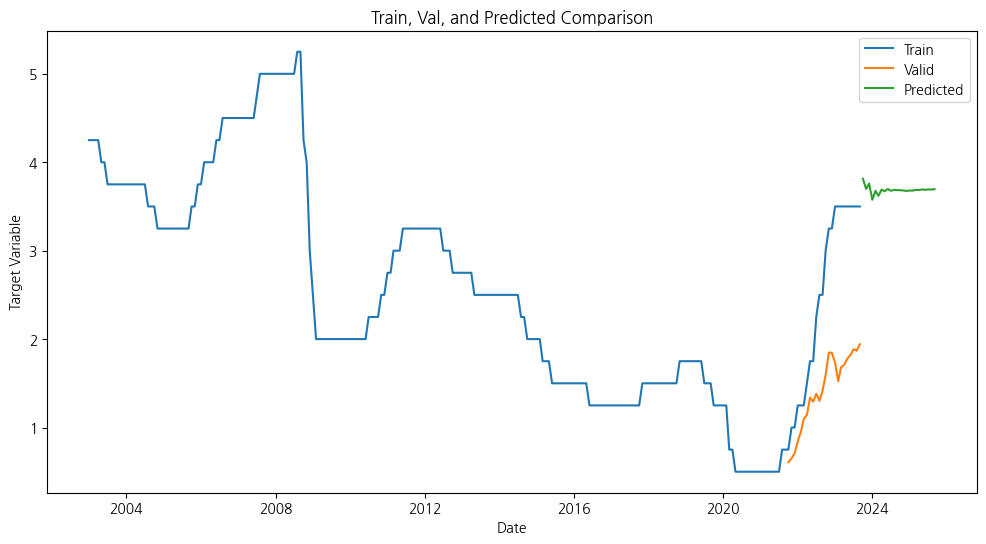

In [ ]:
# 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data['기준금리'], label='Train')
plt.plot(results_v24.index, results_v24['Val'], label='Valid')
plt.plot(results24.index, results24['Predicted'], label='Predicted')
plt.title('Train, Val, and Predicted Comparison')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

## 30개월

### 3-1) VECM 모델 훈련

In [ ]:
# train 데이터로 모델 훈련
modelV = VECM(df_diff, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = modelV.fit()

In [ ]:
# 미래의 독립변수 예측
future_steps = 30  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, :-1]

In [ ]:
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum(axis=0) + np.array(imp.iloc[-1,:]).reshape(1,-1)

# 미래의 독립변수 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[[ 5.04358431e+00  4.51091463e+00  4.41187606e+00  1.00313957e+00
   9.06903658e-01  1.00482947e+00  1.01592572e+00  8.14782855e-01
   8.96575369e-01  1.00499643e+00  9.08897333e-01  4.50425347e-01
   7.30824236e-01  4.04420808e-02  8.00566789e-01  2.76647421e-01
   4.66297071e+00  9.84489903e-01]
 [ 5.15561871e+00  4.73399023e+00  4.61238243e+00  1.00428402e+00
   9.01896687e-01  1.00967147e+00  1.00397017e+00  8.13078560e-01
   8.97285648e-01  9.92023618e-01  8.59781503e-01  4.63679989e-01
   7.13221056e-01  4.18033563e-02  8.18535145e-01  3.80980815e-01
   4.85688409e+00  9.83773515e-01]
 [ 5.14743029e+00  4.77979332e+00  4.68440432e+00  1.00740865e+00
   8.94736167e-01  1.01345349e+00  1.01263864e+00  8.14570329e-01
   9.09653967e-01  1.00924330e+00  9.09241484e-01  4.65739487e-01
   7.06689105e-01  4.41589954e-02  8.31936913e-01  4.40565474e-01
   4.92435304e+00  9.83460097e-01]
 [ 5.05473244e+00  4.69713948e+00  4.65102020e+00  1.01097040e+00
  

### 3-2) 독립변수 생성

In [ ]:
idx = pd.date_range(start='2023-10-01', periods=future_steps, freq='MS')
future_df30 = pd.DataFrame(data=future_forecast, columns=imp.columns, index=idx)

In [ ]:
future_df30

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원)
2023-10-01,5.043584,4.510915,4.411876,1.003140,0.906904,1.004829,1.015926,0.814783,0.896575,1.004996,0.908897,0.450425,0.730824,0.040442,0.800567,0.276647,4.662971,0.984490
2023-11-01,5.155619,4.733990,4.612382,1.004284,0.901897,1.009671,1.003970,0.813079,0.897286,0.992024,0.859782,0.463680,0.713221,0.041803,0.818535,0.380981,4.856884,0.983774
2023-12-01,5.147430,4.779793,4.684404,1.007409,0.894736,1.013453,1.012639,0.814570,0.909654,1.009243,0.909241,0.465739,0.706689,0.044159,0.831937,0.440565,4.924353,0.983460
2024-01-01,5.054732,4.697139,4.651020,1.010970,0.912157,1.017326,1.008953,0.826262,0.922013,1.001956,0.868210,0.500469,0.706951,0.040427,0.848610,0.491552,4.926137,1.006308
2024-02-01,5.131210,4.780452,4.733655,1.015625,0.929065,1.020893,1.008988,0.832955,0.924586,1.000980,0.898751,0.476316,0.711759,0.036172,0.840146,0.478164,5.004605,1.002871
2024-03-01,5.149210,4.782960,4.709681,1.019362,0.933244,1.025035,1.007728,0.835363,0.925886,0.999690,0.871369,0.486888,0.712730,0.034549,0.847702,0.439876,4.980541,1.013573
2024-04-01,5.183697,4.786049,4.709218,1.023760,0.927194,1.029002,1.010300,0.839525,0.925005,1.004724,0.890951,0.465350,0.717392,0.035469,0.838530,0.403999,4.978455,1.015614
2024-05-01,5.216138,4.810425,4.728708,1.027482,0.931860,1.033694,1.008095,0.841304,0.927909,1.000774,0.878963,0.475385,0.719942,0.033370,0.842315,0.406501,4.998015,1.023179
2024-06-01,5.291250,4.877446,4.778151,1.031400,0.934335,1.038771,1.008900,0.842356,0.930143,1.001609,0.888395,0.458940,0.724350,0.031891,0.840051,0.433516,5.033341,1.023624
2024-07-01,5.324352,4.906862,4.796966,1.034875,0.936216,1.043593,1.008043,0.843258,0.935584,1.000540,0.878828,0.467484,0.727149,0.029136,0.847924,0.447911,5.045182,1.028119


### 3-3) 데이터 LSTM으로 형태변환

In [ ]:
# X와 y로 분리
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset.iloc[i:(i + time_steps), :-1]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_steps, -1])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
train_time = -30
X_train, y_train = create_dataset(all_data.iloc[:train_time,:], time_steps)
X_val, y_val = create_dataset(all_data.iloc[train_time-1:,:], time_steps)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((218, 1, 18), (218,), (30, 1, 18), (30,))

### 3-4) LSTM모델 훈련

In [ ]:
# # LSTM 모델 생성
# modelL = Sequential()
# modelL.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
# modelL.add(Dropout(0.3))

# modelL.add(Dense(16))
# modelL.add(BatchNormalization())  # 추가: 배치 정규화
# modelL.add(Dropout(0.3))

# modelL.add(Dense(8))
# modelL.add(BatchNormalization())  # 추가: 배치 정규화
# modelL.add(Dropout(0.3))

# modelL.add(Dense(1))
# modelL.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

### 씨드 고정해야함
modelL.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/300
14/14 - 0s - loss: 0.3049 - val_loss: 0.0557 - 130ms/epoch - 9ms/step
Epoch 2/300
14/14 - 0s - loss: 0.2610 - val_loss: 0.0603 - 70ms/epoch - 5ms/step
Epoch 3/300
14/14 - 0s - loss: 0.3476 - val_loss: 0.0868 - 84ms/epoch - 6ms/step
Epoch 4/300
14/14 - 0s - loss: 0.2987 - val_loss: 0.0681 - 68ms/epoch - 5ms/step
Epoch 5/300
14/14 - 0s - loss: 0.2997 - val_loss: 0.0564 - 92ms/epoch - 7ms/step
Epoch 6/300
14/14 - 0s - loss: 0.3090 - val_loss: 0.1038 - 81ms/epoch - 6ms/step
Epoch 7/300
14/14 - 0s - loss: 0.2907 - val_loss: 0.0682 - 84ms/epoch - 6ms/step
Epoch 8/300
14/14 - 0s - loss: 0.2857 - val_loss: 0.0965 - 65ms/epoch - 5ms/step
Epoch 9/300
14/14 - 0s - loss: 0.2650 - val_loss: 0.0392 - 68ms/epoch - 5ms/step
Epoch 10/300
14/14 - 0s - loss: 0.2338 - val_loss: 0.0731 - 82ms/epoch - 6ms/step
Epoch 11/300
14/14 - 0s - loss: 0.3734 - val_loss: 0.0556 - 89ms/epoch - 6ms/step
Epoch 12/300
14/14 - 0s - loss: 0.3164 - val_loss: 0.0980 - 73ms/epoch - 5ms/step
Epoch 13/300
14/14 - 0s 

In [ ]:
val_pred = modelL.predict(X_val)

1/1 [==============================] - 0s 20ms/step


In [ ]:
future_date = future_steps
results_v30 = pd.DataFrame({'Val':val_pred.reshape(-1)}, index=all_data.index[-future_date:])
results_v30

,Val
날짜,
2021-04-01,0.791623
2021-05-01,0.874392
2021-06-01,0.927518
2021-07-01,0.860156
2021-08-01,0.789574
2021-09-01,0.729754
2021-10-01,0.775353
2021-11-01,0.862498
2021-12-01,0.962875


### 3-5) 기준금리 예측

In [ ]:
f_x_train, f_y_train = create_dataset(all_data, time_steps)
modelL.fit(f_x_train, f_y_train, epochs=500, batch_size=16, verbose=2, callbacks=[early_stopping])

Epoch 1/500


16/16 - 0s - loss: 0.2812 - 52ms/epoch - 3ms/step
Epoch 2/500


16/16 - 0s - loss: 0.3048 - 54ms/epoch - 3ms/step
Epoch 3/500


16/16 - 0s - loss: 0.3383 - 52ms/epoch - 3ms/step
Epoch 4/500


16/16 - 0s - loss: 0.2694 - 49ms/epoch - 3ms/step
Epoch 5/500


16/16 - 0s - loss: 0.3176 - 53ms/epoch - 3ms/step
Epoch 6/500


16/16 - 0s - loss: 0.2779 - 52ms/epoch - 3ms/step
Epoch 7/500


16/16 - 0s - loss: 0.2817 - 53ms/epoch - 3ms/step
Epoch 8/500


16/16 - 0s - loss: 0.3221 - 67ms/epoch - 4ms/step
Epoch 9/500


16/16 - 0s - loss: 0.3467 - 54ms/epoch - 3ms/step
Epoch 10/500


16/16 - 0s - loss: 0.3370 - 56ms/epoch - 4ms/step
Epoch 11/500


16/16 - 0s - loss: 0.4081 - 52ms/epoch - 3ms/step
Epoch 12/500


16/16 - 0s - loss: 0.4116 - 51ms/epoch - 3ms/step
Epoch 13/500


16/16 - 0s - loss: 0.3114 - 52ms/epoch - 3ms/step
Epoch 14/500


16/16 - 0s - loss: 0.3601 - 54ms/epoch - 3ms/step
Epoch 15/500


16/16 - 0s - loss: 0.3026 - 53ms/epoch - 3ms/step
Epoch 16/500


16/16 - 0s - loss: 0.2444 - 51ms/epoch - 3ms/step
Epoch 17/500


16/16 - 0s - loss: 0.2971 - 53ms/epoch - 3ms/step
Epoch 18/500


16/16 - 0s - loss: 0.2871 - 69ms/epoch - 4ms/step
Epoch 19/500


16/16 - 0s - loss: 0.3331 - 53ms/epoch - 3ms/step
Epoch 20/500


16/16 - 0s - loss: 0.3449 - 68ms/epoch - 4ms/step
Epoch 21/500


16/16 - 0s - loss: 0.3295 - 50ms/epoch - 3ms/step
Epoch 22/500


16/16 - 0s - loss: 0.2528 - 51ms/epoch - 3ms/step
Epoch 23/500


16/16 - 0s - loss: 0.3307 - 53ms/epoch - 3ms/step
Epoch 24/500


16/16 - 0s - loss: 0.3208 - 52ms/epoch - 3ms/step
Epoch 25/500


16/16 - 0s - loss: 0.3767 - 51ms/epoch - 3ms/step
Epoch 26/500


16/16 - 0s - loss: 0.3640 - 57ms/epoch - 4ms/step
Epoch 27/500


16/16 - 0s - loss: 0.3039 - 54ms/epoch - 3ms/step
Epoch 28/500


16/16 - 0s - loss: 0.3484 - 54ms/epoch - 3ms/step
Epoch 29/500


16/16 - 0s - loss: 0.3768 - 48ms/epoch - 3ms/step
Epoch 30/500


16/16 - 0s - loss: 0.2961 - 51ms/epoch - 3ms/step
Epoch 31/500


16/16 - 0s - loss: 0.3299 - 60ms/epoch - 4ms/step
Epoch 32/500


16/16 - 0s - loss: 0.3056 - 61ms/epoch - 4ms/step
Epoch 33/500


16/16 - 0s - loss: 0.3497 - 56ms/epoch - 3ms/step
Epoch 34/500


16/16 - 0s - loss: 0.2968 - 53ms/epoch - 3ms/step
Epoch 35/500


16/16 - 0s - loss: 0.3337 - 63ms/epoch - 4ms/step
Epoch 36/500


16/16 - 0s - loss: 0.3592 - 52ms/epoch - 3ms/step
Epoch 37/500


16/16 - 0s - loss: 0.3089 - 50ms/epoch - 3ms/step
Epoch 38/500


16/16 - 0s - loss: 0.2912 - 58ms/epoch - 4ms/step
Epoch 39/500


16/16 - 0s - loss: 0.2906 - 52ms/epoch - 3ms/step
Epoch 40/500


16/16 - 0s - loss: 0.3265 - 54ms/epoch - 3ms/step
Epoch 41/500


16/16 - 0s - loss: 0.3536 - 56ms/epoch - 4ms/step
Epoch 42/500


16/16 - 0s - loss: 0.3214 - 53ms/epoch - 3ms/step
Epoch 43/500


16/16 - 0s - loss: 0.2970 - 50ms/epoch - 3ms/step
Epoch 44/500


16/16 - 0s - loss: 0.3067 - 48ms/epoch - 3ms/step
Epoch 45/500


16/16 - 0s - loss: 0.3291 - 55ms/epoch - 3ms/step
Epoch 46/500


16/16 - 0s - loss: 0.3101 - 65ms/epoch - 4ms/step
Epoch 47/500


16/16 - 0s - loss: 0.3180 - 65ms/epoch - 4ms/step
Epoch 48/500


16/16 - 0s - loss: 0.3058 - 67ms/epoch - 4ms/step
Epoch 49/500


16/16 - 0s - loss: 0.3099 - 73ms/epoch - 5ms/step
Epoch 50/500


16/16 - 0s - loss: 0.3071 - 75ms/epoch - 5ms/step
Epoch 51/500


16/16 - 0s - loss: 0.3840 - 70ms/epoch - 4ms/step
Epoch 52/500


16/16 - 0s - loss: 0.3636 - 77ms/epoch - 5ms/step
Epoch 53/500


16/16 - 0s - loss: 0.4698 - 71ms/epoch - 4ms/step
Epoch 54/500


16/16 - 0s - loss: 0.3133 - 68ms/epoch - 4ms/step
Epoch 55/500


16/16 - 0s - loss: 0.3170 - 67ms/epoch - 4ms/step
Epoch 56/500


16/16 - 0s - loss: 0.2739 - 75ms/epoch - 5ms/step
Epoch 57/500


16/16 - 0s - loss: 0.2972 - 75ms/epoch - 5ms/step
Epoch 58/500


16/16 - 0s - loss: 0.3322 - 80ms/epoch - 5ms/step
Epoch 59/500


16/16 - 0s - loss: 0.2704 - 73ms/epoch - 5ms/step
Epoch 60/500


16/16 - 0s - loss: 0.4038 - 74ms/epoch - 5ms/step
Epoch 61/500


16/16 - 0s - loss: 0.2548 - 82ms/epoch - 5ms/step
Epoch 62/500


16/16 - 0s - loss: 0.3355 - 71ms/epoch - 4ms/step
Epoch 63/500


16/16 - 0s - loss: 0.3548 - 70ms/epoch - 4ms/step
Epoch 64/500


16/16 - 0s - loss: 0.3368 - 92ms/epoch - 6ms/step
Epoch 65/500


16/16 - 0s - loss: 0.3415 - 89ms/epoch - 6ms/step
Epoch 66/500


16/16 - 0s - loss: 0.3719 - 93ms/epoch - 6ms/step
Epoch 67/500


16/16 - 0s - loss: 0.3430 - 73ms/epoch - 5ms/step
Epoch 68/500


16/16 - 0s - loss: 0.3798 - 76ms/epoch - 5ms/step
Epoch 69/500


16/16 - 0s - loss: 0.2770 - 80ms/epoch - 5ms/step
Epoch 70/500


16/16 - 0s - loss: 0.2991 - 72ms/epoch - 5ms/step
Epoch 71/500


16/16 - 0s - loss: 0.3559 - 78ms/epoch - 5ms/step
Epoch 72/500


16/16 - 0s - loss: 0.3011 - 83ms/epoch - 5ms/step
Epoch 73/500


16/16 - 0s - loss: 0.3940 - 74ms/epoch - 5ms/step
Epoch 74/500


16/16 - 0s - loss: 0.3303 - 89ms/epoch - 6ms/step
Epoch 75/500


16/16 - 0s - loss: 0.2486 - 71ms/epoch - 4ms/step
Epoch 76/500


16/16 - 0s - loss: 0.2737 - 85ms/epoch - 5ms/step
Epoch 77/500


16/16 - 0s - loss: 0.2929 - 87ms/epoch - 5ms/step
Epoch 78/500


16/16 - 0s - loss: 0.3066 - 81ms/epoch - 5ms/step
Epoch 79/500


16/16 - 0s - loss: 0.2943 - 83ms/epoch - 5ms/step
Epoch 80/500


16/16 - 0s - loss: 0.2574 - 77ms/epoch - 5ms/step
Epoch 81/500


16/16 - 0s - loss: 0.3014 - 76ms/epoch - 5ms/step
Epoch 82/500


16/16 - 0s - loss: 0.2686 - 76ms/epoch - 5ms/step
Epoch 83/500


16/16 - 0s - loss: 0.2865 - 71ms/epoch - 4ms/step
Epoch 84/500


16/16 - 0s - loss: 0.2787 - 75ms/epoch - 5ms/step
Epoch 85/500


16/16 - 0s - loss: 0.3274 - 74ms/epoch - 5ms/step
Epoch 86/500


16/16 - 0s - loss: 0.2855 - 69ms/epoch - 4ms/step
Epoch 87/500


16/16 - 0s - loss: 0.3674 - 68ms/epoch - 4ms/step
Epoch 88/500


16/16 - 0s - loss: 0.2964 - 68ms/epoch - 4ms/step
Epoch 89/500


16/16 - 0s - loss: 0.3096 - 85ms/epoch - 5ms/step
Epoch 90/500


16/16 - 0s - loss: 0.2393 - 88ms/epoch - 5ms/step
Epoch 91/500


16/16 - 0s - loss: 0.2913 - 82ms/epoch - 5ms/step
Epoch 92/500


16/16 - 0s - loss: 0.2718 - 81ms/epoch - 5ms/step
Epoch 93/500


16/16 - 0s - loss: 0.2955 - 78ms/epoch - 5ms/step
Epoch 94/500


16/16 - 0s - loss: 0.3419 - 81ms/epoch - 5ms/step
Epoch 95/500


16/16 - 0s - loss: 0.3745 - 86ms/epoch - 5ms/step
Epoch 96/500


16/16 - 0s - loss: 0.3374 - 82ms/epoch - 5ms/step
Epoch 97/500


16/16 - 0s - loss: 0.2876 - 81ms/epoch - 5ms/step
Epoch 98/500


16/16 - 0s - loss: 0.3171 - 75ms/epoch - 5ms/step
Epoch 99/500


16/16 - 0s - loss: 0.4320 - 79ms/epoch - 5ms/step
Epoch 100/500


16/16 - 0s - loss: 0.3260 - 75ms/epoch - 5ms/step
Epoch 101/500


16/16 - 0s - loss: 0.3136 - 76ms/epoch - 5ms/step
Epoch 102/500


16/16 - 0s - loss: 0.3487 - 83ms/epoch - 5ms/step
Epoch 103/500


16/16 - 0s - loss: 0.3013 - 75ms/epoch - 5ms/step
Epoch 104/500


16/16 - 0s - loss: 0.3003 - 78ms/epoch - 5ms/step
Epoch 105/500


16/16 - 0s - loss: 0.2669 - 78ms/epoch - 5ms/step
Epoch 106/500


16/16 - 0s - loss: 0.2966 - 73ms/epoch - 5ms/step
Epoch 107/500


16/16 - 0s - loss: 0.2950 - 78ms/epoch - 5ms/step
Epoch 108/500


16/16 - 0s - loss: 0.3312 - 73ms/epoch - 5ms/step
Epoch 109/500


16/16 - 0s - loss: 0.3246 - 73ms/epoch - 5ms/step
Epoch 110/500


16/16 - 0s - loss: 0.2705 - 84ms/epoch - 5ms/step
Epoch 111/500


16/16 - 0s - loss: 0.3349 - 83ms/epoch - 5ms/step
Epoch 112/500


16/16 - 0s - loss: 0.2513 - 79ms/epoch - 5ms/step
Epoch 113/500


16/16 - 0s - loss: 0.3547 - 75ms/epoch - 5ms/step
Epoch 114/500


16/16 - 0s - loss: 0.3105 - 86ms/epoch - 5ms/step
Epoch 115/500


16/16 - 0s - loss: 0.2434 - 83ms/epoch - 5ms/step
Epoch 116/500


16/16 - 0s - loss: 0.2572 - 72ms/epoch - 5ms/step
Epoch 117/500


16/16 - 0s - loss: 0.2638 - 70ms/epoch - 4ms/step
Epoch 118/500


16/16 - 0s - loss: 0.3235 - 70ms/epoch - 4ms/step
Epoch 119/500


16/16 - 0s - loss: 0.2969 - 75ms/epoch - 5ms/step
Epoch 120/500


16/16 - 0s - loss: 0.2919 - 82ms/epoch - 5ms/step
Epoch 121/500


16/16 - 0s - loss: 0.3433 - 75ms/epoch - 5ms/step
Epoch 122/500


16/16 - 0s - loss: 0.3758 - 78ms/epoch - 5ms/step
Epoch 123/500


16/16 - 0s - loss: 0.3324 - 73ms/epoch - 5ms/step
Epoch 124/500


16/16 - 0s - loss: 0.3278 - 68ms/epoch - 4ms/step
Epoch 125/500


16/16 - 0s - loss: 0.2637 - 75ms/epoch - 5ms/step
Epoch 126/500


16/16 - 0s - loss: 0.3843 - 77ms/epoch - 5ms/step
Epoch 127/500


16/16 - 0s - loss: 0.3100 - 74ms/epoch - 5ms/step
Epoch 128/500


16/16 - 0s - loss: 0.3345 - 74ms/epoch - 5ms/step
Epoch 129/500


16/16 - 0s - loss: 0.2884 - 79ms/epoch - 5ms/step
Epoch 130/500


16/16 - 0s - loss: 0.2380 - 79ms/epoch - 5ms/step
Epoch 131/500


16/16 - 0s - loss: 0.2698 - 81ms/epoch - 5ms/step
Epoch 132/500


16/16 - 0s - loss: 0.3243 - 73ms/epoch - 5ms/step
Epoch 133/500


16/16 - 0s - loss: 0.2544 - 68ms/epoch - 4ms/step
Epoch 134/500


16/16 - 0s - loss: 0.2925 - 80ms/epoch - 5ms/step
Epoch 135/500


16/16 - 0s - loss: 0.2781 - 76ms/epoch - 5ms/step
Epoch 136/500


16/16 - 0s - loss: 0.2848 - 73ms/epoch - 5ms/step
Epoch 137/500


16/16 - 0s - loss: 0.3023 - 78ms/epoch - 5ms/step
Epoch 138/500


16/16 - 0s - loss: 0.3170 - 78ms/epoch - 5ms/step
Epoch 139/500


16/16 - 0s - loss: 0.3249 - 86ms/epoch - 5ms/step
Epoch 140/500


16/16 - 0s - loss: 0.3029 - 84ms/epoch - 5ms/step
Epoch 141/500


16/16 - 0s - loss: 0.2278 - 59ms/epoch - 4ms/step
Epoch 142/500


16/16 - 0s - loss: 0.3188 - 53ms/epoch - 3ms/step
Epoch 143/500


16/16 - 0s - loss: 0.2518 - 51ms/epoch - 3ms/step
Epoch 144/500


16/16 - 0s - loss: 0.3537 - 55ms/epoch - 3ms/step
Epoch 145/500


16/16 - 0s - loss: 0.2241 - 52ms/epoch - 3ms/step
Epoch 146/500


16/16 - 0s - loss: 0.2802 - 52ms/epoch - 3ms/step
Epoch 147/500


16/16 - 0s - loss: 0.3111 - 52ms/epoch - 3ms/step
Epoch 148/500


16/16 - 0s - loss: 0.2876 - 51ms/epoch - 3ms/step
Epoch 149/500


16/16 - 0s - loss: 0.3049 - 50ms/epoch - 3ms/step
Epoch 150/500


16/16 - 0s - loss: 0.2898 - 57ms/epoch - 4ms/step
Epoch 151/500


16/16 - 0s - loss: 0.3051 - 49ms/epoch - 3ms/step
Epoch 152/500


16/16 - 0s - loss: 0.3164 - 53ms/epoch - 3ms/step
Epoch 153/500


16/16 - 0s - loss: 0.2717 - 54ms/epoch - 3ms/step
Epoch 154/500


16/16 - 0s - loss: 0.2743 - 54ms/epoch - 3ms/step
Epoch 155/500


16/16 - 0s - loss: 0.3658 - 50ms/epoch - 3ms/step
Epoch 156/500


16/16 - 0s - loss: 0.2846 - 52ms/epoch - 3ms/step
Epoch 157/500


16/16 - 0s - loss: 0.2832 - 51ms/epoch - 3ms/step
Epoch 158/500


16/16 - 0s - loss: 0.2970 - 54ms/epoch - 3ms/step
Epoch 159/500


16/16 - 0s - loss: 0.3578 - 60ms/epoch - 4ms/step
Epoch 160/500


16/16 - 0s - loss: 0.3569 - 59ms/epoch - 4ms/step
Epoch 161/500


16/16 - 0s - loss: 0.2979 - 56ms/epoch - 3ms/step
Epoch 162/500


16/16 - 0s - loss: 0.2918 - 58ms/epoch - 4ms/step
Epoch 163/500


16/16 - 0s - loss: 0.2941 - 60ms/epoch - 4ms/step
Epoch 164/500


16/16 - 0s - loss: 0.3483 - 55ms/epoch - 3ms/step
Epoch 165/500


16/16 - 0s - loss: 0.2703 - 55ms/epoch - 3ms/step
Epoch 166/500


16/16 - 0s - loss: 0.2524 - 53ms/epoch - 3ms/step
Epoch 167/500


16/16 - 0s - loss: 0.3395 - 53ms/epoch - 3ms/step
Epoch 168/500


16/16 - 0s - loss: 0.3421 - 54ms/epoch - 3ms/step
Epoch 169/500


16/16 - 0s - loss: 0.2726 - 55ms/epoch - 3ms/step
Epoch 170/500


16/16 - 0s - loss: 0.2686 - 52ms/epoch - 3ms/step
Epoch 171/500


16/16 - 0s - loss: 0.3315 - 54ms/epoch - 3ms/step
Epoch 172/500


16/16 - 0s - loss: 0.2843 - 54ms/epoch - 3ms/step
Epoch 173/500


16/16 - 0s - loss: 0.2089 - 57ms/epoch - 4ms/step
Epoch 174/500


16/16 - 0s - loss: 0.2748 - 58ms/epoch - 4ms/step
Epoch 175/500


16/16 - 0s - loss: 0.3328 - 53ms/epoch - 3ms/step
Epoch 176/500


16/16 - 0s - loss: 0.3223 - 61ms/epoch - 4ms/step
Epoch 177/500


16/16 - 0s - loss: 0.2451 - 56ms/epoch - 3ms/step
Epoch 178/500


16/16 - 0s - loss: 0.3274 - 55ms/epoch - 3ms/step
Epoch 179/500


16/16 - 0s - loss: 0.2439 - 58ms/epoch - 4ms/step
Epoch 180/500


16/16 - 0s - loss: 0.2835 - 58ms/epoch - 4ms/step
Epoch 181/500


16/16 - 0s - loss: 0.3037 - 59ms/epoch - 4ms/step
Epoch 182/500


16/16 - 0s - loss: 0.3002 - 54ms/epoch - 3ms/step
Epoch 183/500


16/16 - 0s - loss: 0.2952 - 60ms/epoch - 4ms/step
Epoch 184/500


16/16 - 0s - loss: 0.2875 - 56ms/epoch - 4ms/step
Epoch 185/500


16/16 - 0s - loss: 0.3025 - 59ms/epoch - 4ms/step
Epoch 186/500


16/16 - 0s - loss: 0.2539 - 54ms/epoch - 3ms/step
Epoch 187/500


16/16 - 0s - loss: 0.2448 - 60ms/epoch - 4ms/step
Epoch 188/500


16/16 - 0s - loss: 0.2796 - 52ms/epoch - 3ms/step
Epoch 189/500


16/16 - 0s - loss: 0.3718 - 52ms/epoch - 3ms/step
Epoch 190/500


16/16 - 0s - loss: 0.3431 - 63ms/epoch - 4ms/step
Epoch 191/500


16/16 - 0s - loss: 0.3301 - 53ms/epoch - 3ms/step
Epoch 192/500


16/16 - 0s - loss: 0.3907 - 60ms/epoch - 4ms/step
Epoch 193/500


16/16 - 0s - loss: 0.3161 - 56ms/epoch - 3ms/step
Epoch 194/500


16/16 - 0s - loss: 0.2542 - 54ms/epoch - 3ms/step
Epoch 195/500


16/16 - 0s - loss: 0.3302 - 53ms/epoch - 3ms/step
Epoch 196/500


16/16 - 0s - loss: 0.3240 - 54ms/epoch - 3ms/step
Epoch 197/500


16/16 - 0s - loss: 0.3435 - 57ms/epoch - 4ms/step
Epoch 198/500


16/16 - 0s - loss: 0.2523 - 51ms/epoch - 3ms/step
Epoch 199/500


16/16 - 0s - loss: 0.2733 - 62ms/epoch - 4ms/step
Epoch 200/500


16/16 - 0s - loss: 0.3138 - 54ms/epoch - 3ms/step
Epoch 201/500


16/16 - 0s - loss: 0.2509 - 56ms/epoch - 3ms/step
Epoch 202/500


16/16 - 0s - loss: 0.3016 - 56ms/epoch - 3ms/step
Epoch 203/500


16/16 - 0s - loss: 0.2755 - 55ms/epoch - 3ms/step
Epoch 204/500


16/16 - 0s - loss: 0.2808 - 53ms/epoch - 3ms/step
Epoch 205/500


16/16 - 0s - loss: 0.2937 - 51ms/epoch - 3ms/step
Epoch 206/500


16/16 - 0s - loss: 0.3129 - 57ms/epoch - 4ms/step
Epoch 207/500


16/16 - 0s - loss: 0.2687 - 60ms/epoch - 4ms/step
Epoch 208/500


16/16 - 0s - loss: 0.2855 - 55ms/epoch - 3ms/step
Epoch 209/500


16/16 - 0s - loss: 0.2231 - 67ms/epoch - 4ms/step
Epoch 210/500


16/16 - 0s - loss: 0.3200 - 55ms/epoch - 3ms/step
Epoch 211/500


16/16 - 0s - loss: 0.3065 - 54ms/epoch - 3ms/step
Epoch 212/500


16/16 - 0s - loss: 0.2794 - 52ms/epoch - 3ms/step
Epoch 213/500


16/16 - 0s - loss: 0.3212 - 53ms/epoch - 3ms/step
Epoch 214/500


16/16 - 0s - loss: 0.2869 - 51ms/epoch - 3ms/step
Epoch 215/500


16/16 - 0s - loss: 0.3350 - 66ms/epoch - 4ms/step
Epoch 216/500


16/16 - 0s - loss: 0.2791 - 59ms/epoch - 4ms/step
Epoch 217/500


16/16 - 0s - loss: 0.2483 - 65ms/epoch - 4ms/step
Epoch 218/500


16/16 - 0s - loss: 0.3121 - 70ms/epoch - 4ms/step
Epoch 219/500


16/16 - 0s - loss: 0.2413 - 57ms/epoch - 4ms/step
Epoch 220/500


16/16 - 0s - loss: 0.3599 - 58ms/epoch - 4ms/step
Epoch 221/500


16/16 - 0s - loss: 0.3045 - 57ms/epoch - 4ms/step
Epoch 222/500


16/16 - 0s - loss: 0.2586 - 54ms/epoch - 3ms/step
Epoch 223/500


16/16 - 0s - loss: 0.2940 - 58ms/epoch - 4ms/step
Epoch 224/500


16/16 - 0s - loss: 0.3163 - 60ms/epoch - 4ms/step
Epoch 225/500


16/16 - 0s - loss: 0.4181 - 66ms/epoch - 4ms/step
Epoch 226/500


16/16 - 0s - loss: 0.2114 - 65ms/epoch - 4ms/step
Epoch 227/500


16/16 - 0s - loss: 0.2890 - 54ms/epoch - 3ms/step
Epoch 228/500


16/16 - 0s - loss: 0.3501 - 63ms/epoch - 4ms/step
Epoch 229/500


16/16 - 0s - loss: 0.3054 - 56ms/epoch - 4ms/step
Epoch 230/500


16/16 - 0s - loss: 0.2963 - 63ms/epoch - 4ms/step
Epoch 231/500


16/16 - 0s - loss: 0.2609 - 58ms/epoch - 4ms/step
Epoch 232/500


16/16 - 0s - loss: 0.2659 - 74ms/epoch - 5ms/step
Epoch 233/500


16/16 - 0s - loss: 0.3126 - 60ms/epoch - 4ms/step
Epoch 234/500


16/16 - 0s - loss: 0.2672 - 52ms/epoch - 3ms/step
Epoch 235/500


16/16 - 0s - loss: 0.2975 - 55ms/epoch - 3ms/step
Epoch 236/500


16/16 - 0s - loss: 0.3237 - 67ms/epoch - 4ms/step
Epoch 237/500


16/16 - 0s - loss: 0.2873 - 56ms/epoch - 3ms/step
Epoch 238/500


16/16 - 0s - loss: 0.2700 - 61ms/epoch - 4ms/step
Epoch 239/500


16/16 - 0s - loss: 0.2753 - 53ms/epoch - 3ms/step
Epoch 240/500


16/16 - 0s - loss: 0.2980 - 60ms/epoch - 4ms/step
Epoch 241/500


16/16 - 0s - loss: 0.3041 - 61ms/epoch - 4ms/step
Epoch 242/500


16/16 - 0s - loss: 0.2461 - 57ms/epoch - 4ms/step
Epoch 243/500


16/16 - 0s - loss: 0.2805 - 50ms/epoch - 3ms/step
Epoch 244/500


16/16 - 0s - loss: 0.2151 - 57ms/epoch - 4ms/step
Epoch 245/500


16/16 - 0s - loss: 0.3528 - 58ms/epoch - 4ms/step
Epoch 246/500


16/16 - 0s - loss: 0.2720 - 55ms/epoch - 3ms/step
Epoch 247/500


16/16 - 0s - loss: 0.3140 - 57ms/epoch - 4ms/step
Epoch 248/500


16/16 - 0s - loss: 0.2475 - 50ms/epoch - 3ms/step
Epoch 249/500


16/16 - 0s - loss: 0.2691 - 56ms/epoch - 3ms/step
Epoch 250/500


16/16 - 0s - loss: 0.2624 - 56ms/epoch - 3ms/step
Epoch 251/500


16/16 - 0s - loss: 0.2944 - 62ms/epoch - 4ms/step
Epoch 252/500


16/16 - 0s - loss: 0.3336 - 57ms/epoch - 4ms/step
Epoch 253/500


16/16 - 0s - loss: 0.2046 - 49ms/epoch - 3ms/step
Epoch 254/500


16/16 - 0s - loss: 0.2548 - 63ms/epoch - 4ms/step
Epoch 255/500


16/16 - 0s - loss: 0.2802 - 58ms/epoch - 4ms/step
Epoch 256/500


16/16 - 0s - loss: 0.2237 - 58ms/epoch - 4ms/step
Epoch 257/500


16/16 - 0s - loss: 0.3418 - 56ms/epoch - 3ms/step
Epoch 258/500


16/16 - 0s - loss: 0.3021 - 62ms/epoch - 4ms/step
Epoch 259/500


16/16 - 0s - loss: 0.3069 - 56ms/epoch - 4ms/step
Epoch 260/500


16/16 - 0s - loss: 0.2137 - 58ms/epoch - 4ms/step
Epoch 261/500


16/16 - 0s - loss: 0.2765 - 60ms/epoch - 4ms/step
Epoch 262/500


16/16 - 0s - loss: 0.2864 - 57ms/epoch - 4ms/step
Epoch 263/500


16/16 - 0s - loss: 0.2992 - 55ms/epoch - 3ms/step
Epoch 264/500


16/16 - 0s - loss: 0.2820 - 54ms/epoch - 3ms/step
Epoch 265/500


16/16 - 0s - loss: 0.3456 - 59ms/epoch - 4ms/step
Epoch 266/500


16/16 - 0s - loss: 0.2582 - 54ms/epoch - 3ms/step
Epoch 267/500


16/16 - 0s - loss: 0.3446 - 56ms/epoch - 3ms/step
Epoch 268/500


16/16 - 0s - loss: 0.3272 - 61ms/epoch - 4ms/step
Epoch 269/500


16/16 - 0s - loss: 0.2907 - 57ms/epoch - 4ms/step
Epoch 270/500


16/16 - 0s - loss: 0.2883 - 59ms/epoch - 4ms/step
Epoch 271/500


16/16 - 0s - loss: 0.2407 - 61ms/epoch - 4ms/step
Epoch 272/500


16/16 - 0s - loss: 0.3004 - 52ms/epoch - 3ms/step
Epoch 273/500


16/16 - 0s - loss: 0.2907 - 59ms/epoch - 4ms/step
Epoch 274/500


16/16 - 0s - loss: 0.3878 - 63ms/epoch - 4ms/step
Epoch 275/500


16/16 - 0s - loss: 0.2865 - 57ms/epoch - 4ms/step
Epoch 276/500


16/16 - 0s - loss: 0.2457 - 65ms/epoch - 4ms/step
Epoch 277/500


16/16 - 0s - loss: 0.3279 - 60ms/epoch - 4ms/step
Epoch 278/500


16/16 - 0s - loss: 0.2932 - 63ms/epoch - 4ms/step
Epoch 279/500


16/16 - 0s - loss: 0.2864 - 56ms/epoch - 4ms/step
Epoch 280/500


16/16 - 0s - loss: 0.2831 - 59ms/epoch - 4ms/step
Epoch 281/500


16/16 - 0s - loss: 0.2405 - 56ms/epoch - 3ms/step
Epoch 282/500


16/16 - 0s - loss: 0.2368 - 51ms/epoch - 3ms/step
Epoch 283/500


16/16 - 0s - loss: 0.3409 - 56ms/epoch - 3ms/step
Epoch 284/500


16/16 - 0s - loss: 0.2582 - 61ms/epoch - 4ms/step
Epoch 285/500


16/16 - 0s - loss: 0.2410 - 60ms/epoch - 4ms/step
Epoch 286/500


16/16 - 0s - loss: 0.3543 - 52ms/epoch - 3ms/step
Epoch 287/500


16/16 - 0s - loss: 0.3454 - 63ms/epoch - 4ms/step
Epoch 288/500


16/16 - 0s - loss: 0.2482 - 62ms/epoch - 4ms/step
Epoch 289/500


16/16 - 0s - loss: 0.3287 - 56ms/epoch - 4ms/step
Epoch 290/500


16/16 - 0s - loss: 0.2588 - 64ms/epoch - 4ms/step
Epoch 291/500


16/16 - 0s - loss: 0.2489 - 66ms/epoch - 4ms/step
Epoch 292/500


16/16 - 0s - loss: 0.3336 - 54ms/epoch - 3ms/step
Epoch 293/500


16/16 - 0s - loss: 0.3385 - 55ms/epoch - 3ms/step
Epoch 294/500


16/16 - 0s - loss: 0.2672 - 63ms/epoch - 4ms/step
Epoch 295/500


16/16 - 0s - loss: 0.3070 - 56ms/epoch - 4ms/step
Epoch 296/500


16/16 - 0s - loss: 0.2845 - 54ms/epoch - 3ms/step
Epoch 297/500


16/16 - 0s - loss: 0.3039 - 56ms/epoch - 4ms/step
Epoch 298/500


16/16 - 0s - loss: 0.2870 - 59ms/epoch - 4ms/step
Epoch 299/500


16/16 - 0s - loss: 0.3187 - 56ms/epoch - 4ms/step
Epoch 300/500


16/16 - 0s - loss: 0.2713 - 54ms/epoch - 3ms/step
Epoch 301/500


16/16 - 0s - loss: 0.2852 - 53ms/epoch - 3ms/step
Epoch 302/500


16/16 - 0s - loss: 0.2370 - 81ms/epoch - 5ms/step
Epoch 303/500


16/16 - 0s - loss: 0.3095 - 79ms/epoch - 5ms/step
Epoch 304/500


16/16 - 0s - loss: 0.4485 - 72ms/epoch - 5ms/step
Epoch 305/500


16/16 - 0s - loss: 0.2349 - 70ms/epoch - 4ms/step
Epoch 306/500


16/16 - 0s - loss: 0.2756 - 85ms/epoch - 5ms/step
Epoch 307/500


16/16 - 0s - loss: 0.3738 - 85ms/epoch - 5ms/step
Epoch 308/500


16/16 - 0s - loss: 0.3194 - 75ms/epoch - 5ms/step
Epoch 309/500


16/16 - 0s - loss: 0.2913 - 66ms/epoch - 4ms/step
Epoch 310/500


16/16 - 0s - loss: 0.3318 - 68ms/epoch - 4ms/step
Epoch 311/500


16/16 - 0s - loss: 0.3058 - 67ms/epoch - 4ms/step
Epoch 312/500


16/16 - 0s - loss: 0.2593 - 67ms/epoch - 4ms/step
Epoch 313/500


16/16 - 0s - loss: 0.2899 - 78ms/epoch - 5ms/step
Epoch 314/500


16/16 - 0s - loss: 0.2527 - 73ms/epoch - 5ms/step
Epoch 315/500


16/16 - 0s - loss: 0.3379 - 74ms/epoch - 5ms/step
Epoch 316/500


16/16 - 0s - loss: 0.2698 - 73ms/epoch - 5ms/step
Epoch 317/500


16/16 - 0s - loss: 0.2803 - 77ms/epoch - 5ms/step
Epoch 318/500


16/16 - 0s - loss: 0.3157 - 74ms/epoch - 5ms/step
Epoch 319/500


16/16 - 0s - loss: 0.3401 - 78ms/epoch - 5ms/step
Epoch 320/500


16/16 - 0s - loss: 0.3063 - 77ms/epoch - 5ms/step
Epoch 321/500


16/16 - 0s - loss: 0.2622 - 72ms/epoch - 4ms/step
Epoch 322/500


16/16 - 0s - loss: 0.2736 - 66ms/epoch - 4ms/step
Epoch 323/500


16/16 - 0s - loss: 0.3156 - 68ms/epoch - 4ms/step
Epoch 324/500


16/16 - 0s - loss: 0.2631 - 71ms/epoch - 4ms/step
Epoch 325/500


16/16 - 0s - loss: 0.3217 - 80ms/epoch - 5ms/step
Epoch 326/500


16/16 - 0s - loss: 0.2917 - 82ms/epoch - 5ms/step
Epoch 327/500


16/16 - 0s - loss: 0.2329 - 74ms/epoch - 5ms/step
Epoch 328/500


16/16 - 0s - loss: 0.4135 - 79ms/epoch - 5ms/step
Epoch 329/500


16/16 - 0s - loss: 0.3597 - 82ms/epoch - 5ms/step
Epoch 330/500


16/16 - 0s - loss: 0.3714 - 81ms/epoch - 5ms/step
Epoch 331/500


16/16 - 0s - loss: 0.2393 - 66ms/epoch - 4ms/step
Epoch 332/500


16/16 - 0s - loss: 0.2568 - 70ms/epoch - 4ms/step
Epoch 333/500


16/16 - 0s - loss: 0.2369 - 79ms/epoch - 5ms/step
Epoch 334/500


16/16 - 0s - loss: 0.2675 - 68ms/epoch - 4ms/step
Epoch 335/500


16/16 - 0s - loss: 0.3147 - 75ms/epoch - 5ms/step
Epoch 336/500


16/16 - 0s - loss: 0.2962 - 69ms/epoch - 4ms/step
Epoch 337/500


16/16 - 0s - loss: 0.2438 - 72ms/epoch - 4ms/step
Epoch 338/500


16/16 - 0s - loss: 0.2610 - 68ms/epoch - 4ms/step
Epoch 339/500


16/16 - 0s - loss: 0.3265 - 67ms/epoch - 4ms/step
Epoch 340/500


16/16 - 0s - loss: 0.4053 - 69ms/epoch - 4ms/step
Epoch 341/500


16/16 - 0s - loss: 0.2523 - 78ms/epoch - 5ms/step
Epoch 342/500


16/16 - 0s - loss: 0.2667 - 70ms/epoch - 4ms/step
Epoch 343/500


16/16 - 0s - loss: 0.3052 - 71ms/epoch - 4ms/step
Epoch 344/500


16/16 - 0s - loss: 0.2880 - 81ms/epoch - 5ms/step
Epoch 345/500


16/16 - 0s - loss: 0.2580 - 85ms/epoch - 5ms/step
Epoch 346/500


16/16 - 0s - loss: 0.2682 - 67ms/epoch - 4ms/step
Epoch 347/500


16/16 - 0s - loss: 0.2765 - 92ms/epoch - 6ms/step
Epoch 348/500


16/16 - 0s - loss: 0.2955 - 87ms/epoch - 5ms/step
Epoch 349/500


16/16 - 0s - loss: 0.2668 - 70ms/epoch - 4ms/step
Epoch 350/500


16/16 - 0s - loss: 0.3173 - 73ms/epoch - 5ms/step
Epoch 351/500


16/16 - 0s - loss: 0.4446 - 74ms/epoch - 5ms/step
Epoch 352/500


16/16 - 0s - loss: 0.3189 - 73ms/epoch - 5ms/step
Epoch 353/500


16/16 - 0s - loss: 0.2544 - 77ms/epoch - 5ms/step
Epoch 354/500


16/16 - 0s - loss: 0.2777 - 68ms/epoch - 4ms/step
Epoch 355/500


16/16 - 0s - loss: 0.4011 - 80ms/epoch - 5ms/step
Epoch 356/500


16/16 - 0s - loss: 0.3070 - 89ms/epoch - 6ms/step
Epoch 357/500


16/16 - 0s - loss: 0.2702 - 68ms/epoch - 4ms/step
Epoch 358/500


16/16 - 0s - loss: 0.3713 - 65ms/epoch - 4ms/step
Epoch 359/500


16/16 - 0s - loss: 0.2882 - 65ms/epoch - 4ms/step
Epoch 360/500


16/16 - 0s - loss: 0.2481 - 82ms/epoch - 5ms/step
Epoch 361/500


16/16 - 0s - loss: 0.3240 - 81ms/epoch - 5ms/step
Epoch 362/500


16/16 - 0s - loss: 0.3101 - 71ms/epoch - 4ms/step
Epoch 363/500


16/16 - 0s - loss: 0.3131 - 69ms/epoch - 4ms/step
Epoch 364/500


16/16 - 0s - loss: 0.3888 - 69ms/epoch - 4ms/step
Epoch 365/500


16/16 - 0s - loss: 0.3267 - 85ms/epoch - 5ms/step
Epoch 366/500


16/16 - 0s - loss: 0.2938 - 81ms/epoch - 5ms/step
Epoch 367/500


16/16 - 0s - loss: 0.2298 - 67ms/epoch - 4ms/step
Epoch 368/500


16/16 - 0s - loss: 0.2810 - 72ms/epoch - 5ms/step
Epoch 369/500


16/16 - 0s - loss: 0.2766 - 81ms/epoch - 5ms/step
Epoch 370/500


16/16 - 0s - loss: 0.3159 - 78ms/epoch - 5ms/step
Epoch 371/500


16/16 - 0s - loss: 0.4108 - 65ms/epoch - 4ms/step
Epoch 372/500


16/16 - 0s - loss: 0.3010 - 77ms/epoch - 5ms/step
Epoch 373/500


16/16 - 0s - loss: 0.2248 - 85ms/epoch - 5ms/step
Epoch 374/500


16/16 - 0s - loss: 0.3313 - 81ms/epoch - 5ms/step
Epoch 375/500


16/16 - 0s - loss: 0.3310 - 77ms/epoch - 5ms/step
Epoch 376/500


16/16 - 0s - loss: 0.2838 - 77ms/epoch - 5ms/step
Epoch 377/500


16/16 - 0s - loss: 0.3030 - 76ms/epoch - 5ms/step
Epoch 378/500


16/16 - 0s - loss: 0.2936 - 71ms/epoch - 4ms/step
Epoch 379/500


16/16 - 0s - loss: 0.3246 - 73ms/epoch - 5ms/step
Epoch 380/500


16/16 - 0s - loss: 0.2900 - 71ms/epoch - 4ms/step
Epoch 381/500


16/16 - 0s - loss: 0.3359 - 69ms/epoch - 4ms/step
Epoch 382/500


16/16 - 0s - loss: 0.3178 - 71ms/epoch - 4ms/step
Epoch 383/500


16/16 - 0s - loss: 0.3360 - 74ms/epoch - 5ms/step
Epoch 384/500


16/16 - 0s - loss: 0.2984 - 67ms/epoch - 4ms/step
Epoch 385/500


16/16 - 0s - loss: 0.2663 - 67ms/epoch - 4ms/step
Epoch 386/500


16/16 - 0s - loss: 0.4281 - 69ms/epoch - 4ms/step
Epoch 387/500


16/16 - 0s - loss: 0.3909 - 76ms/epoch - 5ms/step
Epoch 388/500


16/16 - 0s - loss: 0.3614 - 85ms/epoch - 5ms/step
Epoch 389/500


16/16 - 0s - loss: 0.3525 - 72ms/epoch - 5ms/step
Epoch 390/500


16/16 - 0s - loss: 0.2662 - 74ms/epoch - 5ms/step
Epoch 391/500


16/16 - 0s - loss: 0.2804 - 72ms/epoch - 4ms/step
Epoch 392/500


16/16 - 0s - loss: 0.2644 - 75ms/epoch - 5ms/step
Epoch 393/500


16/16 - 0s - loss: 0.2500 - 75ms/epoch - 5ms/step
Epoch 394/500


16/16 - 0s - loss: 0.2559 - 78ms/epoch - 5ms/step
Epoch 395/500


16/16 - 0s - loss: 0.2813 - 78ms/epoch - 5ms/step
Epoch 396/500


16/16 - 0s - loss: 0.2601 - 76ms/epoch - 5ms/step
Epoch 397/500


16/16 - 0s - loss: 0.2984 - 81ms/epoch - 5ms/step
Epoch 398/500


16/16 - 0s - loss: 0.3338 - 69ms/epoch - 4ms/step
Epoch 399/500


16/16 - 0s - loss: 0.2333 - 67ms/epoch - 4ms/step
Epoch 400/500


16/16 - 0s - loss: 0.2273 - 75ms/epoch - 5ms/step
Epoch 401/500


16/16 - 0s - loss: 0.2835 - 83ms/epoch - 5ms/step
Epoch 402/500


16/16 - 0s - loss: 0.3148 - 72ms/epoch - 4ms/step
Epoch 403/500


16/16 - 0s - loss: 0.3162 - 73ms/epoch - 5ms/step
Epoch 404/500


16/16 - 0s - loss: 0.2406 - 79ms/epoch - 5ms/step
Epoch 405/500


16/16 - 0s - loss: 0.3542 - 71ms/epoch - 4ms/step
Epoch 406/500


16/16 - 0s - loss: 0.3411 - 77ms/epoch - 5ms/step
Epoch 407/500


16/16 - 0s - loss: 0.3326 - 73ms/epoch - 5ms/step
Epoch 408/500


16/16 - 0s - loss: 0.2664 - 80ms/epoch - 5ms/step
Epoch 409/500


16/16 - 0s - loss: 0.2830 - 83ms/epoch - 5ms/step
Epoch 410/500


16/16 - 0s - loss: 0.3230 - 70ms/epoch - 4ms/step
Epoch 411/500


16/16 - 0s - loss: 0.2694 - 68ms/epoch - 4ms/step
Epoch 412/500


16/16 - 0s - loss: 0.3081 - 76ms/epoch - 5ms/step
Epoch 413/500


16/16 - 0s - loss: 0.2794 - 66ms/epoch - 4ms/step
Epoch 414/500


16/16 - 0s - loss: 0.3742 - 76ms/epoch - 5ms/step
Epoch 415/500


16/16 - 0s - loss: 0.2488 - 86ms/epoch - 5ms/step
Epoch 416/500


16/16 - 0s - loss: 0.2664 - 75ms/epoch - 5ms/step
Epoch 417/500


16/16 - 0s - loss: 0.2593 - 77ms/epoch - 5ms/step
Epoch 418/500


16/16 - 0s - loss: 0.2609 - 82ms/epoch - 5ms/step
Epoch 419/500


16/16 - 0s - loss: 0.2409 - 77ms/epoch - 5ms/step
Epoch 420/500


16/16 - 0s - loss: 0.2977 - 69ms/epoch - 4ms/step
Epoch 421/500


16/16 - 0s - loss: 0.2331 - 73ms/epoch - 5ms/step
Epoch 422/500


16/16 - 0s - loss: 0.2741 - 78ms/epoch - 5ms/step
Epoch 423/500


16/16 - 0s - loss: 0.3777 - 83ms/epoch - 5ms/step
Epoch 424/500


16/16 - 0s - loss: 0.2775 - 74ms/epoch - 5ms/step
Epoch 425/500


16/16 - 0s - loss: 0.2540 - 80ms/epoch - 5ms/step
Epoch 426/500


16/16 - 0s - loss: 0.3039 - 76ms/epoch - 5ms/step
Epoch 427/500


16/16 - 0s - loss: 0.2495 - 68ms/epoch - 4ms/step
Epoch 428/500


16/16 - 0s - loss: 0.2536 - 81ms/epoch - 5ms/step
Epoch 429/500


16/16 - 0s - loss: 0.3683 - 71ms/epoch - 4ms/step
Epoch 430/500


16/16 - 0s - loss: 0.2746 - 70ms/epoch - 4ms/step
Epoch 431/500


16/16 - 0s - loss: 0.2275 - 69ms/epoch - 4ms/step
Epoch 432/500


16/16 - 0s - loss: 0.2949 - 71ms/epoch - 4ms/step
Epoch 433/500


16/16 - 0s - loss: 0.2537 - 73ms/epoch - 5ms/step
Epoch 434/500


16/16 - 0s - loss: 0.3056 - 78ms/epoch - 5ms/step
Epoch 435/500


16/16 - 0s - loss: 0.2965 - 83ms/epoch - 5ms/step
Epoch 436/500


16/16 - 0s - loss: 0.3824 - 76ms/epoch - 5ms/step
Epoch 437/500


16/16 - 0s - loss: 0.3351 - 62ms/epoch - 4ms/step
Epoch 438/500


16/16 - 0s - loss: 0.2853 - 75ms/epoch - 5ms/step
Epoch 439/500


16/16 - 0s - loss: 0.2320 - 76ms/epoch - 5ms/step
Epoch 440/500


16/16 - 0s - loss: 0.3274 - 58ms/epoch - 4ms/step
Epoch 441/500


16/16 - 0s - loss: 0.1978 - 65ms/epoch - 4ms/step
Epoch 442/500


16/16 - 0s - loss: 0.2733 - 76ms/epoch - 5ms/step
Epoch 443/500


16/16 - 0s - loss: 0.3301 - 57ms/epoch - 4ms/step
Epoch 444/500


16/16 - 0s - loss: 0.3334 - 57ms/epoch - 4ms/step
Epoch 445/500


16/16 - 0s - loss: 0.2211 - 56ms/epoch - 4ms/step
Epoch 446/500


16/16 - 0s - loss: 0.2675 - 60ms/epoch - 4ms/step
Epoch 447/500


16/16 - 0s - loss: 0.2444 - 56ms/epoch - 3ms/step
Epoch 448/500


16/16 - 0s - loss: 0.2586 - 60ms/epoch - 4ms/step
Epoch 449/500


16/16 - 0s - loss: 0.3542 - 56ms/epoch - 4ms/step
Epoch 450/500


16/16 - 0s - loss: 0.3063 - 57ms/epoch - 4ms/step
Epoch 451/500


16/16 - 0s - loss: 0.2814 - 59ms/epoch - 4ms/step
Epoch 452/500


16/16 - 0s - loss: 0.3022 - 55ms/epoch - 3ms/step
Epoch 453/500


16/16 - 0s - loss: 0.2484 - 59ms/epoch - 4ms/step
Epoch 454/500


16/16 - 0s - loss: 0.2799 - 60ms/epoch - 4ms/step
Epoch 455/500


16/16 - 0s - loss: 0.2717 - 56ms/epoch - 3ms/step
Epoch 456/500


16/16 - 0s - loss: 0.3444 - 60ms/epoch - 4ms/step
Epoch 457/500


16/16 - 0s - loss: 0.3106 - 58ms/epoch - 4ms/step
Epoch 458/500


16/16 - 0s - loss: 0.3073 - 64ms/epoch - 4ms/step
Epoch 459/500


16/16 - 0s - loss: 0.2605 - 62ms/epoch - 4ms/step
Epoch 460/500


16/16 - 0s - loss: 0.3539 - 64ms/epoch - 4ms/step
Epoch 461/500


16/16 - 0s - loss: 0.2404 - 63ms/epoch - 4ms/step
Epoch 462/500


16/16 - 0s - loss: 0.1963 - 74ms/epoch - 5ms/step
Epoch 463/500


16/16 - 0s - loss: 0.2743 - 64ms/epoch - 4ms/step
Epoch 464/500


16/16 - 0s - loss: 0.2516 - 58ms/epoch - 4ms/step
Epoch 465/500


16/16 - 0s - loss: 0.3270 - 61ms/epoch - 4ms/step
Epoch 466/500


16/16 - 0s - loss: 0.2921 - 58ms/epoch - 4ms/step
Epoch 467/500


16/16 - 0s - loss: 0.2373 - 59ms/epoch - 4ms/step
Epoch 468/500


16/16 - 0s - loss: 0.2766 - 65ms/epoch - 4ms/step
Epoch 469/500


16/16 - 0s - loss: 0.2888 - 59ms/epoch - 4ms/step
Epoch 470/500


16/16 - 0s - loss: 0.2654 - 63ms/epoch - 4ms/step
Epoch 471/500


16/16 - 0s - loss: 0.2849 - 59ms/epoch - 4ms/step
Epoch 472/500


16/16 - 0s - loss: 0.2202 - 59ms/epoch - 4ms/step
Epoch 473/500


16/16 - 0s - loss: 0.3012 - 57ms/epoch - 4ms/step
Epoch 474/500


16/16 - 0s - loss: 0.2696 - 67ms/epoch - 4ms/step
Epoch 475/500


16/16 - 0s - loss: 0.3173 - 66ms/epoch - 4ms/step
Epoch 476/500


16/16 - 0s - loss: 0.3443 - 58ms/epoch - 4ms/step
Epoch 477/500


16/16 - 0s - loss: 0.2726 - 63ms/epoch - 4ms/step
Epoch 478/500


16/16 - 0s - loss: 0.2965 - 57ms/epoch - 4ms/step
Epoch 479/500


16/16 - 0s - loss: 0.2477 - 55ms/epoch - 3ms/step
Epoch 480/500


16/16 - 0s - loss: 0.2344 - 57ms/epoch - 4ms/step
Epoch 481/500


16/16 - 0s - loss: 0.3073 - 56ms/epoch - 4ms/step
Epoch 482/500


16/16 - 0s - loss: 0.2153 - 63ms/epoch - 4ms/step
Epoch 483/500


16/16 - 0s - loss: 0.2304 - 56ms/epoch - 4ms/step
Epoch 484/500


16/16 - 0s - loss: 0.2361 - 60ms/epoch - 4ms/step
Epoch 485/500


16/16 - 0s - loss: 0.3249 - 58ms/epoch - 4ms/step
Epoch 486/500


16/16 - 0s - loss: 0.2647 - 60ms/epoch - 4ms/step
Epoch 487/500


16/16 - 0s - loss: 0.3313 - 69ms/epoch - 4ms/step
Epoch 488/500


16/16 - 0s - loss: 0.2898 - 59ms/epoch - 4ms/step
Epoch 489/500


16/16 - 0s - loss: 0.2699 - 66ms/epoch - 4ms/step
Epoch 490/500


16/16 - 0s - loss: 0.3686 - 69ms/epoch - 4ms/step
Epoch 491/500


16/16 - 0s - loss: 0.3034 - 57ms/epoch - 4ms/step
Epoch 492/500


16/16 - 0s - loss: 0.2544 - 63ms/epoch - 4ms/step
Epoch 493/500


16/16 - 0s - loss: 0.3141 - 66ms/epoch - 4ms/step
Epoch 494/500


16/16 - 0s - loss: 0.3313 - 72ms/epoch - 5ms/step
Epoch 495/500


16/16 - 0s - loss: 0.3915 - 61ms/epoch - 4ms/step
Epoch 496/500


16/16 - 0s - loss: 0.2391 - 71ms/epoch - 4ms/step
Epoch 497/500


16/16 - 0s - loss: 0.2498 - 64ms/epoch - 4ms/step
Epoch 498/500


16/16 - 0s - loss: 0.3270 - 74ms/epoch - 5ms/step
Epoch 499/500


16/16 - 0s - loss: 0.2904 - 64ms/epoch - 4ms/step
Epoch 500/500


16/16 - 0s - loss: 0.2629 - 62ms/epoch - 4ms/step


In [ ]:
# X 데이터 생성
def create_test(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps+1):
        a = dataset.iloc[i:(i + time_steps), :]
        dataX.append(a)

    return np.array(dataX)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
X_test = create_test(future_df30, time_steps)

test_pred = modelL.predict(X_test)

1/1 [==============================] - 0s 20ms/step


In [ ]:
future_date = future_steps
# 실제값과 예측값 비교를 위한 데이터프레임 생성
results30 = pd.DataFrame({'Predicted': test_pred.reshape(-1)}, index=future_df30.index[:future_date])
results30

,Predicted
2023-10-01,3.584866
2023-11-01,3.477676
2023-12-01,3.544749
2024-01-01,3.354097
2024-02-01,3.468486
2024-03-01,3.400823
2024-04-01,3.475055
2024-05-01,3.452940
2024-06-01,3.486350
2024-07-01,3.461595


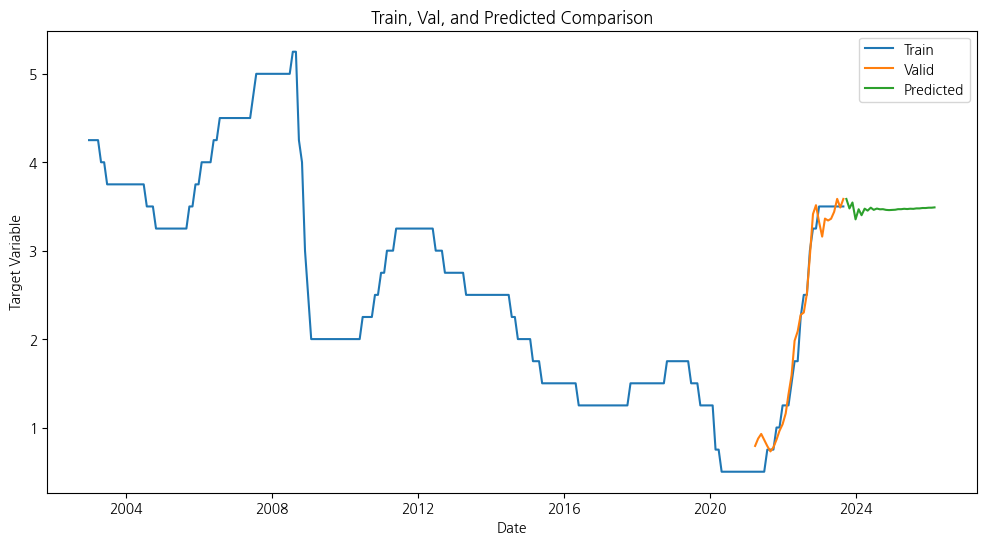

In [ ]:
# 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data['기준금리'], label='Train')
plt.plot(results_v30.index, results_v30['Val'], label='Valid')
plt.plot(results30.index, results30['Predicted'], label='Predicted')
plt.title('Train, Val, and Predicted Comparison')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

## 36개월

### 3-1) VECM 모델훈련

In [ ]:
# train 데이터로 모델 훈련
modelV = VECM(df_diff, k_ar_diff=2, coint_rank=21, deterministic='ci')
result = modelV.fit()

In [ ]:
# 미래의 독립변수 예측
future_steps = 36  # 예측할 미래의 기간 설정
future_forecast_diff = result.predict(steps=future_steps)
future_forecast_diff = future_forecast_diff[:, :-1]

In [ ]:
# 원래대로 역차분
# 현재 가지고 있는 데이터의 마지막 시점의 값을 사용
# df_notcat['기준금리'].iloc[-1]: 2023년 9월의 기준금리
future_forecast = future_forecast_diff.cumsum(axis=0) + np.array(imp.iloc[-1,:]).reshape(1,-1)

# 미래의 독립변수 예측값 출력
print("Future Forecast for Baseline Rate:")
print(future_forecast)

Future Forecast for Baseline Rate:
[[ 5.04358431e+00  4.51091463e+00  4.41187606e+00  1.00313957e+00
   9.06903658e-01  1.00482947e+00  1.01592572e+00  8.14782855e-01
   8.96575369e-01  1.00499643e+00  9.08897333e-01  4.50425347e-01
   7.30824236e-01  4.04420808e-02  8.00566789e-01  2.76647421e-01
   4.66297071e+00  9.84489903e-01]
 [ 5.15561871e+00  4.73399023e+00  4.61238243e+00  1.00428402e+00
   9.01896687e-01  1.00967147e+00  1.00397017e+00  8.13078560e-01
   8.97285648e-01  9.92023618e-01  8.59781503e-01  4.63679989e-01
   7.13221056e-01  4.18033563e-02  8.18535145e-01  3.80980815e-01
   4.85688409e+00  9.83773515e-01]
 [ 5.14743029e+00  4.77979332e+00  4.68440432e+00  1.00740865e+00
   8.94736167e-01  1.01345349e+00  1.01263864e+00  8.14570329e-01
   9.09653967e-01  1.00924330e+00  9.09241484e-01  4.65739487e-01
   7.06689105e-01  4.41589954e-02  8.31936913e-01  4.40565474e-01
   4.92435304e+00  9.83460097e-01]
 [ 5.05473244e+00  4.69713948e+00  4.65102020e+00  1.01097040e+00
  

### 3-2) 독립변수 생성

In [ ]:
idx = pd.date_range(start='2023-10-01', periods=future_steps, freq='MS')
future_df36 = pd.DataFrame(data=future_forecast, columns=imp.columns, index=idx)

In [ ]:
future_df36

,미국채_2,미국채_5,미국채_10,후행종합지수(2020=100),달러인덱스,선행종합지수(2020=100),식료품 및 에너지제외 지수,수입액(실질)(백만불),소매판매액지수(2020=100),농산물및석유류제외지수,소비재수입액(실질)(백만불),동행지수순환변동치,코스피(1980.1.4=100),수출입물가비율(2015=100),내수출하지수(2020=100),건설수주액(실질)(십억원),미국채_20,1인당 GDP(당해년 가격) (만원)
2023-10-01,5.043584,4.510915,4.411876,1.003140,0.906904,1.004829,1.015926,0.814783,0.896575,1.004996,0.908897,0.450425,0.730824,0.040442,0.800567,0.276647,4.662971,0.984490
2023-11-01,5.155619,4.733990,4.612382,1.004284,0.901897,1.009671,1.003970,0.813079,0.897286,0.992024,0.859782,0.463680,0.713221,0.041803,0.818535,0.380981,4.856884,0.983774
2023-12-01,5.147430,4.779793,4.684404,1.007409,0.894736,1.013453,1.012639,0.814570,0.909654,1.009243,0.909241,0.465739,0.706689,0.044159,0.831937,0.440565,4.924353,0.983460
2024-01-01,5.054732,4.697139,4.651020,1.010970,0.912157,1.017326,1.008953,0.826262,0.922013,1.001956,0.868210,0.500469,0.706951,0.040427,0.848610,0.491552,4.926137,1.006308
2024-02-01,5.131210,4.780452,4.733655,1.015625,0.929065,1.020893,1.008988,0.832955,0.924586,1.000980,0.898751,0.476316,0.711759,0.036172,0.840146,0.478164,5.004605,1.002871
2024-03-01,5.149210,4.782960,4.709681,1.019362,0.933244,1.025035,1.007728,0.835363,0.925886,0.999690,0.871369,0.486888,0.712730,0.034549,0.847702,0.439876,4.980541,1.013573
2024-04-01,5.183697,4.786049,4.709218,1.023760,0.927194,1.029002,1.010300,0.839525,0.925005,1.004724,0.890951,0.465350,0.717392,0.035469,0.838530,0.403999,4.978455,1.015614
2024-05-01,5.216138,4.810425,4.728708,1.027482,0.931860,1.033694,1.008095,0.841304,0.927909,1.000774,0.878963,0.475385,0.719942,0.033370,0.842315,0.406501,4.998015,1.023179
2024-06-01,5.291250,4.877446,4.778151,1.031400,0.934335,1.038771,1.008900,0.842356,0.930143,1.001609,0.888395,0.458940,0.724350,0.031891,0.840051,0.433516,5.033341,1.023624
2024-07-01,5.324352,4.906862,4.796966,1.034875,0.936216,1.043593,1.008043,0.843258,0.935584,1.000540,0.878828,0.467484,0.727149,0.029136,0.847924,0.447911,5.045182,1.028119


### 3-3) 데이터 LSTM으로 형태변환

In [ ]:
# X와 y로 분리
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset.iloc[i:(i + time_steps), :-1]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_steps, -1])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
train_time = -36
X_train, y_train = create_dataset(all_data.iloc[:train_time,:], time_steps)
X_val, y_val = create_dataset(all_data.iloc[train_time-1:,:], time_steps)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((212, 1, 18), (212,), (36, 1, 18), (36,))

### 3-4) LSTM모델 훈련

In [ ]:
# LSTM 모델 생성
modelL = Sequential()
modelL.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
modelL.add(Dropout(0.3))

modelL.add(Dense(16))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(8))
modelL.add(BatchNormalization())  # 추가: 배치 정규화
modelL.add(Dropout(0.3))

modelL.add(Dense(1))
modelL.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

### 씨드 고정해야함
modelL.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/300
14/14 - 4s - loss: 9.3406 - val_loss: 5.1626 - 4s/epoch - 296ms/step
Epoch 2/300
14/14 - 0s - loss: 8.9164 - val_loss: 4.8939 - 68ms/epoch - 5ms/step
Epoch 3/300
14/14 - 0s - loss: 8.3025 - val_loss: 4.7555 - 94ms/epoch - 7ms/step
Epoch 4/300
14/14 - 0s - loss: 7.7320 - val_loss: 4.5763 - 72ms/epoch - 5ms/step
Epoch 5/300
14/14 - 0s - loss: 7.4123 - val_loss: 4.3802 - 73ms/epoch - 5ms/step
Epoch 6/300
14/14 - 0s - loss: 6.9740 - val_loss: 4.1111 - 89ms/epoch - 6ms/step
Epoch 7/300
14/14 - 0s - loss: 6.5961 - val_loss: 3.9572 - 77ms/epoch - 6ms/step
Epoch 8/300
14/14 - 0s - loss: 6.5221 - val_loss: 3.9053 - 86ms/epoch - 6ms/step
Epoch 9/300
14/14 - 0s - loss: 6.2517 - val_loss: 3.7726 - 85ms/epoch - 6ms/step
Epoch 10/300
14/14 - 0s - loss: 6.1782 - val_loss: 3.6957 - 107ms/epoch - 8ms/step
Epoch 11/300
14/14 - 0s - loss: 6.2216 - val_loss: 3.6313 - 122ms/epoch - 9ms/step
Epoch 12/300
14/14 - 0s - loss: 5.9938 - val_loss: 3.5210 - 118ms/epoch - 8ms/step
Epoch 13/300
14/14 - 0

In [ ]:
val_pred = modelL.predict(X_val)

2/2 [==============================] - 1s 6ms/step


In [ ]:
future_date = future_steps
results_v36 = pd.DataFrame({'Val':val_pred.reshape(-1)}, index=all_data.index[-future_date:])
results_v36

,Val
날짜,
2020-10-01,0.304306
2020-11-01,0.345950
2020-12-01,0.328937
2021-01-01,0.343333
2021-02-01,0.315895
2021-03-01,0.361809
2021-04-01,0.397771
2021-05-01,0.422860
2021-06-01,0.465600


### 3-5) 기준금리 예측

In [ ]:
f_x_train, f_y_train = create_dataset(all_data, time_steps)
modelL.fit(f_x_train, f_y_train, epochs=500, batch_size=16, verbose=2, callbacks=[early_stopping])

Epoch 1/500


16/16 - 0s - loss: 1.3601 - 53ms/epoch - 3ms/step
Epoch 2/500


16/16 - 0s - loss: 1.4432 - 49ms/epoch - 3ms/step
Epoch 3/500


16/16 - 0s - loss: 1.3069 - 50ms/epoch - 3ms/step
Epoch 4/500


16/16 - 0s - loss: 1.6128 - 57ms/epoch - 4ms/step
Epoch 5/500


16/16 - 0s - loss: 1.2015 - 55ms/epoch - 3ms/step
Epoch 6/500


16/16 - 0s - loss: 1.0826 - 53ms/epoch - 3ms/step
Epoch 7/500


16/16 - 0s - loss: 1.1177 - 58ms/epoch - 4ms/step
Epoch 8/500


16/16 - 0s - loss: 0.9941 - 48ms/epoch - 3ms/step
Epoch 9/500


16/16 - 0s - loss: 1.1922 - 50ms/epoch - 3ms/step
Epoch 10/500


16/16 - 0s - loss: 1.1353 - 48ms/epoch - 3ms/step
Epoch 11/500


16/16 - 0s - loss: 1.2005 - 48ms/epoch - 3ms/step
Epoch 12/500


16/16 - 0s - loss: 1.0471 - 50ms/epoch - 3ms/step
Epoch 13/500


16/16 - 0s - loss: 1.1267 - 58ms/epoch - 4ms/step
Epoch 14/500


16/16 - 0s - loss: 0.9589 - 49ms/epoch - 3ms/step
Epoch 15/500


16/16 - 0s - loss: 0.9382 - 60ms/epoch - 4ms/step
Epoch 16/500


16/16 - 0s - loss: 0.9312 - 48ms/epoch - 3ms/step
Epoch 17/500


16/16 - 0s - loss: 0.9755 - 49ms/epoch - 3ms/step
Epoch 18/500


16/16 - 0s - loss: 1.1040 - 56ms/epoch - 4ms/step
Epoch 19/500


16/16 - 0s - loss: 0.9168 - 49ms/epoch - 3ms/step
Epoch 20/500


16/16 - 0s - loss: 1.0726 - 48ms/epoch - 3ms/step
Epoch 21/500


16/16 - 0s - loss: 0.9276 - 49ms/epoch - 3ms/step
Epoch 22/500


16/16 - 0s - loss: 0.9242 - 51ms/epoch - 3ms/step
Epoch 23/500


16/16 - 0s - loss: 0.8771 - 54ms/epoch - 3ms/step
Epoch 24/500


16/16 - 0s - loss: 0.9154 - 52ms/epoch - 3ms/step
Epoch 25/500


16/16 - 0s - loss: 0.9208 - 51ms/epoch - 3ms/step
Epoch 26/500


16/16 - 0s - loss: 0.9667 - 54ms/epoch - 3ms/step
Epoch 27/500


16/16 - 0s - loss: 0.7289 - 57ms/epoch - 4ms/step
Epoch 28/500


16/16 - 0s - loss: 0.8877 - 48ms/epoch - 3ms/step
Epoch 29/500


16/16 - 0s - loss: 0.8633 - 50ms/epoch - 3ms/step
Epoch 30/500


16/16 - 0s - loss: 0.8090 - 55ms/epoch - 3ms/step
Epoch 31/500


16/16 - 0s - loss: 0.8263 - 56ms/epoch - 3ms/step
Epoch 32/500


16/16 - 0s - loss: 0.7274 - 49ms/epoch - 3ms/step
Epoch 33/500


16/16 - 0s - loss: 0.8288 - 58ms/epoch - 4ms/step
Epoch 34/500


16/16 - 0s - loss: 0.8859 - 63ms/epoch - 4ms/step
Epoch 35/500


16/16 - 0s - loss: 0.8216 - 51ms/epoch - 3ms/step
Epoch 36/500


16/16 - 0s - loss: 0.9665 - 47ms/epoch - 3ms/step
Epoch 37/500


16/16 - 0s - loss: 0.9336 - 49ms/epoch - 3ms/step
Epoch 38/500


16/16 - 0s - loss: 0.9115 - 51ms/epoch - 3ms/step
Epoch 39/500


16/16 - 0s - loss: 0.8330 - 68ms/epoch - 4ms/step
Epoch 40/500


16/16 - 0s - loss: 0.7374 - 53ms/epoch - 3ms/step
Epoch 41/500


16/16 - 0s - loss: 0.8409 - 56ms/epoch - 4ms/step
Epoch 42/500


16/16 - 0s - loss: 0.8247 - 50ms/epoch - 3ms/step
Epoch 43/500


16/16 - 0s - loss: 0.8391 - 57ms/epoch - 4ms/step
Epoch 44/500


16/16 - 0s - loss: 0.8847 - 56ms/epoch - 4ms/step
Epoch 45/500


16/16 - 0s - loss: 0.8198 - 49ms/epoch - 3ms/step
Epoch 46/500


16/16 - 0s - loss: 0.7470 - 55ms/epoch - 3ms/step
Epoch 47/500


16/16 - 0s - loss: 0.8335 - 58ms/epoch - 4ms/step
Epoch 48/500


16/16 - 0s - loss: 0.7813 - 55ms/epoch - 3ms/step
Epoch 49/500


16/16 - 0s - loss: 0.8740 - 49ms/epoch - 3ms/step
Epoch 50/500


16/16 - 0s - loss: 0.6697 - 58ms/epoch - 4ms/step
Epoch 51/500


16/16 - 0s - loss: 0.6607 - 54ms/epoch - 3ms/step
Epoch 52/500


16/16 - 0s - loss: 0.6765 - 52ms/epoch - 3ms/step
Epoch 53/500


16/16 - 0s - loss: 0.7641 - 52ms/epoch - 3ms/step
Epoch 54/500


16/16 - 0s - loss: 0.8331 - 51ms/epoch - 3ms/step
Epoch 55/500


16/16 - 0s - loss: 0.6362 - 55ms/epoch - 3ms/step
Epoch 56/500


16/16 - 0s - loss: 0.7512 - 56ms/epoch - 4ms/step
Epoch 57/500


16/16 - 0s - loss: 0.7239 - 51ms/epoch - 3ms/step
Epoch 58/500


16/16 - 0s - loss: 0.7404 - 57ms/epoch - 4ms/step
Epoch 59/500


16/16 - 0s - loss: 0.6218 - 54ms/epoch - 3ms/step
Epoch 60/500


16/16 - 0s - loss: 0.7304 - 56ms/epoch - 3ms/step
Epoch 61/500


16/16 - 0s - loss: 0.6819 - 48ms/epoch - 3ms/step
Epoch 62/500


16/16 - 0s - loss: 0.6391 - 50ms/epoch - 3ms/step
Epoch 63/500


16/16 - 0s - loss: 0.5782 - 51ms/epoch - 3ms/step
Epoch 64/500


16/16 - 0s - loss: 0.7057 - 53ms/epoch - 3ms/step
Epoch 65/500


16/16 - 0s - loss: 0.6336 - 52ms/epoch - 3ms/step
Epoch 66/500


16/16 - 0s - loss: 0.8285 - 53ms/epoch - 3ms/step
Epoch 67/500


16/16 - 0s - loss: 0.8412 - 59ms/epoch - 4ms/step
Epoch 68/500


16/16 - 0s - loss: 0.6543 - 60ms/epoch - 4ms/step
Epoch 69/500


16/16 - 0s - loss: 0.5922 - 60ms/epoch - 4ms/step
Epoch 70/500


16/16 - 0s - loss: 0.9031 - 53ms/epoch - 3ms/step
Epoch 71/500


16/16 - 0s - loss: 0.6358 - 57ms/epoch - 4ms/step
Epoch 72/500


16/16 - 0s - loss: 0.6165 - 50ms/epoch - 3ms/step
Epoch 73/500


16/16 - 0s - loss: 0.5942 - 51ms/epoch - 3ms/step
Epoch 74/500


16/16 - 0s - loss: 0.6187 - 57ms/epoch - 4ms/step
Epoch 75/500


16/16 - 0s - loss: 0.6568 - 52ms/epoch - 3ms/step
Epoch 76/500


16/16 - 0s - loss: 0.7100 - 52ms/epoch - 3ms/step
Epoch 77/500


16/16 - 0s - loss: 0.6391 - 54ms/epoch - 3ms/step
Epoch 78/500


16/16 - 0s - loss: 0.6054 - 54ms/epoch - 3ms/step
Epoch 79/500


16/16 - 0s - loss: 0.5779 - 52ms/epoch - 3ms/step
Epoch 80/500


16/16 - 0s - loss: 0.6382 - 51ms/epoch - 3ms/step
Epoch 81/500


16/16 - 0s - loss: 0.6352 - 50ms/epoch - 3ms/step
Epoch 82/500


16/16 - 0s - loss: 0.5967 - 49ms/epoch - 3ms/step
Epoch 83/500


16/16 - 0s - loss: 0.7073 - 62ms/epoch - 4ms/step
Epoch 84/500


16/16 - 0s - loss: 0.6848 - 52ms/epoch - 3ms/step
Epoch 85/500


16/16 - 0s - loss: 0.6460 - 59ms/epoch - 4ms/step
Epoch 86/500


16/16 - 0s - loss: 0.6071 - 54ms/epoch - 3ms/step
Epoch 87/500


16/16 - 0s - loss: 0.6367 - 50ms/epoch - 3ms/step
Epoch 88/500


16/16 - 0s - loss: 0.4948 - 54ms/epoch - 3ms/step
Epoch 89/500


16/16 - 0s - loss: 0.5044 - 51ms/epoch - 3ms/step
Epoch 90/500


16/16 - 0s - loss: 0.5891 - 54ms/epoch - 3ms/step
Epoch 91/500


16/16 - 0s - loss: 0.6996 - 51ms/epoch - 3ms/step
Epoch 92/500


16/16 - 0s - loss: 0.6304 - 52ms/epoch - 3ms/step
Epoch 93/500


16/16 - 0s - loss: 0.5950 - 51ms/epoch - 3ms/step
Epoch 94/500


16/16 - 0s - loss: 0.6988 - 54ms/epoch - 3ms/step
Epoch 95/500


16/16 - 0s - loss: 0.5930 - 53ms/epoch - 3ms/step
Epoch 96/500


16/16 - 0s - loss: 0.4960 - 53ms/epoch - 3ms/step
Epoch 97/500


16/16 - 0s - loss: 0.6068 - 54ms/epoch - 3ms/step
Epoch 98/500


16/16 - 0s - loss: 0.5758 - 51ms/epoch - 3ms/step
Epoch 99/500


16/16 - 0s - loss: 0.6276 - 50ms/epoch - 3ms/step
Epoch 100/500


16/16 - 0s - loss: 0.5828 - 58ms/epoch - 4ms/step
Epoch 101/500


16/16 - 0s - loss: 0.5612 - 52ms/epoch - 3ms/step
Epoch 102/500


16/16 - 0s - loss: 0.5838 - 58ms/epoch - 4ms/step
Epoch 103/500


16/16 - 0s - loss: 0.5732 - 65ms/epoch - 4ms/step
Epoch 104/500


16/16 - 0s - loss: 0.6718 - 49ms/epoch - 3ms/step
Epoch 105/500


16/16 - 0s - loss: 0.6175 - 51ms/epoch - 3ms/step
Epoch 106/500


16/16 - 0s - loss: 0.5219 - 56ms/epoch - 4ms/step
Epoch 107/500


16/16 - 0s - loss: 0.6432 - 50ms/epoch - 3ms/step
Epoch 108/500


16/16 - 0s - loss: 0.5688 - 54ms/epoch - 3ms/step
Epoch 109/500


16/16 - 0s - loss: 0.5397 - 53ms/epoch - 3ms/step
Epoch 110/500


16/16 - 0s - loss: 0.5957 - 53ms/epoch - 3ms/step
Epoch 111/500


16/16 - 0s - loss: 0.5172 - 59ms/epoch - 4ms/step
Epoch 112/500


16/16 - 0s - loss: 0.5438 - 53ms/epoch - 3ms/step
Epoch 113/500


16/16 - 0s - loss: 0.5428 - 53ms/epoch - 3ms/step
Epoch 114/500


16/16 - 0s - loss: 0.5149 - 52ms/epoch - 3ms/step
Epoch 115/500


16/16 - 0s - loss: 0.4856 - 69ms/epoch - 4ms/step
Epoch 116/500


16/16 - 0s - loss: 0.5737 - 77ms/epoch - 5ms/step
Epoch 117/500


16/16 - 0s - loss: 0.6321 - 72ms/epoch - 4ms/step
Epoch 118/500


16/16 - 0s - loss: 0.4987 - 77ms/epoch - 5ms/step
Epoch 119/500


16/16 - 0s - loss: 0.6920 - 84ms/epoch - 5ms/step
Epoch 120/500


16/16 - 0s - loss: 0.5058 - 71ms/epoch - 4ms/step
Epoch 121/500


16/16 - 0s - loss: 0.6482 - 69ms/epoch - 4ms/step
Epoch 122/500


16/16 - 0s - loss: 0.5327 - 70ms/epoch - 4ms/step
Epoch 123/500


16/16 - 0s - loss: 0.4632 - 73ms/epoch - 5ms/step
Epoch 124/500


16/16 - 0s - loss: 0.5748 - 73ms/epoch - 5ms/step
Epoch 125/500


16/16 - 0s - loss: 0.5335 - 71ms/epoch - 4ms/step
Epoch 126/500


16/16 - 0s - loss: 0.5425 - 71ms/epoch - 4ms/step
Epoch 127/500


16/16 - 0s - loss: 0.6115 - 67ms/epoch - 4ms/step
Epoch 128/500


16/16 - 0s - loss: 0.5662 - 67ms/epoch - 4ms/step
Epoch 129/500


16/16 - 0s - loss: 0.4511 - 69ms/epoch - 4ms/step
Epoch 130/500


16/16 - 0s - loss: 0.4467 - 69ms/epoch - 4ms/step
Epoch 131/500


16/16 - 0s - loss: 0.4774 - 68ms/epoch - 4ms/step
Epoch 132/500


16/16 - 0s - loss: 0.5256 - 70ms/epoch - 4ms/step
Epoch 133/500


16/16 - 0s - loss: 0.5212 - 88ms/epoch - 6ms/step
Epoch 134/500


16/16 - 0s - loss: 0.5653 - 80ms/epoch - 5ms/step
Epoch 135/500


16/16 - 0s - loss: 0.4704 - 69ms/epoch - 4ms/step
Epoch 136/500


16/16 - 0s - loss: 0.4633 - 69ms/epoch - 4ms/step
Epoch 137/500


16/16 - 0s - loss: 0.5150 - 68ms/epoch - 4ms/step
Epoch 138/500


16/16 - 0s - loss: 0.6004 - 71ms/epoch - 4ms/step
Epoch 139/500


16/16 - 0s - loss: 0.5583 - 70ms/epoch - 4ms/step
Epoch 140/500


16/16 - 0s - loss: 0.4769 - 69ms/epoch - 4ms/step
Epoch 141/500


16/16 - 0s - loss: 0.5645 - 67ms/epoch - 4ms/step
Epoch 142/500


16/16 - 0s - loss: 0.4821 - 68ms/epoch - 4ms/step
Epoch 143/500


16/16 - 0s - loss: 0.5850 - 69ms/epoch - 4ms/step
Epoch 144/500


16/16 - 0s - loss: 0.4453 - 64ms/epoch - 4ms/step
Epoch 145/500


16/16 - 0s - loss: 0.4891 - 66ms/epoch - 4ms/step
Epoch 146/500


16/16 - 0s - loss: 0.5300 - 66ms/epoch - 4ms/step
Epoch 147/500


16/16 - 0s - loss: 0.6278 - 74ms/epoch - 5ms/step
Epoch 148/500


16/16 - 0s - loss: 0.4659 - 70ms/epoch - 4ms/step
Epoch 149/500


16/16 - 0s - loss: 0.6176 - 79ms/epoch - 5ms/step
Epoch 150/500


16/16 - 0s - loss: 0.6254 - 81ms/epoch - 5ms/step
Epoch 151/500


16/16 - 0s - loss: 0.5102 - 77ms/epoch - 5ms/step
Epoch 152/500


16/16 - 0s - loss: 0.5009 - 77ms/epoch - 5ms/step
Epoch 153/500


16/16 - 0s - loss: 0.4836 - 83ms/epoch - 5ms/step
Epoch 154/500


16/16 - 0s - loss: 0.5612 - 75ms/epoch - 5ms/step
Epoch 155/500


16/16 - 0s - loss: 0.4363 - 75ms/epoch - 5ms/step
Epoch 156/500


16/16 - 0s - loss: 0.4817 - 77ms/epoch - 5ms/step
Epoch 157/500


16/16 - 0s - loss: 0.6157 - 72ms/epoch - 4ms/step
Epoch 158/500


16/16 - 0s - loss: 0.5002 - 76ms/epoch - 5ms/step
Epoch 159/500


16/16 - 0s - loss: 0.5876 - 81ms/epoch - 5ms/step
Epoch 160/500


16/16 - 0s - loss: 0.5426 - 72ms/epoch - 5ms/step
Epoch 161/500


16/16 - 0s - loss: 0.4611 - 78ms/epoch - 5ms/step
Epoch 162/500


16/16 - 0s - loss: 0.4328 - 65ms/epoch - 4ms/step
Epoch 163/500


16/16 - 0s - loss: 0.5311 - 77ms/epoch - 5ms/step
Epoch 164/500


16/16 - 0s - loss: 0.5904 - 70ms/epoch - 4ms/step
Epoch 165/500


16/16 - 0s - loss: 0.5414 - 68ms/epoch - 4ms/step
Epoch 166/500


16/16 - 0s - loss: 0.4692 - 69ms/epoch - 4ms/step
Epoch 167/500


16/16 - 0s - loss: 0.5192 - 73ms/epoch - 5ms/step
Epoch 168/500


16/16 - 0s - loss: 0.4880 - 78ms/epoch - 5ms/step
Epoch 169/500


16/16 - 0s - loss: 0.5115 - 73ms/epoch - 5ms/step
Epoch 170/500


16/16 - 0s - loss: 0.5832 - 70ms/epoch - 4ms/step
Epoch 171/500


16/16 - 0s - loss: 0.5097 - 69ms/epoch - 4ms/step
Epoch 172/500


16/16 - 0s - loss: 0.5205 - 69ms/epoch - 4ms/step
Epoch 173/500


16/16 - 0s - loss: 0.4568 - 77ms/epoch - 5ms/step
Epoch 174/500


16/16 - 0s - loss: 0.4745 - 70ms/epoch - 4ms/step
Epoch 175/500


16/16 - 0s - loss: 0.4743 - 78ms/epoch - 5ms/step
Epoch 176/500


16/16 - 0s - loss: 0.4688 - 69ms/epoch - 4ms/step
Epoch 177/500


16/16 - 0s - loss: 0.4382 - 72ms/epoch - 4ms/step
Epoch 178/500


16/16 - 0s - loss: 0.4453 - 83ms/epoch - 5ms/step
Epoch 179/500


16/16 - 0s - loss: 0.6172 - 70ms/epoch - 4ms/step
Epoch 180/500


16/16 - 0s - loss: 0.5285 - 66ms/epoch - 4ms/step
Epoch 181/500


16/16 - 0s - loss: 0.5236 - 66ms/epoch - 4ms/step
Epoch 182/500


16/16 - 0s - loss: 0.4066 - 69ms/epoch - 4ms/step
Epoch 183/500


16/16 - 0s - loss: 0.4005 - 67ms/epoch - 4ms/step
Epoch 184/500


16/16 - 0s - loss: 0.5306 - 66ms/epoch - 4ms/step
Epoch 185/500


16/16 - 0s - loss: 0.5635 - 65ms/epoch - 4ms/step
Epoch 186/500


16/16 - 0s - loss: 0.5714 - 67ms/epoch - 4ms/step
Epoch 187/500


16/16 - 0s - loss: 0.4364 - 78ms/epoch - 5ms/step
Epoch 188/500


16/16 - 0s - loss: 0.5412 - 79ms/epoch - 5ms/step
Epoch 189/500


16/16 - 0s - loss: 0.5098 - 68ms/epoch - 4ms/step
Epoch 190/500


16/16 - 0s - loss: 0.5410 - 67ms/epoch - 4ms/step
Epoch 191/500


16/16 - 0s - loss: 0.4977 - 74ms/epoch - 5ms/step
Epoch 192/500


16/16 - 0s - loss: 0.4172 - 70ms/epoch - 4ms/step
Epoch 193/500


16/16 - 0s - loss: 0.4605 - 79ms/epoch - 5ms/step
Epoch 194/500


16/16 - 0s - loss: 0.5323 - 71ms/epoch - 4ms/step
Epoch 195/500


16/16 - 0s - loss: 0.4912 - 73ms/epoch - 5ms/step
Epoch 196/500


16/16 - 0s - loss: 0.4365 - 79ms/epoch - 5ms/step
Epoch 197/500


16/16 - 0s - loss: 0.4160 - 76ms/epoch - 5ms/step
Epoch 198/500


16/16 - 0s - loss: 0.4950 - 72ms/epoch - 4ms/step
Epoch 199/500


16/16 - 0s - loss: 0.3871 - 68ms/epoch - 4ms/step
Epoch 200/500


16/16 - 0s - loss: 0.5245 - 72ms/epoch - 4ms/step
Epoch 201/500


16/16 - 0s - loss: 0.4590 - 69ms/epoch - 4ms/step
Epoch 202/500


16/16 - 0s - loss: 0.4484 - 69ms/epoch - 4ms/step
Epoch 203/500


16/16 - 0s - loss: 0.4536 - 75ms/epoch - 5ms/step
Epoch 204/500


16/16 - 0s - loss: 0.4022 - 72ms/epoch - 5ms/step
Epoch 205/500


16/16 - 0s - loss: 0.4760 - 68ms/epoch - 4ms/step
Epoch 206/500


16/16 - 0s - loss: 0.4574 - 72ms/epoch - 4ms/step
Epoch 207/500


16/16 - 0s - loss: 0.4276 - 68ms/epoch - 4ms/step
Epoch 208/500


16/16 - 0s - loss: 0.4202 - 66ms/epoch - 4ms/step
Epoch 209/500


16/16 - 0s - loss: 0.5289 - 65ms/epoch - 4ms/step
Epoch 210/500


16/16 - 0s - loss: 0.4320 - 66ms/epoch - 4ms/step
Epoch 211/500


16/16 - 0s - loss: 0.3897 - 65ms/epoch - 4ms/step
Epoch 212/500


16/16 - 0s - loss: 0.3973 - 66ms/epoch - 4ms/step
Epoch 213/500


16/16 - 0s - loss: 0.4092 - 70ms/epoch - 4ms/step
Epoch 214/500


16/16 - 0s - loss: 0.4827 - 67ms/epoch - 4ms/step
Epoch 215/500


16/16 - 0s - loss: 0.4409 - 72ms/epoch - 4ms/step
Epoch 216/500


16/16 - 0s - loss: 0.4449 - 71ms/epoch - 4ms/step
Epoch 217/500


16/16 - 0s - loss: 0.4995 - 74ms/epoch - 5ms/step
Epoch 218/500


16/16 - 0s - loss: 0.5635 - 71ms/epoch - 4ms/step
Epoch 219/500


16/16 - 0s - loss: 0.4127 - 78ms/epoch - 5ms/step
Epoch 220/500


16/16 - 0s - loss: 0.5818 - 87ms/epoch - 5ms/step
Epoch 221/500


16/16 - 0s - loss: 0.4353 - 75ms/epoch - 5ms/step
Epoch 222/500


16/16 - 0s - loss: 0.3536 - 74ms/epoch - 5ms/step
Epoch 223/500


16/16 - 0s - loss: 0.4504 - 69ms/epoch - 4ms/step
Epoch 224/500


16/16 - 0s - loss: 0.4434 - 74ms/epoch - 5ms/step
Epoch 225/500


16/16 - 0s - loss: 0.5268 - 67ms/epoch - 4ms/step
Epoch 226/500


16/16 - 0s - loss: 0.4212 - 72ms/epoch - 5ms/step
Epoch 227/500


16/16 - 0s - loss: 0.4479 - 69ms/epoch - 4ms/step
Epoch 228/500


16/16 - 0s - loss: 0.4305 - 81ms/epoch - 5ms/step
Epoch 229/500


16/16 - 0s - loss: 0.5247 - 71ms/epoch - 4ms/step
Epoch 230/500


16/16 - 0s - loss: 0.4610 - 74ms/epoch - 5ms/step
Epoch 231/500


16/16 - 0s - loss: 0.4310 - 75ms/epoch - 5ms/step
Epoch 232/500


16/16 - 0s - loss: 0.4178 - 66ms/epoch - 4ms/step
Epoch 233/500


16/16 - 0s - loss: 0.4199 - 72ms/epoch - 4ms/step
Epoch 234/500


16/16 - 0s - loss: 0.4655 - 63ms/epoch - 4ms/step
Epoch 235/500


16/16 - 0s - loss: 0.4512 - 52ms/epoch - 3ms/step
Epoch 236/500


16/16 - 0s - loss: 0.4494 - 59ms/epoch - 4ms/step
Epoch 237/500


16/16 - 0s - loss: 0.4528 - 49ms/epoch - 3ms/step
Epoch 238/500


16/16 - 0s - loss: 0.4711 - 54ms/epoch - 3ms/step
Epoch 239/500


16/16 - 0s - loss: 0.3985 - 51ms/epoch - 3ms/step
Epoch 240/500


16/16 - 0s - loss: 0.4232 - 59ms/epoch - 4ms/step
Epoch 241/500


16/16 - 0s - loss: 0.4815 - 53ms/epoch - 3ms/step
Epoch 242/500


16/16 - 0s - loss: 0.4253 - 55ms/epoch - 3ms/step
Epoch 243/500


16/16 - 0s - loss: 0.3803 - 55ms/epoch - 3ms/step
Epoch 244/500


16/16 - 0s - loss: 0.4410 - 56ms/epoch - 4ms/step
Epoch 245/500


16/16 - 0s - loss: 0.4065 - 53ms/epoch - 3ms/step
Epoch 246/500


16/16 - 0s - loss: 0.4013 - 49ms/epoch - 3ms/step
Epoch 247/500


16/16 - 0s - loss: 0.4260 - 54ms/epoch - 3ms/step
Epoch 248/500


16/16 - 0s - loss: 0.4623 - 70ms/epoch - 4ms/step
Epoch 249/500


16/16 - 0s - loss: 0.4363 - 61ms/epoch - 4ms/step
Epoch 250/500


16/16 - 0s - loss: 0.4304 - 61ms/epoch - 4ms/step
Epoch 251/500


16/16 - 0s - loss: 0.4240 - 58ms/epoch - 4ms/step
Epoch 252/500


16/16 - 0s - loss: 0.4237 - 60ms/epoch - 4ms/step
Epoch 253/500


16/16 - 0s - loss: 0.4527 - 55ms/epoch - 3ms/step
Epoch 254/500


16/16 - 0s - loss: 0.4599 - 53ms/epoch - 3ms/step
Epoch 255/500


16/16 - 0s - loss: 0.3816 - 62ms/epoch - 4ms/step
Epoch 256/500


16/16 - 0s - loss: 0.4232 - 51ms/epoch - 3ms/step
Epoch 257/500


16/16 - 0s - loss: 0.4419 - 56ms/epoch - 4ms/step
Epoch 258/500


16/16 - 0s - loss: 0.4413 - 59ms/epoch - 4ms/step
Epoch 259/500


16/16 - 0s - loss: 0.4620 - 61ms/epoch - 4ms/step
Epoch 260/500


16/16 - 0s - loss: 0.4546 - 63ms/epoch - 4ms/step
Epoch 261/500


16/16 - 0s - loss: 0.4284 - 55ms/epoch - 3ms/step
Epoch 262/500


16/16 - 0s - loss: 0.3662 - 56ms/epoch - 3ms/step
Epoch 263/500


16/16 - 0s - loss: 0.3585 - 54ms/epoch - 3ms/step
Epoch 264/500


16/16 - 0s - loss: 0.4187 - 63ms/epoch - 4ms/step
Epoch 265/500


16/16 - 0s - loss: 0.4123 - 54ms/epoch - 3ms/step
Epoch 266/500


16/16 - 0s - loss: 0.4570 - 57ms/epoch - 4ms/step
Epoch 267/500


16/16 - 0s - loss: 0.4265 - 57ms/epoch - 4ms/step
Epoch 268/500


16/16 - 0s - loss: 0.3272 - 59ms/epoch - 4ms/step
Epoch 269/500


16/16 - 0s - loss: 0.3945 - 60ms/epoch - 4ms/step
Epoch 270/500


16/16 - 0s - loss: 0.3989 - 46ms/epoch - 3ms/step
Epoch 271/500


16/16 - 0s - loss: 0.4247 - 58ms/epoch - 4ms/step
Epoch 272/500


16/16 - 0s - loss: 0.4468 - 59ms/epoch - 4ms/step
Epoch 273/500


16/16 - 0s - loss: 0.3619 - 51ms/epoch - 3ms/step
Epoch 274/500


16/16 - 0s - loss: 0.4407 - 49ms/epoch - 3ms/step
Epoch 275/500


16/16 - 0s - loss: 0.3743 - 59ms/epoch - 4ms/step
Epoch 276/500


16/16 - 0s - loss: 0.4609 - 55ms/epoch - 3ms/step
Epoch 277/500


16/16 - 0s - loss: 0.3988 - 59ms/epoch - 4ms/step
Epoch 278/500


16/16 - 0s - loss: 0.4638 - 56ms/epoch - 3ms/step
Epoch 279/500


16/16 - 0s - loss: 0.4341 - 61ms/epoch - 4ms/step
Epoch 280/500


16/16 - 0s - loss: 0.3860 - 57ms/epoch - 4ms/step
Epoch 281/500


16/16 - 0s - loss: 0.5064 - 71ms/epoch - 4ms/step
Epoch 282/500


16/16 - 0s - loss: 0.3885 - 52ms/epoch - 3ms/step
Epoch 283/500


16/16 - 0s - loss: 0.4231 - 58ms/epoch - 4ms/step
Epoch 284/500


16/16 - 0s - loss: 0.4396 - 58ms/epoch - 4ms/step
Epoch 285/500


16/16 - 0s - loss: 0.3186 - 56ms/epoch - 4ms/step
Epoch 286/500


16/16 - 0s - loss: 0.4499 - 56ms/epoch - 4ms/step
Epoch 287/500


16/16 - 0s - loss: 0.4459 - 53ms/epoch - 3ms/step
Epoch 288/500


16/16 - 0s - loss: 0.3411 - 53ms/epoch - 3ms/step
Epoch 289/500


16/16 - 0s - loss: 0.3920 - 57ms/epoch - 4ms/step
Epoch 290/500


16/16 - 0s - loss: 0.3653 - 59ms/epoch - 4ms/step
Epoch 291/500


16/16 - 0s - loss: 0.4443 - 59ms/epoch - 4ms/step
Epoch 292/500


16/16 - 0s - loss: 0.3737 - 60ms/epoch - 4ms/step
Epoch 293/500


16/16 - 0s - loss: 0.3689 - 62ms/epoch - 4ms/step
Epoch 294/500


16/16 - 0s - loss: 0.4236 - 58ms/epoch - 4ms/step
Epoch 295/500


16/16 - 0s - loss: 0.3335 - 59ms/epoch - 4ms/step
Epoch 296/500


16/16 - 0s - loss: 0.4087 - 54ms/epoch - 3ms/step
Epoch 297/500


16/16 - 0s - loss: 0.5005 - 66ms/epoch - 4ms/step
Epoch 298/500


16/16 - 0s - loss: 0.4015 - 54ms/epoch - 3ms/step
Epoch 299/500


16/16 - 0s - loss: 0.3940 - 56ms/epoch - 4ms/step
Epoch 300/500


16/16 - 0s - loss: 0.3772 - 56ms/epoch - 3ms/step
Epoch 301/500


16/16 - 0s - loss: 0.4142 - 56ms/epoch - 3ms/step
Epoch 302/500


16/16 - 0s - loss: 0.4926 - 56ms/epoch - 3ms/step
Epoch 303/500


16/16 - 0s - loss: 0.3707 - 55ms/epoch - 3ms/step
Epoch 304/500


16/16 - 0s - loss: 0.4125 - 57ms/epoch - 4ms/step
Epoch 305/500


16/16 - 0s - loss: 0.4081 - 56ms/epoch - 3ms/step
Epoch 306/500


16/16 - 0s - loss: 0.4526 - 57ms/epoch - 4ms/step
Epoch 307/500


16/16 - 0s - loss: 0.3758 - 59ms/epoch - 4ms/step
Epoch 308/500


16/16 - 0s - loss: 0.4296 - 57ms/epoch - 4ms/step
Epoch 309/500


16/16 - 0s - loss: 0.3262 - 56ms/epoch - 4ms/step
Epoch 310/500


16/16 - 0s - loss: 0.3709 - 52ms/epoch - 3ms/step
Epoch 311/500


16/16 - 0s - loss: 0.3539 - 56ms/epoch - 3ms/step
Epoch 312/500


16/16 - 0s - loss: 0.3979 - 62ms/epoch - 4ms/step
Epoch 313/500


16/16 - 0s - loss: 0.4094 - 55ms/epoch - 3ms/step
Epoch 314/500


16/16 - 0s - loss: 0.3741 - 75ms/epoch - 5ms/step
Epoch 315/500


16/16 - 0s - loss: 0.3906 - 55ms/epoch - 3ms/step
Epoch 316/500


16/16 - 0s - loss: 0.3087 - 57ms/epoch - 4ms/step
Epoch 317/500


16/16 - 0s - loss: 0.4202 - 60ms/epoch - 4ms/step
Epoch 318/500


16/16 - 0s - loss: 0.4599 - 62ms/epoch - 4ms/step
Epoch 319/500


16/16 - 0s - loss: 0.3538 - 58ms/epoch - 4ms/step
Epoch 320/500


16/16 - 0s - loss: 0.4078 - 58ms/epoch - 4ms/step
Epoch 321/500


16/16 - 0s - loss: 0.3574 - 55ms/epoch - 3ms/step
Epoch 322/500


16/16 - 0s - loss: 0.3922 - 63ms/epoch - 4ms/step
Epoch 323/500


16/16 - 0s - loss: 0.4333 - 60ms/epoch - 4ms/step
Epoch 324/500


16/16 - 0s - loss: 0.4385 - 57ms/epoch - 4ms/step
Epoch 325/500


16/16 - 0s - loss: 0.4500 - 60ms/epoch - 4ms/step
Epoch 326/500


16/16 - 0s - loss: 0.4460 - 57ms/epoch - 4ms/step
Epoch 327/500


16/16 - 0s - loss: 0.3233 - 53ms/epoch - 3ms/step
Epoch 328/500


16/16 - 0s - loss: 0.3470 - 56ms/epoch - 3ms/step
Epoch 329/500


16/16 - 0s - loss: 0.3744 - 56ms/epoch - 4ms/step
Epoch 330/500


16/16 - 0s - loss: 0.3298 - 69ms/epoch - 4ms/step
Epoch 331/500


16/16 - 0s - loss: 0.3253 - 57ms/epoch - 4ms/step
Epoch 332/500


16/16 - 0s - loss: 0.3511 - 54ms/epoch - 3ms/step
Epoch 333/500


16/16 - 0s - loss: 0.3685 - 54ms/epoch - 3ms/step
Epoch 334/500


16/16 - 0s - loss: 0.3238 - 51ms/epoch - 3ms/step
Epoch 335/500


16/16 - 0s - loss: 0.4725 - 56ms/epoch - 3ms/step
Epoch 336/500


16/16 - 0s - loss: 0.4419 - 56ms/epoch - 3ms/step
Epoch 337/500


16/16 - 0s - loss: 0.3102 - 64ms/epoch - 4ms/step
Epoch 338/500


16/16 - 0s - loss: 0.3919 - 56ms/epoch - 3ms/step
Epoch 339/500


16/16 - 0s - loss: 0.3281 - 61ms/epoch - 4ms/step
Epoch 340/500


16/16 - 0s - loss: 0.4706 - 57ms/epoch - 4ms/step
Epoch 341/500


16/16 - 0s - loss: 0.3511 - 62ms/epoch - 4ms/step
Epoch 342/500


16/16 - 0s - loss: 0.3638 - 53ms/epoch - 3ms/step
Epoch 343/500


16/16 - 0s - loss: 0.4175 - 58ms/epoch - 4ms/step
Epoch 344/500


16/16 - 0s - loss: 0.3640 - 60ms/epoch - 4ms/step
Epoch 345/500


16/16 - 0s - loss: 0.3462 - 57ms/epoch - 4ms/step
Epoch 346/500


16/16 - 0s - loss: 0.4439 - 66ms/epoch - 4ms/step
Epoch 347/500


16/16 - 0s - loss: 0.4399 - 60ms/epoch - 4ms/step
Epoch 348/500


16/16 - 0s - loss: 0.3756 - 58ms/epoch - 4ms/step
Epoch 349/500


16/16 - 0s - loss: 0.4487 - 59ms/epoch - 4ms/step
Epoch 350/500


16/16 - 0s - loss: 0.4055 - 56ms/epoch - 4ms/step
Epoch 351/500


16/16 - 0s - loss: 0.4613 - 55ms/epoch - 3ms/step
Epoch 352/500


16/16 - 0s - loss: 0.3544 - 62ms/epoch - 4ms/step
Epoch 353/500


16/16 - 0s - loss: 0.3061 - 60ms/epoch - 4ms/step
Epoch 354/500


16/16 - 0s - loss: 0.3877 - 56ms/epoch - 4ms/step
Epoch 355/500


16/16 - 0s - loss: 0.4009 - 65ms/epoch - 4ms/step
Epoch 356/500


16/16 - 0s - loss: 0.4774 - 61ms/epoch - 4ms/step
Epoch 357/500


16/16 - 0s - loss: 0.3983 - 63ms/epoch - 4ms/step
Epoch 358/500


16/16 - 0s - loss: 0.3826 - 55ms/epoch - 3ms/step
Epoch 359/500


16/16 - 0s - loss: 0.4148 - 57ms/epoch - 4ms/step
Epoch 360/500


16/16 - 0s - loss: 0.3292 - 59ms/epoch - 4ms/step
Epoch 361/500


16/16 - 0s - loss: 0.4270 - 55ms/epoch - 3ms/step
Epoch 362/500


16/16 - 0s - loss: 0.3254 - 61ms/epoch - 4ms/step
Epoch 363/500


16/16 - 0s - loss: 0.4110 - 60ms/epoch - 4ms/step
Epoch 364/500


16/16 - 0s - loss: 0.4144 - 63ms/epoch - 4ms/step
Epoch 365/500


16/16 - 0s - loss: 0.5022 - 59ms/epoch - 4ms/step
Epoch 366/500


16/16 - 0s - loss: 0.3339 - 57ms/epoch - 4ms/step
Epoch 367/500


16/16 - 0s - loss: 0.3422 - 57ms/epoch - 4ms/step
Epoch 368/500


16/16 - 0s - loss: 0.4148 - 68ms/epoch - 4ms/step
Epoch 369/500


16/16 - 0s - loss: 0.4548 - 56ms/epoch - 4ms/step
Epoch 370/500


16/16 - 0s - loss: 0.3621 - 63ms/epoch - 4ms/step
Epoch 371/500


16/16 - 0s - loss: 0.3239 - 59ms/epoch - 4ms/step
Epoch 372/500


16/16 - 0s - loss: 0.3560 - 58ms/epoch - 4ms/step
Epoch 373/500


16/16 - 0s - loss: 0.3281 - 56ms/epoch - 3ms/step
Epoch 374/500


16/16 - 0s - loss: 0.3888 - 59ms/epoch - 4ms/step
Epoch 375/500


16/16 - 0s - loss: 0.3991 - 61ms/epoch - 4ms/step
Epoch 376/500


16/16 - 0s - loss: 0.3653 - 59ms/epoch - 4ms/step
Epoch 377/500


16/16 - 0s - loss: 0.3108 - 61ms/epoch - 4ms/step
Epoch 378/500


16/16 - 0s - loss: 0.3183 - 74ms/epoch - 5ms/step
Epoch 379/500


16/16 - 0s - loss: 0.3298 - 59ms/epoch - 4ms/step
Epoch 380/500


16/16 - 0s - loss: 0.4576 - 56ms/epoch - 4ms/step
Epoch 381/500


16/16 - 0s - loss: 0.4088 - 66ms/epoch - 4ms/step
Epoch 382/500


16/16 - 0s - loss: 0.3911 - 61ms/epoch - 4ms/step
Epoch 383/500


16/16 - 0s - loss: 0.3339 - 61ms/epoch - 4ms/step
Epoch 384/500


16/16 - 0s - loss: 0.3689 - 60ms/epoch - 4ms/step
Epoch 385/500


16/16 - 0s - loss: 0.3273 - 62ms/epoch - 4ms/step
Epoch 386/500


16/16 - 0s - loss: 0.4086 - 58ms/epoch - 4ms/step
Epoch 387/500


16/16 - 0s - loss: 0.2919 - 61ms/epoch - 4ms/step
Epoch 388/500


16/16 - 0s - loss: 0.4008 - 60ms/epoch - 4ms/step
Epoch 389/500


16/16 - 0s - loss: 0.3171 - 60ms/epoch - 4ms/step
Epoch 390/500


16/16 - 0s - loss: 0.3609 - 59ms/epoch - 4ms/step
Epoch 391/500


16/16 - 0s - loss: 0.3771 - 56ms/epoch - 3ms/step
Epoch 392/500


16/16 - 0s - loss: 0.3484 - 64ms/epoch - 4ms/step
Epoch 393/500


16/16 - 0s - loss: 0.3577 - 74ms/epoch - 5ms/step
Epoch 394/500


16/16 - 0s - loss: 0.4184 - 75ms/epoch - 5ms/step
Epoch 395/500


16/16 - 0s - loss: 0.3524 - 74ms/epoch - 5ms/step
Epoch 396/500


16/16 - 0s - loss: 0.3704 - 78ms/epoch - 5ms/step
Epoch 397/500


16/16 - 0s - loss: 0.4073 - 84ms/epoch - 5ms/step
Epoch 398/500


16/16 - 0s - loss: 0.3743 - 79ms/epoch - 5ms/step
Epoch 399/500


16/16 - 0s - loss: 0.3944 - 82ms/epoch - 5ms/step
Epoch 400/500


16/16 - 0s - loss: 0.4684 - 95ms/epoch - 6ms/step
Epoch 401/500


16/16 - 0s - loss: 0.3225 - 68ms/epoch - 4ms/step
Epoch 402/500


16/16 - 0s - loss: 0.3046 - 76ms/epoch - 5ms/step
Epoch 403/500


16/16 - 0s - loss: 0.3805 - 72ms/epoch - 4ms/step
Epoch 404/500


16/16 - 0s - loss: 0.3142 - 65ms/epoch - 4ms/step
Epoch 405/500


16/16 - 0s - loss: 0.3633 - 69ms/epoch - 4ms/step
Epoch 406/500


16/16 - 0s - loss: 0.4424 - 68ms/epoch - 4ms/step
Epoch 407/500


16/16 - 0s - loss: 0.3798 - 75ms/epoch - 5ms/step
Epoch 408/500


16/16 - 0s - loss: 0.4226 - 71ms/epoch - 4ms/step
Epoch 409/500


16/16 - 0s - loss: 0.4740 - 69ms/epoch - 4ms/step
Epoch 410/500


16/16 - 0s - loss: 0.2983 - 79ms/epoch - 5ms/step
Epoch 411/500


16/16 - 0s - loss: 0.4100 - 81ms/epoch - 5ms/step
Epoch 412/500


16/16 - 0s - loss: 0.3588 - 80ms/epoch - 5ms/step
Epoch 413/500


16/16 - 0s - loss: 0.2809 - 79ms/epoch - 5ms/step
Epoch 414/500


16/16 - 0s - loss: 0.3395 - 71ms/epoch - 4ms/step
Epoch 415/500


16/16 - 0s - loss: 0.3888 - 69ms/epoch - 4ms/step
Epoch 416/500


16/16 - 0s - loss: 0.3364 - 69ms/epoch - 4ms/step
Epoch 417/500


16/16 - 0s - loss: 0.3131 - 68ms/epoch - 4ms/step
Epoch 418/500


16/16 - 0s - loss: 0.3255 - 68ms/epoch - 4ms/step
Epoch 419/500


16/16 - 0s - loss: 0.3363 - 68ms/epoch - 4ms/step
Epoch 420/500


16/16 - 0s - loss: 0.3419 - 72ms/epoch - 5ms/step
Epoch 421/500


16/16 - 0s - loss: 0.3859 - 81ms/epoch - 5ms/step
Epoch 422/500


16/16 - 0s - loss: 0.4095 - 80ms/epoch - 5ms/step
Epoch 423/500


16/16 - 0s - loss: 0.2938 - 81ms/epoch - 5ms/step
Epoch 424/500


16/16 - 0s - loss: 0.4073 - 80ms/epoch - 5ms/step
Epoch 425/500


16/16 - 0s - loss: 0.4137 - 71ms/epoch - 4ms/step
Epoch 426/500


16/16 - 0s - loss: 0.4096 - 68ms/epoch - 4ms/step
Epoch 427/500


16/16 - 0s - loss: 0.3766 - 87ms/epoch - 5ms/step
Epoch 428/500


16/16 - 0s - loss: 0.3131 - 72ms/epoch - 4ms/step
Epoch 429/500


16/16 - 0s - loss: 0.3313 - 82ms/epoch - 5ms/step
Epoch 430/500


16/16 - 0s - loss: 0.3409 - 73ms/epoch - 5ms/step
Epoch 431/500


16/16 - 0s - loss: 0.3003 - 67ms/epoch - 4ms/step
Epoch 432/500


16/16 - 0s - loss: 0.3178 - 69ms/epoch - 4ms/step
Epoch 433/500


16/16 - 0s - loss: 0.3314 - 74ms/epoch - 5ms/step
Epoch 434/500


16/16 - 0s - loss: 0.3492 - 83ms/epoch - 5ms/step
Epoch 435/500


16/16 - 0s - loss: 0.3954 - 80ms/epoch - 5ms/step
Epoch 436/500


16/16 - 0s - loss: 0.3695 - 72ms/epoch - 4ms/step
Epoch 437/500


16/16 - 0s - loss: 0.3685 - 69ms/epoch - 4ms/step
Epoch 438/500


16/16 - 0s - loss: 0.3036 - 69ms/epoch - 4ms/step
Epoch 439/500


16/16 - 0s - loss: 0.3465 - 69ms/epoch - 4ms/step
Epoch 440/500


16/16 - 0s - loss: 0.3783 - 71ms/epoch - 4ms/step
Epoch 441/500


16/16 - 0s - loss: 0.2698 - 81ms/epoch - 5ms/step
Epoch 442/500


16/16 - 0s - loss: 0.3636 - 81ms/epoch - 5ms/step
Epoch 443/500


16/16 - 0s - loss: 0.3409 - 80ms/epoch - 5ms/step
Epoch 444/500


16/16 - 0s - loss: 0.2833 - 73ms/epoch - 5ms/step
Epoch 445/500


16/16 - 0s - loss: 0.2895 - 67ms/epoch - 4ms/step
Epoch 446/500


16/16 - 0s - loss: 0.3524 - 66ms/epoch - 4ms/step
Epoch 447/500


16/16 - 0s - loss: 0.3438 - 68ms/epoch - 4ms/step
Epoch 448/500


16/16 - 0s - loss: 0.3348 - 77ms/epoch - 5ms/step
Epoch 449/500


16/16 - 0s - loss: 0.3526 - 73ms/epoch - 5ms/step
Epoch 450/500


16/16 - 0s - loss: 0.3400 - 67ms/epoch - 4ms/step
Epoch 451/500


16/16 - 0s - loss: 0.3790 - 68ms/epoch - 4ms/step
Epoch 452/500


16/16 - 0s - loss: 0.2866 - 74ms/epoch - 5ms/step
Epoch 453/500


16/16 - 0s - loss: 0.3932 - 67ms/epoch - 4ms/step
Epoch 454/500


16/16 - 0s - loss: 0.3186 - 68ms/epoch - 4ms/step
Epoch 455/500


16/16 - 0s - loss: 0.3614 - 66ms/epoch - 4ms/step
Epoch 456/500


16/16 - 0s - loss: 0.3692 - 68ms/epoch - 4ms/step
Epoch 457/500


16/16 - 0s - loss: 0.3463 - 71ms/epoch - 4ms/step
Epoch 458/500


16/16 - 0s - loss: 0.3179 - 69ms/epoch - 4ms/step
Epoch 459/500


16/16 - 0s - loss: 0.2811 - 69ms/epoch - 4ms/step
Epoch 460/500


16/16 - 0s - loss: 0.3430 - 79ms/epoch - 5ms/step
Epoch 461/500


16/16 - 0s - loss: 0.3146 - 80ms/epoch - 5ms/step
Epoch 462/500


16/16 - 0s - loss: 0.3565 - 85ms/epoch - 5ms/step
Epoch 463/500


16/16 - 0s - loss: 0.4040 - 76ms/epoch - 5ms/step
Epoch 464/500


16/16 - 0s - loss: 0.3120 - 88ms/epoch - 5ms/step
Epoch 465/500


16/16 - 0s - loss: 0.3647 - 70ms/epoch - 4ms/step
Epoch 466/500


16/16 - 0s - loss: 0.4851 - 67ms/epoch - 4ms/step
Epoch 467/500


16/16 - 0s - loss: 0.3519 - 68ms/epoch - 4ms/step
Epoch 468/500


16/16 - 0s - loss: 0.3448 - 67ms/epoch - 4ms/step
Epoch 469/500


16/16 - 0s - loss: 0.3830 - 66ms/epoch - 4ms/step
Epoch 470/500


16/16 - 0s - loss: 0.4051 - 67ms/epoch - 4ms/step
Epoch 471/500


16/16 - 0s - loss: 0.4040 - 66ms/epoch - 4ms/step
Epoch 472/500


16/16 - 0s - loss: 0.3423 - 66ms/epoch - 4ms/step
Epoch 473/500


16/16 - 0s - loss: 0.3524 - 65ms/epoch - 4ms/step
Epoch 474/500


16/16 - 0s - loss: 0.2542 - 66ms/epoch - 4ms/step
Epoch 475/500


16/16 - 0s - loss: 0.3702 - 66ms/epoch - 4ms/step
Epoch 476/500


16/16 - 0s - loss: 0.3555 - 70ms/epoch - 4ms/step
Epoch 477/500


16/16 - 0s - loss: 0.3304 - 71ms/epoch - 4ms/step
Epoch 478/500


16/16 - 0s - loss: 0.3113 - 79ms/epoch - 5ms/step
Epoch 479/500


16/16 - 0s - loss: 0.3024 - 84ms/epoch - 5ms/step
Epoch 480/500


16/16 - 0s - loss: 0.3070 - 74ms/epoch - 5ms/step
Epoch 481/500


16/16 - 0s - loss: 0.4511 - 73ms/epoch - 5ms/step
Epoch 482/500


16/16 - 0s - loss: 0.2502 - 75ms/epoch - 5ms/step
Epoch 483/500


16/16 - 0s - loss: 0.3112 - 80ms/epoch - 5ms/step
Epoch 484/500


16/16 - 0s - loss: 0.4424 - 71ms/epoch - 4ms/step
Epoch 485/500


16/16 - 0s - loss: 0.4150 - 81ms/epoch - 5ms/step
Epoch 486/500


16/16 - 0s - loss: 0.3154 - 70ms/epoch - 4ms/step
Epoch 487/500


16/16 - 0s - loss: 0.4526 - 72ms/epoch - 4ms/step
Epoch 488/500


16/16 - 0s - loss: 0.3575 - 69ms/epoch - 4ms/step
Epoch 489/500


16/16 - 0s - loss: 0.2704 - 67ms/epoch - 4ms/step
Epoch 490/500


16/16 - 0s - loss: 0.3068 - 67ms/epoch - 4ms/step
Epoch 491/500


16/16 - 0s - loss: 0.3230 - 71ms/epoch - 4ms/step
Epoch 492/500


16/16 - 0s - loss: 0.2756 - 92ms/epoch - 6ms/step
Epoch 493/500


16/16 - 0s - loss: 0.3123 - 75ms/epoch - 5ms/step
Epoch 494/500


16/16 - 0s - loss: 0.3130 - 83ms/epoch - 5ms/step
Epoch 495/500


16/16 - 0s - loss: 0.3844 - 69ms/epoch - 4ms/step
Epoch 496/500


16/16 - 0s - loss: 0.2885 - 76ms/epoch - 5ms/step
Epoch 497/500


16/16 - 0s - loss: 0.3447 - 81ms/epoch - 5ms/step
Epoch 498/500


16/16 - 0s - loss: 0.2936 - 72ms/epoch - 4ms/step
Epoch 499/500


16/16 - 0s - loss: 0.2920 - 67ms/epoch - 4ms/step
Epoch 500/500


16/16 - 0s - loss: 0.3195 - 68ms/epoch - 4ms/step


In [ ]:
# X 데이터 생성
def create_test(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps+1):
        a = dataset.iloc[i:(i + time_steps), :]
        dataX.append(a)

    return np.array(dataX)

In [ ]:
time_steps = 1  # 시간 단계 수 (조절 가능)
X_test = create_test(future_df36, time_steps)

test_pred = modelL.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [ ]:
future_date = future_steps
# 실제값과 예측값 비교를 위한 데이터프레임 생성
results36 = pd.DataFrame({'Predicted': test_pred.reshape(-1)}, index=future_df36.index[:future_date])
results36

,Predicted
2023-10-01,3.555016
2023-11-01,3.462729
2023-12-01,3.511607
2024-01-01,3.387103
2024-02-01,3.475201
2024-03-01,3.421181
2024-04-01,3.473948
2024-05-01,3.467967
2024-06-01,3.494763
2024-07-01,3.483303


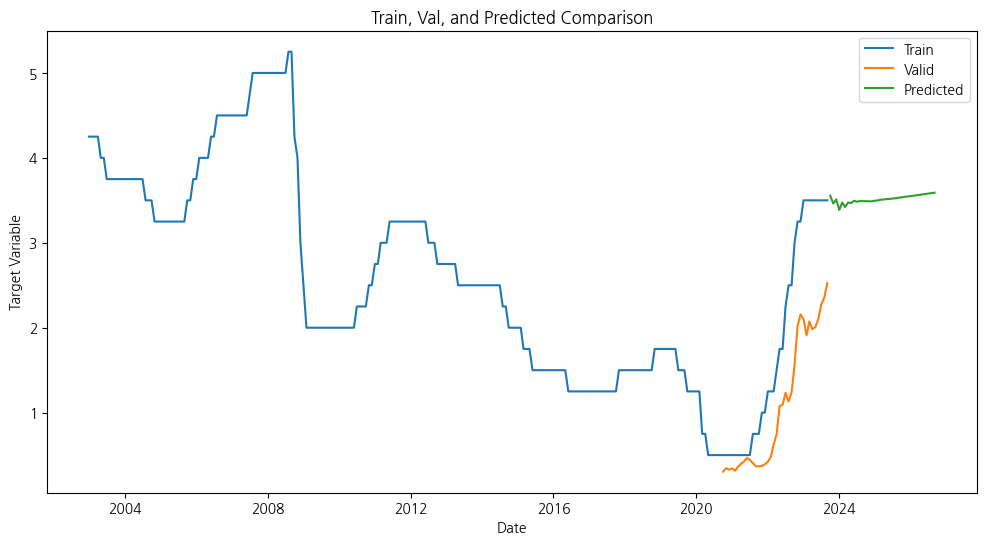

In [ ]:
# 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data['기준금리'], label='Train')
plt.plot(results_v36.index, results_v36['Val'], label='Valid')
plt.plot(results36.index, results36['Predicted'], label='Predicted')
plt.title('Train, Val, and Predicted Comparison')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

# 예측결과 통합

In [ ]:
d_3= results3.reset_index()
d_6= results6.reset_index()
d_12= results12.reset_index()
d_18= results18.reset_index()
d_24= results24.reset_index()
d_30= results30.reset_index()
d_36= results36.reset_index()

In [ ]:
pd.DataFrame({'날짜':d_36['index'],'mean_36':d_36['Predicted'],'mean_30':d_30['Predicted'],'mean_24':d_24['Predicted'],'mean_18':d_18['Predicted'],'mean_12':d_12['Predicted'],'mean_6':d_6['Predicted'],'mean_3':d_3['Predicted']}).to_csv('vecm_lstm_result.csv', index=False)

# 예측 val 통합

In [ ]:
v_3= results_v3.reset_index()
v_6= results_v6.reset_index()
v_12= results_v12.reset_index()
v_18= results_v18.reset_index()
v_24= results_v24.reset_index()
v_30= results_v30.reset_index()
v_36= results_v36.reset_index()

In [ ]:
pd.DataFrame({'날짜':v_36['날짜'],'mean_36':v_36['Val'],'mean_30':v_30['Val'],'mean_24':v_24['Val'],'mean_18':v_18['Val'],'mean_12':v_12['Val'],'mean_6':v_6['Val'],'mean_3':v_3['Val']}).to_csv('vecm_lstm_val.csv', index=False)

In [ ]:
all_data['기준금리'].iloc[208:]

날짜
2020-05-01    0.50
2020-06-01    0.50
2020-07-01    0.50
2020-08-01    0.50
2020-09-01    0.50
2020-10-01    0.50
2020-11-01    0.50
2020-12-01    0.50
2021-01-01    0.50
2021-02-01    0.50
2021-03-01    0.50
2021-04-01    0.50
2021-05-01    0.50
2021-06-01    0.50
2021-07-01    0.50
2021-08-01    0.75
2021-09-01    0.75
2021-10-01    0.75
2021-11-01    1.00
2021-12-01    1.00
2022-01-01    1.25
2022-02-01    1.25
2022-03-01    1.25
2022-04-01    1.50
2022-05-01    1.75
2022-06-01    1.75
2022-07-01    2.25
2022-08-01    2.50
2022-09-01    2.50
2022-10-01    3.00
2022-11-01    3.25
2022-12-01    3.25
2023-01-01    3.50
2023-02-01    3.50
2023-03-01    3.50
2023-04-01    3.50
2023-05-01    3.50
2023-06-01    3.50
2023-07-01    3.50
2023-08-01    3.50
2023-09-01    3.50
Name: 기준금리, dtype: float64